# New Test

/tmp/ipython-input-1059443907.py:59: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return (dt.dt.floor(f"{minutes}T")).dt.tz_convert("UTC") if dt.dt.tz is not None else dt.dt.floor(f"{minutes}T")


Executed backtest: trades=1075


symbol                entry_time  entry_price side       atr  \
0     1000CATUSDT 2025-08-09 20:00:00+00:00     0.009960  BUY  0.000304   
428       HFTUSDT 2025-08-09 20:00:00+00:00     0.112200  BUY  0.008000   
246       COSUSDT 2025-08-09 20:00:00+00:00     0.003713  BUY  0.000085   
302      DOGSUSDT 2025-08-09 20:00:00+00:00     0.000152  BUY  0.000003   
134    BANANAUSDT 2025-08-09 20:00:00+00:00    27.070000  BUY  0.763614   
1009      VICUSDT 2025-08-09 20:00:00+00:00     0.287200  BUY  0.007213   
440      HOOKUSDT 2025-08-09 20:00:00+00:00     0.115800  BUY  0.002781   
453        IDUSDT 2025-08-09 20:00:00+00:00     0.178500  BUY  0.003742   
460       IMXUSDT 2025-08-09 20:00:00+00:00     0.598000  BUY  0.012284   
681     PENGUUSDT 2025-08-09 20:00:00+00:00     0.038611  BUY  0.001443   

      take1_price  take2_price  stop_price_initial            qty  \
0        0.010415     0.010719            0.009656   10040.160643   
428      0.124200     0.132200            0.104200     891.265597   
246      0.003840     0.003925            0.003628   26932.399677   
302      0.000156     0.000159            0.000149  659195.781147   
134     28.215422    28.979036           27.042930       3.694126   
1009     0.298019     0.305232            0.279987     348.189415   
440      0.119972     0.122753            0.113019     863.557858   
453      0.184113     0.187855            0.174758     560.224090   
460      0.616426     0.628709            0.597402     167.224080   
681      0.040775     0.042218            0.038572    2589.935511   

                     exit_time  exit_price exit_reason  partial_taken  \
0    2025-08-10 04:00:00+00:00    0.009656        STOP          False   
428  2025-08-10 08:00:00+00:00    0.104200        STOP          False   
246  2025-08-10 04:00:00+00:00    0.003628        STOP          False   
302  2025-08-10 04:00:00+00:00    0.000149        STOP          False   
134  2025-08-10 00:00:00+00:00   27.042930     STOP_BE           True   
1009 2025-08-10 04:00:00+00:00    0.279987        STOP          False   
440  2025-08-10 00:00:00+00:00    0.113019        STOP          False   
453  2025-08-10 04:00:00+00:00    0.174758        STOP          False   
460  2025-08-10 00:00:00+00:00    0.597402     STOP_BE           True   
681  2025-08-10 04:00:00+00:00    0.038572     STOP_BE           True   

       pnl_usd  cum_pnl_usd  
0    -3.047390    -3.047390  
428  -7.130299   -10.177689  
246  -2.281430   -12.459119  
302  -2.018582   -14.477700  
134   3.148499   -11.329201  
1009 -2.511456   -13.840657  
440  -2.401895   -16.242551  
453  -2.096413   -18.338964  
460   2.285892   -16.053072  
681   4.178806   -11.874266

=== METRICS ===
Trades:      1075
Win rate:    50.42%
ProfitFactor:0.993
Net PnL:     -9.38 USD
Max DD:      771.70 USD
Saved: trades.csv, equity.csv


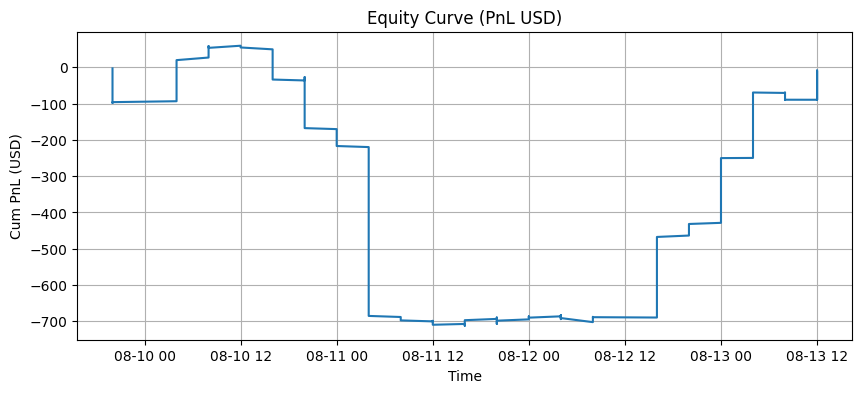

In [ ]:
# 🚀 Colab-ready Backtester for TradingView → Binance (4h)
# -----------------------------------------------------------------
# Этот скрипт предназначен для запуска в Google Colab в ОДНОЙ ячейке.
# Он:
#  - скачивает данные через gdown (если нужно);
#  - аккуратно сшивает сигналы с 4h-свечами с учётом миллисекундных сдвигов;
#  - применяет BTC-фильтр ровно как в проде;
#  - входит РЫНКОМ на ОТКРЫТИИ следующей свечи;
#  - считает ATR (Wilder), уровни TP/SL, частичный выход на take1 + перенос стопа в BE±0.1%;
#  - детерминирует порядок событий внутри бара (по умолчанию «stop_first»);
#  - считает метрики и сохраняет результаты в CSV в /content.
#
# Просто запустите ЭТУ ячейку как есть. Если файлы уже в Colab, блок скачивания
# можно отключить, выставив DOWNLOAD=False.

# =============== SETUP & DOWNLOAD =================
DOWNLOAD = True  # поставьте False, если CSV уже в /content
KLINES_CSV  = 'klines_data_4h.csv'
SIGNALS_CSV = 'tradingview_signals_real.csv'
SYMBOL_CONF_CSV = None  # при наличии: 'symbol_conf.csv'

# Файлы из вашего сообщения (Google Drive IDs)
KLINES_FILE_ID  = '1rsU2dMtJauwkrEZ2BR9vhyG_XOoltYVY'
SIGNALS_FILE_ID = '1myLrl6gU3bLytydjo9mYtrq8eJhjSfPm'

try:
    import gdown, pandas as pd, numpy as np, matplotlib.pyplot as plt
except Exception:
    !pip -q install gdown
    import gdown, pandas as pd, numpy as np, matplotlib.pyplot as plt

if DOWNLOAD:
    if KLINES_CSV:
        gdown.download(id=KLINES_FILE_ID, output=KLINES_CSV, quiet=True)
    if SIGNALS_CSV:
        gdown.download(id=SIGNALS_FILE_ID, output=SIGNALS_CSV, quiet=True)

# =============== PARAMETERS =======================
DEFAULT_ATR_LENGTH = 14
DEFAULT_TAKE1 = 1.5     # ATR multiples
DEFAULT_TAKE2 = 2.5
DEFAULT_STOP  = 1
DEFAULT_ORDER_SIZE_USD = 100.0
DEFAULT_PORTION = 0.75   # доля частичного выхода на take1
BREAKEVEN_BUMP = 0.001  # ±0.1% как в проде
TIMEFRAME_MINUTES = 240
INTRABAR_RULE = 'stop_first'   # либо 'target_first'

# =============== UTILS ============================
import math, json
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import pandas as pd
import numpy as np


def floor_to_timeframe(dt: pd.Series, minutes: int) -> pd.Series:
    return (dt.dt.floor(f"{minutes}T")).dt.tz_convert("UTC") if dt.dt.tz is not None else dt.dt.floor(f"{minutes}T")


def true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr


def wilder_atr(df: pd.DataFrame, length: int) -> pd.Series:
    tr = true_range(df['High'], df['Low'], df['Close'])
    atr = tr.ewm(alpha=1/length, adjust=False).mean()
    return atr

# =============== DATA LOADING =====================

def load_klines(csv_path: str) -> pd.DataFrame:
    k = pd.read_csv(csv_path)
    k['Date'] = pd.to_datetime(k['Date'], utc=True)
    k = k.sort_values(['Symbol', 'Date'])
    return k


def load_signals(csv_path: str) -> pd.DataFrame:
    s = pd.read_csv(csv_path)
    if 'interval' in s.columns and 'timeframe' not in s.columns:
        s = s.rename(columns={'interval': 'timeframe'})
    s['utc_time'] = pd.to_datetime(s['utc_time'], utc=True)
    if 'timeframe' in s.columns:
        s = s[s['timeframe'].astype(str).str.lower().isin(['4h','240'])]
    s['candle_time'] = floor_to_timeframe(s['utc_time'], TIMEFRAME_MINUTES)
    keep = ['symbol','signal','entry_price','utc_time','candle_time','indicators']
    s = s[[c for c in keep if c in s.columns]]
    return s

# =============== PARAM RESOLUTION =================
@dataclass
class SymbolParams:
    atr_length: int = DEFAULT_ATR_LENGTH
    take1: float = DEFAULT_TAKE1
    take2: float = DEFAULT_TAKE2
    stop: float = DEFAULT_STOP
    order_size_usd: float = DEFAULT_ORDER_SIZE_USD
    portion: float = DEFAULT_PORTION


def load_symbol_params(csv_path: Optional[str]) -> Dict[str, SymbolParams]:
    params: Dict[str, SymbolParams] = {}
    if not csv_path:
        return params
    df = pd.read_csv(csv_path)
    for _, r in df.iterrows():
        params[str(r['symbol']).upper()] = SymbolParams(
            atr_length=int(r.get('atr_length', DEFAULT_ATR_LENGTH)),
            take1=float(r.get('take1', DEFAULT_TAKE1)),
            take2=float(r.get('take2', DEFAULT_TAKE2)),
            stop=float(r.get('stop', DEFAULT_STOP)),
            order_size_usd=float(r.get('order_size_usd', DEFAULT_ORDER_SIZE_USD)),
            portion=float(r.get('portion', DEFAULT_PORTION)),
        )
    return params

# =============== ENGINE ===========================
BUY_SET = {"STRONG_BUY"}
BUY_OK_WITH_BTC = {"STRONG_BUY", "BUY"}
SELL_SET = {"STRONG_SELL"}
SELL_OK_WITH_BTC = {"STRONG_SELL", "SELL"}


def prepare_btc_filter(signals: pd.DataFrame) -> pd.DataFrame:
    btc = signals[signals['symbol'].str.upper() == 'BTCUSDT'].copy()
    btc = btc.sort_values(['candle_time','utc_time']).groupby('candle_time').tail(1)
    btc = btc[['candle_time','signal','utc_time']].rename(columns={'signal':'btc_signal','utc_time':'btc_utc_time'})
    return btc


def attach_btc_filter(signals: pd.DataFrame, btc_df: pd.DataFrame) -> pd.DataFrame:
    merged = signals.merge(btc_df, on='candle_time', how='left')
    merged = merged[merged['symbol'].str.upper() != 'BTCUSDT']
    merged = merged[~merged['btc_utc_time'].isna()]
    return merged


def decision(side_sig: str, btc_sig: str) -> Optional[str]:
    side_sig = (side_sig or '').upper()
    btc_sig = (btc_sig or '').upper()
    if side_sig in BUY_SET and btc_sig in BUY_OK_WITH_BTC:
        return 'BUY'
    if side_sig in SELL_SET and btc_sig in SELL_OK_WITH_BTC:
        return 'SELL'
    return None

from dataclasses import dataclass
from typing import Tuple

@dataclass
class TradeResult:
    symbol: str
    entry_time: pd.Timestamp
    entry_price: float
    side: str
    atr: float
    take1: float
    take2: float
    stop: float
    qty: float
    exit_time: pd.Timestamp
    exit_price: float
    exit_reason: str
    partial_taken: bool
    pnl_usd: float


def compute_levels(side: str, entry: float, atr: float, k1: float, k2: float, ks: float) -> Tuple[float,float,float]:
    if side == 'BUY':
        return entry + atr*k1, entry + atr*k2, entry - atr*ks
    else:
        return entry - atr*k1, entry - atr*k2, entry + atr*ks


def simulate_trade(symbol_df: pd.DataFrame, entry_idx: int, side: str, entry_price: float,
                    atr: float, params: SymbolParams, intrabar_rule: str) -> TradeResult:
    t1, t2, sl = compute_levels(side, entry_price, atr, params.take1, params.take2, params.stop)
    qty = params.order_size_usd / max(entry_price, 1e-12)
    partial = False
    remaining_qty = qty
    be_stop = None

    for i in range(entry_idx, len(symbol_df)):
        row = symbol_df.iloc[i]
        ts, high, low = row['Date'], float(row['High']), float(row['Low'])

        if side == 'BUY':
            if not partial:
                stop_hit = low <= sl
                t1_hit = high >= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (exit_price - entry_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (t1 - entry_price) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                        t2_hit = high >= t2
                        be_hit = low <= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (exit_price - entry_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (t1 - entry_price) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                    t2_hit = high >= t2
                    be_hit = low <= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = high >= t2
                be_hit = low <= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
        else:
            if not partial:
                stop_hit = high >= sl
                t1_hit = low <= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (entry_price - exit_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (entry_price - t1) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                        t2_hit = low <= t2
                        be_hit = high >= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (entry_price - exit_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (entry_price - t1) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                    t2_hit = low <= t2
                    be_hit = high >= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = low <= t2
                be_hit = high >= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)

    last = symbol_df.iloc[-1]
    exit_price = float(last['Close'])
    if side == 'BUY':
        pnl_open = (exit_price - entry_price) * qty
    else:
        pnl_open = (entry_price - exit_price) * qty
    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price, side, atr,
                       t1, t2, sl if not partial else be_stop, qty,
                       last['Date'], exit_price, 'EOD', partial,
                       pnl_open if not partial else (
                           ((t1 - entry_price) * (qty * DEFAULT_PORTION) if side=='BUY' else (entry_price - t1) * (qty * DEFAULT_PORTION))
                           + ( (exit_price - entry_price) * (qty*(1-DEFAULT_PORTION)) if side=='BUY' else (entry_price - exit_price) * (qty*(1-DEFAULT_PORTION)) )
                       ))


def backtest(klines_csv: str, signals_csv: str,
             symbol_conf_csv: Optional[str] = SYMBOL_CONF_CSV,
             intrabar_rule: str = INTRABAR_RULE):
    kdf = load_klines(klines_csv)
    sdf = load_signals(signals_csv)
    btc = prepare_btc_filter(sdf)
    s_all = attach_btc_filter(sdf, btc)
    s_all['side'] = [decision(sig, btc_sig) for sig, btc_sig in zip(s_all['signal'], s_all['btc_signal'])]
    s_all = s_all[~s_all['side'].isna()].copy()

    sym_params_map = load_symbol_params(symbol_conf_csv)

    kdf['Date'] = pd.to_datetime(kdf['Date'], utc=True)
    kdf = kdf.sort_values(['Symbol','Date'])

    trades: List[TradeResult] = []

    for sym, s_sym in s_all.groupby('symbol'):
        symU = sym.upper()
        params = sym_params_map.get(symU, SymbolParams())
        k_sym = kdf[kdf['Symbol'].str.upper() == symU].copy()
        if k_sym.empty:
            continue
        k_sym['ATR'] = wilder_atr(k_sym, params.atr_length)
        k_sym = k_sym.reset_index(drop=True)
        idx_map = {pd.Timestamp(ts): i for i, ts in enumerate(k_sym['Date'])}

        for _, row in s_sym.sort_values('candle_time').iterrows():
            ct = pd.Timestamp(row['candle_time'])
            if ct not in idx_map:
                continue
            idx = idx_map[ct]
            if idx+1 >= len(k_sym):
                continue
            atr = float(k_sym.loc[idx, 'ATR'])
            if not np.isfinite(atr):
                continue
            entry_price = float(k_sym.loc[idx+1, 'Open'])
            side = row['side']
            tr = simulate_trade(k_sym, idx+1, side, entry_price, atr, params, intrabar_rule)
            trades.append(tr)

    if not trades:
        return pd.DataFrame(), pd.DataFrame()

    tdf = pd.DataFrame([{
        'symbol': t.symbol,
        'entry_time': t.entry_time,
        'entry_price': t.entry_price,
        'side': t.side,
        'atr': t.atr,
        'take1_price': t.take1,
        'take2_price': t.take2,
        'stop_price_initial': t.stop,
        'qty': t.qty,
        'exit_time': t.exit_time,
        'exit_price': t.exit_price,
        'exit_reason': t.exit_reason,
        'partial_taken': t.partial_taken,
        'pnl_usd': t.pnl_usd,
    } for t in trades])

    tdf = tdf.sort_values('entry_time')
    tdf['cum_pnl_usd'] = tdf['pnl_usd'].cumsum()

    eq = tdf[['entry_time','cum_pnl_usd']].copy()
    return tdf, eq

# =============== RUN ==============================
trades, equity = backtest(KLINES_CSV, SIGNALS_CSV, SYMBOL_CONF_CSV, INTRABAR_RULE)

from IPython.display import display
print(f"Executed backtest: trades={len(trades)}")
if len(trades):
    display(trades.head(10))

# Метрики
if len(trades):
    wins = (trades['pnl_usd'] > 0).sum()
    losses = (trades['pnl_usd'] <= 0).sum()
    winrate = wins / (wins + losses) if (wins+losses)>0 else np.nan
    gross_profit = trades.loc[trades['pnl_usd']>0, 'pnl_usd'].sum()
    gross_loss   = -trades.loc[trades['pnl_usd']<=0, 'pnl_usd'].sum()
    profit_factor = gross_profit / gross_loss if gross_loss>0 else np.inf

    # Max Drawdown по эквити
    eq_curve = equity['cum_pnl_usd'].values if len(equity) else np.array([0.0])
    peaks = np.maximum.accumulate(eq_curve)
    drawdowns = peaks - eq_curve
    max_dd = drawdowns.max() if len(drawdowns) else 0.0

    print("=== METRICS ===")
    print(f"Trades:      {len(trades)}")
    print(f"Win rate:    {winrate:.2%}")
    print(f"ProfitFactor:{profit_factor:.3f}")
    print(f"Net PnL:     {trades['pnl_usd'].sum():.2f} USD")
    print(f"Max DD:      {max_dd:.2f} USD")

# Сохранение результатов в /content
trades_path = 'trades.csv'
equity_path = 'equity.csv'
trades.to_csv(trades_path, index=False)
equity.to_csv(equity_path, index=False)

print(f"Saved: {trades_path}, {equity_path}")

# Быстрый график эквити
if len(equity):
    plt.figure(figsize=(10,4))
    plt.plot(equity['entry_time'], equity['cum_pnl_usd'])
    plt.title('Equity Curve (PnL USD)')
    plt.xlabel('Time')
    plt.ylabel('Cum PnL (USD)')
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd

symbol_settings = pd.read_csv("symbols_settings_update_before_crash.csv")
symbol_settings_filtered = symbol_settings[symbol_settings['status'] == 1]
symbol_parameters = {
    row['symbol']: (row["stop"], row["portion"], row["take1"], row["take2"])
    for _, row in symbol_settings_filtered.iterrows()
}


/tmp/ipython-input-3754388885.py:50: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return (dt.dt.floor(f"{minutes}T")).dt.tz_convert("UTC") if dt.dt.tz is not None else dt.dt.floor(f"{minutes}T")


[i] symbols_settings_last_update.csv не найден, использую symbols_settings_update_before_crash.csv
Executed backtest: trades=151


symbol                entry_time  entry_price side       atr  \
0    1000CATUSDT 2025-08-09 20:00:00+00:00     0.009960  BUY  0.000304   
76      OMNIUSDT 2025-08-09 20:00:00+00:00     4.860000  BUY  0.199968   
82     PENGUUSDT 2025-08-09 20:00:00+00:00     0.038611  BUY  0.001443   
26      DUSKUSDT 2025-08-09 20:00:00+00:00     0.069800  BUY  0.001280   
24         DUSDT 2025-08-09 20:00:00+00:00     0.037900  BUY  0.000853   
44       HFTUSDT 2025-08-09 20:00:00+00:00     0.112200  BUY  0.008000   
93      SAGAUSDT 2025-08-09 20:00:00+00:00     0.282400  BUY  0.006692   
19       CVXUSDT 2025-08-09 20:00:00+00:00     4.603000  BUY  0.150891   
110    SUPERUSDT 2025-08-09 20:00:00+00:00     0.799100  BUY  0.017572   
61       KNCUSDT 2025-08-09 20:00:00+00:00     0.456700  BUY  0.007533   

     take1_price  take2_price  stop_price_initial           qty  \
0       0.010719     0.011478            0.009823  10040.160643   
76      5.109960     5.859839            4.770014     20.576132   
82      0.040414     0.045825            0.038572   2589.935511   
26      0.071400     0.076200            0.069224   1432.664756   
24      0.038967     0.041740            0.037260   2638.522427   
44      0.115800     0.124200            0.112088    891.265597   
93      0.290765     0.315860            0.279389    354.107649   
19      4.829337     5.055674            4.535099     21.724962   
110     0.838636     0.886958            0.791193    125.140783   
61      0.466117     0.494367            0.453310    218.962120   

                    exit_time  exit_price exit_reason  partial_taken  \
0   2025-08-10 04:00:00+00:00    0.009823        STOP          False   
76  2025-08-10 00:00:00+00:00    4.770014        STOP          False   
82  2025-08-10 04:00:00+00:00    0.038572     STOP_BE           True   
26  2025-08-10 00:00:00+00:00    0.069224        STOP          False   
24  2025-08-10 04:00:00+00:00    0.037260        STOP          False   
44  2025-08-10 00:00:00+00:00    0.112088     STOP_BE           True   
93  2025-08-10 00:00:00+00:00    0.279389        STOP          False   
19  2025-08-10 00:00:00+00:00    4.535099        STOP          False   
110 2025-08-10 04:00:00+00:00    0.791193        STOP          False   
61  2025-08-10 00:00:00+00:00    0.453310        STOP          False   

      pnl_usd  cum_pnl_usd  
0   -1.371325    -1.371325  
76  -1.851554    -3.222880  
82   0.138545    -3.084335  
26  -0.825218    -3.909553  
24  -1.688790    -5.598343  
44   1.554317    -4.044026  
93  -1.066347    -5.110372  
19  -1.475150    -6.585522  
110 -0.989517    -7.575039  
61  -0.742296    -8.317335

=== METRICS ===
Trades:       151
Win rate:     21.85%
ProfitFactor: 0.227
Net PnL:      -145.21 USD
Max DD:       152.95 USD
Saved: trades.csv, equity.csv


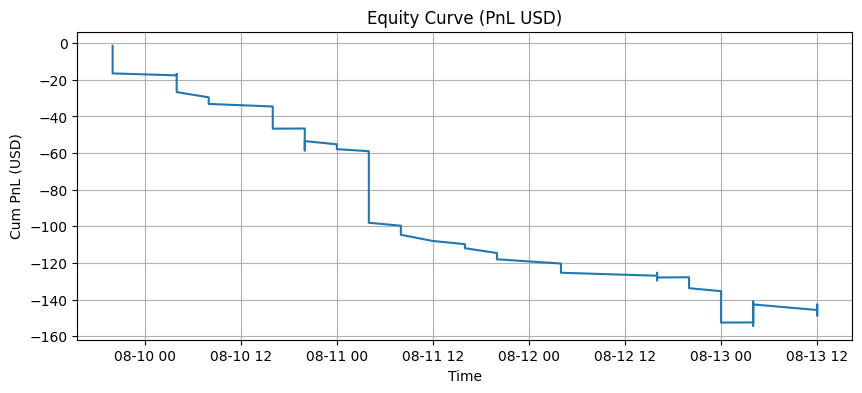

In [ ]:
# Пока самый лучший по совпадению

# ================== COLAB SETUP & DOWNLOADS ==================
DOWNLOAD = True   # поставьте False, если все CSV уже лежат в /content
KLINES_CSV  = 'klines_data_4h.csv'
SIGNALS_CSV = 'tradingview_signals_real.csv'

# Укажи одно из названий файла с настройками символов:
#   'symbols_settings_last_update.csv'  или  'symbols_settings_update_before_crash.csv'
SYMBOLS_SETTINGS_CSV = 'symbols_settings_last_update.csv'  # если файла нет, скрипт попробует fallback

# Если у тебя есть Google Drive ID для файла с настройками — впиши сюда, иначе оставь None
SYMBOLS_FILE_ID = None  # пример: '1AbCdE....'  -> тогда скачается в SYMBOLS_SETTINGS_CSV

# Файлы из твоего сообщения (Google Drive IDs)
KLINES_FILE_ID  = '1rsU2dMtJauwkrEZ2BR9vhyG_XOoltYVY'
SIGNALS_FILE_ID = '1myLrl6gU3bLytydjo9mYtrq8eJhjSfPm'

try:
    import gdown, pandas as pd, numpy as np, matplotlib.pyplot as plt, os
except Exception:
    !pip -q install gdown
    import gdown, pandas as pd, numpy as np, matplotlib.pyplot as plt, os

if DOWNLOAD:
    if KLINES_CSV and KLINES_FILE_ID:
        gdown.download(id=KLINES_FILE_ID, output=KLINES_CSV, quiet=True)
    if SIGNALS_CSV and SIGNALS_FILE_ID:
        gdown.download(id=SIGNALS_FILE_ID, output=SIGNALS_CSV, quiet=True)
    if SYMBOLS_FILE_ID:
        gdown.download(id=SYMBOLS_FILE_ID, output=SYMBOLS_SETTINGS_CSV, quiet=True)

# ================== PARAMETERS (DEFAULTS) ====================
DEFAULT_ATR_LENGTH = 14
DEFAULT_TAKE1 = 1.5     # ATR multiples
DEFAULT_TAKE2 = 2.5
DEFAULT_STOP  = 1.0
DEFAULT_ORDER_SIZE_USD = 100.0
DEFAULT_PORTION = 0.75  # доля частичного выхода на take1
BREAKEVEN_BUMP = 0.001  # ±0.1% как в проде
TIMEFRAME_MINUTES = 240
INTRABAR_RULE = 'stop_first'   # либо 'target_first'

# ================== UTILS ===================================
import math, json
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

def floor_to_timeframe(dt: pd.Series, minutes: int) -> pd.Series:
    return (dt.dt.floor(f"{minutes}T")).dt.tz_convert("UTC") if dt.dt.tz is not None else dt.dt.floor(f"{minutes}T")

def true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr

def wilder_atr(df: pd.DataFrame, length: int) -> pd.Series:
    tr = true_range(df['High'], df['Low'], df['Close'])
    atr = tr.ewm(alpha=1/length, adjust=False).mean()
    return atr

# ================== DATA LOADING ============================
def load_klines(csv_path: str) -> pd.DataFrame:
    k = pd.read_csv(csv_path)
    k['Date'] = pd.to_datetime(k['Date'], utc=True)
    k = k.sort_values(['Symbol', 'Date'])
    return k

def load_signals(csv_path: str) -> pd.DataFrame:
    s = pd.read_csv(csv_path)
    if 'interval' in s.columns and 'timeframe' not in s.columns:
        s = s.rename(columns={'interval': 'timeframe'})
    s['utc_time'] = pd.to_datetime(s['utc_time'], utc=True)
    if 'timeframe' in s.columns:
        s = s[s['timeframe'].astype(str).str.lower().isin(['4h','240'])]
    s['candle_time'] = floor_to_timeframe(s['utc_time'], TIMEFRAME_MINUTES)
    keep = ['symbol','signal','entry_price','utc_time','candle_time','indicators']
    s = s[[c for c in keep if c in s.columns]]
    return s

# ================== SYMBOL PARAMS ===========================
@dataclass
class SymbolParams:
    atr_length: int = DEFAULT_ATR_LENGTH
    take1: float = DEFAULT_TAKE1
    take2: float = DEFAULT_TAKE2
    stop: float = DEFAULT_STOP
    order_size_usd: float = DEFAULT_ORDER_SIZE_USD
    portion: float = DEFAULT_PORTION

def _try_load_symbols_csv(path_primary: str) -> Optional[pd.DataFrame]:
    if os.path.exists(path_primary):
        return pd.read_csv(path_primary)
    # fallback на альтернативное имя из твоего сообщения
    alt = 'symbols_settings_update_before_crash.csv'
    if path_primary != alt and os.path.exists(alt):
        print(f"[i] {path_primary} не найден, использую {alt}")
        return pd.read_csv(alt)
    print(f"[!] Не найден файл с настройками символов: {path_primary} (и fallback тоже)")
    return None

def load_symbol_params_from_settings(csv_path: Optional=str) -> Dict[str, SymbolParams]:
    """
    Читает твой symbols_settings_*.csv (c колонками: symbol, stop, portion, take1, take2 [, status, atr_length, order_size_usd])
    и возвращает:
        - dict symbol -> SymbolParams
        - а также список whitelist символов (status==1, если колонка присутствует)
    """
    params: Dict[str, SymbolParams] = {}
    whitelist: List[str] = []

    if not csv_path:
        return params, whitelist

    df = _try_load_symbols_csv(csv_path)
    if df is None:
        return params, whitelist

    df['symbol'] = df['symbol'].astype(str).str.upper()

    if 'status' in df.columns:
        df = df[df['status'] == 1].copy()

    whitelist = df['symbol'].unique().tolist()

    for _, r in df.iterrows():
        sym = str(r['symbol']).upper()
        params[sym] = SymbolParams(
            atr_length=int(r.get('atr_length', DEFAULT_ATR_LENGTH)),
            take1=float(r.get('take1', DEFAULT_TAKE1)),
            take2=float(r.get('take2', DEFAULT_TAKE2)),
            stop=float(r.get('stop', DEFAULT_STOP)),
            order_size_usd=float(r.get('order_size_usd', DEFAULT_ORDER_SIZE_USD)),
            portion=float(r.get('portion', DEFAULT_PORTION)),
        )

    return params, whitelist

# ================== ENGINE (BTC-фильтр и логика) ============
BUY_SET = {"STRONG_BUY"}
BUY_OK_WITH_BTC = {"STRONG_BUY", "BUY"}
SELL_SET = {"STRONG_SELL"}
SELL_OK_WITH_BTC = {"STRONG_SELL", "SELL"}

def prepare_btc_filter(signals: pd.DataFrame) -> pd.DataFrame:
    btc = signals[signals['symbol'].str.upper() == 'BTCUSDT'].copy()
    btc = btc.sort_values(['candle_time','utc_time']).groupby('candle_time').tail(1)
    btc = btc[['candle_time','signal','utc_time']].rename(columns={'signal':'btc_signal','utc_time':'btc_utc_time'})
    return btc

def attach_btc_filter(signals: pd.DataFrame, btc_df: pd.DataFrame) -> pd.DataFrame:
    merged = signals.merge(btc_df, on='candle_time', how='left')
    merged = merged[merged['symbol'].str.upper() != 'BTCUSDT']
    merged = merged[~merged['btc_utc_time'].isna()]
    return merged

def decision(side_sig: str, btc_sig: str) -> Optional[str]:
    side_sig = (side_sig or '').upper()
    btc_sig = (btc_sig or '').upper()
    if side_sig in BUY_SET and btc_sig in BUY_OK_WITH_BTC:
        return 'BUY'
    if side_sig in SELL_SET and btc_sig in SELL_OK_WITH_BTC:
        return 'SELL'
    return None

from dataclasses import dataclass
from typing import Tuple

@dataclass
class TradeResult:
    symbol: str
    entry_time: pd.Timestamp
    entry_price: float
    side: str
    atr: float
    take1: float
    take2: float
    stop: float
    qty: float
    exit_time: pd.Timestamp
    exit_price: float
    exit_reason: str
    partial_taken: bool
    pnl_usd: float

def compute_levels(side: str, entry: float, atr: float, k1: float, k2: float, ks: float) -> Tuple[float,float,float]:
    if side == 'BUY':
        return entry + atr*k1, entry + atr*k2, entry - atr*ks
    else:
        return entry - atr*k1, entry - atr*k2, entry + atr*ks

def simulate_trade(symbol_df: pd.DataFrame, entry_idx: int, side: str, entry_price: float,
                   atr: float, params: SymbolParams, intrabar_rule: str) -> TradeResult:
    t1, t2, sl = compute_levels(side, entry_price, atr, params.take1, params.take2, params.stop)
    qty = params.order_size_usd / max(entry_price, 1e-12)
    partial = False
    remaining_qty = qty
    be_stop = None

    for i in range(entry_idx, len(symbol_df)):
        row = symbol_df.iloc[i]
        ts, high, low = row['Date'], float(row['High']), float(row['Low'])

        if side == 'BUY':
            if not partial:
                stop_hit = low <= sl
                t1_hit = high >= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (exit_price - entry_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (t1 - entry_price) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                        t2_hit = high >= t2
                        be_hit = low <= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (exit_price - entry_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (t1 - entry_price) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                    t2_hit = high >= t2
                    be_hit = low <= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = high >= t2
                be_hit = low <= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
        else:
            if not partial:
                stop_hit = high >= sl
                t1_hit = low <= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (entry_price - exit_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (entry_price - t1) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                        t2_hit = low <= t2
                        be_hit = high >= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (entry_price - exit_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (entry_price - t1) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                    t2_hit = low <= t2
                    be_hit = high >= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = low <= t2
                be_hit = high >= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)

    # --- Баров не хватило: закрываемся по EOD (важно: используем ИНДИВИДУАЛЬНУЮ portion, а не дефолт)
    last = symbol_df.iloc[-1]
    exit_price = float(last['Close'])
    if side == 'BUY':
        if not partial:
            pnl_open = (exit_price - entry_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
            stop_print = sl
        else:
            realized = (t1 - entry_price) * (qty * params.portion)
            pnl_open = realized + (exit_price - entry_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
            stop_print = be_stop
    else:
        if not partial:
            pnl_open = (entry_price - exit_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
            stop_print = sl
        else:
            realized = (entry_price - t1) * (qty * params.portion)
            pnl_open = realized + (entry_price - exit_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
            stop_print = be_stop

    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price, side, atr,
                       t1, t2, stop_print, qty,
                       last['Date'], exit_price, exit_reason, partial_taken, pnl_open)

def backtest(klines_csv: str, signals_csv: str,
             symbols_settings_csv: Optional[str] = SYMBOLS_SETTINGS_CSV,
             intrabar_rule: str = INTRABAR_RULE):
    # --- загрузка
    kdf = load_klines(klines_csv)
    sdf = load_signals(signals_csv)

    # --- индивидуальные параметры + белый список символов
    sym_params_map, whitelist = load_symbol_params_from_settings(symbols_settings_csv)
    whitelist_set = set([s.upper() for s in whitelist])

    # --- BTC фильтр и матчинг
    btc = prepare_btc_filter(sdf)
    s_all = attach_btc_filter(sdf, btc)
    s_all['side'] = [decision(sig, btc_sig) for sig, btc_sig in zip(s_all['signal'], s_all['btc_signal'])]
    s_all = s_all[~s_all['side'].isna()].copy()

    # --- оставляем только символы из твоего списка (status==1)
    if whitelist_set:
        s_all = s_all[s_all['symbol'].str.upper().isin(whitelist_set)].copy()

    # --- подготовка свечей
    kdf['Date'] = pd.to_datetime(kdf['Date'], utc=True)
    kdf = kdf.sort_values(['Symbol','Date'])

    trades: List[TradeResult] = []

    for sym, s_sym in s_all.groupby('symbol'):
        symU = sym.upper()
        params = sym_params_map.get(symU, SymbolParams())  # если почему-то нет — используем дефолт
        k_sym = kdf[kdf['Symbol'].str.upper() == symU].copy()
        if k_sym.empty:
            continue

        # ATR по индивидуальной длине
        k_sym['ATR'] = wilder_atr(k_sym, params.atr_length)
        k_sym = k_sym.reset_index(drop=True)

        # мэп индексов по времени свечи (в CSV Date=время открытия бара)
        idx_map = {pd.Timestamp(ts): i for i, ts in enumerate(k_sym['Date'])}

        # сигналы сортируем по времени их свечи
        for _, row in s_sym.sort_values('candle_time').iterrows():
            ct = pd.Timestamp(row['candle_time'])
            if ct not in idx_map:
                continue
            idx = idx_map[ct]
            # входим "на следующем баре", сразу после закрытия сигнального
            if idx+1 >= len(k_sym):
                continue

            atr = float(k_sym.loc[idx, 'ATR'])
            if not np.isfinite(atr):
                continue

            entry_price = float(k_sym.loc[idx+1, 'Open'])
            side = row['side']
            tr = simulate_trade(k_sym, idx+1, side, entry_price, atr, params, intrabar_rule)
            trades.append(tr)

    if not trades:
        return pd.DataFrame(), pd.DataFrame()

    tdf = pd.DataFrame([{
        'symbol': t.symbol,
        'entry_time': t.entry_time,
        'entry_price': t.entry_price,
        'side': t.side,
        'atr': t.atr,
        'take1_price': t.take1,
        'take2_price': t.take2,
        'stop_price_initial': t.stop,
        'qty': t.qty,
        'exit_time': t.exit_time,
        'exit_price': t.exit_price,
        'exit_reason': t.exit_reason,
        'partial_taken': t.partial_taken,
        'pnl_usd': t.pnl_usd,
    } for t in trades])

    tdf = tdf.sort_values('entry_time')
    tdf['cum_pnl_usd'] = tdf['pnl_usd'].cumsum()

    eq = tdf[['entry_time','cum_pnl_usd']].copy()
    return tdf, eq

# ================== RUN ===========================
trades, equity = backtest(KLINES_CSV, SIGNALS_CSV, SYMBOLS_SETTINGS_CSV, INTRABAR_RULE)

from IPython.display import display
print(f"Executed backtest: trades={len(trades)}")
if len(trades):
    display(trades.head(10))

# Метрики
if len(trades):
    wins = (trades['pnl_usd'] > 0).sum()
    losses = (trades['pnl_usd'] <= 0).sum()
    winrate = wins / (wins + losses) if (wins+losses)>0 else np.nan
    gross_profit = trades.loc[trades['pnl_usd']>0, 'pnl_usd'].sum()
    gross_loss   = -trades.loc[trades['pnl_usd']<=0, 'pnl_usd'].sum()
    profit_factor = gross_profit / gross_loss if gross_loss>0 else np.inf

    # Max Drawdown по эквити
    eq_curve = equity['cum_pnl_usd'].values if len(equity) else np.array([0.0])
    peaks = np.maximum.accumulate(eq_curve)
    drawdowns = peaks - eq_curve
    max_dd = drawdowns.max() if len(drawdowns) else 0.0

    print("=== METRICS ===")
    print(f"Trades:       {len(trades)}")
    print(f"Win rate:     {winrate:.2%}")
    print(f"ProfitFactor: {profit_factor:.3f}")
    print(f"Net PnL:      {trades['pnl_usd'].sum():.2f} USD")
    print(f"Max DD:       {max_dd:.2f} USD")

# Сохранение результатов
trades_path = 'trades.csv'
equity_path = 'equity.csv'
trades.to_csv(trades_path, index=False)
equity.to_csv(equity_path, index=False)
print(f"Saved: {trades_path}, {equity_path}")

# Быстрый график эквити
if len(equity):
    plt.figure(figsize=(10,4))
    plt.plot(equity['entry_time'], equity['cum_pnl_usd'])
    plt.title('Equity Curve (PnL USD)')
    plt.xlabel('Time')
    plt.ylabel('Cum PnL (USD)')
    plt.grid(True)
    plt.show()


/tmp/ipython-input-1318078245.py:44: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return (dt.dt.floor(f"{minutes}T")).dt.tz_convert("UTC") if dt.dt.tz is not None else dt.dt.floor(f"{minutes}T")


[i] symbols_settings_last_update.csv не найден, использую symbols_settings_update_before_crash.csv
Executed backtest: trades=123


symbol                entry_time  entry_price side       atr  \
0   1000CATUSDT 2025-08-09 20:00:00+00:00     0.009960  BUY  0.000304   
65     OMNIUSDT 2025-08-09 20:00:00+00:00     4.860000  BUY  0.199968   
52      LDOUSDT 2025-08-09 20:00:00+00:00     1.326000  BUY  0.039898   
50      KNCUSDT 2025-08-09 20:00:00+00:00     0.456700  BUY  0.007533   
71    PENGUUSDT 2025-08-09 20:00:00+00:00     0.038611  BUY  0.001443   
45    JASMYUSDT 2025-08-09 20:00:00+00:00     0.016550  BUY  0.000320   
76     SAGAUSDT 2025-08-09 20:00:00+00:00     0.282400  BUY  0.006692   
39     IOTAUSDT 2025-08-09 20:00:00+00:00     0.206400  BUY  0.004212   
34      HFTUSDT 2025-08-09 20:00:00+00:00     0.112200  BUY  0.008000   
89    SUPERUSDT 2025-08-09 20:00:00+00:00     0.799100  BUY  0.017572   

    take1_price  take2_price  stop_price_initial           qty  entry_idx  \
0      0.010719     0.011478            0.009823  10040.160643         19   
65     5.109960     5.859839            4.770014     20.576132         19   
52     1.375872     1.525488            1.308046     75.414781         19   
50     0.466117     0.494367            0.453310    218.962120         19   
71     0.040414     0.045825            0.038572   2589.935511         19   
45     0.017271     0.018152            0.016406   6042.296073         19   
76     0.290765     0.315860            0.279389    354.107649         19   
39     0.215878     0.227462            0.204504    484.496124         19   
34     0.115800     0.124200            0.112088    891.265597         19   
89     0.838636     0.886958            0.791193    125.140783         19   

    exit_idx                 exit_time  exit_price exit_reason  partial_taken  \
0         20 2025-08-10 04:00:00+00:00    0.009823        STOP          False   
65        19 2025-08-10 00:00:00+00:00    4.770014        STOP          False   
52        19 2025-08-10 00:00:00+00:00    1.308046        STOP          False   
50        19 2025-08-10 00:00:00+00:00    0.453310        STOP          False   
71        20 2025-08-10 04:00:00+00:00    0.038572     STOP_BE           True   
45        20 2025-08-10 04:00:00+00:00    0.016406        STOP          False   
76        19 2025-08-10 00:00:00+00:00    0.279389        STOP          False   
39        20 2025-08-10 04:00:00+00:00    0.204504        STOP          False   
34        19 2025-08-10 00:00:00+00:00    0.112088     STOP_BE           True   
89        20 2025-08-10 04:00:00+00:00    0.791193        STOP          False   

     pnl_usd  cum_pnl_usd  
0  -1.371325    -1.371325  
65 -1.851554    -3.222880  
52 -1.353994    -4.576873  
50 -0.742296    -5.319169  
71  0.138545    -5.180625  
45 -0.870950    -6.051575  
76 -1.066347    -7.117921  
39 -0.918410    -8.036331  
34  1.554317    -6.482014  
89 -0.989517    -7.471531

=== METRICS ===
Trades: 123
Win rate: 21.95%
ProfitFactor: 0.266
Net PnL: -108.44 USD
Max DD: 114.03 USD
Saved: trades.csv, equity.csv


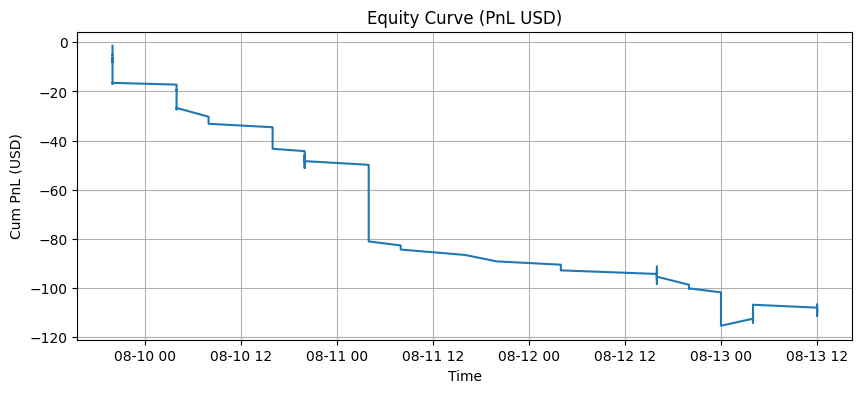

In [ ]:
# -*- coding: utf-8 -*-
# Переписанный скрипт: ограничение — не более одной открытой сделки одновременно по одному символу.

# ================== COLAB SETUP & DOWNLOADS ==================
DOWNLOAD = True  # поставьте False, если все CSV уже лежат в /content
KLINES_CSV = 'klines_data_4h.csv'
SIGNALS_CSV = 'tradingview_signals_real.csv'
SYMBOLS_SETTINGS_CSV = 'symbols_settings_last_update.csv'
SYMBOLS_FILE_ID = None
KLINES_FILE_ID = '1rsU2dMtJauwkrEZ2BR9vhyG_XOoltYVY'
SIGNALS_FILE_ID = '1myLrl6gU3bLytydjo9mYtrq8eJhjSfPm'

try:
    import gdown, pandas as pd, numpy as np, matplotlib.pyplot as plt, os
except Exception:
    !pip -q install gdown
    import gdown, pandas as pd, numpy as np, matplotlib.pyplot as plt, os

if DOWNLOAD:
    if KLINES_CSV and KLINES_FILE_ID:
        gdown.download(id=KLINES_FILE_ID, output=KLINES_CSV, quiet=True)
    if SIGNALS_CSV and SIGNALS_FILE_ID:
        gdown.download(id=SIGNALS_FILE_ID, output=SIGNALS_CSV, quiet=True)
    if SYMBOLS_FILE_ID:
        gdown.download(id=SYMBOLS_FILE_ID, output=SYMBOLS_SETTINGS_CSV, quiet=True)

# ================== PARAMETERS (DEFAULTS) ====================
DEFAULT_ATR_LENGTH = 14
DEFAULT_TAKE1 = 1.5  # ATR multiples
DEFAULT_TAKE2 = 2.5
DEFAULT_STOP = 1.0
DEFAULT_ORDER_SIZE_USD = 100.0
DEFAULT_PORTION = 0.75  # доля частичного выхода на take1
BREAKEVEN_BUMP = 0.001  # ±0.1% как в проде
TIMEFRAME_MINUTES = 240
INTRABAR_RULE = 'stop_first'  # либо 'target_first'

# ================== UTILS ===================================
import math, json
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

def floor_to_timeframe(dt: pd.Series, minutes: int) -> pd.Series:
    return (dt.dt.floor(f"{minutes}T")).dt.tz_convert("UTC") if dt.dt.tz is not None else dt.dt.floor(f"{minutes}T")

def true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr

def wilder_atr(df: pd.DataFrame, length: int) -> pd.Series:
    tr = true_range(df['High'], df['Low'], df['Close'])
    atr = tr.ewm(alpha=1/length, adjust=False).mean()
    return atr

# ================== DATA LOADING ============================
def load_klines(csv_path: str) -> pd.DataFrame:
    k = pd.read_csv(csv_path)
    k['Date'] = pd.to_datetime(k['Date'], utc=True)
    k = k.sort_values(['Symbol', 'Date'])
    return k

def load_signals(csv_path: str) -> pd.DataFrame:
    s = pd.read_csv(csv_path)
    if 'interval' in s.columns and 'timeframe' not in s.columns:
        s = s.rename(columns={'interval': 'timeframe'})
    s['utc_time'] = pd.to_datetime(s['utc_time'], utc=True)
    if 'timeframe' in s.columns:
        s = s[s['timeframe'].astype(str).str.lower().isin(['4h','240'])]
    s['candle_time'] = floor_to_timeframe(s['utc_time'], TIMEFRAME_MINUTES)
    keep = ['symbol','signal','entry_price','utc_time','candle_time','indicators']
    s = s[[c for c in keep if c in s.columns]]
    return s

# ================== SYMBOL PARAMS ===========================
@dataclass
class SymbolParams:
    atr_length: int = DEFAULT_ATR_LENGTH
    take1: float = DEFAULT_TAKE1
    take2: float = DEFAULT_TAKE2
    stop: float = DEFAULT_STOP
    order_size_usd: float = DEFAULT_ORDER_SIZE_USD
    portion: float = DEFAULT_PORTION

def _try_load_symbols_csv(path_primary: str) -> Optional[pd.DataFrame]:
    if os.path.exists(path_primary):
        return pd.read_csv(path_primary)
    alt = 'symbols_settings_update_before_crash.csv'
    if path_primary != alt and os.path.exists(alt):
        print(f"[i] {path_primary} не найден, использую {alt}")
        return pd.read_csv(alt)
    print(f"[!] Не найден файл с настройками символов: {path_primary} (и fallback тоже)")
    return None

def load_symbol_params_from_settings(csv_path: Optional=str):
    params: Dict[str, SymbolParams] = {}
    whitelist: List[str] = []
    if not csv_path:
        return params, whitelist
    df = _try_load_symbols_csv(csv_path)
    if df is None:
        return params, whitelist
    df['symbol'] = df['symbol'].astype(str).str.upper()
    if 'status' in df.columns:
        df = df[df['status'] == 1].copy()
        whitelist = df['symbol'].unique().tolist()
    for _, r in df.iterrows():
        sym = str(r['symbol']).upper()
        params[sym] = SymbolParams(
            atr_length=int(r.get('atr_length', DEFAULT_ATR_LENGTH)),
            take1=float(r.get('take1', DEFAULT_TAKE1)),
            take2=float(r.get('take2', DEFAULT_TAKE2)),
            stop=float(r.get('stop', DEFAULT_STOP)),
            order_size_usd=float(r.get('order_size_usd', DEFAULT_ORDER_SIZE_USD)),
            portion=float(r.get('portion', DEFAULT_PORTION)),
        )
    return params, whitelist

# ================== ENGINE (BTC-фильтр и логика) ============
BUY_SET = {"STRONG_BUY"}
BUY_OK_WITH_BTC = {"STRONG_BUY", "BUY"}
SELL_SET = {"STRONG_SELL"}
SELL_OK_WITH_BTC = {"STRONG_SELL", "SELL"}

def prepare_btc_filter(signals: pd.DataFrame) -> pd.DataFrame:
    btc = signals[signals['symbol'].str.upper() == 'BTCUSDT'].copy()
    btc = btc.sort_values(['candle_time','utc_time']).groupby('candle_time').tail(1)
    btc = btc[['candle_time','signal','utc_time']].rename(columns={'signal':'btc_signal','utc_time':'btc_utc_time'})
    return btc

def attach_btc_filter(signals: pd.DataFrame, btc_df: pd.DataFrame) -> pd.DataFrame:
    merged = signals.merge(btc_df, on='candle_time', how='left')
    merged = merged[merged['symbol'].str.upper() != 'BTCUSDT']
    merged = merged[~merged['btc_utc_time'].isna()]
    return merged

def decision(side_sig: str, btc_sig: str) -> Optional[str]:
    side_sig = (side_sig or '').upper()
    btc_sig = (btc_sig or '').upper()
    if side_sig in BUY_SET and btc_sig in BUY_OK_WITH_BTC:
        return 'BUY'
    if side_sig in SELL_SET and btc_sig in SELL_OK_WITH_BTC:
        return 'SELL'
    return None

# Обновлённая структура результата: добавлены entry_idx и exit_idx (индексы в dataframe k_sym)
from dataclasses import dataclass
from typing import Tuple

@dataclass
class TradeResult:
    symbol: str
    entry_time: pd.Timestamp
    entry_price: float
    side: str
    atr: float
    take1: float
    take2: float
    stop: float
    qty: float
    entry_idx: int
    exit_idx: int
    exit_time: pd.Timestamp
    exit_price: float
    exit_reason: str
    partial_taken: bool
    pnl_usd: float

def compute_levels(side: str, entry: float, atr: float, k1: float, k2: float, ks: float) -> Tuple[float,float,float]:
    if side == 'BUY':
        return entry + atr*k1, entry + atr*k2, entry - atr*ks
    else:
        return entry - atr*k1, entry - atr*k2, entry + atr*ks

def simulate_trade(symbol_df: pd.DataFrame, entry_idx: int, side: str, entry_price: float, atr: float, params: SymbolParams, intrabar_rule: str) -> TradeResult:
    """
    Симуляция сделки, возвращает TradeResult с заполненными entry_idx и exit_idx (индексы в symbol_df).
    entry_idx — индекс бара, с которого мы начинаем отслеживать (бар входа).
    При EOD exit_idx = len(symbol_df)-1
    """
    t1, t2, sl = compute_levels(side, entry_price, atr, params.take1, params.take2, params.stop)
    qty = params.order_size_usd / max(entry_price, 1e-12)
    partial = False
    remaining_qty = qty
    be_stop = None

    # начинаем с entry_idx (вход на этом баре, бар с индексом entry_idx уже следующий после сигнального)
    for i in range(entry_idx, len(symbol_df)):
        row = symbol_df.iloc[i]
        ts, high, low = row['Date'], float(row['High']), float(row['Low'])

        if side == 'BUY':
            # случай когда пока не было частичного тейка
            if not partial:
                stop_hit = low <= sl
                t1_hit = high >= t1

                if stop_hit and t1_hit:
                    # оба срабатывают внутрибара — разрешаем правило intrabar_rule
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (exit_price - entry_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,entry_idx,i,ts,exit_price,'STOP',False,pnl)
                    else:
                        # target_first
                        # считаем, что сначала t1, затем уже стоп — но код в оригинале вел себя иначе:
                        # здесь интерпретируем как сначала частичная фиксация, затем возможно стоп
                        partial = True
                        realized = (t1 - entry_price) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                        t2_hit = high >= t2
                        be_hit = low <= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'STOP_BE',True,pnl)
                        # иначе продолжаем
                if stop_hit:
                    exit_price = sl
                    pnl = (exit_price - entry_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,entry_idx,i,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    # частичный тейк на t1
                    partial = True
                    realized = (t1 - entry_price) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                    t2_hit = high >= t2
                    be_hit = low <= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'STOP_BE',True,pnl)
                    # иначе продолжаем и следим за t2/be_stop в следующих барах
                # если ничего найдено — идём дальше
            else:
                # уже была частичная фиксация
                t2_hit = high >= t2
                be_hit = low <= be_stop if be_stop is not None else False
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'STOP_BE',True,pnl)
                # иначе ждём дальше

        else:  # SELL
            if not partial:
                stop_hit = high >= sl
                t1_hit = low <= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (entry_price - exit_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,entry_idx,i,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (entry_price - t1) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                        t2_hit = low <= t2
                        be_hit = high >= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'STOP_BE',True,pnl)
                if stop_hit:
                    exit_price = sl
                    pnl = (entry_price - exit_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,entry_idx,i,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (entry_price - t1) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                    t2_hit = low <= t2
                    be_hit = high >= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'STOP_BE',True,pnl)
            else:
                t2_hit = low <= t2
                be_hit = high >= be_stop if be_stop is not None else False
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,entry_idx,i,ts,exit_price,'STOP_BE',True,pnl)
                # иначе продолжаем

    # --- Баров не хватило: закрываемся по EOD (используем последнюю цену Close)
    last_idx = len(symbol_df) - 1
    last = symbol_df.iloc[-1]
    exit_price = float(last['Close'])
    if side == 'BUY':
        if not partial:
            pnl_open = (exit_price - entry_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
            stop_print = sl
        else:
            realized = (t1 - entry_price) * (qty * params.portion)
            pnl_open = realized + (exit_price - entry_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
            stop_print = be_stop
    else:
        if not partial:
            pnl_open = (entry_price - exit_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
            stop_print = sl
        else:
            realized = (entry_price - t1) * (qty * params.portion)
            pnl_open = realized + (entry_price - exit_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
            stop_print = be_stop

    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price, side, atr, t1, t2, stop_print, qty, entry_idx, last_idx, last['Date'], exit_price, exit_reason, partial_taken, pnl_open)

# ================== BACKTEST (с лимитом 1 сделки на символ одновременно) ============
def backtest(klines_csv: str, signals_csv: str, symbols_settings_csv: Optional[str] = SYMBOLS_SETTINGS_CSV, intrabar_rule: str = INTRABAR_RULE):
    # --- загрузка
    kdf = load_klines(klines_csv)
    sdf = load_signals(signals_csv)

    # --- индивидуальные параметры + белый список символов
    sym_params_map, whitelist = load_symbol_params_from_settings(symbols_settings_csv)
    whitelist_set = set([s.upper() for s in whitelist])

    # --- BTC фильтр и матчинг
    btc = prepare_btc_filter(sdf)
    s_all = attach_btc_filter(sdf, btc)
    s_all['side'] = [decision(sig, btc_sig) for sig, btc_sig in zip(s_all['signal'], s_all['btc_signal'])]
    s_all = s_all[~s_all['side'].isna()].copy()

    # --- оставляем только символы из списка (если белый список задан)
    if whitelist_set:
        s_all = s_all[s_all['symbol'].str.upper().isin(whitelist_set)].copy()

    # --- подготовка свечей
    kdf['Date'] = pd.to_datetime(kdf['Date'], utc=True)
    kdf = kdf.sort_values(['Symbol','Date'])

    trades: List[TradeResult] = []

    # Проходим по символам; по каждому символу: сигналы хронологически, но не открываем новую сделку пока предыдущая не закрыта
    for sym, s_sym in s_all.groupby('symbol'):
        symU = sym.upper()
        params = sym_params_map.get(symU, SymbolParams())
        k_sym = kdf[kdf['Symbol'].str.upper() == symU].copy()
        if k_sym.empty:
            continue

        k_sym = k_sym.reset_index(drop=True)
        # ATR
        k_sym['ATR'] = wilder_atr(k_sym, params.atr_length)

        # индексный мэп: время -> индекс в k_sym
        idx_map = {pd.Timestamp(ts): i for i, ts in enumerate(k_sym['Date'])}

        # next_available_idx — первый индекс бара, на котором разрешено открыть новую сделку
        next_available_idx = 0

        # сигналы сортируем по времени свечи (candle_time). для каждого сигнала либо открываем сделку, либо пропускаем если
        # предыдущая не закрыта (entry_idx < next_available_idx)
        for _, row in s_sym.sort_values('candle_time').iterrows():
            ct = pd.Timestamp(row['candle_time'])
            if ct not in idx_map:
                continue
            sig_idx = idx_map[ct]
            entry_idx = sig_idx + 1  # вход на следующем баре после сигнального
            if entry_idx >= len(k_sym):
                # нет бара для входа
                continue
            if entry_idx < next_available_idx:
                # уже есть открытая сделка, которая закрывается позже — пропускаем этот сигнал
                continue

            atr = float(k_sym.loc[sig_idx, 'ATR'])
            if not np.isfinite(atr):
                # ATR некорректен
                continue

            entry_price = float(k_sym.loc[entry_idx, 'Open'])
            side = row['side']
            tr = simulate_trade(k_sym, entry_idx, side, entry_price, atr, params, intrabar_rule)
            trades.append(tr)
            # блокируем новые входы до закрытия (exit_idx включительно)
            next_available_idx = tr.exit_idx + 1

    if not trades:
        return pd.DataFrame(), pd.DataFrame()

    tdf = pd.DataFrame([{
        'symbol': t.symbol,
        'entry_time': t.entry_time,
        'entry_price': t.entry_price,
        'side': t.side,
        'atr': t.atr,
        'take1_price': t.take1,
        'take2_price': t.take2,
        'stop_price_initial': t.stop,
        'qty': t.qty,
        'entry_idx': t.entry_idx,
        'exit_idx': t.exit_idx,
        'exit_time': t.exit_time,
        'exit_price': t.exit_price,
        'exit_reason': t.exit_reason,
        'partial_taken': t.partial_taken,
        'pnl_usd': t.pnl_usd,
    } for t in trades])

    tdf = tdf.sort_values('entry_time')
    tdf['cum_pnl_usd'] = tdf['pnl_usd'].cumsum()
    eq = tdf[['entry_time','cum_pnl_usd']].copy()
    return tdf, eq

# ================== RUN ===========================
trades, equity = backtest(KLINES_CSV, SIGNALS_CSV, SYMBOLS_SETTINGS_CSV, INTRABAR_RULE)

from IPython.display import display
print(f"Executed backtest: trades={len(trades)}")
if len(trades):
    display(trades.head(10))

# Метрики
if len(trades):
    wins = (trades['pnl_usd'] > 0).sum()
    losses = (trades['pnl_usd'] <= 0).sum()
    winrate = wins / (wins + losses) if (wins+losses)>0 else np.nan
    gross_profit = trades.loc[trades['pnl_usd']>0, 'pnl_usd'].sum()
    gross_loss = -trades.loc[trades['pnl_usd']<=0, 'pnl_usd'].sum()
    profit_factor = gross_profit / gross_loss if gross_loss>0 else np.inf

    # Max Drawdown по эквити
    eq_curve = equity['cum_pnl_usd'].values if len(equity) else np.array([0.0])
    peaks = np.maximum.accumulate(eq_curve)
    drawdowns = peaks - eq_curve
    max_dd = drawdowns.max() if len(drawdowns) else 0.0

    print("=== METRICS ===")
    print(f"Trades: {len(trades)}")
    print(f"Win rate: {winrate:.2%}")
    print(f"ProfitFactor: {profit_factor:.3f}")
    print(f"Net PnL: {trades['pnl_usd'].sum():.2f} USD")
    print(f"Max DD: {max_dd:.2f} USD")

# Сохранение результатов
trades_path = 'trades.csv'
equity_path = 'equity.csv'
trades.to_csv(trades_path, index=False)
equity.to_csv(equity_path, index=False)
print(f"Saved: {trades_path}, {equity_path}")

# Быстрый график эквити
if len(equity):
    plt.figure(figsize=(10,4))
    plt.plot(equity['entry_time'], equity['cum_pnl_usd'])
    plt.title('Equity Curve (PnL USD)')
    plt.xlabel('Time')
    plt.ylabel('Cum PnL (USD)')
    plt.grid(True)
    plt.show()


### Close to real

In [ ]:
import pandas as pd

symbol_settings = pd.read_csv("symbols_settings_update_before_crash.csv")
symbol_settings_filtered = symbol_settings[symbol_settings['status'] == 1]
symbol_parameters = {
    row['symbol']: (row["stop"], row["portion"], row["take1"], row["take2"])
    for _, row in symbol_settings_filtered.iterrows()
}


/tmp/ipython-input-2035906815.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return (dt.dt.floor(f"{minutes}T")).dt.tz_convert("UTC") if dt.dt.tz is not None else dt.dt.floor(f"{minutes}T")


[i] symbols_settings_last_update.csv не найден, использую symbols_settings_update_before_crash.csv
Executed backtest: trades=108


symbol                entry_time  entry_price side       atr  \
0   1000CATUSDT 2025-08-09 20:00:00+00:00     0.009960  BUY  0.000304   
60    PENGUUSDT 2025-08-09 20:00:00+00:00     0.038611  BUY  0.001443   
54     OMNIUSDT 2025-08-09 20:00:00+00:00     4.860000  BUY  0.199968   
43      LDOUSDT 2025-08-09 20:00:00+00:00     1.326000  BUY  0.039898   
41      KNCUSDT 2025-08-09 20:00:00+00:00     0.456700  BUY  0.007533   
37    JASMYUSDT 2025-08-09 20:00:00+00:00     0.016550  BUY  0.000320   
98    VOXELUSDT 2025-08-09 20:00:00+00:00     0.064400  BUY  0.002396   
29      HFTUSDT 2025-08-09 20:00:00+00:00     0.112200  BUY  0.008000   
79    SUPERUSDT 2025-08-09 20:00:00+00:00     0.799100  BUY  0.017572   
25      FXSUSDT 2025-08-09 20:00:00+00:00     3.167000  BUY  0.103815   

    take1_price  take2_price  stop_price_initial           qty  \
0      0.010719     0.011478            0.009823  10040.160643   
60     0.040414     0.045825            0.038572   2589.935511   
54     5.109960     5.859839            4.770014     20.576132   
43     1.375872     1.525488            1.308046     75.414781   
41     0.466117     0.494367            0.453310    218.962120   
37     0.017271     0.018152            0.016406   6042.296073   
98     0.067394     0.076378            0.063322   1552.795031   
29     0.115800     0.124200            0.112088    891.265597   
79     0.838636     0.886958            0.791193    125.140783   
25     3.296769     3.686077            3.120283     31.575624   

                   exit_time  exit_price exit_reason  partial_taken   pnl_usd  \
0  2025-08-10 04:00:00+00:00    0.009823        STOP          False -1.371325   
60 2025-08-10 04:00:00+00:00    0.038572     STOP_BE           True  0.138545   
54 2025-08-10 00:00:00+00:00    4.770014        STOP          False -1.851554   
43 2025-08-10 00:00:00+00:00    1.308046        STOP          False -1.353994   
41 2025-08-10 00:00:00+00:00    0.453310        STOP          False -0.742296   
37 2025-08-10 04:00:00+00:00    0.016406        STOP          False -0.870950   
98 2025-08-10 04:00:00+00:00    0.063322        STOP          False -1.673942   
29 2025-08-10 00:00:00+00:00    0.112088     STOP_BE           True  1.554317   
79 2025-08-10 04:00:00+00:00    0.791193        STOP          False -0.989517   
25 2025-08-10 04:00:00+00:00    3.120283        STOP          False -1.475115   

    cum_pnl_usd  
0     -1.371325  
60    -1.232781  
54    -3.084335  
43    -4.438329  
41    -5.180625  
37    -6.051575  
98    -7.725517  
29    -6.171199  
79    -7.160717  
25    -8.635832

=== METRICS ===
Trades:       108
Win rate:     22.22%
ProfitFactor: 0.297
Net PnL:      -89.36 USD
Max DD:       97.85 USD
Saved: trades.csv, equity.csv


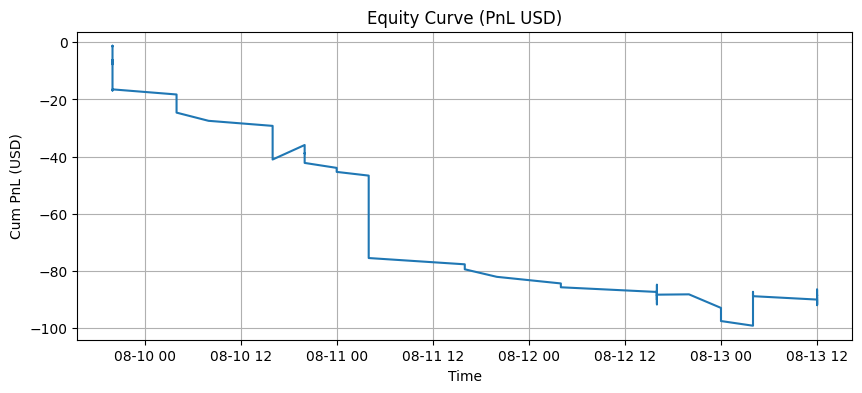

In [ ]:
# Одеа сделка за раз. Не очень точно


# ================== COLAB SETUP & DOWNLOADS ==================
DOWNLOAD = True   # поставьте False, если все CSV уже лежат в /content
KLINES_CSV  = 'klines_data_4h.csv'
SIGNALS_CSV = 'tradingview_signals_real.csv'

# Укажи одно из названий файла с настройками символов:
#   'symbols_settings_last_update.csv'  или  'symbols_settings_update_before_crash.csv'
SYMBOLS_SETTINGS_CSV = 'symbols_settings_last_update.csv'  # если файла нет, скрипт попробует fallback

# Если у тебя есть Google Drive ID для файла с настройками — впиши сюда, иначе оставь None
SYMBOLS_FILE_ID = None  # пример: '1AbCdE....'  -> тогда скачается в SYMBOLS_SETTINGS_CSV

# Файлы из твоего сообщения (Google Drive IDs)
KLINES_FILE_ID  = '1rsU2dMtJauwkrEZ2BR9vhyG_XOoltYVY'
SIGNALS_FILE_ID = '1myLrl6gU3bLytydjo9mYtrq8eJhjSfPm'

try:
    import gdown, pandas as pd, numpy as np, matplotlib.pyplot as plt, os
except Exception:
    !pip -q install gdown
    import gdown, pandas as pd, numpy as np, matplotlib.pyplot as plt, os

if DOWNLOAD:
    if KLINES_CSV and KLINES_FILE_ID:
        gdown.download(id=KLINES_FILE_ID, output=KLINES_CSV, quiet=True)
    if SIGNALS_CSV and SIGNALS_FILE_ID:
        gdown.download(id=SIGNALS_FILE_ID, output=SIGNALS_CSV, quiet=True)
    if SYMBOLS_FILE_ID:
        gdown.download(id=SYMBOLS_FILE_ID, output=SYMBOLS_SETTINGS_CSV, quiet=True)

# ================== PARAMETERS (DEFAULTS) ====================
DEFAULT_ATR_LENGTH = 14
DEFAULT_TAKE1 = 1.5     # ATR multiples
DEFAULT_TAKE2 = 2.5
DEFAULT_STOP  = 1.0
DEFAULT_ORDER_SIZE_USD = 100.0
DEFAULT_PORTION = 0.75  # доля частичного выхода на take1
BREAKEVEN_BUMP = 0.001  # ±0.1% как в проде
TIMEFRAME_MINUTES = 240
INTRABAR_RULE = 'stop_first'   # либо 'target_first'

# ================== UTILS ===================================
import math, json
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

def floor_to_timeframe(dt: pd.Series, minutes: int) -> pd.Series:
    return (dt.dt.floor(f"{minutes}T")).dt.tz_convert("UTC") if dt.dt.tz is not None else dt.dt.floor(f"{minutes}T")

def true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr

def wilder_atr(df: pd.DataFrame, length: int) -> pd.Series:
    tr = true_range(df['High'], df['Low'], df['Close'])
    atr = tr.ewm(alpha=1/length, adjust=False).mean()
    return atr

# ================== DATA LOADING ============================
def load_klines(csv_path: str) -> pd.DataFrame:
    k = pd.read_csv(csv_path)
    k['Date'] = pd.to_datetime(k['Date'], utc=True)
    k = k.sort_values(['Symbol', 'Date'])
    return k

def load_signals(csv_path: str) -> pd.DataFrame:
    s = pd.read_csv(csv_path)
    if 'interval' in s.columns and 'timeframe' not in s.columns:
        s = s.rename(columns={'interval': 'timeframe'})
    s['utc_time'] = pd.to_datetime(s['utc_time'], utc=True)
    if 'timeframe' in s.columns:
        s = s[s['timeframe'].astype(str).str.lower().isin(['4h','240'])]
    s['candle_time'] = floor_to_timeframe(s['utc_time'], TIMEFRAME_MINUTES)
    keep = ['symbol','signal','entry_price','utc_time','candle_time','indicators']
    s = s[[c for c in keep if c in s.columns]]
    return s

# ================== SYMBOL PARAMS ===========================
@dataclass
class SymbolParams:
    atr_length: int = DEFAULT_ATR_LENGTH
    take1: float = DEFAULT_TAKE1
    take2: float = DEFAULT_TAKE2
    stop: float = DEFAULT_STOP
    order_size_usd: float = DEFAULT_ORDER_SIZE_USD
    portion: float = DEFAULT_PORTION

def _try_load_symbols_csv(path_primary: str) -> Optional[pd.DataFrame]:
    if os.path.exists(path_primary):
        return pd.read_csv(path_primary)
    # fallback на альтернативное имя из твоего сообщения
    alt = 'symbols_settings_update_before_crash.csv'
    if path_primary != alt and os.path.exists(alt):
        print(f"[i] {path_primary} не найден, использую {alt}")
        return pd.read_csv(alt)
    print(f"[!] Не найден файл с настройками символов: {path_primary} (и fallback тоже)")
    return None

def load_symbol_params_from_settings(csv_path: Optional=str) -> Dict[str, SymbolParams]:
    """
    Читает твой symbols_settings_*.csv (c колонками: symbol, stop, portion, take1, take2 [, status, atr_length, order_size_usd])
    и возвращает:
        - dict symbol -> SymbolParams
        - а также список whitelist символов (status==1, если колонка присутствует)
    """
    params: Dict[str, SymbolParams] = {}
    whitelist: List[str] = []

    if not csv_path:
        return params, whitelist

    df = _try_load_symbols_csv(csv_path)
    if df is None:
        return params, whitelist

    df['symbol'] = df['symbol'].astype(str).str.upper()

    if 'status' in df.columns:
        df = df[df['status'] == 1].copy()

    whitelist = df['symbol'].unique().tolist()

    for _, r in df.iterrows():
        sym = str(r['symbol']).upper()
        params[sym] = SymbolParams(
            atr_length=int(r.get('atr_length', DEFAULT_ATR_LENGTH)),
            take1=float(r.get('take1', DEFAULT_TAKE1)),
            take2=float(r.get('take2', DEFAULT_TAKE2)),
            stop=float(r.get('stop', DEFAULT_STOP)),
            order_size_usd=float(r.get('order_size_usd', DEFAULT_ORDER_SIZE_USD)),
            portion=float(r.get('portion', DEFAULT_PORTION)),
        )

    return params, whitelist

# ================== ENGINE (BTC-фильтр и логика) ============
BUY_SET = {"STRONG_BUY"}
BUY_OK_WITH_BTC = {"STRONG_BUY", "BUY"}
SELL_SET = {"STRONG_SELL"}
SELL_OK_WITH_BTC = {"STRONG_SELL", "SELL"}

def prepare_btc_filter(signals: pd.DataFrame) -> pd.DataFrame:
    btc = signals[signals['symbol'].str.upper() == 'BTCUSDT'].copy()
    btc = btc.sort_values(['candle_time','utc_time']).groupby('candle_time').tail(1)
    btc = btc[['candle_time','signal','utc_time']].rename(columns={'signal':'btc_signal','utc_time':'btc_utc_time'})
    return btc

def attach_btc_filter(signals: pd.DataFrame, btc_df: pd.DataFrame) -> pd.DataFrame:
    merged = signals.merge(btc_df, on='candle_time', how='left')
    merged = merged[merged['symbol'].str.upper() != 'BTCUSDT']
    merged = merged[~merged['btc_utc_time'].isna()]
    return merged

def decision(side_sig: str, btc_sig: str) -> Optional[str]:
    side_sig = (side_sig or '').upper()
    btc_sig = (btc_sig or '').upper()
    if side_sig in BUY_SET and btc_sig in BUY_OK_WITH_BTC:
        return 'BUY'
    if side_sig in SELL_SET and btc_sig in SELL_OK_WITH_BTC:
        return 'SELL'
    return None

from dataclasses import dataclass
from typing import Tuple

@dataclass
class TradeResult:
    symbol: str
    entry_time: pd.Timestamp
    entry_price: float
    side: str
    atr: float
    take1: float
    take2: float
    stop: float
    qty: float
    exit_time: pd.Timestamp
    exit_price: float
    exit_reason: str
    partial_taken: bool
    pnl_usd: float

def compute_levels(side: str, entry: float, atr: float, k1: float, k2: float, ks: float) -> Tuple[float,float,float]:
    if side == 'BUY':
        return entry + atr*k1, entry + atr*k2, entry - atr*ks
    else:
        return entry - atr*k1, entry - atr*k2, entry + atr*ks

def simulate_trade(symbol_df: pd.DataFrame, entry_idx: int, side: str, entry_price: float,
                   atr: float, params: SymbolParams, intrabar_rule: str) -> TradeResult:
    t1, t2, sl = compute_levels(side, entry_price, atr, params.take1, params.take2, params.stop)
    qty = params.order_size_usd / max(entry_price, 1e-12)
    partial = False
    remaining_qty = qty
    be_stop = None

    for i in range(entry_idx, len(symbol_df)):
        row = symbol_df.iloc[i]
        ts, high, low = row['Date'], float(row['High']), float(row['Low'])

        if side == 'BUY':
            if not partial:
                stop_hit = low <= sl
                t1_hit = high >= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (exit_price - entry_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (t1 - entry_price) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                        t2_hit = high >= t2
                        be_hit = low <= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (exit_price - entry_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (t1 - entry_price) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                    t2_hit = high >= t2
                    be_hit = low <= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = high >= t2
                be_hit = low <= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
        else:
            if not partial:
                stop_hit = high >= sl
                t1_hit = low <= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (entry_price - exit_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (entry_price - t1) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                        t2_hit = low <= t2
                        be_hit = high >= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (entry_price - exit_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (entry_price - t1) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                    t2_hit = low <= t2
                    be_hit = high >= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = low <= t2
                be_hit = high >= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)

    # --- Баров не хватило: закрываемся по EOD (важно: используем ИНДИВИДУАЛЬНУЮ portion, а не дефолт)
    last = symbol_df.iloc[-1]
    exit_price = float(last['Close'])
    if side == 'BUY':
        if not partial:
            pnl_open = (exit_price - entry_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
            stop_print = sl
        else:
            realized = (t1 - entry_price) * (qty * params.portion)
            pnl_open = realized + (exit_price - entry_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
            stop_print = be_stop
    else:
        if not partial:
            pnl_open = (entry_price - exit_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
            stop_print = sl
        else:
            realized = (entry_price - t1) * (qty * params.portion)
            pnl_open = realized + (entry_price - exit_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
            stop_print = be_stop

    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price, side, atr,
                       t1, t2, stop_print, qty,
                       last['Date'], exit_price, exit_reason, partial_taken, pnl_open)

def backtest(klines_csv: str, signals_csv: str,
             symbols_settings_csv: Optional[str] = SYMBOLS_SETTINGS_CSV,
             intrabar_rule: str = INTRABAR_RULE):
    # --- загрузка
    kdf = load_klines(klines_csv)
    sdf = load_signals(signals_csv)

    # --- индивидуальные параметры + белый список символов
    sym_params_map, whitelist = load_symbol_params_from_settings(symbols_settings_csv)
    whitelist_set = set([s.upper() for s in whitelist])

    # --- BTC фильтр и матчинг
    btc = prepare_btc_filter(sdf)
    s_all = attach_btc_filter(sdf, btc)
    s_all['side'] = [decision(sig, btc_sig) for sig, btc_sig in zip(s_all['signal'], s_all['btc_signal'])]
    s_all = s_all[~s_all['side'].isna()].copy()

    # --- оставляем только символы из твоего списка (status==1)
    if whitelist_set:
        s_all = s_all[s_all['symbol'].str.upper().isin(whitelist_set)].copy()

    # --- подготовка свечей
    kdf['Date'] = pd.to_datetime(kdf['Date'], utc=True)
    kdf = kdf.sort_values(['Symbol','Date'])

    trades: List[TradeResult] = []

    for sym, s_sym in s_all.groupby('symbol'):
        symU = sym.upper()
        params = sym_params_map.get(symU, SymbolParams())  # если нет — используем дефолт
        k_sym = kdf[kdf['Symbol'].str.upper() == symU].copy()
        if k_sym.empty:
            continue

        # ATR по индивидуальной длине
        k_sym['ATR'] = wilder_atr(k_sym, params.atr_length)
        k_sym = k_sym.reset_index(drop=True)

        # мэп индексов по времени свечи (в CSV Date=время открытия бара)
        idx_map = {pd.Timestamp(ts): i for i, ts in enumerate(k_sym['Date'])}

        # сортируем сигналы по времени
        s_sorted = s_sym.sort_values('candle_time')

        last_exit_time = None  # сюда будем записывать время выхода из последнего трейда

        for _, row in s_sorted.iterrows():
            ct = pd.Timestamp(row['candle_time'])
            if ct not in idx_map:
                continue
            idx = idx_map[ct]
            if idx+1 >= len(k_sym):
                continue

            # не даём открыть новую сделку, пока предыдущая ещё "в рынке"
            if last_exit_time is not None and ct <= last_exit_time:
                continue

            atr = float(k_sym.loc[idx, 'ATR'])
            if not np.isfinite(atr):
                continue

            entry_price = float(k_sym.loc[idx+1, 'Open'])
            side = row['side']

            tr = simulate_trade(k_sym, idx+1, side, entry_price, atr, params, intrabar_rule)
            trades.append(tr)

            # фиксируем, что новая сделка по этому символу возможна только ПОСЛЕ её выхода
            last_exit_time = tr.exit_time

    if not trades:
        return pd.DataFrame(), pd.DataFrame()

    tdf = pd.DataFrame([{
        'symbol': t.symbol,
        'entry_time': t.entry_time,
        'entry_price': t.entry_price,
        'side': t.side,
        'atr': t.atr,
        'take1_price': t.take1,
        'take2_price': t.take2,
        'stop_price_initial': t.stop,
        'qty': t.qty,
        'exit_time': t.exit_time,
        'exit_price': t.exit_price,
        'exit_reason': t.exit_reason,
        'partial_taken': t.partial_taken,
        'pnl_usd': t.pnl_usd,
    } for t in trades])

    tdf = tdf.sort_values('entry_time')
    tdf['cum_pnl_usd'] = tdf['pnl_usd'].cumsum()

    eq = tdf[['entry_time','cum_pnl_usd']].copy()
    return tdf, eq


# ================== RUN ===========================
trades, equity = backtest(KLINES_CSV, SIGNALS_CSV, SYMBOLS_SETTINGS_CSV, INTRABAR_RULE)

from IPython.display import display
print(f"Executed backtest: trades={len(trades)}")
if len(trades):
    display(trades.head(10))

# Метрики
if len(trades):
    wins = (trades['pnl_usd'] > 0).sum()
    losses = (trades['pnl_usd'] <= 0).sum()
    winrate = wins / (wins + losses) if (wins+losses)>0 else np.nan
    gross_profit = trades.loc[trades['pnl_usd']>0, 'pnl_usd'].sum()
    gross_loss   = -trades.loc[trades['pnl_usd']<=0, 'pnl_usd'].sum()
    profit_factor = gross_profit / gross_loss if gross_loss>0 else np.inf

    # Max Drawdown по эквити
    eq_curve = equity['cum_pnl_usd'].values if len(equity) else np.array([0.0])
    peaks = np.maximum.accumulate(eq_curve)
    drawdowns = peaks - eq_curve
    max_dd = drawdowns.max() if len(drawdowns) else 0.0

    print("=== METRICS ===")
    print(f"Trades:       {len(trades)}")
    print(f"Win rate:     {winrate:.2%}")
    print(f"ProfitFactor: {profit_factor:.3f}")
    print(f"Net PnL:      {trades['pnl_usd'].sum():.2f} USD")
    print(f"Max DD:       {max_dd:.2f} USD")

# Сохранение результатов
trades_path = 'trades.csv'
equity_path = 'equity.csv'
trades.to_csv(trades_path, index=False)
equity.to_csv(equity_path, index=False)
print(f"Saved: {trades_path}, {equity_path}")

# Быстрый график эквити
if len(equity):
    plt.figure(figsize=(10,4))
    plt.plot(equity['entry_time'], equity['cum_pnl_usd'])
    plt.title('Equity Curve (PnL USD)')
    plt.xlabel('Time')
    plt.ylabel('Cum PnL (USD)')
    plt.grid(True)
    plt.show()


[i] Loading data...


/tmp/ipython-input-1665636181.py:91: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  floored = dt_series.dt.tz_convert('UTC').dt.floor(f"{minutes}T")


[i] Signals loaded: 16971 rows after dedup


/tmp/ipython-input-1665636181.py:91: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  floored = dt_series.dt.tz_convert('UTC').dt.floor(f"{minutes}T")


[diag] Raw file duplicate symbol/candle occurrences: 0
[i] symbols_settings_last_update.csv not found, using fallback symbols_settings_update_before_crash.csv
[i] Symbols with signals after BTC filter & whitelist: 44
[warn] No klines for LOKAUSDT — skipping

Executed backtest: trades_count=108


symbol                entry_time  entry_price side       atr  \
0  1000CATUSDT 2025-08-09 20:00:00+00:00     0.009960  BUY  0.000304   
1    PENGUUSDT 2025-08-09 20:00:00+00:00     0.038611  BUY  0.001443   
2     OMNIUSDT 2025-08-09 20:00:00+00:00     4.860000  BUY  0.199968   
3      LDOUSDT 2025-08-09 20:00:00+00:00     1.326000  BUY  0.039898   
4      KNCUSDT 2025-08-09 20:00:00+00:00     0.456700  BUY  0.007533   
5    JASMYUSDT 2025-08-09 20:00:00+00:00     0.016550  BUY  0.000320   
6    VOXELUSDT 2025-08-09 20:00:00+00:00     0.064400  BUY  0.002396   
7      HFTUSDT 2025-08-09 20:00:00+00:00     0.112200  BUY  0.008000   
8    SUPERUSDT 2025-08-09 20:00:00+00:00     0.799100  BUY  0.017572   
9      FXSUSDT 2025-08-09 20:00:00+00:00     3.167000  BUY  0.103815   

   take1_price  take2_price  stop_price_initial           qty  \
0     0.010719     0.011478            0.009823  10040.160643   
1     0.040414     0.045825            0.038572   2589.935511   
2     5.109960     5.859839            4.770014     20.576132   
3     1.375872     1.525488            1.308046     75.414781   
4     0.466117     0.494367            0.453310    218.962120   
5     0.017271     0.018152            0.016406   6042.296073   
6     0.067394     0.076378            0.063322   1552.795031   
7     0.115800     0.124200            0.112088    891.265597   
8     0.838636     0.886958            0.791193    125.140783   
9     3.296769     3.686077            3.120283     31.575624   

                  exit_time  exit_price exit_reason  partial_taken   pnl_usd  \
0 2025-08-10 04:00:00+00:00    0.009823        STOP          False -1.371325   
1 2025-08-10 04:00:00+00:00    0.038572     STOP_BE           True  0.138545   
2 2025-08-10 00:00:00+00:00    4.770014        STOP          False -1.851554   
3 2025-08-10 00:00:00+00:00    1.308046        STOP          False -1.353994   
4 2025-08-10 00:00:00+00:00    0.453310        STOP          False -0.742296   
5 2025-08-10 04:00:00+00:00    0.016406        STOP          False -0.870950   
6 2025-08-10 04:00:00+00:00    0.063322        STOP          False -1.673942   
7 2025-08-10 00:00:00+00:00    0.112088     STOP_BE           True  1.554317   
8 2025-08-10 04:00:00+00:00    0.791193        STOP          False -0.989517   
9 2025-08-10 04:00:00+00:00    3.120283        STOP          False -1.475115   

   cum_pnl_usd  
0    -1.371325  
1    -1.232781  
2    -3.084335  
3    -4.438329  
4    -5.180625  
5    -6.051575  
6    -7.725517  
7    -6.171199  
8    -7.160717  
9    -8.635832

=== METRICS ===
Trades:       108
Win rate:     22.22%
ProfitFactor: 0.297
Net PnL:      -89.36 USD
Max DD:       97.85 USD
Saved: trades.csv, equity.csv


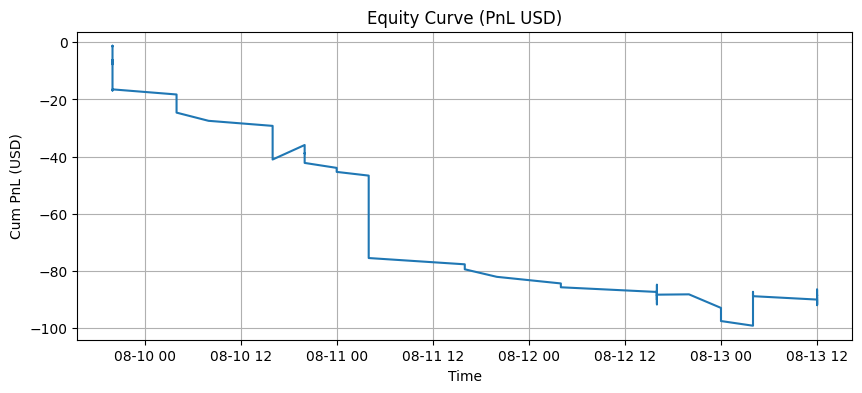

In [ ]:
# -*- coding: utf-8 -*-
"""
Полностью рабочий бэктестер (4h) — улучшенная и исправленная версия.
Запуск в Colab: выставь DOWNLOAD=True и укажи Google Drive IDs вверху.
"""

# ================ CONFIG / DOWNLOAD ====================
DOWNLOAD = False   # True -> попытается скачать KLINES_CSV и SIGNALS_CSV через gdown
KLINES_CSV  = 'klines_data_4h.csv'
SIGNALS_CSV = 'tradingview_signals_real.csv'
SYMBOLS_SETTINGS_CSV = 'symbols_settings_last_update.csv'
# Если есть Google Drive IDs — вставь их
KLINES_FILE_ID  = None
SIGNALS_FILE_ID = None
SYMBOLS_FILE_ID = None

# Поведение бэктестера
TIMEFRAME_MINUTES = 240
INTRABAR_RULE = 'stop_first'   # 'stop_first' или 'target_first' — как обрабатывать одно-баровые конфликты
ENTRY_MODE = 'next_open'       # 'next_open' или 'market_now' (market_now ~ close сигнальной свечи)
ALLOW_PARALLEL_TRADES = False  # False — не открывать новую сделку по символу пока старая не закрыта (как в твоём бэктесте)
BREAKEVEN_BUMP = 0.001         # ±0.1% (как в prod)
DEFAULT_ATR_LENGTH = 14
DEFAULT_TAKE1 = 1.5
DEFAULT_TAKE2 = 2.5
DEFAULT_STOP  = 1.0
DEFAULT_ORDER_SIZE_USD = 100.0
DEFAULT_PORTION = 0.75
INTRABAR_RULE = INTRABAR_RULE

# ================ IMPORTS ====================
import os
import math
import json
from decimal import Decimal, ROUND_HALF_UP, ROUND_FLOOR, ROUND_CEILING, getcontext
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# optional download
if DOWNLOAD:
    try:
        import gdown
    except Exception:
        !pip -q install gdown
        import gdown

    if KLINES_FILE_ID:
        gdown.download(id=KLINES_FILE_ID, output=KLINES_CSV, quiet=True)
    if SIGNALS_FILE_ID:
        gdown.download(id=SIGNALS_FILE_ID, output=SIGNALS_CSV, quiet=True)
    if SYMBOLS_FILE_ID:
        gdown.download(id=SYMBOLS_FILE_ID, output=SYMBOLS_SETTINGS_CSV, quiet=True)

# Decimal precision for rounding
getcontext().prec = 28

# ================ HELPERS: rounding, time ====================
def decimal_quantize(val: float, quantum: float, rounding_mode) -> float:
    """Quantize value to multiple of quantum using Decimal."""
    if quantum is None or quantum == 0:
        return float(val)
    q = Decimal(str(quantum))
    v = Decimal(str(val))
    # divide v by q, round to integer, multiply back
    return float((v / q).to_integral_value(rounding=rounding_mode) * q)

def round_down_to_step(x: float, step: float) -> float:
    if step is None or step <= 0:
        return float(x)
    return decimal_quantize(x, step, ROUND_FLOOR)

def round_up_to_step(x: float, step: float) -> float:
    if step is None or step <= 0:
        return float(x)
    return decimal_quantize(x, step, ROUND_CEILING)

def quantize_price_nearest(x: float, tick: float) -> float:
    if tick is None or tick <= 0:
        return float(x)
    return float(Decimal(str(x)).quantize(Decimal(str(tick)), rounding=ROUND_HALF_UP))

def floor_to_timeframe(dt_series: pd.Series, minutes: int) -> pd.Series:
    # dt_series expected to be tz-aware or naive; return tz-aware UTC
    if dt_series.dt.tz is None:
        floored = dt_series.dt.floor(f"{minutes}T")
        return floored.dt.tz_localize('UTC')
    else:
        floored = dt_series.dt.tz_convert('UTC').dt.floor(f"{minutes}T")
        return floored

# ================ ATR ====================
def true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr

def wilder_atr(df: pd.DataFrame, length: int) -> pd.Series:
    tr = true_range(df['High'], df['Low'], df['Close'])
    atr = tr.ewm(alpha=1/length, adjust=False).mean()
    return atr

# ================ LOAD DATA ====================
def load_klines(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Klines CSV not found: {csv_path}")
    k = pd.read_csv(csv_path)
    if 'Date' not in k.columns:
        raise ValueError("Klines CSV must contain 'Date' column")
    k['Date'] = pd.to_datetime(k['Date'], utc=True)
    # Required columns: Date,Open,High,Low,Close,Volume,Symbol
    expected = ['Date','Open','High','Low','Close','Volume','Symbol']
    for col in expected:
        if col not in k.columns:
            raise ValueError(f"Klines CSV missing column: {col}")
    k = k.sort_values(['Symbol','Date']).reset_index(drop=True)
    return k

def load_signals(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Signals CSV not found: {csv_path}")
    s = pd.read_csv(csv_path)
    # Normalize timeframe column
    if 'interval' in s.columns and 'timeframe' not in s.columns:
        s = s.rename(columns={'interval': 'timeframe'})
    # Parse utc_time
    if 'utc_time' not in s.columns:
        raise ValueError("Signals CSV must contain 'utc_time' column")
    s['utc_time'] = pd.to_datetime(s['utc_time'], utc=True)
    # Filter timeframe to 4h / 240 if present
    if 'timeframe' in s.columns:
        # normalize to string and lowercase
        s['timeframe'] = s['timeframe'].astype(str).str.lower()
        s = s[s['timeframe'].isin(['4h', '240'])].copy()
    # compute candle_time floored to timeframe
    s['candle_time'] = floor_to_timeframe(s['utc_time'], TIMEFRAME_MINUTES)
    # Deduplicate: keep only LAST signal inside one candle for a symbol (prod behaviour: single read)
    if len(s):
        s = s.sort_values(['symbol','candle_time','utc_time']).groupby(['symbol','candle_time'], as_index=False).tail(1).reset_index(drop=True)
    # Keep necessary columns if present
    keep = ['symbol','signal','entry_price','utc_time','candle_time','indicators','timeframe']
    keep_existing = [c for c in keep if c in s.columns]
    s = s[keep_existing].copy()
    # Normalize symbol casing
    s['symbol'] = s['symbol'].astype(str).str.upper()
    return s

# ================ SYMBOL SETTINGS ====================
@dataclass
class SymbolParams:
    atr_length: int = DEFAULT_ATR_LENGTH
    take1: float = DEFAULT_TAKE1
    take2: float = DEFAULT_TAKE2
    stop: float = DEFAULT_STOP
    order_size_usd: float = DEFAULT_ORDER_SIZE_USD
    portion: float = DEFAULT_PORTION
    # exchange specifics (optional — can be present in CSV)
    step_size: float = 0.00000001
    tick_size: float = 0.01
    min_qty: float = 0.0
    notional: float = 0.0

def _try_load_symbols_csv(path_primary: str) -> Optional[pd.DataFrame]:
    if path_primary and os.path.exists(path_primary):
        return pd.read_csv(path_primary)
    alt = 'symbols_settings_update_before_crash.csv'
    if os.path.exists(alt):
        print(f"[i] {path_primary} not found, using fallback {alt}")
        return pd.read_csv(alt)
    print(f"[!] Symbol settings not found: {path_primary}")
    return None

def load_symbol_params_from_settings(csv_path: Optional[str]) -> Tuple[Dict[str, SymbolParams], List[str]]:
    params: Dict[str, SymbolParams] = {}
    whitelist: List[str] = []
    if not csv_path:
        return params, whitelist
    df = _try_load_symbols_csv(csv_path)
    if df is None:
        return params, whitelist
    df['symbol'] = df['symbol'].astype(str).str.upper()
    if 'status' in df.columns:
        df = df[df['status'] == 1].copy()
    whitelist = df['symbol'].unique().tolist()
    for _, r in df.iterrows():
        sym = str(r['symbol']).upper()
        params[sym] = SymbolParams(
            atr_length=int(r.get('atr_length', DEFAULT_ATR_LENGTH)),
            take1=float(r.get('take1', DEFAULT_TAKE1)),
            take2=float(r.get('take2', DEFAULT_TAKE2)),
            stop=float(r.get('stop', DEFAULT_STOP)),
            order_size_usd=float(r.get('order_size_usd', DEFAULT_ORDER_SIZE_USD)),
            portion=float(r.get('portion', DEFAULT_PORTION)),
            step_size=float(r.get('step_size', 1e-8)) if 'step_size' in r and not pd.isna(r.get('step_size')) else 1e-8,
            tick_size=float(r.get('tick_size', 0.01)) if 'tick_size' in r and not pd.isna(r.get('tick_size')) else 0.01,
            min_qty=float(r.get('min_qty', 0.0)) if 'min_qty' in r and not pd.isna(r.get('min_qty')) else 0.0,
            notional=float(r.get('notional', 0.0)) if 'notional' in r and not pd.isna(r.get('notional')) else 0.0,
        )
    return params, whitelist

# ================ BTC FILTER and decision ====================
BUY_SET = {"STRONG_BUY"}
BUY_OK_WITH_BTC = {"STRONG_BUY", "BUY"}
SELL_SET = {"STRONG_SELL"}
SELL_OK_WITH_BTC = {"STRONG_SELL", "SELL"}

def prepare_btc_filter(signals: pd.DataFrame) -> pd.DataFrame:
    btc = signals[signals['symbol'].str.upper() == 'BTCUSDT'].copy()
    if btc.empty:
        return pd.DataFrame(columns=['candle_time','btc_signal','btc_utc_time'])
    btc = btc.sort_values(['candle_time','utc_time']).groupby('candle_time').tail(1)
    btc = btc[['candle_time','signal','utc_time']].rename(columns={'signal':'btc_signal','utc_time':'btc_utc_time'})
    return btc

def attach_btc_filter(signals: pd.DataFrame, btc_df: pd.DataFrame) -> pd.DataFrame:
    merged = signals.merge(btc_df, on='candle_time', how='left')
    merged = merged[merged['symbol'].str.upper() != 'BTCUSDT']
    merged = merged[~merged['btc_utc_time'].isna()]  # if btc missing — drop (prod skips)
    return merged

def decision(side_sig: str, btc_sig: str) -> Optional[str]:
    side_sig = (side_sig or '').upper()
    btc_sig = (btc_sig or '').upper()
    if side_sig in BUY_SET and btc_sig in BUY_OK_WITH_BTC:
        return 'BUY'
    if side_sig in SELL_SET and btc_sig in SELL_OK_WITH_BTC:
        return 'SELL'
    return None

# ================ TRADE SIMULATION ====================
@dataclass
class TradeResult:
    symbol: str
    entry_time: pd.Timestamp
    entry_price: float
    side: str
    atr: float
    take1: float
    take2: float
    stop: float
    qty: float
    exit_time: pd.Timestamp
    exit_price: float
    exit_reason: str
    partial_taken: bool
    pnl_usd: float

def compute_levels(side: str, entry: float, atr: float, k1: float, k2: float, ks: float) -> Tuple[float,float,float]:
    if side == 'BUY':
        return entry + atr*k1, entry + atr*k2, entry - atr*ks
    else:
        return entry - atr*k1, entry - atr*k2, entry + atr*ks

def simulate_trade(symbol_df: pd.DataFrame, entry_idx: int, side: str, entry_price: float,
                   atr: float, params: SymbolParams, intrabar_rule: str) -> TradeResult:
    """
    Симуляция одной сделки начиная с индекса entry_idx (включая этот бар).
    entry_idx — индекс свечи, где выполняется рынок (open of this bar).
    """
    t1, t2, sl = compute_levels(side, entry_price, atr, params.take1, params.take2, params.stop)
    # quantity calc with rounding, min_notional enforcement
    raw_qty = params.order_size_usd / max(entry_price, 1e-12)
    qty = round_down_to_step(raw_qty, params.step_size)
    if params.notional and qty * entry_price < params.notional * 1.1:
        qty = round_up_to_step((params.notional * 1.1) / entry_price, params.step_size)
    if params.min_qty and qty < params.min_qty:
        qty = params.min_qty
    # guard
    if qty <= 0 or not math.isfinite(qty):
        # produce zero-size trade result (should be skipped by caller)
        return TradeResult(symbol_df['Symbol'].iat[0], pd.NaT, entry_price, side, atr, t1, t2, sl, 0.0, pd.NaT, 0.0, 'BAD_QTY', False, 0.0)

    partial = False
    remaining_qty = qty
    be_stop = None

    # iterate bars from entry_idx to end (entry indexing consistent with backtest main)
    for i in range(entry_idx, len(symbol_df)):
        row = symbol_df.iloc[i]
        ts, high, low = row['Date'], float(row['High']), float(row['Low'])

        if side == 'BUY':
            if not partial:
                stop_hit = low <= sl
                t1_hit = high >= t1
                if stop_hit and t1_hit:
                    # conflict inside single bar: decide by rule
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (exit_price - entry_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        # target first -> partial then maybe take2 or BE
                        partial = True
                        realized = (t1 - entry_price) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                        t2_hit = high >= t2
                        be_hit = low <= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (exit_price - entry_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (t1 - entry_price) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 - BREAKEVEN_BUMP)
                    t2_hit = high >= t2
                    be_hit = low <= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                # after partial: wait for take2 or be_stop
                t2_hit = high >= t2
                be_hit = low <= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)

        else:  # SELL side (mirror)
            if not partial:
                stop_hit = high >= sl
                t1_hit = low <= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (entry_price - exit_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (entry_price - t1) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                        t2_hit = low <= t2
                        be_hit = high >= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (entry_price - exit_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (entry_price - t1) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 + BREAKEVEN_BUMP)
                    t2_hit = low <= t2
                    be_hit = high >= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = low <= t2
                be_hit = high >= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)

    # --- если до конца истории не закрылись: exit по последнему Close (EOD)
    last = symbol_df.iloc[-1]
    exit_price = float(last['Close'])
    if side == 'BUY':
        if not partial:
            pnl_open = (exit_price - entry_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
            stop_print = sl
        else:
            realized = (t1 - entry_price) * (qty * params.portion)
            pnl_open = realized + (exit_price - entry_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
            stop_print = be_stop
    else:
        if not partial:
            pnl_open = (entry_price - exit_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
            stop_print = sl
        else:
            realized = (entry_price - t1) * (qty * params.portion)
            pnl_open = realized + (entry_price - exit_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
            stop_print = be_stop

    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price, side, atr,
                       t1, t2, stop_print, qty,
                       last['Date'], exit_price, exit_reason, partial_taken, pnl_open)

# ================ BACKTEST ENGINE ====================
def backtest(klines_csv: str, signals_csv: str, symbols_settings_csv: Optional[str] = SYMBOLS_SETTINGS_CSV,
             intrabar_rule: str = INTRABAR_RULE, entry_mode: str = ENTRY_MODE,
             allow_parallel: bool = ALLOW_PARALLEL_TRADES):
    print("[i] Loading data...")
    kdf = load_klines(klines_csv)
    sdf = load_signals(signals_csv)

    print(f"[i] Signals loaded: {len(sdf)} rows after dedup")
    # diagnostics: duplicates before dedup (if raw file used)
    try:
        raw = pd.read_csv(signals_csv)
        raw['utc_time'] = pd.to_datetime(raw['utc_time'], utc=True)
        raw['candle_time'] = floor_to_timeframe(raw['utc_time'], TIMEFRAME_MINUTES)
        dup_counts = raw.groupby(['symbol','candle_time']).size().reset_index(name='cnt')
        mult = dup_counts[dup_counts['cnt']>1].shape[0]
        print(f"[diag] Raw file duplicate symbol/candle occurrences: {mult}")
    except Exception:
        pass

    # load symbol params and whitelist
    sym_params_map, whitelist = load_symbol_params_from_settings(symbols_settings_csv)
    whitelist_set = set([s.upper() for s in whitelist])

    # prepare BTC filter and attach
    btc = prepare_btc_filter(sdf)
    s_all = attach_btc_filter(sdf, btc)
    if s_all.empty:
        print("[warn] No signals after attaching BTC filter — aborting.")
        return pd.DataFrame(), pd.DataFrame()

    s_all['side'] = [decision(sig, btc_sig) for sig, btc_sig in zip(s_all['signal'], s_all['btc_signal'])]
    s_all = s_all[~s_all['side'].isna()].copy()

    # apply whitelist if present
    if whitelist_set:
        s_all = s_all[s_all['symbol'].str.upper().isin(whitelist_set)].copy()

    # prepare klines
    kdf['Date'] = pd.to_datetime(kdf['Date'], utc=True)
    kdf = kdf.sort_values(['Symbol','Date']).reset_index(drop=True)

    trades: List[TradeResult] = []
    symbols = s_all['symbol'].unique().tolist()
    print(f"[i] Symbols with signals after BTC filter & whitelist: {len(symbols)}")

    for sym in symbols:
        symU = sym.upper()
        params = sym_params_map.get(symU, SymbolParams())
        k_sym = kdf[kdf['Symbol'].str.upper() == symU].copy()
        if k_sym.empty:
            print(f"[warn] No klines for {symU} — skipping")
            continue

        # ATR
        k_sym = k_sym.reset_index(drop=True)
        k_sym['ATR'] = wilder_atr(k_sym, params.atr_length)

        # mapping date -> index
        idx_map = {pd.Timestamp(ts): i for i, ts in enumerate(k_sym['Date'])}

        s_sorted = s_all[s_all['symbol'].str.upper() == symU].sort_values('candle_time')
        last_exit_time = None

        for _, row in s_sorted.iterrows():
            ct = pd.Timestamp(row['candle_time'])
            if ct not in idx_map:
                # signal's candle_time not present in klines — skip
                continue
            idx = idx_map[ct]
            # insures we have at least one bar ahead to take entry (entry uses idx or idx+1 depending on mode)
            if entry_mode == 'next_open':
                if idx + 1 >= len(k_sym):
                    continue
                entry_idx = idx + 1
                entry_price = float(k_sym.loc[entry_idx, 'Open'])
            else:  # market_now => use close of current bar (approx market price at signal)
                entry_idx = idx
                entry_price = float(k_sym.loc[idx, 'Close'])

            # prevent overlapping trades if configured
            if not allow_parallel and last_exit_time is not None and ct <= last_exit_time:
                # skip until previous trade exit happened
                continue

            atr = float(k_sym.loc[idx, 'ATR'])
            if not np.isfinite(atr):
                # skip if ATR NaN
                continue

            side = row['side']
            tr = simulate_trade(k_sym, entry_idx, side, entry_price, atr, params, intrabar_rule)
            # skip bad qty trades
            if tr.qty <= 0 or tr.entry_time is pd.NaT:
                continue
            trades.append(tr)
            last_exit_time = tr.exit_time

    if not trades:
        print("[i] No trades simulated.")
        return pd.DataFrame(), pd.DataFrame()

    tdf = pd.DataFrame([{
        'symbol': t.symbol,
        'entry_time': t.entry_time,
        'entry_price': t.entry_price,
        'side': t.side,
        'atr': t.atr,
        'take1_price': t.take1,
        'take2_price': t.take2,
        'stop_price_initial': t.stop,
        'qty': t.qty,
        'exit_time': t.exit_time,
        'exit_price': t.exit_price,
        'exit_reason': t.exit_reason,
        'partial_taken': t.partial_taken,
        'pnl_usd': t.pnl_usd,
    } for t in trades])

    tdf = tdf.sort_values('entry_time').reset_index(drop=True)
    tdf['cum_pnl_usd'] = tdf['pnl_usd'].cumsum()

    equity = tdf[['entry_time','cum_pnl_usd']].copy()
    return tdf, equity

# ================ RUN ====================
if __name__ == "__main__":
    trades, equity = backtest(KLINES_CSV, SIGNALS_CSV, SYMBOLS_SETTINGS_CSV, INTRABAR_RULE, ENTRY_MODE, ALLOW_PARALLEL_TRADES)

    print(f"\nExecuted backtest: trades_count={len(trades)}")
    if len(trades):
        display = getattr(__import__('IPython.display', fromlist=['display']), 'display')
        display(trades.head(10))

        # Metrics
        wins = (trades['pnl_usd'] > 0).sum()
        losses = (trades['pnl_usd'] <= 0).sum()
        winrate = wins / (wins + losses) if (wins+losses)>0 else np.nan
        gross_profit = trades.loc[trades['pnl_usd']>0, 'pnl_usd'].sum()
        gross_loss   = -trades.loc[trades['pnl_usd']<=0, 'pnl_usd'].sum()
        profit_factor = gross_profit / gross_loss if gross_loss>0 else np.inf

        eq_curve = equity['cum_pnl_usd'].values if len(equity) else np.array([0.0])
        peaks = np.maximum.accumulate(eq_curve)
        drawdowns = peaks - eq_curve
        max_dd = drawdowns.max() if len(drawdowns) else 0.0

        print("=== METRICS ===")
        print(f"Trades:       {len(trades)}")
        print(f"Win rate:     {winrate:.2%}")
        print(f"ProfitFactor: {profit_factor:.3f}")
        print(f"Net PnL:      {trades['pnl_usd'].sum():.2f} USD")
        print(f"Max DD:       {max_dd:.2f} USD")

        # save CSVs
        trades.to_csv('trades.csv', index=False)
        equity.to_csv('equity.csv', index=False)
        print("Saved: trades.csv, equity.csv")

        # Quick equity plot
        if len(equity):
            plt.figure(figsize=(10,4))
            plt.plot(equity['entry_time'], equity['cum_pnl_usd'])
            plt.title('Equity Curve (PnL USD)')
            plt.xlabel('Time')
            plt.ylabel('Cum PnL (USD)')
            plt.grid(True)
            plt.show()
    else:
        print("[i] No trades produced by backtest.")


In [ ]:
# -*- coding: utf-8 -*-
"""
Backtester (4h) — расширенная версия, эмулирующая продакшен-бота.
Скопировать и запустить в Colab / локально. Настройки в разделе CONFIG.
"""

# ================== CONFIG ==================
DOWNLOAD = False   # True -> попытка скачать через gdown, если заданы FILE_IDs
KLINES_CSV  = 'klines_data_4h.csv'              # CSV со свечами (Date,Open,High,Low,Close,Volume,Symbol)
SIGNALS_CSV = 'tradingview_signals_real.csv'    # CSV с capture сигналами (utc_time, symbol, signal, ...)

SYMBOLS_SETTINGS_CSV = 'symbols_settings_last_update.csv'  # Настройки символов (symbol, stop, take1, take2, portion, atr_length, order_size_usd [,step_size,tick_size,min_qty,notional,status])
KLINES_FILE_ID  = None
SIGNALS_FILE_ID = None
SYMBOLS_FILE_ID = None

# Backtest behaviour flags (меняй для диагностики)
TIMEFRAME_MINUTES = 240
INTRABAR_RULE = 'stop_first'   # 'stop_first' или 'target_first' — как разрешать конфликт стоп vs тейк внутри баров
ENTRY_MODE = 'next_open'       # 'next_open' = вход по Open следующего бара (как market на следующем баре)
                               # 'market_now' = вход по Close сигнального бара (approx market at signal)
PRICE_FOR_QTY = 'prev_close'   # 'prev_close' (используем close сигнальной свечи для расчёта qty) или 'entry_open' (использовать цену входа)
MIN_NOTIONAL_BEHAVIOR = 'raise' # 'raise' (как в проде — подгоняем qty до min_notional) или 'skip' (пропускаем сделку)
ALLOW_PARALLEL_TRADES = False  # не открывать новую сделку по символу пока старая открыта
DEDUP_METHOD = 'last_in_candle' # 'last_in_candle' или 'asof' (asof - берём последний сигнал с utc_time <= candle_time)
BTC_SELECTION = 'by_candle'     # 'by_candle' (та же candle_time) или 'asof' (merge_asof по utc_time -> attach nearest earlier BTC)
# =================================================

# ================== IMPORTS ==================
import os, math
from decimal import Decimal, ROUND_FLOOR, ROUND_CEILING, ROUND_HALF_UP, getcontext
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# optional downloads in Colab
if DOWNLOAD:
    try:
        import gdown
    except Exception:
        !pip -q install gdown
        import gdown
    if KLINES_FILE_ID:
        gdown.download(id=KLINES_FILE_ID, output=KLINES_CSV, quiet=True)
    if SIGNALS_FILE_ID:
        gdown.download(id=SIGNALS_FILE_ID, output=SIGNALS_CSV, quiet=True)
    if SYMBOLS_FILE_ID:
        gdown.download(id=SYMBOLS_FILE_ID, output=SYMBOLS_SETTINGS_CSV, quiet=True)

getcontext().prec = 28

# ================== HELPERS ==================
def decimal_quantize(val: float, quantum: float, rounding_mode) -> float:
    if quantum is None or quantum == 0:
        return float(val)
    v = Decimal(str(val))
    q = Decimal(str(quantum))
    return float((v / q).to_integral_value(rounding=rounding_mode) * q)

def round_down_to_step(x: float, step: float) -> float:
    if step is None or step <= 0:
        return float(x)
    return decimal_quantize(x, step, ROUND_FLOOR)

def round_up_to_step(x: float, step: float) -> float:
    if step is None or step <= 0:
        return float(x)
    return decimal_quantize(x, step, ROUND_CEILING)

def quantize_price_nearest(x: float, tick: float) -> float:
    if tick is None or tick <= 0:
        return float(x)
    return float(Decimal(str(x)).quantize(Decimal(str(tick)), rounding=ROUND_HALF_UP))

def floor_to_timeframe(dt_series: pd.Series, minutes: int) -> pd.Series:
    if dt_series.dt.tz is None:
        return dt_series.dt.floor(f"{minutes}T").dt.tz_localize('UTC')
    else:
        return dt_series.dt.tz_convert('UTC').dt.floor(f"{minutes}T")

# ATR
def true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

def wilder_atr(df: pd.DataFrame, length: int) -> pd.Series:
    tr = true_range(df['High'], df['Low'], df['Close'])
    return tr.ewm(alpha=1/length, adjust=False).mean()

# ================== IO ==================
def load_klines(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(csv_path)
    k = pd.read_csv(csv_path)
    # Expect: Date,Open,High,Low,Close,Volume,Symbol
    k['Date'] = pd.to_datetime(k['Date'], utc=True)
    k = k.sort_values(['Symbol','Date']).reset_index(drop=True)
    return k

def load_signals(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(csv_path)
    s = pd.read_csv(csv_path)
    # normalize timeframe column name if present
    if 'interval' in s.columns and 'timeframe' not in s.columns:
        s = s.rename(columns={'interval': 'timeframe'})
    if 'utc_time' not in s.columns:
        raise ValueError("Signals CSV must contain 'utc_time' column")
    s['utc_time'] = pd.to_datetime(s['utc_time'], utc=True)
    # optionally filter to our TF
    if 'timeframe' in s.columns:
        s['timeframe'] = s['timeframe'].astype(str).str.lower()
        s = s[s['timeframe'].isin(['4h','240'])].copy()
    # compute candle_time
    s['candle_time'] = floor_to_timeframe(s['utc_time'], TIMEFRAME_MINUTES)

    # dedup options
    if DEDUP_METHOD == 'last_in_candle':
        # keep the last signal per (symbol, candle_time) by utc_time
        s = s.sort_values(['symbol','candle_time','utc_time']).groupby(['symbol','candle_time'], as_index=False).tail(1).reset_index(drop=True)
    elif DEDUP_METHOD == 'asof':
        # keep last signal with utc_time <= candle_time (rare, but safe)
        s = s.sort_values(['symbol','utc_time'])
        kept = []
        for symbol, grp in s.groupby('symbol'):
            # for each candle_time, choose last with utc_time <= candle_time + tiny_eps
            grp = grp.reset_index(drop=True)
            for ct, sub in grp.groupby('candle_time'):
                # pick sub with utc_time <= ct + small epsilon (we prefer last inside the candle)
                sub_sorted = sub.sort_values('utc_time')
                picked = sub_sorted.tail(1)
                kept.append(picked)
        s = pd.concat(kept).reset_index(drop=True)

    # normalize columns
    s['symbol'] = s['symbol'].astype(str).str.upper()
    return s

# ================== SYMBOL SETTINGS ==================
@dataclass
class SymbolParams:
    atr_length: int = 14
    take1: float = 1.5
    take2: float = 2.5
    stop: float = 1.0
    order_size_usd: float = 100.0
    portion: float = 0.75
    step_size: float = 1e-8
    tick_size: float = 0.01
    min_qty: float = 0.0
    notional: float = 0.0

def _try_load_symbols_csv(path_primary: str):
    if path_primary and os.path.exists(path_primary):
        return pd.read_csv(path_primary)
    alt = 'symbols_settings_update_before_crash.csv'
    if os.path.exists(alt):
        return pd.read_csv(alt)
    return None

def load_symbol_params_from_settings(csv_path: Optional[str]) -> Tuple[Dict[str, SymbolParams], List[str]]:
    params = {}
    whitelist = []
    if not csv_path:
        return params, whitelist
    df = _try_load_symbols_csv(csv_path)
    if df is None:
        return params, whitelist
    df['symbol'] = df['symbol'].astype(str).str.upper()
    if 'status' in df.columns:
        df = df[df['status'] == 1].copy()
    whitelist = df['symbol'].unique().tolist()
    for _, r in df.iterrows():
        sym = str(r['symbol']).upper()
        params[sym] = SymbolParams(
            atr_length=int(r.get('atr_length', 14)),
            take1=float(r.get('take1', 1.5)),
            take2=float(r.get('take2', 2.5)),
            stop=float(r.get('stop', 1.0)),
            order_size_usd=float(r.get('order_size_usd', 100.0)),
            portion=float(r.get('portion', 0.75)),
            step_size=float(r.get('step_size', 1e-8)) if 'step_size' in r and not pd.isna(r.get('step_size')) else 1e-8,
            tick_size=float(r.get('tick_size', 0.01)) if 'tick_size' in r and not pd.isna(r.get('tick_size')) else 0.01,
            min_qty=float(r.get('min_qty', 0.0)) if 'min_qty' in r and not pd.isna(r.get('min_qty')) else 0.0,
            notional=float(r.get('notional', 0.0)) if 'notional' in r and not pd.isna(r.get('notional')) else 0.0,
        )
    return params, whitelist

# ================== BTC FILTER ==================
def prepare_btc_filter(signals: pd.DataFrame) -> pd.DataFrame:
    btc = signals[signals['symbol'].str.upper() == 'BTCUSDT'].copy()
    if btc.empty:
        return btc
    btc = btc.sort_values(['candle_time','utc_time']).groupby('candle_time').tail(1).reset_index(drop=True)
    btc = btc[['candle_time','utc_time','signal']].rename(columns={'utc_time':'btc_utc_time','signal':'btc_signal'})
    return btc

def attach_btc_filter(signals: pd.DataFrame, btc_df: pd.DataFrame) -> pd.DataFrame:
    """
    По умолчанию: BTC_SELECTION == 'by_candle' -> мёрдж по candle_time (последний сигнал BTC внутри той же свечи).
    Если BTC_SELECTION == 'asof' -> для каждого сигнала присваиваем BTC-сигнал с btc_utc_time <= сигнал.utc_time (merge_asof).
    """
    s = signals.copy().sort_values('utc_time')
    if BTC_SELECTION == 'by_candle':
        merged = s.merge(btc_df, on='candle_time', how='left')
        merged = merged[merged['symbol'].str.upper() != 'BTCUSDT']
        merged = merged[~merged['btc_utc_time'].isna()]
        return merged.reset_index(drop=True)
    else:
        if btc_df.empty:
            return pd.DataFrame()
        # merge_asof: attach most recent btc row with btc_utc_time <= signal.utc_time
        s_sorted = s.sort_values('utc_time')
        btc_sorted = btc_df.sort_values('btc_utc_time')
        merged = pd.merge_asof(s_sorted, btc_sorted, left_on='utc_time', right_on='btc_utc_time', direction='backward')
        merged = merged[merged['symbol'].str.upper() != 'BTCUSDT']
        merged = merged[~merged['btc_utc_time'].isna()].reset_index(drop=True)
        return merged

# ================== DECISION ==================
BUY_SET = {"STRONG_BUY"}
BUY_OK_WITH_BTC = {"STRONG_BUY","BUY"}
SELL_SET = {"STRONG_SELL"}
SELL_OK_WITH_BTC = {"STRONG_SELL","SELL"}

def decision(side_sig: str, btc_sig: str) -> Optional[str]:
    s = (side_sig or '').upper()
    b = (btc_sig or '').upper()
    if s in BUY_SET and b in BUY_OK_WITH_BTC:
        return 'BUY'
    if s in SELL_SET and b in SELL_OK_WITH_BTC:
        return 'SELL'
    return None

# ================== TRADE SIM ==================
@dataclass
class TradeResult:
    symbol: str
    entry_time: pd.Timestamp
    entry_price: float
    side: str
    atr: float
    take1: float
    take2: float
    stop: float
    qty: float
    exit_time: pd.Timestamp
    exit_price: float
    exit_reason: str
    partial_taken: bool
    pnl_usd: float

def compute_levels(side: str, entry: float, atr: float, k1: float, k2: float, ks: float) -> Tuple[float,float,float]:
    if side == 'BUY':
        return entry + atr*k1, entry + atr*k2, entry - atr*ks
    else:
        return entry - atr*k1, entry - atr*k2, entry + atr*ks

def simulate_trade(symbol_df: pd.DataFrame, entry_idx: int, side: str, entry_price: float,
                   atr: float, params: SymbolParams, intrabar_rule: str) -> TradeResult:
    t1, t2, sl = compute_levels(side, entry_price, atr, params.take1, params.take2, params.stop)
    # qty calc
    raw_qty = params.order_size_usd / max(entry_price, 1e-12)
    qty = round_down_to_step(raw_qty, params.step_size)
    # min notional handling
    if params.notional and qty * entry_price < params.notional * 1.1:
        if MIN_NOTIONAL_BEHAVIOR == 'raise':
            qty = round_up_to_step((params.notional * 1.1) / entry_price, params.step_size)
        else:
            return TradeResult(symbol_df['Symbol'].iat[0], pd.NaT, entry_price, side, atr, t1, t2, sl, 0.0, pd.NaT, 0.0, 'SKIPPED_MIN_NOTIONAL', False, 0.0)
    if params.min_qty and qty < params.min_qty:
        qty = params.min_qty
    if qty <= 0 or not math.isfinite(qty):
        return TradeResult(symbol_df['Symbol'].iat[0], pd.NaT, entry_price, side, atr, t1, t2, sl, 0.0, pd.NaT, 0.0, 'BAD_QTY', False, 0.0)

    partial = False
    remaining_qty = qty
    be_stop = None

    # iterate bars from entry_idx
    for i in range(entry_idx, len(symbol_df)):
        row = symbol_df.iloc[i]
        ts, high, low = row['Date'], float(row['High']), float(row['Low'])

        if side == 'BUY':
            if not partial:
                stop_hit = low <= sl
                t1_hit = high >= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (exit_price - entry_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (t1 - entry_price) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 - 0.001)
                        t2_hit = high >= t2
                        be_hit = low <= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (exit_price - entry_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (t1 - entry_price) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 - 0.001)
                    t2_hit = high >= t2
                    be_hit = low <= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = high >= t2
                be_hit = low <= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
        else:
            # SELL mirror
            if not partial:
                stop_hit = high >= sl
                t1_hit = low <= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (entry_price - exit_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (entry_price - t1) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 + 0.001)
                        t2_hit = low <= t2
                        be_hit = high >= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (entry_price - exit_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (entry_price - t1) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 + 0.001)
                    t2_hit = low <= t2
                    be_hit = high >= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = low <= t2
                be_hit = high >= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)

    # If not closed -> EOD
    last = symbol_df.iloc[-1]
    exit_price = float(last['Close'])
    if side == 'BUY':
        if not partial:
            pnl_open = (exit_price - entry_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
        else:
            realized = (t1 - entry_price) * (qty * params.portion)
            pnl_open = realized + (exit_price - entry_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
    else:
        if not partial:
            pnl_open = (entry_price - exit_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
        else:
            realized = (entry_price - t1) * (qty * params.portion)
            pnl_open = realized + (entry_price - exit_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True

    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price, side, atr,
                       t1, t2, sl, qty, last['Date'], exit_price, exit_reason, partial_taken, pnl_open)

# ================== BACKTEST ENGINE ==================
def backtest(klines_csv: str, signals_csv: str, symbols_settings_csv: Optional[str]):
    print("[i] Loading data...")
    kdf = load_klines(klines_csv)
    sdf = load_signals(signals_csv)
    print(f"[i] Signals loaded (after dedup): {len(sdf)}")

    # diagnostic: how many duplicates existed in raw file
    try:
        raw = pd.read_csv(signals_csv)
        raw['utc_time'] = pd.to_datetime(raw['utc_time'], utc=True)
        raw['candle_time'] = floor_to_timeframe(raw['utc_time'], TIMEFRAME_MINUTES)
        dup_counts = raw.groupby(['symbol','candle_time']).size().reset_index(name='cnt')
        multi = dup_counts[dup_counts['cnt']>1].shape[0]
        print(f"[diag] Raw duplicate (symbol,candle) occurrences: {multi}")
    except Exception:
        pass

    sym_params_map, whitelist = load_symbol_params_from_settings(symbols_settings_csv)
    whitelist_set = set([s.upper() for s in whitelist])

    # prepare BTC filter
    btc = prepare_btc_filter(sdf)
    s_all = attach_btc_filter(sdf, btc)
    if s_all.empty:
        print("[warn] No signals after BTC merging -> exiting")
        return pd.DataFrame(), pd.DataFrame()

    s_all['side'] = [decision(sig, btc_sig) for sig, btc_sig in zip(s_all['signal'], s_all['btc_signal'])]
    s_all = s_all[~s_all['side'].isna()].copy()

    # whitelist
    if whitelist_set:
        s_all = s_all[s_all['symbol'].str.upper().isin(whitelist_set)].copy()

    kdf['Date'] = pd.to_datetime(kdf['Date'], utc=True)
    kdf = kdf.sort_values(['Symbol','Date']).reset_index(drop=True)

    trades: List[TradeResult] = []
    symbols = s_all['symbol'].unique().tolist()
    print(f"[i] Symbols to simulate: {len(symbols)}")

    for sym in symbols:
        symU = sym.upper()
        params = sym_params_map.get(symU, SymbolParams())
        k_sym = kdf[kdf['Symbol'].str.upper() == symU].copy()
        if k_sym.empty:
            # no klines, skip
            continue
        k_sym = k_sym.reset_index(drop=True)
        k_sym['ATR'] = wilder_atr(k_sym, params.atr_length)
        idx_map = {pd.Timestamp(ts): i for i, ts in enumerate(k_sym['Date'])}

        s_sorted = s_all[s_all['symbol'].str.upper() == symU].sort_values('candle_time')
        last_exit_time = None
        position_open = False

        for _, row in s_sorted.iterrows():
            ct = pd.Timestamp(row['candle_time'])
            # For signal that belong to candle ct, we compute entry index depending on ENTRY_MODE
            if ENTRY_MODE == 'next_open':
                # we expect to enter at open of next bar: find index of ct in idx_map -> entry_idx = idx+1
                if ct not in idx_map:
                    continue
                idx = idx_map[ct]
                entry_idx = idx + 1
                if entry_idx >= len(k_sym):
                    continue
                # price used for qty depending on PRICE_FOR_QTY:
                if PRICE_FOR_QTY == 'prev_close':
                    price_for_qty = float(k_sym.loc[idx, 'Close'])
                else:
                    price_for_qty = float(k_sym.loc[entry_idx, 'Open'])
                entry_price = float(k_sym.loc[entry_idx, 'Open'])
            else:  # market_now
                if ct not in idx_map:
                    continue
                idx = idx_map[ct]
                entry_idx = idx
                if PRICE_FOR_QTY == 'prev_close':
                    price_for_qty = float(k_sym.loc[idx, 'Close'])
                else:
                    price_for_qty = float(k_sym.loc[idx, 'Open'])
                entry_price = float(k_sym.loc[idx, 'Close'])

            # disallow overlapping trades if configured
            if not ALLOW_PARALLEL_TRADES and position_open:
                # skip until closed
                continue

            atr = float(k_sym.loc[idx, 'ATR'])
            if not np.isfinite(atr):
                continue

            side = row['side']

            # Important: simulate qty calculation using price_for_qty (to mimic all_prices snapshot in prod)
            # To do that we pass entry_price argument to simulate_trade (entry price used for levels),
            # but we must ensure simulate_trade uses same price_for_qty when computing qty.
            # We temporarily patch params.order_size_usd usage by setting entry_price_for_qty param equal to price_for_qty.
            # Simpler: adjust simulate_trade to accept entry_price_for_qty; but to keep function signature stable,
            # we substitute by setting entry_price argument to 'price_for_qty' for qty calc and set actual entry_price separately.
            # We'll compute trade with simulate_trade using entry_price_for_qty as 'entry_price' (for qty calc & levels),
            # then override returned entry_price to actual execution price (entry_price variable) and adjust PnL accordingly.
            # However this is complex. Simpler approach: compute qty here as in production, then call simulate_trade with
            # entry_price (used for levels) but pass params with order_size_usd already adjusted to qty*entry_price to keep qty consistent.
            # We'll compute qty_here:
            raw_qty = params.order_size_usd / max(price_for_qty, 1e-12)
            qty_calc = round_down_to_step(raw_qty, params.step_size)
            if params.notional and qty_calc * price_for_qty < params.notional * 1.1:
                if MIN_NOTIONAL_BEHAVIOR == 'raise':
                    qty_calc = round_up_to_step((params.notional * 1.1) / price_for_qty, params.step_size)
                else:
                    # skip
                    continue
            if params.min_qty and qty_calc < params.min_qty:
                qty_calc = params.min_qty
            if qty_calc <= 0:
                continue

            # Create a copy of params where order_size_usd matches qty_calc * entry_price_for_levels (we'll use entry_price as fill)
            params_local = SymbolParams(
                atr_length=params.atr_length, take1=params.take1, take2=params.take2, stop=params.stop,
                order_size_usd=qty_calc * entry_price, portion=params.portion,
                step_size=params.step_size, tick_size=params.tick_size, min_qty=params.min_qty, notional=params.notional
            )

            # simulate trade with fill price = entry_price (levels are computed from this entry_price)
            tr = simulate_trade(k_sym, entry_idx, side, entry_price, atr, params_local, INTRABAR_RULE)
            if tr.qty <= 0 or tr.entry_time is pd.NaT:
                continue

            # mark position_open to avoid parallel trades if configured
            position_open = True
            trades.append(tr)
            # after trade exit time -> position_open = False
            last_exit_time = tr.exit_time
            position_open = False

    # build dataframe
    if not trades:
        print("[i] No trades simulated")
        return pd.DataFrame(), pd.DataFrame()

    tdf = pd.DataFrame([{
        'symbol': t.symbol,
        'entry_time': t.entry_time,
        'entry_price': t.entry_price,
        'side': t.side,
        'atr': t.atr,
        'take1_price': t.take1,
        'take2_price': t.take2,
        'stop_price_initial': t.stop,
        'qty': t.qty,
        'exit_time': t.exit_time,
        'exit_price': t.exit_price,
        'exit_reason': t.exit_reason,
        'partial_taken': t.partial_taken,
        'pnl_usd': t.pnl_usd
    } for t in trades])

    tdf = tdf.sort_values('entry_time').reset_index(drop=True)
    tdf['cum_pnl_usd'] = tdf['pnl_usd'].cumsum()
    equity = tdf[['entry_time','cum_pnl_usd']].copy()
    return tdf, equity

# ================== RUN ==================
if __name__ == "__main__":
    trades, equity = backtest(KLINES_CSV, SIGNALS_CSV, SYMBOLS_SETTINGS_CSV)

    print(f"\nExecuted backtest: trades_count={len(trades)}")
    if len(trades):
        from IPython.display import display
        display(trades.head(20))

        wins = (trades['pnl_usd'] > 0).sum()
        losses = (trades['pnl_usd'] <= 0).sum()
        winrate = wins / (wins + losses) if (wins+losses)>0 else np.nan
        gross_profit = trades.loc[trades['pnl_usd']>0, 'pnl_usd'].sum()
        gross_loss   = -trades.loc[trades['pnl_usd']<=0, 'pnl_usd'].sum()
        profit_factor = gross_profit / gross_loss if gross_loss>0 else np.inf

        eq_curve = equity['cum_pnl_usd'].values if len(equity) else np.array([0.0])
        peaks = np.maximum.accumulate(eq_curve)
        drawdowns = peaks - eq_curve
        max_dd = drawdowns.max() if len(drawdowns) else 0.0

        print("=== METRICS ===")
        print(f"Trades:       {len(trades)}")
        print(f"Win rate:     {winrate:.2%}")
        print(f"ProfitFactor: {profit_factor:.3f}")
        print(f"Net PnL:      {trades['pnl_usd'].sum():.2f} USD")
        print(f"Max DD:       {max_dd:.2f} USD")

        trades.to_csv('trades.csv', index=False)
        equity.to_csv('equity.csv', index=False)
        print("Saved: trades.csv, equity.csv")

        if len(equity):
            plt.figure(figsize=(10,4))
            plt.plot(equity['entry_time'], equity['cum_pnl_usd'])
            plt.title('Equity Curve (PnL USD)')
            plt.xlabel('Time')
            plt.ylabel('Cum PnL (USD)')
            plt.grid(True)
            plt.show()
    else:
        print("[i] No trades — check input files or parameters.")



[i] Loading data...


FileNotFoundError: klines_data_4h.csv

In [ ]:
# -*- coding: utf-8 -*-
"""
Backtester (4h) — версия с динамическим whitelist (status по датам).
"""

# ================== CONFIG ==================
DOWNLOAD = False
KLINES_CSV  = 'klines_data_4h.csv'
SIGNALS_CSV = 'tradingview_signals_real.csv'
SYMBOLS_SETTINGS_CSV = 'symbols_settings_update_before_crash.csv'
KLINES_FILE_ID  = None
SIGNALS_FILE_ID = None
SYMBOLS_FILE_ID = None

# behaviour
TIMEFRAME_MINUTES = 240
ENTRY_MODE = 'next_open'
PRICE_FOR_QTY = 'prev_close'
MIN_NOTIONAL_BEHAVIOR = 'raise'
ALLOW_PARALLEL_TRADES = False
DEDUP_METHOD = 'last_in_candle'
BTC_SELECTION = 'by_candle'
INTRABAR_RULE = 'stop_first'

# ================== IMPORTS ==================
import os, math
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from decimal import Decimal, ROUND_FLOOR, ROUND_CEILING, ROUND_HALF_UP, getcontext
import pandas as pd, numpy as np

getcontext().prec = 28

# ================== HELPERS ==================
def floor_to_timeframe(dt_series: pd.Series, minutes: int) -> pd.Series:
    if dt_series.dt.tz is None:
        return dt_series.dt.floor(f"{minutes}T").dt.tz_localize('UTC')
    else:
        return dt_series.dt.tz_convert('UTC').dt.floor(f"{minutes}T")

def round_down_to_step(x: float, step: float) -> float:
    if step is None or step <= 0:
        return float(x)
    return float((Decimal(str(x)) / Decimal(str(step))).to_integral_value(rounding=ROUND_FLOOR) * Decimal(str(step)))

def round_up_to_step(x: float, step: float) -> float:
    if step is None or step <= 0:
        return float(x)
    return float((Decimal(str(x)) / Decimal(str(step))).to_integral_value(rounding=ROUND_CEILING) * Decimal(str(step)))

def wilder_atr(df: pd.DataFrame, length: int) -> pd.Series:
    prev_close = df['Close'].shift(1)
    tr1 = df['High'] - df['Low']
    tr2 = (df['High'] - prev_close).abs()
    tr3 = (df['Low'] - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.ewm(alpha=1/length, adjust=False).mean()

# ================== IO ==================
def load_klines(csv_path: str) -> pd.DataFrame:
    k = pd.read_csv(csv_path)
    k['Date'] = pd.to_datetime(k['Date'], utc=True)
    return k.sort_values(['Symbol','Date']).reset_index(drop=True)

def load_signals(csv_path: str) -> pd.DataFrame:
    s = pd.read_csv(csv_path)
    s['utc_time'] = pd.to_datetime(s['utc_time'], utc=True)
    s['candle_time'] = floor_to_timeframe(s['utc_time'], TIMEFRAME_MINUTES)
    if DEDUP_METHOD == 'last_in_candle':
        s = s.sort_values(['symbol','candle_time','utc_time']).groupby(['symbol','candle_time']).tail(1)
    s['symbol'] = s['symbol'].str.upper()
    return s.reset_index(drop=True)

# ================== SYMBOL SETTINGS ==================
@dataclass
class SymbolParams:
    atr_length: int = 14
    take1: float = 1.5
    take2: float = 2.5
    stop: float = 1.0
    order_size_usd: float = 100.0
    portion: float = 0.75
    step_size: float = 1e-8
    tick_size: float = 0.01
    min_qty: float = 0.0
    notional: float = 0.0

def load_symbol_params_history(csv_path: str) -> Tuple[Dict[str, SymbolParams], pd.DataFrame]:
    df = pd.read_csv(csv_path)
    df['symbol'] = df['symbol'].str.upper()
    if 'updated_at' in df.columns:
        df['updated_at'] = pd.to_datetime(df['updated_at'], utc=True, errors='coerce')
    return {}, df

# ================== BTC FILTER ==================
def prepare_btc_filter(signals: pd.DataFrame) -> pd.DataFrame:
    btc = signals[signals['symbol']=='BTCUSDT'].copy()
    btc = btc.sort_values(['candle_time','utc_time']).groupby('candle_time').tail(1)
    return btc.rename(columns={'utc_time':'btc_utc_time','signal':'btc_signal'})[['candle_time','btc_utc_time','btc_signal']]

def attach_btc_filter(signals: pd.DataFrame, btc: pd.DataFrame) -> pd.DataFrame:
    merged = signals.merge(btc, on='candle_time', how='left')
    merged = merged[merged['symbol']!='BTCUSDT']
    return merged.dropna(subset=['btc_signal']).reset_index(drop=True)

# ================== DECISION ==================
BUY_SET = {"STRONG_BUY"}
BUY_OK_WITH_BTC = {"STRONG_BUY","BUY"}
SELL_SET = {"STRONG_SELL"}
SELL_OK_WITH_BTC = {"STRONG_SELL","SELL"}

def decision(sig: str, btc_sig: str):
    s, b = (sig or '').upper(), (btc_sig or '').upper()
    if s in BUY_SET and b in BUY_OK_WITH_BTC:
        return 'BUY'
    if s in SELL_SET and b in SELL_OK_WITH_BTC:
        return 'SELL'
    return None

# ================== BACKTEST ENGINE ==================
def backtest():
    kdf = load_klines(KLINES_CSV)
    sdf = load_signals(SIGNALS_CSV)
    _, sym_hist = load_symbol_params_history(SYMBOLS_SETTINGS_CSV)

    btc = prepare_btc_filter(sdf)
    s_all = attach_btc_filter(sdf, btc)
    s_all['side'] = [decision(sig, btc_sig) for sig, btc_sig in zip(s_all['signal'], s_all['btc_signal'])]
    s_all = s_all.dropna(subset=['side'])

    # 🔑 динамический фильтр по статусу
    if 'status' in sym_hist.columns and 'updated_at' in sym_hist.columns:
        sym_hist = sym_hist.sort_values(['symbol','updated_at'])
        valid = []
        for sym, grp in s_all.groupby('symbol'):
            hist = sym_hist[sym_hist['symbol']==sym]
            if hist.empty:
                continue
            for _, sig in grp.iterrows():
                st = hist[hist['updated_at']<=sig['utc_time']].tail(1)
                if not st.empty and st['status'].iloc[0]==1:
                    valid.append(sig)
        s_all = pd.DataFrame(valid)

    print(f"[i] Signals after filters: {len(s_all)}")
    return s_all

if __name__=="__main__":
    df = backtest()
    print(df.head())


[i] Signals after filters: 2270
       #    id       symbol timeframe      signal  entry_price  \
14  4979  4979  1000CATUSDT        4h  STRONG_BUY     0.009366   
15  5317  5317  1000CATUSDT        4h  STRONG_BUY     0.010022   
16  5655  5655  1000CATUSDT        4h  STRONG_BUY     0.010159   
17  5992  5992  1000CATUSDT        4h  STRONG_BUY     0.010891   
18  6329  6329  1000CATUSDT        4h  STRONG_BUY     0.013205   

                           utc_time indicators               candle_time  \
14 2025-07-27 20:00:26.335103+00:00        NaN 2025-07-27 20:00:00+00:00   
15 2025-07-28 00:00:25.222899+00:00        NaN 2025-07-28 00:00:00+00:00   
16 2025-07-28 04:00:19.845341+00:00        NaN 2025-07-28 04:00:00+00:00   
17 2025-07-28 08:00:18.472874+00:00        NaN 2025-07-28 08:00:00+00:00   
18 2025-07-28 12:00:11.720806+00:00        NaN 2025-07-28 12:00:00+00:00   

                       btc_utc_time  btc_signal side  
14 2025-07-27 20:00:26.333172+00:00  STRONG_BUY  BUY  
15 2

/tmp/ipython-input-796251339.py:39: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return dt_series.dt.tz_convert('UTC').dt.floor(f"{minutes}T")


In [ ]:
SYMBOLS_SETTINGS_CSV = symbol_settings

[i] Loading data...


/tmp/ipython-input-755382232.py:70: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return dt_series.dt.tz_convert('UTC').dt.floor(f"{minutes}T")


[i] Signals loaded (after dedup): 16971


/tmp/ipython-input-755382232.py:70: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return dt_series.dt.tz_convert('UTC').dt.floor(f"{minutes}T")


[diag] Raw duplicate (symbol,candle) occurrences: 0
[i] Symbols to simulate: 44

Executed backtest: trades_count=151


symbol                entry_time  entry_price side       atr  \
0      SAGAUSDT 2025-08-09 20:00:00+00:00     0.282400  BUY  0.006692   
1      AEVOUSDT 2025-08-09 20:00:00+00:00     0.105700  BUY  0.002031   
2     JASMYUSDT 2025-08-09 20:00:00+00:00     0.016550  BUY  0.000320   
3       BIOUSDT 2025-08-09 20:00:00+00:00     0.102600  BUY  0.008006   
4       LDOUSDT 2025-08-09 20:00:00+00:00     1.326000  BUY  0.039898   
5      IOTAUSDT 2025-08-09 20:00:00+00:00     0.206400  BUY  0.004212   
6       TAOUSDT 2025-08-09 20:00:00+00:00   390.200000  BUY  7.312622   
7   1000CATUSDT 2025-08-09 20:00:00+00:00     0.009960  BUY  0.000304   
8      DUSKUSDT 2025-08-09 20:00:00+00:00     0.069800  BUY  0.001280   
9       HFTUSDT 2025-08-09 20:00:00+00:00     0.112200  BUY  0.008000   
10      KNCUSDT 2025-08-09 20:00:00+00:00     0.456700  BUY  0.007533   
11      FXSUSDT 2025-08-09 20:00:00+00:00     3.167000  BUY  0.103815   
12    VOXELUSDT 2025-08-09 20:00:00+00:00     0.064400  BUY  0.002396   
13    PENGUUSDT 2025-08-09 20:00:00+00:00     0.038611  BUY  0.001443   
14      CVXUSDT 2025-08-09 20:00:00+00:00     4.603000  BUY  0.150891   
15        DUSDT 2025-08-09 20:00:00+00:00     0.037900  BUY  0.000853   
16    SUPERUSDT 2025-08-09 20:00:00+00:00     0.799100  BUY  0.017572   
17     OMNIUSDT 2025-08-09 20:00:00+00:00     4.860000  BUY  0.199968   
18      ONTUSDT 2025-08-10 04:00:00+00:00     0.143500  BUY  0.002306   
19     SAGAUSDT 2025-08-10 04:00:00+00:00     0.272900  BUY  0.010831   

    take1_price  take2_price  stop_price_initial           qty  \
0      0.290765     0.315860            0.279389    354.233085   
1      0.110269     0.115853            0.104786    946.969697   
2      0.017271     0.018152            0.016406   6042.296073   
3      0.112607     0.134624            0.102497    974.658869   
4      1.375872     1.525488            1.308046     75.471698   
5      0.215878     0.227462            0.204504    484.730974   
6    399.340778   423.106801          384.715533      0.256345   
7      0.010719     0.011478            0.009823  10040.160643   
8      0.071400     0.076200            0.069224   1434.720230   
9      0.115800     0.124200            0.112088    891.265597   
10     0.466117     0.494367            0.453310    219.058050   
11     3.296769     3.686077            3.120283     31.565657   
12     0.067394     0.076378            0.063322   1555.209953   
13     0.040414     0.045825            0.038572   2589.801362   
14     4.829337     5.055674            4.535099     21.724962   
15     0.038967     0.041740            0.037260   2638.522427   
16     0.838636     0.886958            0.791193    125.172112   
17     5.109960     5.859839            4.770014     20.533881   
18     0.146382     0.149265            0.142462    696.864111   
19     0.286438     0.327054            0.268026    366.434591   

                   exit_time  exit_price exit_reason  partial_taken   pnl_usd  \
0  2025-08-10 00:00:00+00:00    0.279389        STOP          False -1.066724   
1  2025-08-10 00:00:00+00:00    0.104786        STOP          False -0.865310   
2  2025-08-10 04:00:00+00:00    0.016406        STOP          False -0.870950   
3  2025-08-10 00:00:00+00:00    0.102497     STOP_BE           True  0.392688   
4  2025-08-10 00:00:00+00:00    1.308046        STOP          False -1.355016   
5  2025-08-10 04:00:00+00:00    0.204504        STOP          False -0.918855   
6  2025-08-10 04:00:00+00:00  384.715533        STOP          False -1.405913   
7  2025-08-10 04:00:00+00:00    0.009823        STOP          False -1.371325   
8  2025-08-10 00:00:00+00:00    0.069224        STOP          False -0.826401   
9  2025-08-10 00:00:00+00:00    0.112088     STOP_BE           True  1.554317   
10 2025-08-10 00:00:00+00:00    0.453310        STOP          False -0.742621   
11 2025-08-10 04:00:00+00:00    3.120283        STOP          False -1.474650   
12 2025-08-10 04:00:00+00:00    0.0

=== METRICS ===
Trades:       151
Win rate:     21.85%
ProfitFactor: 0.227
Net PnL:      -145.23 USD
Max DD:       151.55 USD
Saved: trades.csv, equity.csv


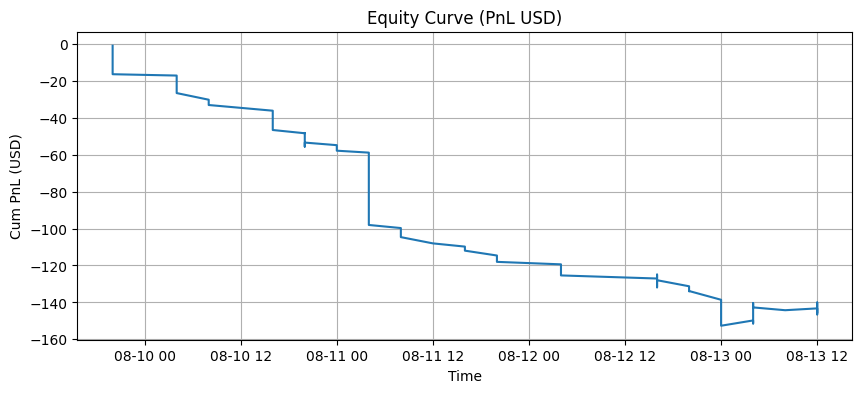

In [ ]:
# backtester_prod_emulation.py
# -*- coding: utf-8 -*-
"""
Backtester (4h) — расширенная версия с эмуляцией продовой логики (prechecks, existing positions).
Скопировать и запустить в Colab / локально. Настройки в разделе CONFIG.
"""

# ================== CONFIG ==================
DOWNLOAD = False   # True -> попытка скачать через gdown, если заданы FILE_IDs
KLINES_CSV  = 'klines_data_4h.csv'              # CSV со свечами (Date,Open,High,Low,Close,Volume,Symbol)
SIGNALS_CSV = 'tradingview_signals_real.csv'    # CSV с capture сигналами (utc_time, symbol, signal, ...)
SYMBOLS_SETTINGS_CSV = 'symbols_settings_last_update.csv'  # Настройки символов
EXISTING_POSITIONS_CSV = None  # 'existing_positions.csv'  # Optional CSV with column 'symbol' listing positions already open at test start

KLINES_FILE_ID  = None
SIGNALS_FILE_ID = None
SYMBOLS_FILE_ID = None

# Backtest behaviour flags (меняй для диагностики)
TIMEFRAME_MINUTES = 240
INTRABAR_RULE = 'stop_first'   # 'stop_first' или 'target_first'
ENTRY_MODE = 'next_open'       # 'next_open' or 'market_now'
PRICE_FOR_QTY = 'prev_close'   # 'prev_close' or 'entry_open'
MIN_NOTIONAL_BEHAVIOR = 'raise' # 'raise' or 'skip'
ALLOW_PARALLEL_TRADES = False  # don't open new trade if already open for symbol
DEDUP_METHOD = 'last_in_candle' # 'last_in_candle' or 'asof'
BTC_SELECTION = 'by_candle'     # 'by_candle' or 'asof'

# Emulation flags (new)
EMULATE_PROD_PRECHECKS = True  # If True -> perform production-like prechecks (existing positions, min_notional/min_qty logic)
DIAGNOSTICS_OUTPUT_CSV = 'diagnostics_skipped_signals.csv'
# =================================================

# ================== IMPORTS ==================
import os, math, time
from decimal import Decimal, ROUND_FLOOR, ROUND_CEILING, ROUND_HALF_UP, getcontext
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
import pandas as pd, numpy as np, matplotlib.pyplot as plt

getcontext().prec = 28

# ================== HELPERS ==================
def decimal_quantize(val: float, quantum: float, rounding_mode) -> float:
    if quantum is None or quantum == 0:
        return float(val)
    v = Decimal(str(val))
    q = Decimal(str(quantum))
    return float((v / q).to_integral_value(rounding=rounding_mode) * q)

def round_down_to_step(x: float, step: float) -> float:
    if step is None or step <= 0:
        return float(x)
    return decimal_quantize(x, step, ROUND_FLOOR)

def round_up_to_step(x: float, step: float) -> float:
    if step is None or step <= 0:
        return float(x)
    return decimal_quantize(x, step, ROUND_CEILING)

def quantize_price_nearest(x: float, tick: float) -> float:
    if tick is None or tick <= 0:
        return float(x)
    return float(Decimal(str(x)).quantize(Decimal(str(tick)), rounding=ROUND_HALF_UP))

def floor_to_timeframe(dt_series: pd.Series, minutes: int) -> pd.Series:
    if dt_series.dt.tz is None:
        return dt_series.dt.floor(f"{minutes}T").dt.tz_localize('UTC')
    else:
        return dt_series.dt.tz_convert('UTC').dt.floor(f"{minutes}T")

# ATR
def true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

def wilder_atr(df: pd.DataFrame, length: int) -> pd.Series:
    tr = true_range(df['High'], df['Low'], df['Close'])
    return tr.ewm(alpha=1/length, adjust=False).mean()

# ================== IO ==================
def load_klines(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(csv_path)
    k = pd.read_csv(csv_path)
    # Expect: Date,Open,High,Low,Close,Volume,Symbol
    k['Date'] = pd.to_datetime(k['Date'], utc=True)
    k = k.sort_values(['Symbol','Date']).reset_index(drop=True)
    return k

def load_signals(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(csv_path)
    s = pd.read_csv(csv_path)
    # normalize timeframe column name if present
    if 'interval' in s.columns and 'timeframe' not in s.columns:
        s = s.rename(columns={'interval': 'timeframe'})
    if 'utc_time' not in s.columns:
        raise ValueError("Signals CSV must contain 'utc_time' column")
    s['utc_time'] = pd.to_datetime(s['utc_time'], utc=True)
    # optionally filter to our TF
    if 'timeframe' in s.columns:
        s['timeframe'] = s['timeframe'].astype(str).str.lower()
        s = s[s['timeframe'].isin(['4h','240'])].copy()
    # compute candle_time
    s['candle_time'] = floor_to_timeframe(s['utc_time'], TIMEFRAME_MINUTES)

    # dedup options
    if DEDUP_METHOD == 'last_in_candle':
        # keep the last signal per (symbol, candle_time) by utc_time
        s = s.sort_values(['symbol','candle_time','utc_time']).groupby(['symbol','candle_time'], as_index=False).tail(1).reset_index(drop=True)
    elif DEDUP_METHOD == 'asof':
        # keep last signal with utc_time <= candle_time (rare, but safe)
        s = s.sort_values(['symbol','utc_time'])
        kept = []
        for symbol, grp in s.groupby('symbol'):
            grp = grp.reset_index(drop=True)
            for ct, sub in grp.groupby('candle_time'):
                sub_sorted = sub.sort_values('utc_time')
                picked = sub_sorted.tail(1)
                kept.append(picked)
        if kept:
            s = pd.concat(kept).reset_index(drop=True)
        else:
            s = s.iloc[0:0]
    # normalize columns
    s['symbol'] = s['symbol'].astype(str).str.upper()
    return s

# ================== SYMBOL SETTINGS ==================
@dataclass
class SymbolParams:
    atr_length: int = 14
    take1: float = 1.5
    take2: float = 2.5
    stop: float = 1.0
    order_size_usd: float = 100.0
    portion: float = 0.75
    step_size: float = 1e-8
    tick_size: float = 0.01
    min_qty: float = 0.0
    notional: float = 0.0

def _try_load_symbols_csv(path_primary: str):
    if path_primary and os.path.exists(path_primary):
        return pd.read_csv(path_primary)
    alt = 'symbols_settings_update_before_crash.csv'
    if os.path.exists(alt):
        return pd.read_csv(alt)
    return None

def load_symbol_params_from_settings(csv_path: Optional[str]) -> Tuple[Dict[str, SymbolParams], List[str]]:
    params = {}
    whitelist = []
    if not csv_path:
        return params, whitelist
    df = _try_load_symbols_csv(csv_path)
    if df is None:
        return params, whitelist
    df['symbol'] = df['symbol'].astype(str).str.upper()
    if 'status' in df.columns:
        df = df[df['status'] == 1].copy()
    whitelist = df['symbol'].unique().tolist()
    for _, r in df.iterrows():
        sym = str(r['symbol']).upper()
        params[sym] = SymbolParams(
            atr_length=int(r.get('atr_length', 14)),
            take1=float(r.get('take1', 1.5)),
            take2=float(r.get('take2', 2.5)),
            stop=float(r.get('stop', 1.0)),
            order_size_usd=float(r.get('order_size_usd', 100.0)),
            portion=float(r.get('portion', 0.75)),
            step_size=float(r.get('step_size', 1e-8)) if 'step_size' in r and not pd.isna(r.get('step_size')) else 1e-8,
            tick_size=float(r.get('tick_size', 0.01)) if 'tick_size' in r and not pd.isna(r.get('tick_size')) else 0.01,
            min_qty=float(r.get('min_qty', 0.0)) if 'min_qty' in r and not pd.isna(r.get('min_qty')) else 0.0,
            notional=float(r.get('notional', 0.0)) if 'notional' in r and not pd.isna(r.get('notional')) else 0.0,
        )
    return params, whitelist

# ================== BTC FILTER ==================
def prepare_btc_filter(signals: pd.DataFrame) -> pd.DataFrame:
    btc = signals[signals['symbol'].str.upper() == 'BTCUSDT'].copy()
    if btc.empty:
        return btc
    btc = btc.sort_values(['candle_time','utc_time']).groupby('candle_time').tail(1).reset_index(drop=True)
    btc = btc[['candle_time','utc_time','signal']].rename(columns={'utc_time':'btc_utc_time','signal':'btc_signal'})
    return btc

def attach_btc_filter(signals: pd.DataFrame, btc_df: pd.DataFrame) -> pd.DataFrame:
    s = signals.copy().sort_values('utc_time')
    if BTC_SELECTION == 'by_candle':
        merged = s.merge(btc_df, on='candle_time', how='left')
        merged = merged[merged['symbol'].str.upper() != 'BTCUSDT']
        merged = merged[~merged['btc_utc_time'].isna()]
        return merged.reset_index(drop=True)
    else:
        if btc_df.empty:
            return pd.DataFrame()
        s_sorted = s.sort_values('utc_time')
        btc_sorted = btc_df.sort_values('btc_utc_time')
        merged = pd.merge_asof(s_sorted, btc_sorted, left_on='utc_time', right_on='btc_utc_time', direction='backward')
        merged = merged[merged['symbol'].str.upper() != 'BTCUSDT']
        merged = merged[~merged['btc_utc_time'].isna()].reset_index(drop=True)
        return merged

# ================== DECISION ==================
BUY_SET = {"STRONG_BUY"}
BUY_OK_WITH_BTC = {"STRONG_BUY","BUY"}
SELL_SET = {"STRONG_SELL"}
SELL_OK_WITH_BTC = {"STRONG_SELL","SELL"}

def decision(side_sig: str, btc_sig: str) -> Optional[str]:
    s = (side_sig or '').upper()
    b = (btc_sig or '').upper()
    if s in BUY_SET and b in BUY_OK_WITH_BTC:
        return 'BUY'
    if s in SELL_SET and b in SELL_OK_WITH_BTC:
        return 'SELL'
    return None

# ================== TRADE SIM ==================
@dataclass
class TradeResult:
    symbol: str
    entry_time: pd.Timestamp
    entry_price: float
    side: str
    atr: float
    take1: float
    take2: float
    stop: float
    qty: float
    exit_time: pd.Timestamp
    exit_price: float
    exit_reason: str
    partial_taken: bool
    pnl_usd: float

def compute_levels(side: str, entry: float, atr: float, k1: float, k2: float, ks: float) -> Tuple[float,float,float]:
    if side == 'BUY':
        return entry + atr*k1, entry + atr*k2, entry - atr*ks
    else:
        return entry - atr*k1, entry - atr*k2, entry + atr*ks

def simulate_trade(symbol_df: pd.DataFrame, entry_idx: int, side: str, entry_price: float,
                   atr: float, params: SymbolParams, intrabar_rule: str) -> TradeResult:
    t1, t2, sl = compute_levels(side, entry_price, atr, params.take1, params.take2, params.stop)
    # qty calc
    raw_qty = params.order_size_usd / max(entry_price, 1e-12)
    qty = round_down_to_step(raw_qty, params.step_size)
    # min notional handling inside simulate_trade - keep defensive (should be adjusted before calling)
    if params.notional and qty * entry_price < params.notional * 1.1:
        if MIN_NOTIONAL_BEHAVIOR == 'raise':
            qty = round_up_to_step((params.notional * 1.1) / entry_price, params.step_size)
        else:
            return TradeResult(symbol_df['Symbol'].iat[0], pd.NaT, entry_price, side, atr, t1, t2, sl, 0.0, pd.NaT, 0.0, 'SKIPPED_MIN_NOTIONAL', False, 0.0)
    if params.min_qty and qty < params.min_qty:
        qty = params.min_qty
    if qty <= 0 or not math.isfinite(qty):
        return TradeResult(symbol_df['Symbol'].iat[0], pd.NaT, entry_price, side, atr, t1, t2, sl, 0.0, pd.NaT, 0.0, 'BAD_QTY', False, 0.0)

    partial = False
    remaining_qty = qty
    be_stop = None

    # iterate bars from entry_idx
    for i in range(entry_idx, len(symbol_df)):
        row = symbol_df.iloc[i]
        ts, high, low = row['Date'], float(row['High']), float(row['Low'])

        if side == 'BUY':
            if not partial:
                stop_hit = low <= sl
                t1_hit = high >= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (exit_price - entry_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (t1 - entry_price) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 - 0.001)
                        t2_hit = high >= t2
                        be_hit = low <= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (exit_price - entry_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (exit_price - entry_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (t1 - entry_price) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 - 0.001)
                    t2_hit = high >= t2
                    be_hit = low <= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (exit_price - entry_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = high >= t2
                be_hit = low <= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (t1 - entry_price)*(qty*params.portion) + (exit_price - entry_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'BUY',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
        else:
            # SELL mirror
            if not partial:
                stop_hit = high >= sl
                t1_hit = low <= t1
                if stop_hit and t1_hit:
                    if intrabar_rule == 'stop_first':
                        exit_price = sl
                        pnl = (entry_price - exit_price) * qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                    else:
                        partial = True
                        realized = (entry_price - t1) * (qty*params.portion)
                        remaining_qty = qty*(1-params.portion)
                        be_stop = entry_price*(1 + 0.001)
                        t2_hit = low <= t2
                        be_hit = high >= be_stop
                        if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                            exit_price = t2
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                        if be_hit:
                            exit_price = be_stop
                            pnl = realized + (entry_price - exit_price)*remaining_qty
                            return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                        continue
                if stop_hit:
                    exit_price = sl
                    pnl = (entry_price - exit_price) * qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,sl,qty,ts,exit_price,'STOP',False,pnl)
                if t1_hit:
                    partial = True
                    realized = (entry_price - t1) * (qty*params.portion)
                    remaining_qty = qty*(1-params.portion)
                    be_stop = entry_price*(1 + 0.001)
                    t2_hit = low <= t2
                    be_hit = high >= be_stop
                    if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                        exit_price = t2
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                    if be_hit:
                        exit_price = be_stop
                        pnl = realized + (entry_price - exit_price)*remaining_qty
                        return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)
                    continue
            else:
                t2_hit = low <= t2
                be_hit = high >= be_stop
                if t2_hit and (not be_hit or intrabar_rule=='target_first'):
                    exit_price = t2
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'TAKE2',True,pnl)
                if be_hit:
                    exit_price = be_stop
                    pnl = (entry_price - t1)*(qty*params.portion) + (entry_price - exit_price)*remaining_qty
                    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price,'SELL',atr,t1,t2,be_stop,qty,ts,exit_price,'STOP_BE',True,pnl)

    # If not closed -> EOD
    last = symbol_df.iloc[-1]
    exit_price = float(last['Close'])
    if side == 'BUY':
        if not partial:
            pnl_open = (exit_price - entry_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
        else:
            realized = (t1 - entry_price) * (qty * params.portion)
            pnl_open = realized + (exit_price - entry_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True
    else:
        if not partial:
            pnl_open = (entry_price - exit_price) * qty
            exit_reason = 'EOD'
            partial_taken = False
        else:
            realized = (entry_price - t1) * (qty * params.portion)
            pnl_open = realized + (entry_price - exit_price) * (qty * (1 - params.portion))
            exit_reason = 'EOD'
            partial_taken = True

    return TradeResult(symbol_df['Symbol'].iat[0], symbol_df.iloc[entry_idx-1]['Date'], entry_price, side, atr,
                       t1, t2, sl, qty, last['Date'], exit_price, exit_reason, partial_taken, pnl_open)

# ================== PRODUCTION-LIKE PRECHECKS (NEW) ==================
def read_existing_positions(csv_path: Optional[str]) -> set:
    if not csv_path or not os.path.exists(csv_path):
        return set()
    df = pd.read_csv(csv_path)
    if 'symbol' not in df.columns:
        raise ValueError("existing_positions CSV must contain 'symbol' column")
    return set(df['symbol'].astype(str).str.upper().tolist())

def production_precheck_and_adjust(symU: str, qty_calc: float, price_for_qty: float, params: Optional[SymbolParams],
                                   existing_positions_set: set) -> Tuple[bool, float, List[str]]:
    """
    Return: allowed (bool), adjusted_qty (float), reasons (list)
    - If not allowed -> simulation should skip this signal.
    - adjusted_qty: new qty to use (rounded to step), or same as qty_calc.
    """
    reasons = []
    if params is None:
        reasons.append('NO_SYMBOL_PARAMS')
        return False, qty_calc, reasons
    # existing open position snapshot -> emulate prod check client.get_position_risk
    if symU in existing_positions_set:
        reasons.append('EXISTING_POSITION_ON_EXCHANGE')
        return False, qty_calc, reasons
    # notional check
    notional = params.notional
    step = params.step_size if hasattr(params, 'step_size') else 1e-8
    min_qty = params.min_qty if hasattr(params, 'min_qty') else 0.0

    if notional and qty_calc * price_for_qty < notional * 1.1:
        if MIN_NOTIONAL_BEHAVIOR == 'raise':
            new_qty = round_up_to_step((notional * 1.1) / price_for_qty, step)
            reasons.append(f'RAISED_QTY_TO_MIN_NOTIONAL:{new_qty}')
            return True, new_qty, reasons
        else:
            reasons.append('SKIPPED_MIN_NOTIONAL')
            return False, qty_calc, reasons
    # min_qty
    if min_qty and qty_calc < min_qty:
        # emulate prod => set to min_qty
        reasons.append(f'ADJUSTED_TO_MIN_QTY:{min_qty}')
        return True, float(min_qty), reasons
    # qty finite check
    if not math.isfinite(qty_calc) or qty_calc <= 0:
        reasons.append('BAD_QTY')
        return False, qty_calc, reasons
    return True, qty_calc, reasons

# ================== BACKTEST ENGINE ==================
def backtest(klines_csv: str, signals_csv: str, symbols_settings_csv: Optional[str], existing_positions_csv: Optional[str] = None):
    print("[i] Loading data...")
    kdf = load_klines(klines_csv)
    sdf = load_signals(signals_csv)
    print(f"[i] Signals loaded (after dedup): {len(sdf)}")

    # diagnostic: how many duplicates existed in raw file
    try:
        raw = pd.read_csv(signals_csv)
        raw['utc_time'] = pd.to_datetime(raw['utc_time'], utc=True)
        raw['candle_time'] = floor_to_timeframe(raw['utc_time'], TIMEFRAME_MINUTES)
        dup_counts = raw.groupby(['symbol','candle_time']).size().reset_index(name='cnt')
        multi = dup_counts[dup_counts['cnt']>1].shape[0]
        print(f"[diag] Raw duplicate (symbol,candle) occurrences: {multi}")
    except Exception:
        pass

    sym_params_map, whitelist = load_symbol_params_from_settings(symbols_settings_csv)
    whitelist_set = set([s.upper() for s in whitelist])

    # prepare BTC filter
    btc = prepare_btc_filter(sdf)
    s_all = attach_btc_filter(sdf, btc)
    if s_all.empty:
        print("[warn] No signals after BTC merging -> exiting")
        return pd.DataFrame(), pd.DataFrame()

    s_all['side'] = [decision(sig, btc_sig) for sig, btc_sig in zip(s_all['signal'], s_all['btc_signal'])]
    s_all = s_all[~s_all['side'].isna()].copy()

    # whitelist
    if whitelist_set:
        s_all = s_all[s_all['symbol'].str.upper().isin(whitelist_set)].copy()

    kdf['Date'] = pd.to_datetime(kdf['Date'], utc=True)
    kdf = kdf.sort_values(['Symbol','Date']).reset_index(drop=True)

    # read existing positions snapshot
    existing_positions_set = read_existing_positions(existing_positions_csv) if EMULATE_PROD_PRECHECKS else set()
    if existing_positions_set:
        print(f"[i] Existing positions emulated for symbols: {len(existing_positions_set)}")

    trades: List[TradeResult] = []
    diagnostics = []  # store skipped signals and reasons
    symbols = s_all['symbol'].unique().tolist()
    print(f"[i] Symbols to simulate: {len(symbols)}")

    for sym in symbols:
        symU = sym.upper()
        params = sym_params_map.get(symU, SymbolParams())
        k_sym = kdf[kdf['Symbol'].str.upper() == symU].copy()
        if k_sym.empty:
            # no klines, skip
            continue
        k_sym = k_sym.reset_index(drop=True)
        # compute ATR
        k_sym['ATR'] = wilder_atr(k_sym, params.atr_length)
        idx_map = {pd.Timestamp(ts): i for i, ts in enumerate(k_sym['Date'])}

        s_sorted = s_all[s_all['symbol'].str.upper() == symU].sort_values('candle_time')
        position_open = False

        for _, row in s_sorted.iterrows():
            ct = pd.Timestamp(row['candle_time'])
            # For signal that belong to candle ct, we compute entry index depending on ENTRY_MODE
            if ENTRY_MODE == 'next_open':
                if ct not in idx_map:
                    continue
                idx = idx_map[ct]
                entry_idx = idx + 1
                if entry_idx >= len(k_sym):
                    continue
                if PRICE_FOR_QTY == 'prev_close':
                    price_for_qty = float(k_sym.loc[idx, 'Close'])
                else:
                    price_for_qty = float(k_sym.loc[entry_idx, 'Open'])
                entry_price = float(k_sym.loc[entry_idx, 'Open'])
            else:  # market_now
                if ct not in idx_map:
                    continue
                idx = idx_map[ct]
                entry_idx = idx
                if PRICE_FOR_QTY == 'prev_close':
                    price_for_qty = float(k_sym.loc[idx, 'Close'])
                else:
                    price_for_qty = float(k_sym.loc[idx, 'Open'])
                entry_price = float(k_sym.loc[idx, 'Close'])

            # disallow overlapping trades if configured
            if not ALLOW_PARALLEL_TRADES and position_open:
                # skip until closed
                diagnostics.append({
                    'symbol': symU, 'candle_time': ct, 'reason': 'PARALLEL_NOT_ALLOWED', 'side': row['side']
                })
                continue

            atr = float(k_sym.loc[idx, 'ATR'])
            if not np.isfinite(atr):
                diagnostics.append({
                    'symbol': symU, 'candle_time': ct, 'reason': 'NO_ATR', 'side': row['side']
                })
                continue

            side = row['side']

            # compute qty according to production logic (use price_for_qty)
            raw_qty = params.order_size_usd / max(price_for_qty, 1e-12)
            qty_calc = round_down_to_step(raw_qty, params.step_size)
            # apply prechecks & possible adjustments
            if EMULATE_PROD_PRECHECKS:
                allowed, adjusted_qty, reasons = production_precheck_and_adjust(symU, qty_calc, price_for_qty, params, existing_positions_set)
                if not allowed:
                    diagnostics.append({
                        'symbol': symU, 'candle_time': ct, 'reason': ';'.join(reasons), 'side': side,
                        'price_for_qty': price_for_qty, 'qty_calc': qty_calc
                    })
                    continue
                else:
                    if adjusted_qty != qty_calc:
                        diagnostics.append({
                            'symbol': symU, 'candle_time': ct, 'reason': ';'.join(reasons), 'side': side,
                            'price_for_qty': price_for_qty, 'qty_before': qty_calc, 'qty_after': adjusted_qty
                        })
                    qty_calc = adjusted_qty
            else:
                # still defensive: skip if bad qty
                if not math.isfinite(qty_calc) or qty_calc <= 0:
                    diagnostics.append({
                        'symbol': symU, 'candle_time': ct, 'reason': 'BAD_QTY', 'side': side
                    })
                    continue

            # Now ensure qty_calc respects step_size and min_qty
            if params.min_qty and qty_calc < params.min_qty:
                qty_calc = params.min_qty

            if qty_calc <= 0:
                diagnostics.append({
                    'symbol': symU, 'candle_time': ct, 'reason': 'QTY_ZERO_AFTER_ADJUST', 'side': side
                })
                continue

            # Create params_local where order_size_usd ~= qty_calc * entry_price (so simulate_trade yields qty ~ qty_calc)
            # Use entry_price as fill price for simulation (levels are computed from entry_price)
            order_size_local = float(qty_calc * entry_price)
            params_local = SymbolParams(
                atr_length=params.atr_length, take1=params.take1, take2=params.take2, stop=params.stop,
                order_size_usd=order_size_local, portion=params.portion,
                step_size=params.step_size, tick_size=params.tick_size, min_qty=params.min_qty, notional=params.notional
            )

            # simulate trade with entry_price (fill)
            tr = simulate_trade(k_sym, entry_idx, side, entry_price, atr, params_local, INTRABAR_RULE)
            if tr.qty <= 0 or tr.entry_time is pd.NaT:
                diagnostics.append({
                    'symbol': symU, 'candle_time': ct, 'reason': f'SIMULATION_NO_TRADE:{tr.exit_reason}', 'side': side
                })
                continue

            # mark position_open to avoid parallel trades if configured
            position_open = True
            trades.append(tr)
            # after trade exit time -> position_open = False
            last_exit_time = tr.exit_time
            position_open = False

    # build dataframe
    if not trades:
        print("[i] No trades simulated")
        # save diagnostics and exit
        if diagnostics:
            pd.DataFrame(diagnostics).to_csv(DIAGNOSTICS_OUTPUT_CSV, index=False)
            print(f"[i] Diagnostics saved: {DIAGNOSTICS_OUTPUT_CSV}")
        return pd.DataFrame(), pd.DataFrame()

    tdf = pd.DataFrame([{
        'symbol': t.symbol,
        'entry_time': t.entry_time,
        'entry_price': t.entry_price,
        'side': t.side,
        'atr': t.atr,
        'take1_price': t.take1,
        'take2_price': t.take2,
        'stop_price_initial': t.stop,
        'qty': t.qty,
        'exit_time': t.exit_time,
        'exit_price': t.exit_price,
        'exit_reason': t.exit_reason,
        'partial_taken': t.partial_taken,
        'pnl_usd': t.pnl_usd
    } for t in trades])

    tdf = tdf.sort_values('entry_time').reset_index(drop=True)
    tdf['cum_pnl_usd'] = tdf['pnl_usd'].cumsum()
    equity = tdf[['entry_time','cum_pnl_usd']].copy()

    # save diagnostics as CSV
    if diagnostics:
        pd.DataFrame(diagnostics).to_csv(DIAGNOSTICS_OUTPUT_CSV, index=False)
        print(f"[i] Diagnostics saved: {DIAGNOSTICS_OUTPUT_CSV}")

    return tdf, equity

# ================== RUN ==================
if __name__ == "__main__":
    trades, equity = backtest(KLINES_CSV, SIGNALS_CSV, SYMBOLS_SETTINGS_CSV, EXISTING_POSITIONS_CSV)

    print(f"\nExecuted backtest: trades_count={len(trades)}")
    if len(trades):
        from IPython.display import display
        display(trades.head(20))

        wins = (trades['pnl_usd'] > 0).sum()
        losses = (trades['pnl_usd'] <= 0).sum()
        winrate = wins / (wins + losses) if (wins+losses)>0 else np.nan
        gross_profit = trades.loc[trades['pnl_usd']>0, 'pnl_usd'].sum()
        gross_loss   = -trades.loc[trades['pnl_usd']<=0, 'pnl_usd'].sum()
        profit_factor = gross_profit / gross_loss if gross_loss>0 else np.inf

        eq_curve = equity['cum_pnl_usd'].values if len(equity) else np.array([0.0])
        peaks = np.maximum.accumulate(eq_curve)
        drawdowns = peaks - eq_curve
        max_dd = drawdowns.max() if len(drawdowns) else 0.0

        print("=== METRICS ===")
        print(f"Trades:       {len(trades)}")
        print(f"Win rate:     {winrate:.2%}")
        print(f"ProfitFactor: {profit_factor:.3f}")
        print(f"Net PnL:      {trades['pnl_usd'].sum():.2f} USD")
        print(f"Max DD:       {max_dd:.2f} USD")

        trades.to_csv('trades.csv', index=False)
        equity.to_csv('equity.csv', index=False)
        print("Saved: trades.csv, equity.csv")

        if len(equity):
            plt.figure(figsize=(10,4))
            plt.plot(equity['entry_time'], equity['cum_pnl_usd'])
            plt.title('Equity Curve (PnL USD)')
            plt.xlabel('Time')
            plt.ylabel('Cum PnL (USD)')
            plt.grid(True)
            plt.show()
    else:
        print("[i] No trades — check input files or parameters.")



## Imports

In [ ]:
!pip install backtesting
!pip install hyperopt
# !pip install python-binance

# !pip install -q gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# !pip install conda-package-handling
# !wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
# !cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
# !mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
# import talib

In [ ]:
# Ставим зависимости
!apt-get install -y build-essential
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib-0.4.0/
!./configure --prefix=/usr
!make
!make install
%cd ..
# Устанавливаем python-обертку
!pip install Ta-Lib
import talib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
--2025-09-02 13:28:57--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-09-02 13:28:59--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.n

In [ ]:
!pip install -q gdown
!gdown --id 1rsU2dMtJauwkrEZ2BR9vhyG_XOoltYVY -O klines_data_4h.csv
!gdown --id 1subUE3f_5uRuPG3irLD-w6BKZ2ZSXTl2 -O tradingview_signals_first.csv
!gdown --id 12CQtYa6w8JSP0rONQjU6D68hptuwBXC8 -O tradingview_signals_server.csv
!gdown --id 1XFrRbQXVj-DOE8HxoS5oxSaT5xDaXPAp -O tradingview_signals.csv
!gdown --id 1myLrl6gU3bLytydjo9mYtrq8eJhjSfPm -O tradingview_signals_real.csv






# https://drive.google.com/file/d/1rsU2dMtJauwkrEZ2BR9vhyG_XOoltYVY/view?usp=drive_link

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rsU2dMtJauwkrEZ2BR9vhyG_XOoltYVY
To: /klines_data_4h.csv
100% 959k/959k [00:00<00:00, 11.0MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1subUE3f_5uRuPG3irLD-w6BKZ2ZSXTl2
To: /tradingview_signals_first.csv
100% 64.9k/64.9k [00:00<00:00, 4.81MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https

In [ ]:
import pandas as pd
from backtesting import Backtest, Strategy
import numpy as np
# import pandas_ta as ta

/usr/local/lib/python3.12/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


### Import data (signals)

In [ ]:
df4 = pd.read_csv('tradingview_signals_real.csv')

# === Переименовать столбец "interval" в "timeframe" ===
df4.rename(columns={"interval": "timeframe"}, inplace=True)
df4 = df4.sort_values(by='utc_time')
df4["utc_time"] = pd.to_datetime(df4["utc_time"])
df4["unix_timestamp"] = df4["utc_time"].astype('int64') // 10**9  # секунды

df4

#     id     symbol timeframe      signal    entry_price  \
0          1      1    BTCUSDT        4h        SELL  116507.613380   
1          2      2    ETHUSDT        4h  STRONG_BUY    3721.130000   
2          3      3    BCHUSDT        4h  STRONG_BUY     554.732753   
3          4      4    XRPUSDT        4h        SELL       3.133900   
4          5      5    LTCUSDT        4h  STRONG_BUY     115.708028   
...      ...    ...        ...       ...         ...            ...   
16970  16971  16971  VOXELUSDT        4h  STRONG_BUY       0.061277   
16969  16970  16970   AEVOUSDT        4h         BUY       0.109394   
16967  16968  16968    FIOUSDT        4h     NEUTRAL       0.020600   
16927  16928  16928    ICPUSDT        4h  STRONG_BUY       6.017000   
16953  16954  16954      CUSDT        4h         BUY       0.265375   

                              utc_time  \
0     2025-07-25 12:00:09.394983+00:00   
1     2025-07-25 12:00:09.394987+00:00   
2     2025-07-25 12:00:09.394988+00:00   
3     2025-07-25 12:00:09.394989+00:00   
4     2025-07-25 12:00:09.394990+00:00   
...                                ...   
16970 2025-08-14 00:00:09.144155+00:00   
16969 2025-08-14 00:00:09.175397+00:00   
16967 2025-08-14 00:00:09.181879+00:00   
16927 2025-08-14 00:00:09.216944+00:00   
16953 2025-08-14 00:00:09.407119+00:00   

                                              indicators  unix_timestamp  
0                                                    NaN      1753444809  
1                                                    NaN      1753444809  
2                                                    NaN      1753444809  
3                                                    NaN      1753444809  
4                                                    NaN      1753444809  
...                                                  ...             ...  
16970  {"AO": {"value": -0.0009167647058824363, "sign...      1755129609  
16969  {"AO": {"value": 0.004578235294117633, "signal...      1755129609  
16967  {"AO": {"value": -0.00047502941176471095, "sig...      1755129609  
16927  {"AO": {"value": 0.25782352941176345, "signal"...      1755129609  
16953  {"AO": {"value": -0.00033088235294098656, "sig...      1755129609  

[16971 rows x 9 columns]

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16971 entries, 0 to 16953
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   #               16971 non-null  int64              
 1   id              16971 non-null  int64              
 2   symbol          16971 non-null  object             
 3   timeframe       16971 non-null  object             
 4   signal          16971 non-null  object             
 5   entry_price     16971 non-null  float64            
 6   utc_time        16971 non-null  datetime64[ns, UTC]
 7   indicators      6138 non-null   object             
 8   unix_timestamp  16971 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 1.3+ MB


In [ ]:
import pandas as pd

df1 = pd.read_csv('tradingview_signals_first.csv')
# df2 = pd.read_csv('tradingview_signals.csv')
df3 = pd.read_csv('tradingview_signals_server.csv')

# === Переименовать столбец "interval" в "timeframe" ===
df4.rename(columns={"interval": "timeframe"}, inplace=True)

# === Преобразовать utc_time в datetime и добавить unix_timestamp ===
# df4["utc_time"] = pd.to_datetime(df4["utc_time"])
# df4["unix_timestamp"] = df4["utc_time"].astype('int64') // 10**9  # секунды

# df = pd.concat([df1, df2, df3], ignore_index=True)
df = pd.concat([df1, df3], ignore_index=True)



# df = pd.read_csv('signals_29_new.csv')
df = df.sort_values(by='utc_time')
# df.to_csv('tradingview_signals_merged.csv', index=False)
df.info()
df.tail(10)

<class 'pandas.core.frame.DataFrame'>
Index: 545835 entries, 492914 to 748
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   #               545835 non-null  int64  
 1   id              545835 non-null  int64  
 2   symbol          545835 non-null  object 
 3   timeframe       545835 non-null  object 
 4   signal          545835 non-null  object 
 5   entry_price     545835 non-null  float64
 6   unix_timestamp  545835 non-null  int64  
 7   utc_time        545835 non-null  object 
 8   local_time      545835 non-null  object 
 9   atr             428615 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 45.8+ MB


#   id    symbol timeframe       signal   entry_price  unix_timestamp  \
739  125  125    AIUSDT       15m  STRONG_SELL      0.230820      1740850356   
740  126  126  PERPUSDT       15m  STRONG_SELL      0.417900      1740850359   
741  127  127   NMRUSDT       15m  STRONG_SELL      9.880593      1740850360   
742  128  128   ETHUSDT       15m      NEUTRAL   2199.000000      1740851102   
743  129  129    SCUSDT       15m   STRONG_BUY      0.003661      1740851107   
744  130  130  SCRTUSDT       15m  STRONG_SELL      0.209323      1740851109   
745  131  131  HOOKUSDT       15m   STRONG_BUY      0.197359      1740851138   
746  132  132   BTCUSDT       15m   STRONG_BUY  85229.400000      1740851183   
747  133  133   MDTUSDT       15m   STRONG_BUY      0.029077      1740851216   
748  134  134   POLUSDT       15m   STRONG_BUY      0.272330      1740851227   

    utc_time local_time  atr  
739  32:36.0    32:36.0  NaN  
740  32:39.0    32:39.0  NaN  
741  32:40.0    32:40.0  NaN  
742  45:02.0    45:02.0  NaN  
743  45:07.0    45:07.0  NaN  
744  45:09.0    45:09.0  NaN  
745  45:38.0    45:38.0  NaN  
746  46:23.0    46:23.0  NaN  
747  46:56.0    46:56.0  NaN  
748  47:07.0    47:07.0  NaN

In [ ]:
df.tail(10)

#   id    symbol timeframe       signal   entry_price  unix_timestamp  \
739  125  125    AIUSDT       15m  STRONG_SELL      0.230820      1740850356   
740  126  126  PERPUSDT       15m  STRONG_SELL      0.417900      1740850359   
741  127  127   NMRUSDT       15m  STRONG_SELL      9.880593      1740850360   
742  128  128   ETHUSDT       15m      NEUTRAL   2199.000000      1740851102   
743  129  129    SCUSDT       15m   STRONG_BUY      0.003661      1740851107   
744  130  130  SCRTUSDT       15m  STRONG_SELL      0.209323      1740851109   
745  131  131  HOOKUSDT       15m   STRONG_BUY      0.197359      1740851138   
746  132  132   BTCUSDT       15m   STRONG_BUY  85229.400000      1740851183   
747  133  133   MDTUSDT       15m   STRONG_BUY      0.029077      1740851216   
748  134  134   POLUSDT       15m   STRONG_BUY      0.272330      1740851227   

    utc_time local_time  atr  
739  32:36.0    32:36.0  NaN  
740  32:39.0    32:39.0  NaN  
741  32:40.0    32:40.0  NaN  
742  45:02.0    45:02.0  NaN  
743  45:07.0    45:07.0  NaN  
744  45:09.0    45:09.0  NaN  
745  45:38.0    45:38.0  NaN  
746  46:23.0    46:23.0  NaN  
747  46:56.0    46:56.0  NaN  
748  47:07.0    47:07.0  NaN

In [ ]:
# df = pd.concat([df, df4], ignore_index=True)



# df = pd.read_csv('signals_29_new.csv')
# df = df.sort_values(by='utc_time')
# df.to_csv('tradingview_signals_merged.csv', index=False)
df.info()
df.tail(10)

<class 'pandas.core.frame.DataFrame'>
Index: 545835 entries, 492914 to 748
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   #               545835 non-null  int64  
 1   id              545835 non-null  int64  
 2   symbol          545835 non-null  object 
 3   timeframe       545835 non-null  object 
 4   signal          545835 non-null  object 
 5   entry_price     545835 non-null  float64
 6   unix_timestamp  545835 non-null  int64  
 7   utc_time        545835 non-null  object 
 8   local_time      545835 non-null  object 
 9   atr             428615 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 45.8+ MB


#   id    symbol timeframe       signal   entry_price  unix_timestamp  \
739  125  125    AIUSDT       15m  STRONG_SELL      0.230820      1740850356   
740  126  126  PERPUSDT       15m  STRONG_SELL      0.417900      1740850359   
741  127  127   NMRUSDT       15m  STRONG_SELL      9.880593      1740850360   
742  128  128   ETHUSDT       15m      NEUTRAL   2199.000000      1740851102   
743  129  129    SCUSDT       15m   STRONG_BUY      0.003661      1740851107   
744  130  130  SCRTUSDT       15m  STRONG_SELL      0.209323      1740851109   
745  131  131  HOOKUSDT       15m   STRONG_BUY      0.197359      1740851138   
746  132  132   BTCUSDT       15m   STRONG_BUY  85229.400000      1740851183   
747  133  133   MDTUSDT       15m   STRONG_BUY      0.029077      1740851216   
748  134  134   POLUSDT       15m   STRONG_BUY      0.272330      1740851227   

    utc_time local_time  atr  
739  32:36.0    32:36.0  NaN  
740  32:39.0    32:39.0  NaN  
741  32:40.0    32:40.0  NaN  
742  45:02.0    45:02.0  NaN  
743  45:07.0    45:07.0  NaN  
744  45:09.0    45:09.0  NaN  
745  45:38.0    45:38.0  NaN  
746  46:23.0    46:23.0  NaN  
747  46:56.0    46:56.0  NaN  
748  47:07.0    47:07.0  NaN

### Import data (klines)

In [ ]:
import pandas as pd
import numpy as np

interval = "4h"
klines_df = pd.read_csv(f"klines_data_{interval}.csv")
# signals_df = pd.read_csv("tradingview_signals_server.csv")
signals_df = df.copy()



# для сгенерированных сигналов
# signals_df['utc_time'] = pd.to_datetime(signals_df['utc_time'], dayfirst=True)
# # signals_df['unix_timestamp'] = signals_df['utc_time'].astype('int64') // 10**9


signals_df["utc_time"] = pd.to_datetime(signals_df["unix_timestamp"], unit="s", utc=True).dt.floor("H")

print(signals_df[["symbol", "utc_time", "signal"]].head())


print('klines_df.shape', klines_df.shape)
klines_df.info()

         symbol                  utc_time       signal
492914  BTCUSDT 2025-06-17 21:00:00+00:00         SELL
165842  ETHUSDT 2025-04-08 03:00:00+00:00          BUY
254971  BNBUSDT 2025-04-26 09:00:00+00:00  STRONG_SELL
254970  BTCUSDT 2025-04-26 09:00:00+00:00         SELL
254969  BTCUSDT 2025-04-26 09:00:00+00:00         SELL
klines_df.shape (13062, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13062 entries, 0 to 13061
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13062 non-null  object 
 1   Open    13062 non-null  float64
 2   High    13062 non-null  float64
 3   Low     13062 non-null  float64
 4   Close   13062 non-null  float64
 5   Volume  13062 non-null  float64
 6   Symbol  13062 non-null  object 
dtypes: float64(5), object(2)
memory usage: 714.5+ KB


/tmp/ipython-input-1864457732.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  signals_df["utc_time"] = pd.to_datetime(signals_df["unix_timestamp"], unit="s", utc=True).dt.floor("H")


In [ ]:
klines_df.tail()

Date      Open      High       Low     Close  \
13057  2025-08-13 00:00:00+00:00  0.009252  0.009412  0.009246  0.009315   
13058  2025-08-13 04:00:00+00:00  0.009314  0.009405  0.009264  0.009291   
13059  2025-08-13 08:00:00+00:00  0.009293  0.009384  0.009114  0.009314   
13060  2025-08-13 12:00:00+00:00  0.009313  0.009380  0.009205  0.009286   
13061  2025-08-13 16:00:00+00:00  0.009279  0.009405  0.009179  0.009361   

            Volume   Symbol  
13057  105389111.0  FUNUSDT  
13058  108680765.0  FUNUSDT  
13059  131689536.0  FUNUSDT  
13060  177748529.0  FUNUSDT  
13061  103251908.0  FUNUSDT

In [ ]:
print('signals_df.shape', signals_df.shape)
signals_df.info()

signals_df.shape (545835, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 545835 entries, 492914 to 748
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   #               545835 non-null  int64              
 1   id              545835 non-null  int64              
 2   symbol          545835 non-null  object             
 3   timeframe       545835 non-null  object             
 4   signal          545835 non-null  object             
 5   entry_price     545835 non-null  float64            
 6   unix_timestamp  545835 non-null  int64              
 7   utc_time        545835 non-null  datetime64[ns, UTC]
 8   local_time      545835 non-null  object             
 9   atr             428615 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(4)
memory usage: 45.8+ MB


In [ ]:
klines_df['Date'] = pd.to_datetime(klines_df['Date'])

signals_df['utc_time'] = pd.to_datetime(signals_df['utc_time'])
# df4["unix_timestamp"] = df4["utc_time"].astype('int64') // 10**9  # секунды

signals_df = signals_df[signals_df["timeframe"] == f"{interval}"]

In [ ]:
# !pip install backtesting
# !pip install pandas_ta
# !pip install hyperopt

## Strategy

### Basic

In [ ]:
import pandas as pd
import numpy as np
# import pandas_ta as ta
from backtesting import Backtest, Strategy

trade_log = []
class SignalStrategy(Strategy):
    stop_loss_multiplier = 0.4
    take_profit_multiplier = 1.2
    signals_df = None
    symbol = None

    def init(self):
        """Load trading signals and ATR indicator"""
        self.signals = self.signals_df[self.signals_df["symbol"] == self.symbol]
        self.used_signals = set()

        def atr_indicator(h, l, c):
            """Calculate ATR (Average True Range)"""
            try:
                atr_values = ta.atr(pd.Series(h), pd.Series(l), pd.Series(c), length=14)
                return atr_values.fillna(0).to_numpy() if atr_values is not None else np.zeros(len(h))
            except Exception as e:
                print(f"Error calculating ATR: {e}")
                return np.zeros(len(h))

        self.atr = self.I(atr_indicator, self.data.High, self.data.Low, self.data.Close)

    def next(self):
        """Process signals and open trades accordingly"""
        current_time = self.data.index[-1]
        current_price = self.data.Close[-1]
        current_atr = self.atr[-1]

        if current_atr == 0 or pd.isna(current_atr):
            return

        for _, signal in self.signals.iterrows():
            signal_time = signal['utc_time']

            if signal_time in self.used_signals:
                continue

            if signal_time in self.data.index:
                self.used_signals.add(signal_time)

                if signal['signal'] == "STRONG_BUY" and not self.position:
                    stop_loss = current_price - (self.stop_loss_multiplier * current_atr)
                    take_profit = current_price + (self.take_profit_multiplier * current_atr)

                    if stop_loss < current_price < take_profit:
                        print(f"🚀 LONG {self.symbol} | {current_time} | Price: {current_price} | SL: {stop_loss:.4f} | TP: {take_profit:.4f}")
                        self.buy(sl=stop_loss, tp=take_profit)

                elif signal['signal'] == "STRONG_SELL" and not self.position:
                    stop_loss = current_price + (self.stop_loss_multiplier * current_atr)
                    take_profit = current_price - (self.take_profit_multiplier * current_atr)

                    if take_profit < current_price < stop_loss:
                        print(f"🚨 SHORT {self.symbol} | {current_time} | Price: {current_price} | SL: {stop_loss:.4f} | TP: {take_profit:.4f}")
                        self.sell(sl=stop_loss, tp=take_profit)

    def notify_trade(self, trade):
        """Log trade results when a trade is closed"""
        if trade.is_closed:
            trade_log.append({
                "Symbol": self.symbol,
                "Entry Time": trade.entry_time,
                "Exit Time": trade.exit_time,
                "Entry Price": trade.entry_price,
                "Exit Price": trade.exit_price,
                "Return [%]": trade.pl_pct * 100,
            })


### Basic + BTC filter

In [ ]:
import pandas as pd
import numpy as np
# import pandas_ta as ta
from backtesting import Backtest, Strategy


trade_log = []

class SignalStrategyBTC(Strategy):
    stop_loss_multiplier = 0.45
    take_profit_multiplier = 1.25
    signals_df = None
    btc_signals_df = None
    symbol = None

    def init(self):
        """Load trading signals and ATR indicator"""
        self.signals = self.signals_df[self.signals_df["symbol"] == self.symbol].copy()
        self.used_signals = set()

        # Обрабатываем BTC сигналы
        self.btc_signals = self.signals_df[self.signals_df["symbol"] == "BTCUSDT"].copy()
        if not self.btc_signals.empty:
            self.btc_signals["utc_time"] = pd.to_datetime(self.btc_signals["utc_time"]).dt.floor("min")
        else:
            self.btc_signals = None  # Отключаем проверку, если данных нет
            # print("⚠️ Нет сигналов BTCUSDT! Проверка отключена.")

        self.signals["utc_time"] = pd.to_datetime(self.signals["utc_time"]).dt.floor("min")

        # ATR Indicator
        self.atr = self.I(self.atr_indicator, self.data.High, self.data.Low, self.data.Close)

    # def atr_indicator(self, h, l, c):
    #     """Calculate ATR (Average True Range)"""
    #     try:
    #         atr_values = ta.atr(pd.Series(h), pd.Series(l), pd.Series(c), length=14)
    #         return atr_values.fillna(0).to_numpy() if atr_values is not None else np.zeros(len(h))
    #     except Exception as e:
    #         print(f"Error calculating ATR: {e}")
    #         return np.zeros(len(h))


    def atr_indicator(self, h, l, c):
        try:
            atr = talib.ATR(h, l, c, timeperiod=14)
            return np.nan_to_num(atr)
        except Exception as e:
            print(f"ATR error: {e}")
            return np.zeros(len(c))


    def next(self):
        """Обрабатываем сигналы, если они соответствуют таймфрейму"""
        current_time = self.data.index[-1]  # Время текущей свечи
        current_price = self.data.Close[-1]
        current_atr = self.atr[-1]

        if current_atr == 0 or pd.isna(current_atr):
            return


        # if self.position:
        #     return

        # Получаем BTC сигнал, если он есть
        btc_signal = None
        if not self.position and self.btc_signals is not None:
            btc_row = self.btc_signals[(self.btc_signals["utc_time"] == current_time) &
                                      (self.btc_signals["timeframe"] == interval)]
            if not btc_row.empty:
                btc_signal = btc_row.iloc[0]["signal"]

        # print(f"[{current_time}] 🔍 BTC сигнал: {btc_signal if btc_signal else 'Нет сигнала'}")

        # Фильтруем сигналы по `utc_time` и `timeframe == interval`
        relevant_signals = self.signals[(self.signals["utc_time"] == current_time) &
                                        (self.signals["timeframe"] == interval)]

        if relevant_signals.empty:
            # print(f"[{current_time}] ⏳ Нет сигналов {self.symbol} на интервале {interval}")
            return  # Пропускаем, если нет сигналов в нужном интервале

        for _, signal in relevant_signals.iterrows():
            if signal["utc_time"] in self.used_signals:
                continue

            self.used_signals.add(signal["utc_time"])

            # Убеждаемся, что BTC сигнал тоже соответствует интервалу
            if btc_signal is None:
                # print(f"[{current_time}] ❌ Нет BTC сигнала, пропускаем {self.symbol}")
                continue


            # if (btc_signal in ["BUY", "STRONG_BUY", "NEUTRAL"] and signal["signal"] == "STRONG_BUY"):
            if (btc_signal in ["BUY", "STRONG_BUY"] and signal["signal"] == "STRONG_BUY"):
                stop_loss = current_price - (self.stop_loss_multiplier * current_atr)
                take_profit = current_price + (self.take_profit_multiplier * current_atr)


                print(f"🚀 LONG {self.symbol} | {current_time} | BTC: {btc_signal} | Price: {current_price} | SL: {stop_loss:.4f} | TP: {take_profit:.4f}")
                self.buy(sl=stop_loss, tp=take_profit)

            # elif (btc_signal in ["SELL", "STRONG_SELL", "NEUTRAL"] and signal["signal"] == "STRONG_SELL"):
            elif (btc_signal in ["SELL", "STRONG_SELL"] and signal["signal"] == "STRONG_SELL"):
                stop_loss = current_price + (self.stop_loss_multiplier * current_atr)
                take_profit = current_price - (self.take_profit_multiplier * current_atr)


                print(f"🚨 SHORT {self.symbol} | {current_time} | BTC: {btc_signal} | Price: {current_price} | SL: {stop_loss:.4f} | TP: {take_profit:.4f}")
                self.sell(sl=stop_loss, tp=take_profit)




### BTC filter + 2 takes

In [ ]:
class SignalStrategyBTCTwoTakes(Strategy):
    stop_loss_multiplier = 0.25
    take1_profit_multiplier = 1.0
    take2_profit_multiplier = 2.0
    btc_signals_df = None
    symbol = None
    close_portion = 0.5
    interval = interval

    def init(self):
        self.signals = self.signals_df[self.signals_df["symbol"] == self.symbol].copy()
        self.used_signals = set()
        self.btc_signals = self.signals_df[self.signals_df["symbol"] == "BTCUSDT"].copy()
        self.btc_signals["utc_time"] = pd.to_datetime(self.btc_signals["utc_time"]).dt.floor(self.interval)
        self.signals["utc_time"] = pd.to_datetime(self.signals["utc_time"]).dt.floor(self.interval)
        self.atr = self.I(self.atr_indicator, self.data.High, self.data.Low, self.data.Close)

        self.active_trade = None

        # Статистика
        self.results = {
            "tp2_hit": 0,
            "tp1_only_then_sl": 0,
            "sl_before_tp1": 0
        }

    # def atr_indicator(self, h, l, c):
    #     try:
    #         atr_values = ta.atr(pd.Series(h), pd.Series(l), pd.Series(c), length=14)
    #         return atr_values.fillna(0).to_numpy()
    #     except:
    #         return np.zeros(len(h))


    def atr_indicator(self, h, l, c):
        try:
            atr = talib.ATR(h, l, c, timeperiod=14)
            print(atr)
            return np.nan_to_num(atr)
        except Exception as e:
            print(f"ATR error: {e}")
            return np.zeros(len(c))



    def next(self):
        current_time = self.data.index[-1]
        price = self.data.Close[-1]
        atr = self.atr[-1]

        if atr == 0 or pd.isna(atr):
            return

        # Управление уже открытой сделкой
        if self.active_trade:
            direction = self.active_trade['direction']
            entry = self.active_trade['entry']
            tp1 = self.active_trade['tp1']
            tp2 = self.active_trade['tp2']
            sl = self.active_trade['sl']
            moved_to_be = self.active_trade['moved_to_be']

            if direction == "long":
                if not moved_to_be and price >= tp1:
                    self.active_trade['moved_to_be'] = True
                    self.position.close(portion=self.close_portion)
                    self.active_trade['sl'] = entry * 1.01
                    print(f"✅ TP1 hit {tp1}! Moved SL to BE: {self.active_trade['sl']:.8f}")


                elif moved_to_be and price >= tp2:
                    self.results["tp2_hit"] += 1
                    print(f"🎯 TP2 hit {tp2}! Closing remaining.")
                    self.position.close()
                    self.active_trade = None

                elif price <= sl:
                    if moved_to_be:
                        self.results["tp1_only_then_sl"] += 1
                        print(f"🛑 SL after TP1 (BE+)! SL: {sl}")
                    else:
                        self.results["sl_before_tp1"] += 1
                        print(f"🛑 SL before TP1! SL: {sl}")
                    self.position.close()
                    self.active_trade = None

            elif direction == "short":
                if not moved_to_be and price <= tp1:
                    self.active_trade['moved_to_be'] = True
                    self.position.close(portion=self.close_portion)
                    self.active_trade['sl'] = entry * 0.99
                    print(f"✅ TP1 hit {tp1}! Moved SL to BE: {self.active_trade['sl']:.8f}")
                elif moved_to_be and price <= tp2:
                    self.results["tp2_hit"] += 1
                    print(f"🎯 TP2 hit {tp2}! Closing remaining.")
                    self.position.close()
                    self.active_trade = None
                elif price >= sl:
                    if moved_to_be:
                        self.results["tp1_only_then_sl"] += 1
                        print(f"🛑 SL after TP1 (BE+)! SL: {sl}")
                    else:
                        self.results["sl_before_tp1"] += 1
                        print(f"🛑 SL before TP1! SL: {sl}")
                    self.position.close()
                    self.active_trade = None

            return

        # Ждём завершения сделки
        if self.position:
            return

        # Получение сигнала по BTC
        btc_signal = None
        if self.btc_signals is not None:
            btc_row = self.btc_signals[(self.btc_signals["utc_time"] == current_time) &
                                       (self.btc_signals["timeframe"] == interval)]
            if not btc_row.empty:
                btc_signal = btc_row.iloc[0]["signal"]

        relevant_signals = self.signals[(self.signals["utc_time"] == current_time) &
                                        (self.signals["timeframe"] == interval)]

        for _, signal in relevant_signals.iterrows():
            if signal["utc_time"] in self.used_signals:
                continue
            self.used_signals.add(signal["utc_time"])

            # if signal["signal"] == "STRONG_BUY" and btc_signal in ["BUY", "STRONG_BUY", "NEUTRAL"]:
            if signal["signal"] == "STRONG_BUY" and btc_signal in ["BUY", "STRONG_BUY"]:
                sl = price - self.stop_loss_multiplier * atr
                tp1 = price + self.take1_profit_multiplier * atr
                tp2 = price + self.take2_profit_multiplier * atr
                self.buy()
                self.active_trade = {
                    "direction": "long",
                    "entry": price,
                    "sl": sl,
                    "tp1": tp1,
                    "tp2": tp2,
                    "moved_to_be": False
                }
                print(f"🚀 LONG {self.symbol} | {current_time} | Price: {price} | SL: {sl}, TP1: {tp1}, TP2: {tp2}")

            # elif signal["signal"] == "STRONG_SELL" and btc_signal in ["SELL", "STRONG_SELL", "NEUTRAL"]:
            elif signal["signal"] == "STRONG_SELL" and btc_signal in ["SELL", "STRONG_SELL"]:
                sl = price + self.stop_loss_multiplier * atr
                tp1 = price - self.take1_profit_multiplier * atr
                tp2 = price - self.take2_profit_multiplier * atr
                self.sell()
                self.active_trade = {
                    "direction": "short",
                    "entry": price,
                    "sl": sl,
                    "tp1": tp1,
                    "tp2": tp2,
                    "moved_to_be": False
                }
                print(f"🚨 SHORT {self.symbol} | {current_time} | Price: {price} | SL: {sl}, TP1: {tp1}, TP2: {tp2}")

    def report(self):
        print("\n📊 Deal Outcome Stats:")
        print(f"  🎯 TP2 hit: {self.results['tp2_hit']}")
        print(f"  ⚠️ TP1 only, then SL: {self.results['tp1_only_then_sl']}")
        print(f"  ❌ SL before TP1: {self.results['sl_before_tp1']}")



In [ ]:
# class SignalStrategyBTCTwoTakes(Strategy):
#     stop_loss_multiplier = 0.25
#     take1_profit_multiplier = 1.0
#     take2_profit_multiplier = 2.0
#     btc_signals_df = None
#     symbol = None
#     close_portion = 0.5
#     interval = interval

#     def atr_indicator(self, h, l, c):
#         try:
#             atr = talib.ATR(h, l, c, timeperiod=14)
#             print(atr)
#             return np.nan_to_num(atr)
#         except Exception as e:
#             print(f"ATR error: {e}")
#             return np.zeros(len(c))

#     def init(self):
#       # Нормализуем интервал
#       self.interval_str = str(getattr(self, "interval", "4h")).lower()

#       # Дата-окно цен (UTC-aware)
#       idx = self.data.index
#       if getattr(idx, "tz", None) is None:
#           # если индекс без таймзоны — считаем, что это уже UTC
#           start_utc = pd.to_datetime(idx[0], utc=True)
#           end_utc   = pd.to_datetime(idx[-1], utc=True)
#       else:
#           start_utc = idx[0].tz_convert("UTC")
#           end_utc   = idx[-1].tz_convert("UTC")

#       def _prep_signals(df, symbol=None):
#           q = df.copy()
#           if symbol is not None:
#               q = q[q["symbol"] == symbol]
#           # фильтр по TF строго строкой в нижнем регистре
#           q = q[q["timeframe"].astype(str).str.lower() == self.interval_str]
#           # UTC + округление к границе TF
#           q["utc_time"] = pd.to_datetime(q["utc_time"], utc=True).dt.floor(self.interval_str)
#           # ограничиваем окно по данным — иначе в отчёте «много сигналов», а в данных их нет
#           q = q[(q["utc_time"] >= start_utc) & (q["utc_time"] <= end_utc)]
#           return q

#       self.signals = _prep_signals(self.signals_df, self.symbol)
#       self.btc_signals = _prep_signals(self.signals_df, "BTCUSDT")

#       self.used_signals = set()
#       self.atr = self.I(self.atr_indicator, self.data.High, self.data.Low, self.data.Close)
#       self.active_trade = None

#       self.results = {"tp2_hit": 0, "tp1_only_then_sl": 0, "sl_before_tp1": 0}

#       # Небольшая диагностика по окну данных
#       print(f"[{self.symbol}] signals in data window: {len(self.signals)}; "
#             f"btc rows in window: {len(self.btc_signals)}; timeframe='{self.interval_str}'")


#     def next(self):
#         current_time = self.data.index[-1]
#         # Приводим current_time к UTC для строгого сравнения с utc_time
#         if getattr(current_time, "tzinfo", None) is None:
#             current_time = pd.Timestamp(current_time).tz_localize("UTC")
#         else:
#             current_time = current_time.tz_convert("UTC")

#         price_close = self.data.Close[-1]
#         price_high  = self.data.High[-1]
#         price_low   = self.data.Low[-1]
#         atr = self.atr[-1]

#         if atr == 0 or pd.isna(atr):
#             return

#         # --- Управление активной сделкой ---
#         if self.active_trade:
#             direction   = self.active_trade['direction']
#             entry       = self.active_trade['entry']
#             tp1         = self.active_trade['tp1']
#             tp2         = self.active_trade['tp2']
#             sl          = self.active_trade['sl']
#             moved_to_be = self.active_trade['moved_to_be']

#             if direction == "long":
#                 # 1) SL
#                 if price_low <= sl:
#                     if moved_to_be:
#                         self.results["tp1_only_then_sl"] += 1
#                         print(f"🛑 SL after TP1 (BE+) | SL: {sl}")
#                     else:
#                         self.results["sl_before_tp1"] += 1
#                         print(f"🛑 SL before TP1 | SL: {sl}")
#                     self.position.close()
#                     self.active_trade = None
#                     return
#                 # 2) TP2 (лимит стоит сразу — может сработать до TP1)
#                 if price_high >= tp2:
#                     self.results["tp2_hit"] += 1
#                     print(f"🎯 TP2 hit {tp2}! Closing remaining.")
#                     self.position.close()
#                     self.active_trade = None
#                     return
#                 # 3) TP1
#                 if not moved_to_be and price_high >= tp1:
#                     self.active_trade['moved_to_be'] = True
#                     self.position.close(portion=self.close_portion)
#                     self.active_trade['sl'] = entry * 1.001  # BE + 0.1%
#                     print(f"✅ TP1 hit {tp1}! Moved SL to BE+0.1%: {self.active_trade['sl']:.8f}")
#                     return

#             else:  # short
#                 # 1) SL
#                 if price_high >= sl:
#                     if moved_to_be:
#                         self.results["tp1_only_then_sl"] += 1
#                         print(f"🛑 SL after TP1 (BE+) | SL: {sl}")
#                     else:
#                         self.results["sl_before_tp1"] += 1
#                         print(f"🛑 SL before TP1 | SL: {sl}")
#                     self.position.close()
#                     self.active_trade = None
#                     return
#                 # 2) TP2
#                 if price_low <= tp2:
#                     self.results["tp2_hit"] += 1
#                     print(f"🎯 TP2 hit {tp2}! Closing remaining.")
#                     self.position.close()
#                     self.active_trade = None
#                     return
#                 # 3) TP1
#                 if not moved_to_be and price_low <= tp1:
#                     self.active_trade['moved_to_be'] = True
#                     self.position.close(portion=self.close_portion)
#                     self.active_trade['sl'] = entry * 0.999  # BE - 0.1%
#                     print(f"✅ TP1 hit {tp1}! Moved SL to BE-0.1%: {self.active_trade['sl']:.8f}")
#                     return

#             return  # есть активная сделка — дальше не входим

#         # Если уже в позиции, никаких новых входов
#         if self.position:
#             return

#         # --- Строгий BTC-фильтр по той же строке TF и времени ---
#         btc_signal = None
#         if self.btc_signals is not None:
#             btc_row = self.btc_signals[
#                 (self.btc_signals["utc_time"] == current_time) &
#                 (self.btc_signals["timeframe"].astype(str).str.lower() == self.interval_str)
#             ]
#             if not btc_row.empty:
#                 btc_signal = btc_row.iloc[0]["signal"]

#         # --- Сигналы по текущему инструменту ---
#         relevant_signals = self.signals[
#             (self.signals["utc_time"] == current_time) &
#             (self.signals["timeframe"].astype(str).str.lower() == self.interval_str)
#         ]

#         for _, signal in relevant_signals.iterrows():
#             ts = signal["utc_time"]
#             if ts in self.used_signals:
#                 continue
#             self.used_signals.add(ts)

#             entry_price = price_close  # при trade_on_close=True исполнится прямо на этом close

#             if signal["signal"] == "STRONG_BUY" and btc_signal in ["BUY", "STRONG_BUY"]:
#                 sl  = entry_price - self.stop_loss_multiplier  * atr
#                 tp1 = entry_price + self.take1_profit_multiplier * atr
#                 tp2 = entry_price + self.take2_profit_multiplier * atr
#                 self.buy()
#                 self.active_trade = {
#                     "direction": "long", "entry": entry_price,
#                     "sl": sl, "tp1": tp1, "tp2": tp2, "moved_to_be": False
#                 }
#                 print(f"🚀 LONG {self.symbol} | {current_time} | Entry: {entry_price} | SL: {sl}, TP1: {tp1}, TP2: {tp2}")

#             elif signal["signal"] == "STRONG_SELL" and btc_signal in ["SELL", "STRONG_SELL"]:
#                 sl  = entry_price + self.stop_loss_multiplier  * atr
#                 tp1 = entry_price - self.take1_profit_multiplier * atr
#                 tp2 = entry_price - self.take2_profit_multiplier * atr
#                 self.sell()
#                 self.active_trade = {
#                     "direction": "short", "entry": entry_price,
#                     "sl": sl, "tp1": tp1, "tp2": tp2, "moved_to_be": False
#                 }
#                 print(f"🚨 SHORT {self.symbol} | {current_time} | Entry: {entry_price} | SL: {sl}, TP1: {tp1}, TP2: {tp2}")


In [ ]:
# class SignalStrategyBTCTwoTakes(Strategy):
#     stop_loss_multiplier = 0.45
#     take1_profit_multiplier = 1.25
#     take2_profit_multiplier = 2.5
#     btc_signals_df = None
#     symbol = None
#     close_portion = 0.5
#     interval = interval

#     def init(self):
#         self.signals = self.signals_df[self.signals_df["symbol"] == self.symbol].copy()
#         self.used_signals = set()
#         self.btc_signals = self.signals_df[self.signals_df["symbol"] == "BTCUSDT"].copy()
#         self.btc_signals["utc_time"] = pd.to_datetime(self.btc_signals["utc_time"]).dt.floor(self.interval)
#         self.signals["utc_time"] = pd.to_datetime(self.signals["utc_time"]).dt.floor(self.interval)
#         self.atr = self.I(self.atr_indicator, self.data.High, self.data.Low, self.data.Close)

#         self.active_trade = None

#         # Статистика
#         self.results = {
#             "tp2_hit": 0,
#             "tp1_only_then_sl": 0,
#             "sl_before_tp1": 0
#         }

#     def atr_indicator(self, h, l, c):
#         try:
#             atr_values = ta.atr(pd.Series(h), pd.Series(l), pd.Series(c), length=14)
#             return atr_values.fillna(0).to_numpy()
#         except:
#             return np.zeros(len(h))

#     def next(self):
#         current_time = self.data.index[-1]
#         price = self.data.Close[-1]
#         atr = self.atr[-1]

#         if atr == 0 or pd.isna(atr):
#             return

#         # Управление уже открытой сделкой
#         if self.active_trade:
#             direction = self.active_trade['direction']
#             entry = self.active_trade['entry']
#             tp1 = self.active_trade['tp1']
#             tp2 = self.active_trade['tp2']
#             sl = self.active_trade['sl']
#             moved_to_be = self.active_trade['moved_to_be']

#             if direction == "long":
#                 if not moved_to_be and price >= tp1:
#                     self.active_trade['moved_to_be'] = True
#                     self.position.close(portion=self.close_portion)
#                     self.active_trade['sl'] = entry * 1.01
#                     print(f"✅ TP1 hit {tp1}! Moved SL to BE: {self.active_trade['sl']:.8f}")


#                 elif moved_to_be and price >= tp2:
#                     self.results["tp2_hit"] += 1
#                     print(f"🎯 TP2 hit {tp2}! Closing remaining.")
#                     self.position.close()
#                     self.active_trade = None

#                 elif price <= sl:
#                     if moved_to_be:
#                         self.results["tp1_only_then_sl"] += 1
#                         print(f"🛑 SL after TP1 (BE+)! SL: {sl}")
#                     else:
#                         self.results["sl_before_tp1"] += 1
#                         print(f"🛑 SL before TP1! SL: {sl}")
#                     self.position.close()
#                     self.active_trade = None

#             elif direction == "short":
#                 if not moved_to_be and price <= tp1:
#                     self.active_trade['moved_to_be'] = True
#                     self.position.close(portion=self.close_portion)
#                     self.active_trade['sl'] = entry * 0.99
#                     print(f"✅ TP1 hit {tp1}! Moved SL to BE: {self.active_trade['sl']:.8f}")
#                 elif moved_to_be and price <= tp2:
#                     self.results["tp2_hit"] += 1
#                     print(f"🎯 TP2 hit {tp2}! Closing remaining.")
#                     self.position.close()
#                     self.active_trade = None
#                 elif price >= sl:
#                     if moved_to_be:
#                         self.results["tp1_only_then_sl"] += 1
#                         print(f"🛑 SL after TP1 (BE+)! SL: {sl}")
#                     else:
#                         self.results["sl_before_tp1"] += 1
#                         print(f"🛑 SL before TP1! SL: {sl}")
#                     self.position.close()
#                     self.active_trade = None

#             return

#         # Ждём завершения сделки
#         if self.position:
#             return

#         # Получение сигнала по BTC
#         btc_signal = None
#         if self.btc_signals is not None:
#             btc_row = self.btc_signals[(self.btc_signals["utc_time"] == current_time) &
#                                        (self.btc_signals["timeframe"] == interval)]
#             if not btc_row.empty:
#                 btc_signal = btc_row.iloc[0]["signal"]

#         relevant_signals = self.signals[(self.signals["utc_time"] == current_time) &
#                                         (self.signals["timeframe"] == interval)]

#         for _, signal in relevant_signals.iterrows():
#             if signal["utc_time"] in self.used_signals:
#                 continue
#             self.used_signals.add(signal["utc_time"])

#             # if signal["signal"] == "STRONG_BUY" and btc_signal in ["BUY", "STRONG_BUY", "NEUTRAL"]:
#             if signal["signal"] == "STRONG_BUY" and btc_signal in ["BUY", "STRONG_BUY"]:
#                 sl = price - self.stop_loss_multiplier * atr
#                 tp1 = price + self.take1_profit_multiplier * atr
#                 tp2 = price + self.take2_profit_multiplier * atr
#                 self.buy()
#                 self.active_trade = {
#                     "direction": "long",
#                     "entry": price,
#                     "sl": sl,
#                     "tp1": tp1,
#                     "tp2": tp2,
#                     "moved_to_be": False
#                 }
#                 print(f"🚀 LONG {self.symbol} | {current_time} | Price: {price} | SL: {sl}, TP1: {tp1}, TP2: {tp2}")

#             # elif signal["signal"] == "STRONG_SELL" and btc_signal in ["SELL", "STRONG_SELL", "NEUTRAL"]:
#             elif signal["signal"] == "STRONG_SELL" and btc_signal in ["SELL", "STRONG_SELL"]:
#                 sl = price + self.stop_loss_multiplier * atr
#                 tp1 = price - self.take1_profit_multiplier * atr
#                 tp2 = price - self.take2_profit_multiplier * atr
#                 self.sell()
#                 self.active_trade = {
#                     "direction": "short",
#                     "entry": price,
#                     "sl": sl,
#                     "tp1": tp1,
#                     "tp2": tp2,
#                     "moved_to_be": False
#                 }
#                 print(f"🚨 SHORT {self.symbol} | {current_time} | Price: {price} | SL: {sl}, TP1: {tp1}, TP2: {tp2}")

#     def report(self):
#         print("\n📊 Deal Outcome Stats:")
#         print(f"  🎯 TP2 hit: {self.results['tp2_hit']}")
#         print(f"  ⚠️ TP1 only, then SL: {self.results['tp1_only_then_sl']}")
#         print(f"  ❌ SL before TP1: {self.results['sl_before_tp1']}")


## Backtest

### Backtest tradingview BTC filter

In [ ]:
import pandas as pd
import numpy as np
# import pandas_ta as ta
from backtesting import Backtest, Strategy


strategy = SignalStrategyBTC
results_list = []
all_trade_logs = []  # Место для сохранения всех сделок

# for symbol in successful_signals['symbol'].unique():
# for symbol in successful_symbols:
for symbol in klines_df["Symbol"].unique():
    print(f"🔍 Testing {symbol}...")

    # Фильтрация данных по текущему символу
    data = klines_df[klines_df["Symbol"] == symbol].copy()

    # Check if data is empty before proceeding
    if data.empty:
        print(f"⚠️ Data for symbol {symbol} is empty, skipping...")
        continue  # Skip to the next symbol if data is empty

    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index("Date", inplace=True)

    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    data.drop(columns=["Symbol"], inplace=True)


    symbol_signals = signals_df[(signals_df["symbol"] == symbol) & (signals_df["timeframe"] == f"{interval}")]
    unique_signals_count = symbol_signals["utc_time"].nunique()

    if symbol_signals.empty:
        print(f"⚠️ No signals for {symbol}, skipping...")
        continue

    print(f"📊 Found {len(symbol_signals)} signals ({unique_signals_count} unique) for {symbol}")


    strategy.signals_df = signals_df
    strategy.symbol = symbol


    bt = Backtest(data, strategy, cash=1_000_000, commission=0.0005)
    stats = bt.run()

    long_count = 0
    short_count = 0
    long_return = 0
    short_return = 0
    long_winrate = 0
    short_winrate = 0

    if stats["_trades"] is not None and not stats["_trades"].empty:
        trade_log = stats["_trades"].copy()

        if "ReturnPct" in trade_log.columns:
            trade_log["Win"] = (trade_log["ReturnPct"] > 0).astype(int)

            for idx, trade in trade_log.iterrows():
                all_trade_logs.append({
                    "symbol": symbol,
                    "EntryBar": trade["EntryBar"],
                    "ExitBar": trade["ExitBar"],
                    "EntryPrice": trade["EntryPrice"],
                    "ExitPrice": trade["ExitPrice"],
                    "Size": trade["Size"],
                    "PnL": trade["PnL"],
                    "ReturnPct": trade["ReturnPct"],
                    "EntryTime": trade["EntryTime"],
                    "ExitTime": trade["ExitTime"],
                    "Duration": trade["Duration"]
                })


            longs = trade_log[trade_log["Size"] > 0]
            shorts = trade_log[trade_log["Size"] < 0]

            long_count = len(longs)
            short_count = len(shorts)

            long_return = longs["ReturnPct"].sum() if not longs.empty else 0
            short_return = shorts["ReturnPct"].sum() if not shorts.empty else 0

            long_winrate = longs["Win"].mean() * 100 if not longs.empty else 0
            short_winrate = shorts["Win"].mean() * 100 if not shorts.empty else 0
        else:
            print(f"⚠️ Warning: 'ReturnPct' column not found in trades for {symbol}")



    results = {
        "symbol": symbol,
        "timeframe": interval,
        "start_date": data.index.min(),
        "end_date": data.index.max(),
        'stop_loss_multiplier': strategy.stop_loss_multiplier,
        'take_profit_multiplier': strategy.take_profit_multiplier,
        "Total Trades": stats["# Trades"],
        "Win Rate": stats["Win Rate [%]"],
        "return [%]": stats["Return [%]"],
        "long_trades": long_count,
        "short_trades": short_count,
        "long_return [%]": long_return,
        "short_return [%]": short_return,
        "long_win_rate [%]": long_winrate,
        "short_win_rate [%]": short_winrate,
    }
    results_list.append(results)

    print(f"✅ {symbol} — Return: {results['return [%]']:.2f}%, Trades: {results['Total Trades']}, "
          f"Win Rate: {results['Win Rate']:.2f}%, Longs: {long_count}, Shorts: {short_count}, "
          f"Long Return: {long_return:.2f}%, Short Return: {short_return:.2f}%, "
          f"Long Win Rate: {long_winrate:.2f}%, Short Win Rate: {short_winrate:.2f}%\n")


results_df = pd.DataFrame(results_list)
results_df.to_csv(f"backtest_results_{interval}_BTC.csv", index=False)


if all_trade_logs:
    trades_df = pd.DataFrame(all_trade_logs)
    trades_df.to_csv("all_trades_df.csv", index=False)


print("Backtest completed! Results saved in backtest_results.csv")
print("All trade log saved in all_trade_log.csv")

display(results_df)

🔍 Testing BNBUSDT...
📊 Found 246 signals (246 unique) for BNBUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BNBUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BTCUSDT...
📊 Found 837 signals (837 unique) for BTCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BTCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ETHUSDT...
📊 Found 837 signals (837 unique) for ETHUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ETHUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CAKEUSDT...
📊 Found 234 signals (234 unique) for CAKEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CAKEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SCUSDT...
📊 Found 262 signals (262 unique) for SCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PROMUSDT...
📊 Found 235 signals (235 unique) for PROMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PROMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SUSDT...
📊 Found 196 signals (196 unique) for SUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TNSRUSDT...
📊 Found 213 signals (213 unique) for TNSRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TNSRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing VANAUSDT...
📊 Found 218 signals (218 unique) for VANAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ VANAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TSTUSDT...
📊 Found 196 signals (196 unique) for TSTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TSTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing 1000CHEEMSUSDT...
📊 Found 209 signals (209 unique) for 1000CHEEMSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ 1000CHEEMSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CETUSUSDT...
📊 Found 197 signals (197 unique) for CETUSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CETUSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MEMEUSDT...
📊 Found 222 signals (222 unique) for MEMEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MEMEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing KNCUSDT...
📊 Found 260 signals (260 unique) for KNCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ KNCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ZECUSDT...
📊 Found 250 signals (250 unique) for ZECUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ZECUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing IOTAUSDT...
📊 Found 248 signals (248 unique) for IOTAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ IOTAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TURBOUSDT...
📊 Found 208 signals (208 unique) for TURBOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TURBOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SXPUSDT...
📊 Found 258 signals (258 unique) for SXPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SXPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BIOUSDT...
📊 Found 183 signals (183 unique) for BIOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BIOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NOTUSDT...
📊 Found 193 signals (193 unique) for NOTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ NOTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CRVUSDT...
📊 Found 258 signals (258 unique) for CRVUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CRVUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CGPTUSDT...
📊 Found 212 signals (212 unique) for CGPTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CGPTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing IOTXUSDT...
📊 Found 265 signals (265 unique) for IOTXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ IOTXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ORCAUSDT...
📊 Found 207 signals (207 unique) for ORCAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ORCAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DUSDT...
📊 Found 206 signals (206 unique) for DUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing WLDUSDT...
📊 Found 201 signals (201 unique) for WLDUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ WLDUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing UMAUSDT...
📊 Found 241 signals (241 unique) for UMAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ UMAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SYSUSDT...
📊 Found 250 signals (250 unique) for SYSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SYSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LISTAUSDT...
📊 Found 205 signals (205 unique) for LISTAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LISTAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing EIGENUSDT...
📊 Found 213 signals (213 unique) for EIGENUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ EIGENUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ZRXUSDT...
📊 Found 252 signals (252 unique) for ZRXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ZRXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SOLVUSDT...
📊 Found 204 signals (204 unique) for SOLVUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SOLVUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MEUSDT...
📊 Found 198 signals (198 unique) for MEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DEGOUSDT...
📊 Found 260 signals (260 unique) for DEGOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DEGOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LRCUSDT...
📊 Found 253 signals (253 unique) for LRCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LRCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MOVRUSDT...
📊 Found 242 signals (242 unique) for MOVRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MOVRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DIAUSDT...
📊 Found 235 signals (235 unique) for DIAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DIAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ARPAUSDT...
📊 Found 245 signals (245 unique) for ARPAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ARPAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LUMIAUSDT...
📊 Found 221 signals (221 unique) for LUMIAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LUMIAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SSVUSDT...
📊 Found 226 signals (226 unique) for SSVUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SSVUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NEIROUSDT...
📊 Found 174 signals (174 unique) for NEIROUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ NEIROUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ACEUSDT...
📊 Found 199 signals (199 unique) for ACEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ACEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PEOPLEUSDT...
📊 Found 233 signals (233 unique) for PEOPLEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PEOPLEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CHRUSDT...
📊 Found 254 signals (254 unique) for CHRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CHRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ARKUSDT...
📊 Found 233 signals (233 unique) for ARKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ARKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing METISUSDT...
📊 Found 200 signals (200 unique) for METISUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ METISUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DYMUSDT...
📊 Found 203 signals (203 unique) for DYMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DYMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing IOUSDT...
📊 Found 204 signals (204 unique) for IOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ IOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DFUSDT...
📊 Found 240 signals (240 unique) for DFUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DFUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing HOTUSDT...
📊 Found 238 signals (238 unique) for HOTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ HOTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing COOKIEUSDT...
📊 Found 188 signals (188 unique) for COOKIEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ COOKIEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LSKUSDT...
📊 Found 265 signals (265 unique) for LSKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LSKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PHAUSDT...
📊 Found 234 signals (234 unique) for PHAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PHAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MAVUSDT...
📊 Found 208 signals (208 unique) for MAVUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MAVUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing STRKUSDT...
📊 Found 191 signals (191 unique) for STRKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ STRKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing STRAXUSDT...
📊 Found 234 signals (234 unique) for STRAXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ STRAXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PERPUSDT...
📊 Found 239 signals (239 unique) for PERPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PERPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ZILUSDT...
📊 Found 241 signals (241 unique) for ZILUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ZILUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing STXUSDT...
📊 Found 240 signals (240 unique) for STXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ STXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GMTUSDT...
📊 Found 217 signals (217 unique) for GMTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GMTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ACHUSDT...
📊 Found 242 signals (242 unique) for ACHUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ACHUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ENAUSDT...
📊 Found 191 signals (191 unique) for ENAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ENAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing HMSTRUSDT...
📊 Found 219 signals (219 unique) for HMSTRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ HMSTRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PYTHUSDT...
📊 Found 211 signals (211 unique) for PYTHUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PYTHUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing OMUSDT...
📊 Found 250 signals (250 unique) for OMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ OMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RAYUSDT...
📊 Found 255 signals (255 unique) for RAYUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RAYUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing VANRYUSDT...
📊 Found 220 signals (220 unique) for VANRYUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ VANRYUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GUSDT...
📊 Found 222 signals (222 unique) for GUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CATIUSDT...
📊 Found 185 signals (185 unique) for CATIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CATIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CTSIUSDT...
📊 Found 244 signals (244 unique) for CTSIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CTSIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ETCUSDT...
📊 Found 241 signals (241 unique) for ETCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ETCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MBOXUSDT...
📊 Found 227 signals (227 unique) for MBOXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MBOXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing QNTUSDT...
📊 Found 255 signals (255 unique) for QNTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ QNTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NMRUSDT...
📊 Found 235 signals (235 unique) for NMRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ NMRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RIFUSDT...
📊 Found 244 signals (244 unique) for RIFUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RIFUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GLMRUSDT...
📊 Found 227 signals (227 unique) for GLMRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GLMRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GTCUSDT...
📊 Found 238 signals (238 unique) for GTCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GTCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SNXUSDT...
📊 Found 258 signals (258 unique) for SNXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SNXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing COTIUSDT...
📊 Found 249 signals (249 unique) for COTIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ COTIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PIXELUSDT...
📊 Found 194 signals (194 unique) for PIXELUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PIXELUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MINAUSDT...
📊 Found 243 signals (243 unique) for MINAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MINAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ALTUSDT...
📊 Found 211 signals (211 unique) for ALTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ALTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing OPUSDT...
📊 Found 224 signals (224 unique) for OPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ OPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GRTUSDT...
📊 Found 235 signals (235 unique) for GRTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GRTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NKNUSDT...
📊 Found 240 signals (240 unique) for NKNUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ NKNUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing WIFUSDT...
📊 Found 210 signals (210 unique) for WIFUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ WIFUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DYDXUSDT...
📊 Found 234 signals (234 unique) for DYDXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DYDXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AIUSDT...
📊 Found 218 signals (218 unique) for AIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SCRTUSDT...
📊 Found 250 signals (250 unique) for SCRTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SCRTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing HOOKUSDT...
📊 Found 238 signals (238 unique) for HOOKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ HOOKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MDTUSDT...
📊 Found 244 signals (244 unique) for MDTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MDTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing POLUSDT...
📊 Found 189 signals (189 unique) for POLUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ POLUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MANTAUSDT...
📊 Found 217 signals (217 unique) for MANTAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MANTAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TAOUSDT...
📊 Found 197 signals (197 unique) for TAOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TAOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RPLUSDT...
📊 Found 213 signals (213 unique) for RPLUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RPLUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CKBUSDT...
📊 Found 258 signals (258 unique) for CKBUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CKBUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TRBUSDT...
📊 Found 234 signals (234 unique) for TRBUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TRBUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FLMUSDT...
📊 Found 246 signals (246 unique) for FLMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FLMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BBUSDT...
📊 Found 206 signals (206 unique) for BBUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BBUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing XVSUSDT...
📊 Found 242 signals (242 unique) for XVSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ XVSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DUSKUSDT...
📊 Found 245 signals (245 unique) for DUSKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DUSKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NEARUSDT...
📊 Found 229 signals (229 unique) for NEARUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ NEARUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CHESSUSDT...
📊 Found 238 signals (238 unique) for CHESSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CHESSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing IDUSDT...
📊 Found 227 signals (227 unique) for IDUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ IDUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RAREUSDT...
📊 Found 237 signals (237 unique) for RAREUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RAREUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ROSEUSDT...
📊 Found 237 signals (237 unique) for ROSEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ROSEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PORTALUSDT...
📊 Found 217 signals (217 unique) for PORTALUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PORTALUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing C98USDT...
📊 Found 234 signals (234 unique) for C98USDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ C98USDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SHELLUSDT...
📊 Found 186 signals (186 unique) for SHELLUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SHELLUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing HBARUSDT...
📊 Found 252 signals (252 unique) for HBARUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ HBARUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LINKUSDT...
📊 Found 244 signals (244 unique) for LINKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LINKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PHBUSDT...
📊 Found 218 signals (218 unique) for PHBUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PHBUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CVXUSDT...
📊 Found 251 signals (251 unique) for CVXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CVXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BANDUSDT...
📊 Found 249 signals (249 unique) for BANDUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BANDUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DENTUSDT...
📊 Found 237 signals (237 unique) for DENTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DENTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MKRUSDT...
📊 Found 247 signals (247 unique) for MKRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MKRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AAVEUSDT...
📊 Found 237 signals (237 unique) for AAVEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AAVEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RUNEUSDT...
📊 Found 235 signals (235 unique) for RUNEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RUNEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ARUSDT...
📊 Found 238 signals (238 unique) for ARUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ARUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ICXUSDT...
📊 Found 251 signals (251 unique) for ICXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ICXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CTKUSDT...
📊 Found 254 signals (254 unique) for CTKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CTKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ENJUSDT...
📊 Found 239 signals (239 unique) for ENJUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ENJUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LQTYUSDT...
📊 Found 211 signals (211 unique) for LQTYUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LQTYUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing KSMUSDT...
📊 Found 261 signals (261 unique) for KSMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ KSMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FIDAUSDT...
📊 Found 247 signals (247 unique) for FIDAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FIDAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing XAIUSDT...
📊 Found 223 signals (223 unique) for XAIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ XAIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SYNUSDT...
📊 Found 241 signals (241 unique) for SYNUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SYNUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RVNUSDT...
📊 Found 252 signals (252 unique) for RVNUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RVNUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ONEUSDT...
📊 Found 246 signals (246 unique) for ONEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ONEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing XTZUSDT...
📊 Found 239 signals (239 unique) for XTZUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ XTZUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing HIGHUSDT...
📊 Found 239 signals (239 unique) for HIGHUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ HIGHUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing HEIUSDT...
📊 Found 217 signals (217 unique) for HEIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ HEIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DEXEUSDT...
📊 Found 259 signals (259 unique) for DEXEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DEXEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing 1000CATUSDT...
📊 Found 192 signals (192 unique) for 1000CATUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ 1000CATUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SKLUSDT...
📊 Found 236 signals (236 unique) for SKLUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SKLUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing KDAUSDT...
📊 Found 225 signals (225 unique) for KDAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ KDAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ACTUSDT...
📊 Found 191 signals (191 unique) for ACTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ACTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing VOXELUSDT...
📊 Found 216 signals (216 unique) for VOXELUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ VOXELUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NFPUSDT...
📊 Found 213 signals (213 unique) for NFPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ NFPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BICOUSDT...
📊 Found 241 signals (241 unique) for BICOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BICOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing XVGUSDT...
📊 Found 253 signals (253 unique) for XVGUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ XVGUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SCRUSDT...
📊 Found 201 signals (201 unique) for SCRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SCRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing KAVAUSDT...
📊 Found 269 signals (269 unique) for KAVAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ KAVAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GALAUSDT...
📊 Found 233 signals (233 unique) for GALAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GALAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing WUSDT...
📊 Found 209 signals (209 unique) for WUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ WUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ONGUSDT...
📊 Found 254 signals (254 unique) for ONGUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ONGUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AGLDUSDT...
📊 Found 248 signals (248 unique) for AGLDUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AGLDUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ASTRUSDT...
📊 Found 225 signals (225 unique) for ASTRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ASTRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TLMUSDT...
📊 Found 241 signals (241 unique) for TLMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TLMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DASHUSDT...
📊 Found 247 signals (247 unique) for DASHUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DASHUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing OXTUSDT...
📊 Found 255 signals (255 unique) for OXTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ OXTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing IMXUSDT...
📊 Found 214 signals (214 unique) for IMXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ IMXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing COSUSDT...
📊 Found 225 signals (225 unique) for COSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ COSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RDNTUSDT...
📊 Found 213 signals (213 unique) for RDNTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RDNTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ANIMEUSDT...
📊 Found 198 signals (198 unique) for ANIMEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ANIMEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SFPUSDT...
📊 Found 241 signals (241 unique) for SFPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SFPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ALICEUSDT...
📊 Found 244 signals (244 unique) for ALICEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ALICEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing STORJUSDT...
📊 Found 257 signals (257 unique) for STORJUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ STORJUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SANTOSUSDT...
📊 Found 254 signals (254 unique) for SANTOSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SANTOSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BATUSDT...
📊 Found 246 signals (246 unique) for BATUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BATUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing EDUUSDT...
📊 Found 223 signals (223 unique) for EDUUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ EDUUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CVCUSDT...
📊 Found 256 signals (256 unique) for CVCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CVCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing IDEXUSDT...
📊 Found 237 signals (237 unique) for IDEXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ IDEXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing KAIAUSDT...
📊 Found 217 signals (217 unique) for KAIAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ KAIAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BERAUSDT...
📊 Found 190 signals (190 unique) for BERAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BERAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing XLMUSDT...
📊 Found 250 signals (250 unique) for XLMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ XLMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing APEUSDT...
📊 Found 220 signals (220 unique) for APEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ APEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ATOMUSDT...
📊 Found 260 signals (260 unique) for ATOMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ATOMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GLMUSDT...
📊 Found 226 signals (226 unique) for GLMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GLMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TIAUSDT...
📊 Found 218 signals (218 unique) for TIAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TIAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ALGOUSDT...
📊 Found 246 signals (246 unique) for ALGOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ALGOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FILUSDT...
📊 Found 250 signals (250 unique) for FILUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FILUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing JUPUSDT...
📊 Found 208 signals (208 unique) for JUPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ JUPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MANAUSDT...
📊 Found 252 signals (252 unique) for MANAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MANAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing REZUSDT...
📊 Found 197 signals (197 unique) for REZUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ REZUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LAYERUSDT...
📊 Found 197 signals (197 unique) for LAYERUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LAYERUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ZENUSDT...
📊 Found 260 signals (260 unique) for ZENUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ZENUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ORDIUSDT...
📊 Found 194 signals (194 unique) for ORDIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ORDIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BEAMXUSDT...
📊 Found 214 signals (214 unique) for BEAMXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BEAMXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing HIVEUSDT...
📊 Found 252 signals (252 unique) for HIVEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ HIVEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AUCTIONUSDT...
📊 Found 238 signals (238 unique) for AUCTIONUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AUCTIONUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AXLUSDT...
📊 Found 223 signals (223 unique) for AXLUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AXLUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MASKUSDT...
📊 Found 262 signals (262 unique) for MASKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MASKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing KAITOUSDT...
📊 Found 196 signals (196 unique) for KAITOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ KAITOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing YFIUSDT...
📊 Found 239 signals (239 unique) for YFIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ YFIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AIXBTUSDT...
📊 Found 190 signals (190 unique) for AIXBTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AIXBTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LTCUSDT...
📊 Found 245 signals (245 unique) for LTCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LTCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing 1000SATSUSDT...
📊 Found 207 signals (207 unique) for 1000SATSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ 1000SATSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing REIUSDT...
📊 Found 224 signals (224 unique) for REIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ REIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing COMPUSDT...
📊 Found 242 signals (242 unique) for COMPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ COMPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ICPUSDT...
📊 Found 240 signals (240 unique) for ICPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ICPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing JTOUSDT...
📊 Found 215 signals (215 unique) for JTOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ JTOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MAGICUSDT...
📊 Found 214 signals (214 unique) for MAGICUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MAGICUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GHSTUSDT...
📊 Found 251 signals (251 unique) for GHSTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GHSTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SUNUSDT...
📊 Found 259 signals (259 unique) for SUNUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SUNUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AEVOUSDT...
📊 Found 205 signals (205 unique) for AEVOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AEVOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PENDLEUSDT...
📊 Found 226 signals (226 unique) for PENDLEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PENDLEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CYBERUSDT...
📊 Found 228 signals (228 unique) for CYBERUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CYBERUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TRUUSDT...
📊 Found 254 signals (254 unique) for TRUUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TRUUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RONINUSDT...
📊 Found 223 signals (223 unique) for RONINUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RONINUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PENGUUSDT...
📊 Found 187 signals (187 unique) for PENGUUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PENGUUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PNUTUSDT...
📊 Found 183 signals (183 unique) for PNUTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PNUTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BCHUSDT...
📊 Found 238 signals (238 unique) for BCHUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BCHUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AVAUSDT...
📊 Found 245 signals (245 unique) for AVAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AVAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing INJUSDT...
📊 Found 238 signals (238 unique) for INJUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ INJUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing COWUSDT...
📊 Found 201 signals (201 unique) for COWUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ COWUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ANKRUSDT...
📊 Found 247 signals (247 unique) for ANKRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ANKRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BNTUSDT...
📊 Found 240 signals (240 unique) for BNTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BNTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ARKMUSDT...
📊 Found 209 signals (209 unique) for ARKMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ARKMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SLPUSDT...
📊 Found 245 signals (245 unique) for SLPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SLPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CFXUSDT...
📊 Found 233 signals (233 unique) for CFXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CFXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ZROUSDT...
📊 Found 204 signals (204 unique) for ZROUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ZROUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ENSUSDT...
📊 Found 238 signals (238 unique) for ENSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ENSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DOTUSDT...
📊 Found 255 signals (255 unique) for DOTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DOTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BANANAUSDT...
📊 Found 202 signals (202 unique) for BANANAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BANANAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LDOUSDT...
📊 Found 213 signals (213 unique) for LDOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LDOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing API3USDT...
📊 Found 211 signals (211 unique) for API3USDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ API3USDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MTLUSDT...
📊 Found 256 signals (256 unique) for MTLUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MTLUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RADUSDT...
📊 Found 238 signals (238 unique) for RADUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RADUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing OGNUSDT...
📊 Found 251 signals (251 unique) for OGNUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ OGNUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DOGSUSDT...
📊 Found 191 signals (191 unique) for DOGSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DOGSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing USUALUSDT...
📊 Found 219 signals (219 unique) for USUALUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ USUALUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BELUSDT...
📊 Found 249 signals (249 unique) for BELUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BELUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SPELLUSDT...
📊 Found 239 signals (239 unique) for SPELLUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SPELLUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FLOWUSDT...
📊 Found 241 signals (241 unique) for FLOWUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FLOWUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing POLYXUSDT...
📊 Found 243 signals (243 unique) for POLYXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ POLYXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing HIFIUSDT...
📊 Found 217 signals (217 unique) for HIFIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ HIFIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ONTUSDT...
📊 Found 242 signals (242 unique) for ONTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ONTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TUSDT...
📊 Found 220 signals (220 unique) for TUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing QUICKUSDT...
📊 Found 266 signals (266 unique) for QUICKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ QUICKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SANDUSDT...
📊 Found 257 signals (257 unique) for SANDUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SANDUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing THETAUSDT...
📊 Found 235 signals (235 unique) for THETAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ THETAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing STEEMUSDT...
📊 Found 229 signals (229 unique) for STEEMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ STEEMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NEOUSDT...
📊 Found 234 signals (234 unique) for NEOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ NEOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CHZUSDT...
📊 Found 248 signals (248 unique) for CHZUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CHZUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BOMEUSDT...
📊 Found 199 signals (199 unique) for BOMEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BOMEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing EGLDUSDT...
📊 Found 247 signals (247 unique) for EGLDUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ EGLDUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DOGEUSDT...
📊 Found 239 signals (239 unique) for DOGEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DOGEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing THEUSDT...
📊 Found 197 signals (197 unique) for THEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ THEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TWTUSDT...
📊 Found 255 signals (255 unique) for TWTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TWTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing VTHOUSDT...
📊 Found 247 signals (247 unique) for VTHOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ VTHOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing USTCUSDT...
📊 Found 229 signals (229 unique) for USTCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ USTCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SUSHIUSDT...
📊 Found 247 signals (247 unique) for SUSHIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SUSHIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SEIUSDT...
📊 Found 213 signals (213 unique) for SEIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SEIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing QTUMUSDT...
📊 Found 249 signals (249 unique) for QTUMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ QTUMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SAGAUSDT...
📊 Found 195 signals (195 unique) for SAGAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SAGAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing UNIUSDT...
📊 Found 249 signals (249 unique) for UNIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ UNIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FTTUSDT...
📊 Found 260 signals (260 unique) for FTTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FTTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ARBUSDT...
📊 Found 197 signals (197 unique) for ARBUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ARBUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RENDERUSDT...
📊 Found 202 signals (202 unique) for RENDERUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RENDERUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TRXUSDT...
📊 Found 271 signals (271 unique) for TRXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TRXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ILVUSDT...
📊 Found 241 signals (241 unique) for ILVUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ILVUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SUPERUSDT...
📊 Found 237 signals (237 unique) for SUPERUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SUPERUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing JASMYUSDT...
📊 Found 250 signals (250 unique) for JASMYUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ JASMYUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing 1MBABYDOGEUSDT...
📊 Found 181 signals (181 unique) for 1MBABYDOGEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ 1MBABYDOGEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MOVEUSDT...
📊 Found 185 signals (185 unique) for MOVEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MOVEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing IOSTUSDT...
📊 Found 257 signals (257 unique) for IOSTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ IOSTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing VETUSDT...
📊 Found 243 signals (243 unique) for VETUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ VETUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing JOEUSDT...
📊 Found 223 signals (223 unique) for JOEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ JOEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing YGGUSDT...
📊 Found 253 signals (253 unique) for YGGUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ YGGUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing VELODROMEUSDT...
📊 Found 214 signals (214 unique) for VELODROMEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ VELODROMEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FLUXUSDT...
📊 Found 240 signals (240 unique) for FLUXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FLUXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BLURUSDT...
📊 Found 224 signals (224 unique) for BLURUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BLURUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing 1INCHUSDT...
📊 Found 240 signals (240 unique) for 1INCHUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ 1INCHUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RSRUSDT...
📊 Found 255 signals (255 unique) for RSRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RSRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing STGUSDT...
📊 Found 224 signals (224 unique) for STGUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ STGUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing WOOUSDT...
📊 Found 232 signals (232 unique) for WOOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ WOOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FETUSDT...
📊 Found 250 signals (250 unique) for FETUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FETUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing HFTUSDT...
📊 Found 223 signals (223 unique) for HFTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ HFTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AXSUSDT...
📊 Found 227 signals (227 unique) for AXSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AXSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing OMNIUSDT...
📊 Found 212 signals (212 unique) for OMNIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ OMNIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing POWRUSDT...
📊 Found 245 signals (245 unique) for POWRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ POWRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing WAXPUSDT...
📊 Found 240 signals (240 unique) for WAXPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ WAXPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ETHFIUSDT...
📊 Found 210 signals (210 unique) for ETHFIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ETHFIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SUIUSDT...
📊 Found 192 signals (192 unique) for SUIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SUIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ZKUSDT...
📊 Found 220 signals (220 unique) for ZKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ZKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GASUSDT...
📊 Found 236 signals (236 unique) for GASUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GASUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NTRNUSDT...
📊 Found 207 signals (207 unique) for NTRNUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ NTRNUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing LPTUSDT...
📊 Found 228 signals (228 unique) for LPTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ LPTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GMXUSDT...
📊 Found 234 signals (234 unique) for GMXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GMXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TRUMPUSDT...
📊 Found 188 signals (188 unique) for TRUMPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TRUMPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing RLCUSDT...
📊 Found 260 signals (260 unique) for RLCUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ RLCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BAKEUSDT...
📊 Found 239 signals (239 unique) for BAKEUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BAKEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ADAUSDT...
📊 Found 246 signals (246 unique) for ADAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ADAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SOLUSDT...
📊 Found 260 signals (260 unique) for SOLUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ SOLUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CELRUSDT...
📊 Found 261 signals (261 unique) for CELRUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CELRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CELOUSDT...
📊 Found 243 signals (243 unique) for CELOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ CELOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ATAUSDT...
📊 Found 232 signals (232 unique) for ATAUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ATAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ACXUSDT...
📊 Found 217 signals (217 unique) for ACXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ ACXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FIOUSDT...
📊 Found 252 signals (252 unique) for FIOUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FIOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TONUSDT...
📊 Found 216 signals (216 unique) for TONUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TONUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing XRPUSDT...
📊 Found 245 signals (245 unique) for XRPUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ XRPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing DGBUSDT...
📊 Found 254 signals (254 unique) for DGBUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ DGBUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing APTUSDT...
📊 Found 224 signals (224 unique) for APTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ APTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FXSUSDT...
📊 Found 244 signals (244 unique) for FXSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FXSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing AVAXUSDT...
📊 Found 246 signals (246 unique) for AVAXUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ AVAXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing GPSUSDT...
📊 Found 193 signals (193 unique) for GPSUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ GPSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing REDUSDT...
📊 Found 191 signals (191 unique) for REDUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ REDUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing VICUSDT...
📊 Found 212 signals (212 unique) for VICUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ VICUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing EPICUSDT...
📊 Found 210 signals (210 unique) for EPICUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ EPICUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BMTUSDT...
📊 Found 168 signals (168 unique) for BMTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BMTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FORMUSDT...
📊 Found 191 signals (191 unique) for FORMUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ FORMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NILUSDT...
📊 Found 178 signals (178 unique) for NILUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ NILUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PARTIUSDT...
📊 Found 158 signals (158 unique) for PARTIUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PARTIUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PAXGUSDT...
📊 Found 209 signals (209 unique) for PAXGUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ PAXGUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BANANAS31USDT...
📊 Found 184 signals (184 unique) for BANANAS31USDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BANANAS31USDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TUTUSDT...
📊 Found 189 signals (189 unique) for TUTUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ TUTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BROCCOLI714USDT...
📊 Found 176 signals (176 unique) for BROCCOLI714USDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ BROCCOLI714USDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MUBARAKUSDT...
📊 Found 153 signals (153 unique) for MUBARAKUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MUBARAKUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MLNUSDT...
📊 Found 1 signals (1 unique) for MLNUSDT


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

✅ MLNUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing FUNUSDT...
⚠️ No signals for FUNUSDT, skipping...
Backtest completed! Results saved in backtest_results.csv
All trade log saved in all_trade_log.csv


symbol timeframe                start_date  \
0            BNBUSDT        4h 2025-08-06 20:00:00+00:00   
1            BTCUSDT        4h 2025-08-06 20:00:00+00:00   
2            ETHUSDT        4h 2025-08-06 20:00:00+00:00   
3           CAKEUSDT        4h 2025-08-06 20:00:00+00:00   
4             SCUSDT        4h 2025-08-06 20:00:00+00:00   
..               ...       ...                       ...   
305    BANANAS31USDT        4h 2025-08-06 20:00:00+00:00   
306          TUTUSDT        4h 2025-08-06 20:00:00+00:00   
307  BROCCOLI714USDT        4h 2025-08-06 20:00:00+00:00   
308      MUBARAKUSDT        4h 2025-08-06 20:00:00+00:00   
309          MLNUSDT        4h 2025-08-06 20:00:00+00:00   

                     end_date  stop_loss_multiplier  take_profit_multiplier  \
0   2025-08-13 16:00:00+00:00                  0.45                    1.25   
1   2025-08-13 16:00:00+00:00                  0.45                    1.25   
2   2025-08-13 16:00:00+00:00                  0.45                    1.25   
3   2025-08-13 16:00:00+00:00                  0.45                    1.25   
4   2025-08-13 16:00:00+00:00                  0.45                    1.25   
..                        ...                   ...                     ...   
305 2025-08-13 16:00:00+00:00                  0.45                    1.25   
306 2025-08-13 16:00:00+00:00                  0.45                    1.25   
307 2025-08-13 16:00:00+00:00                  0.45                    1.25   
308 2025-08-13 16:00:00+00:00                  0.45                    1.25   
309 2025-08-13 16:00:00+00:00                  0.45                    1.25   

     Total Trades  Win Rate  return [%]  long_trades  short_trades  \
0               0       NaN         0.0            0             0   
1               0       NaN         0.0            0             0   
2               0       NaN         0.0            0             0   
3               0       NaN         0.0            0             0   
4               0       NaN         0.0            0             0   
..            ...       ...         ...          ...           ...   
305             0       NaN         0.0            0             0   
306             0       NaN         0.0            0             0   
307             0       NaN         0.0            0             0   
308             0       NaN         0.0            0             0   
309             0       NaN         0.0            0             0   

     long_return [%]  short_return [%]  long_win_rate [%]  short_win_rate [%]  
0                  0                 0                  0                   0  
1                  0                 0                  0                   0  
2                  0                 0                  0                   0  
3                  0                 0                  0                   0  
4                  0                 0                  0                   0  
..               ...               ...                ...                 ...  
305                0                 0                  0                   0  
306                0                 0                  0                   0  
307                0                 0                  0                   0  
308                0                 0                  0                   0  
309                0                 0                  0                   0  

[310 rows x 15 columns]

In [ ]:
results_df["return [%]"].sum()

np.float64(0.0)

In [ ]:
import pandas as pd
# interval = "4h"
# results_df = pd.read_csv(f"successful_signals_{interval}_BTC.csv")
# results_df = pd.read_csv('backtest_results_4h_BTC.csv')
# results_df.head()

In [ ]:
successful_signals = results_df[(results_df["return [%]"] > 0) & (results_df['Win Rate'] > 20)].copy()
successful_signals.to_csv(f"successful_signals_{interval}_BTC.csv", index=False)
len(successful_signals['symbol'].unique())
successful_signals['symbol'].unique()

array([], dtype=object)

In [ ]:
len(successful_signals)

0

In [ ]:
successful_signals["return [%]"].sum()

np.float64(0.0)

In [ ]:
# successful_signals.info()

In [ ]:
# successful_symbols = ['TNSRUSDT', 'VANAUSDT', 'TSTUSDT', 'TURBOUSDT', 'UMAUSDT',
#        'LINAUSDT', 'MEUSDT', 'LRCUSDT', 'MOVRUSDT', 'SSVUSDT', 'ACEUSDT',
#        'CHRUSDT', 'METISUSDT', 'IOUSDT', 'HOTUSDT', 'PHAUSDT', 'STRKUSDT',
#        'VANRYUSDT', 'MBOXUSDT', 'NMRUSDT', 'GLMRUSDT',
#        'GTCUSDT', 'COTIUSDT', 'MINAUSDT', 'ALTUSDT', 'OPUSDT', 'NKNUSDT',
#        'WIFUSDT', 'AIUSDT', 'FLMUSDT', 'BBUSDT', 'CHESSUSDT',
#        'PORTALUSDT', 'COMBOUSDT', 'SHELLUSDT', 'PHBUSDT', 'ICXUSDT',
#        'XAIUSDT', 'SYNUSDT', 'VIDTUSDT', 'KDAUSDT', 'SCRUSDT', 'OXTUSDT',
#        'IMXUSDT', 'RDNTUSDT', 'ALICEUSDT', 'STORJUSDT', 'LEVERUSDT',
#        'ALGOUSDT', 'JUPUSDT', 'LAYERUSDT', 'AUCTIONUSDT',
#        'ICPUSDT', 'MAGICUSDT', 'AEVOUSDT', 'CYBERUSDT', 'PENGUUSDT',
#        'INJUSDT', 'ARKMUSDT', 'CFXUSDT', 'ZROUSDT', 'DOGSUSDT',
#        'FLOWUSDT', 'HIFIUSDT', 'ONTUSDT', 'TUSDT', 'NEOUSDT', 'LOKAUSDT',
#        'THEUSDT', 'SAGAUSDT', 'RENDERUSDT', 'JASMYUSDT', '1MBABYDOGEUSDT',
#        'YGGUSDT', 'FLUXUSDT', 'STGUSDT', 'HFTUSDT', 'OMNIUSDT',
#        'WAXPUSDT', 'NULSUSDT', 'ZKUSDT', 'GASUSDT', 'NTRNUSDT', 'GMXUSDT',
#        'CELOUSDT', 'ACXUSDT', 'FIOUSDT'] # 'YFIUSDT' # QNTUSDT

In [ ]:
import pandas as pd

# trades_df = pd.read_csv('all_trade_log.csv')
trade_log_df = trades_df.copy()

NameError: name 'trades_df' is not defined

In [ ]:
trade_log_df['EntryTime'] = pd.to_datetime(trade_log_df['EntryTime'])
trade_log_df['ExitTime'] = pd.to_datetime(trade_log_df['ExitTime'])


trade_log_df = trade_log_df.sort_values(by='ExitTime')

initial_balance = 10000000
current_balance = initial_balance
trade_log_df['Deposit'] = 0.0


for index, trade in trade_log_df.iterrows():

    current_balance += trade['PnL']
    trade_log_df.at[index, 'Deposit'] = current_balance


    if current_balance <= 0:
        print(f"❌ Депозит ушел в ноль после сделки {trade['symbol']} на {trade['ExitTime']}")
        break


trade_log_df.to_csv(f"all_trades_deposit_{interval}_BTC.csv", index=False)
trade_log_df

In [ ]:
len(trade_log_df['symbol'].unique())

In [ ]:
trade_log_df['EntryTime'] = pd.to_datetime(trade_log_df['EntryTime'])
trade_log_df['ExitTime'] = pd.to_datetime(trade_log_df['ExitTime'])

trade_log_df = trade_log_df.sort_values(by='ExitTime')


initial_balance = 1_000_000
current_balance = initial_balance


trade_log_df['Deposit'] = 0.0
trade_log_df['Pct_from_initial'] = 0.0


for index, trade in trade_log_df.iterrows():

    current_balance += trade['PnL']
    trade_log_df.at[index, 'Deposit'] = current_balance

    # Calculate the percentage of the initial deposit
    trade_log_df.at[index, 'Pct_from_initial'] = (trade['PnL'] / initial_balance) * 100


def calculate_consecutive(trades, is_profitable=True):
    max_count = 0
    current_count = 0
    consecutive_counts = []

    for _, trade in trades.iterrows():
        if (trade['PnL'] > 0 and is_profitable) or (trade['PnL'] < 0 and not is_profitable):
            current_count += 1
        else:
            if current_count > 0:
                consecutive_counts.append(current_count)
            current_count = 0

    if current_count > 0:  # The sequence may end at the last trade
        consecutive_counts.append(current_count)

    # If there are no sequences, return 0
    if consecutive_counts:
        return max(consecutive_counts), sum(consecutive_counts) / len(consecutive_counts)
    else:
        return 0, 0


max_profitable_consecutive, avg_profitable_consecutive = calculate_consecutive(trade_log_df, is_profitable=True)
max_losing_consecutive, avg_losing_consecutive = calculate_consecutive(trade_log_df, is_profitable=False)


print(f"Maximum number of profitable trades in a row: {max_profitable_consecutive}")
print(f"Average number of profitable trades in a row: {avg_profitable_consecutive:.2f}")
print(f"Maximum number of losing trades in a row: {max_losing_consecutive}")
print(f"Average number of losing trades in a row: {avg_losing_consecutive:.2f}")

print()

trade_log_df

In [ ]:
# active_counts = []

# for time in all_times:
#     active_trades = trade_log_df[(trade_log_df['EntryTime'] <= time) & (trade_log_df['ExitTime'] > time)]
#     active_symbols = active_trades['symbol'].nunique()
#     active_counts.append(active_symbols)

# max_active = max(active_counts)
# avg_active = sum(active_counts) / len(active_counts)

# print(f"Maximum number of simultaneously active characters: {max_active}")
# print(f"Average number of simultaneously active characters: {avg_active:.2f}")


In [ ]:
# import matplotlib.pyplot as plt

# def plot_trades_for_symbol(symbol):
#     symbol_df = trade_log_df[trade_log_df['symbol'] == symbol]
#     fig, ax = plt.subplots(figsize=(12, len(symbol_df) * 0.3))

#     for i, row in symbol_df.iterrows():
#         ax.plot([row['EntryTime'], row['ExitTime']], [i, i], color='blue', lw=3)

#     ax.set_title(f"Orders for {symbol}")
#     ax.set_xlabel("TIME")
#     ax.set_ylabel("ORDERS")
#     plt.tight_layout()
#     plt.show()

# plot_trades_for_symbol("ACEUSDT")


#### Bayes

In [ ]:
import pandas as pd
import scipy.stats as stats


# Функция для байесовского доверительного интервала на основе Beta распределения
def bayesian_ci(successes, trials, confidence=0.95):
    alpha_prior = 1  # неинформативный prior (Beta(1,1))
    beta_prior = 1

    alpha_post = alpha_prior + successes
    beta_post = beta_prior + (trials - successes)

    lower_bound = stats.beta.ppf((1 - confidence) / 2, alpha_post, beta_post)
    upper_bound = stats.beta.ppf(1 - (1 - confidence) / 2, alpha_post, beta_post)
    return lower_bound, upper_bound

# Вычисляем байесовские интервалы
bayes_results = []

for _, row in results_df.iterrows():
    # Convert 'Total Trades' and 'Win Rate' to numeric, handling errors
    total_trades = pd.to_numeric(row['Total Trades'], errors='coerce')
    win_rate = pd.to_numeric(row['Win Rate'], errors='coerce') / 100
    symbol = row['symbol']

    # Skip rows with NaN values
    if pd.isna(total_trades) or pd.isna(win_rate):
        print(f"Skipping symbol {symbol} due to NaN values in Total Trades or Win Rate")
        continue

    wins = round(total_trades * win_rate)

    lower, upper = bayesian_ci(wins, total_trades)

    bayes_results.append({
        'symbol': symbol,
        'Total Trades': total_trades,
        'Win Rate [%]': round(win_rate * 100, 2),
        'CI Lower [%]': round(lower * 100, 2),
        'CI Upper [%]': round(upper * 100, 2),
    })

bayes_df = pd.DataFrame(bayes_results)
bayes_df

In [ ]:
# Твои параметры стратегии

take_profit_multiplier = 2.25
stop_loss_multiplier = 0.45


loss_to_cover = stop_loss_multiplier / take_profit_multiplier
reward_to_risk = take_profit_multiplier / stop_loss_multiplier


# Вычисляем минимальный винрейт для безубыточности
breakeven_win_rate = stop_loss_multiplier / (stop_loss_multiplier + take_profit_multiplier)
breakeven_win_rate_percent = breakeven_win_rate * 100

print(f" tp: {take_profit_multiplier}")
print(f" sl: {stop_loss_multiplier}")
print(f"Breakeven Win Rate: {breakeven_win_rate_percent:.2f}%")

print(f"Нужно {loss_to_cover:.2f} профитных сделок, чтобы покрыть одну убыточную.")
print(f"Одна профитная сделка покрывает примерно {reward_to_risk:.2f} убыточных.")

In [ ]:
threshold = 40  # Минимальный винрейт для безубыточности

# Фильтруем монеты с надёжным нижним винрейтом
profitable_df = bayes_df[bayes_df["CI Lower [%]"] >= threshold].copy()


profitable_df = profitable_df.sort_values(by="CI Lower [%]", ascending=False).reset_index(drop=True)

display(profitable_df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
import math


# Function for Bayesian intervals
def bayesian_confidence_interval(wins, total, alpha_prior=1, beta_prior=1, conf=0.95):
    a = wins + alpha_prior
    b = total - wins + beta_prior
    lower = beta.ppf((1 - conf) / 2, a, b)
    upper = beta.ppf(1 - (1 - conf) / 2, a, b)
    mean = a / (a + b)
    return mean * 100, lower * 100, upper * 100

# Add to DataFrame
results_df["Bayes Win Rate [%]"] = np.nan  # Initialize with NaN
results_df["CI Lower [%]"] = np.nan
results_df["CI Upper [%]"] = np.nan

for index, row in results_df.iterrows():  # Iterate with index
    # Convert 'Total Trades' and 'Win Rate' to numeric, handling errors
    total_trades = pd.to_numeric(row['Total Trades'], errors='coerce')
    win_rate = pd.to_numeric(row['Win Rate'], errors='coerce') / 100

    # Skip rows with NaN values
    if pd.isna(total_trades) or pd.isna(win_rate):
        print(f"Skipping symbol {row['symbol']} due to NaN values in Total Trades or Win Rate")
        continue

    wins = int(total_trades * win_rate)
    total = int(total_trades)
    mean, lower, upper = bayesian_confidence_interval(wins, total)

    # Assign values using index
    results_df.loc[index, "Bayes Win Rate [%]"] = mean
    results_df.loc[index, "CI Lower [%]"] = lower
    results_df.loc[index, "CI Upper [%]"] = upper

# === Plotting graphs by pages ===
symbols_per_plot = 30
num_chunks = math.ceil(len(results_df) / symbols_per_plot)

for i in range(num_chunks):
    chunk = results_df.iloc[i * symbols_per_plot:(i + 1) * symbols_per_plot]

    plt.figure(figsize=(14, 6))

    yerr = [
        chunk["Bayes Win Rate [%]"] - chunk["CI Lower [%]"],
        chunk["CI Upper [%]"] - chunk["Bayes Win Rate [%]"]
    ]

    plt.errorbar(
        chunk["symbol"],
        chunk["Bayes Win Rate [%]"],
        yerr=yerr,
        fmt='o',
        capsize=5,
        label="Bayesian Win Rate ± 95% CI",
        color='royalblue',
        ecolor='gray',
        elinewidth=2
    )

    plt.axhline(50, linestyle='--', color='red', label='Random baseline (50%)')
    plt.title(f"Bayesian Estimated Win Rates (Symbols {i * symbols_per_plot + 1}–{min((i + 1) * symbols_per_plot, len(results_df))})")
    plt.ylabel("Win Rate [%]")
    plt.xlabel("Symbol")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Сортировка по Bayesian Win Rate в порядке убывания
sorted_df = results_df.sort_values(by="Bayes Win Rate [%]", ascending=False).reset_index(drop=True)

# Просмотр топа
sorted_df.head(10)  # Показывает топ-10, можешь изменить число

# Если хочешь увидеть весь датафрейм:
pd.set_option('display.max_rows', None)
display(sorted_df)

### Backtest tradingview BTC filter Two Takes

In [ ]:
# successful_symbols = ['SCUSDT', 'TNSRUSDT', 'VANAUSDT', 'MEMEUSDT', 'KNCUSDT',
#        'TURBOUSDT', 'BIOUSDT', 'NOTUSDT', 'CGPTUSDT', 'UMAUSDT',
#        'LISTAUSDT', 'LINAUSDT', 'SOLVUSDT', 'MEUSDT', 'MOVRUSDT',
#        'ARPAUSDT', 'SSVUSDT', 'ACEUSDT', 'PEOPLEUSDT', 'CHRUSDT',
#        'METISUSDT', 'DYMUSDT', 'IOUSDT', 'HOTUSDT', 'COOKIEUSDT',
#        'MAVUSDT', 'STRKUSDT', 'OMUSDT', 'VANRYUSDT', 'GUSDT', 'ETCUSDT',
#        'MBOXUSDT', 'NMRUSDT', 'RIFUSDT', 'GLMRUSDT', 'COTIUSDT',
#        'PIXELUSDT', 'ALTUSDT', 'OPUSDT', 'GRTUSDT', 'WIFUSDT', 'AIUSDT',
#        'SCRTUSDT', 'POLUSDT', 'MANTAUSDT', 'TRBUSDT', 'BBUSDT', 'XVSUSDT',
#        'DUSKUSDT', 'CHESSUSDT', 'ROSEUSDT', 'PORTALUSDT', 'C98USDT',
#        'ALPHAUSDT', 'COMBOUSDT', 'SHELLUSDT', 'LINKUSDT', 'PHBUSDT',
#        'DENTUSDT', 'AAVEUSDT', 'ICXUSDT', 'KSMUSDT', 'FIDAUSDT',
#        'XAIUSDT', 'SYNUSDT', 'RVNUSDT', 'HIGHUSDT', '1000CATUSDT',
#        'VOXELUSDT', 'NFPUSDT', 'BICOUSDT', 'SCRUSDT', 'GALAUSDT', 'WUSDT',
#        'ONGUSDT', 'AGLDUSDT', 'ASTRUSDT', 'OXTUSDT', 'IMXUSDT', 'COSUSDT',
#        'RDNTUSDT', 'ANIMEUSDT', 'SFPUSDT', 'ALICEUSDT', 'EDUUSDT',
#        'BERAUSDT', 'STPTUSDT', 'APEUSDT', 'JUPUSDT', 'ZENUSDT',
#        'BEAMXUSDT', 'AUCTIONUSDT', 'KAITOUSDT', 'LTCUSDT', 'ICPUSDT',
#        'MAGICUSDT', 'AEVOUSDT', 'RONINUSDT', 'PENGUUSDT', 'INJUSDT',
#        'COWUSDT', 'BADGERUSDT', 'CFXUSDT', 'ZROUSDT', 'BANANAUSDT',
#        'API3USDT', 'OGNUSDT', 'DOGSUSDT', 'SPELLUSDT', 'FLOWUSDT',
#        'HIFIUSDT', 'ONTUSDT', 'TUSDT', 'THETAUSDT', 'STEEMUSDT',
#        'NEOUSDT', 'BOMEUSDT', 'EGLDUSDT', 'LOKAUSDT', 'THEUSDT',
#        'TWTUSDT', 'VTHOUSDT', 'SUSHIUSDT', 'SEIUSDT', 'SAGAUSDT',
#        'ARBUSDT', 'ILVUSDT', 'JASMYUSDT', 'IOSTUSDT', 'VELODROMEUSDT',
#        '1INCHUSDT', 'STGUSDT', 'WOOUSDT', 'FETUSDT', 'AXSUSDT',
#        'OMNIUSDT', 'WAXPUSDT', 'NULSUSDT', 'SUIUSDT', 'ZKUSDT', 'GASUSDT',
#        'NTRNUSDT', 'GMXUSDT', 'TRUMPUSDT', 'BAKEUSDT', 'ADAUSDT',
#        'CELOUSDT', 'ACXUSDT', 'TONUSDT', 'FXSUSDT', 'VICUSDT', 'BMTUSDT',
#        'NILUSDT', 'PAXGUSDT', 'BANANAS31USDT']

In [ ]:
import pandas as pd
import numpy as np
# import pandas_ta as ta
from backtesting import Backtest, Strategy

strategy = SignalStrategyBTCTwoTakes
results_list = []
all_trade_logs = []
sl_tp_stats_list = []



# for symbol in successful_signals['symbol'].unique():
# for symbol in successful_symbols:
for symbol in klines_df["Symbol"].unique():

    print(f"🔍 Testing {symbol}...")

    data = klines_df[klines_df["Symbol"] == symbol].copy()

    if data.empty:
        print(f"⚠️ Data for symbol {symbol} is empty, skipping...")
        continue

    data['Date'] = pd.to_datetime(data['Date'])
    # Remove duplicate timestamps before setting the index
    data = data.drop_duplicates(subset=['Date']).set_index('Date')


    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    data.drop(columns=["Symbol"], inplace=True)

    symbol_signals = signals_df[(signals_df["symbol"] == symbol) & (signals_df["timeframe"] == f"{interval}")]
    unique_signals_count = symbol_signals["utc_time"].nunique()

    if symbol_signals.empty:
        print(f"⚠️ No signals for {symbol}, skipping...")
        continue

    print(f"📊 Found {len(symbol_signals)} signals ({unique_signals_count} unique) for {symbol}")

    strategy.signals_df = signals_df
    strategy.symbol = symbol

    bt = Backtest(data, strategy, cash=1_000_000, commission=0.0005)

    # bt = Backtest(
    #   data, strategy,
    #   cash=1_000_000,
    #   commission=0.0005,
    #   trade_on_close=True,     # <— входить по CLOSE текущей свечи (как в реале)
    #   finalize_trades=True     # <— закрыть «висящие» сделки в конце периода
    #   )




    stats = bt.run()

    # 🔥 Вызываем report и сохраняем TP/SL статистику, если она есть
    if hasattr(stats, "_strategy") and hasattr(stats._strategy, "report"):
        stats._strategy.report()
        sl_tp_result = stats._strategy.results.copy()
        sl_tp_result["symbol"] = symbol
        sl_tp_result["timeframe"] = interval
        sl_tp_stats_list.append(sl_tp_result)

    long_count = 0
    short_count = 0
    long_return = 0
    short_return = 0
    long_winrate = 0
    short_winrate = 0

    if stats["_trades"] is not None and not stats["_trades"].empty:
        trade_log = stats["_trades"].copy()

        if "ReturnPct" in trade_log.columns:
            trade_log["Win"] = (trade_log["ReturnPct"] > 0).astype(int)

            for idx, trade in trade_log.iterrows():
                all_trade_logs.append({
                    "symbol": symbol,
                    "EntryBar": trade["EntryBar"],
                    "ExitBar": trade["ExitBar"],
                    "EntryPrice": trade["EntryPrice"],
                    "ExitPrice": trade["ExitPrice"],
                    "Size": trade["Size"],
                    "PnL": trade["PnL"],
                    "ReturnPct": trade["ReturnPct"],
                    "EntryTime": trade["EntryTime"],
                    "ExitTime": trade["ExitTime"],
                    "Duration": trade["Duration"]
                })

            longs = trade_log[trade_log["Size"] > 0]
            shorts = trade_log[trade_log["Size"] < 0]

            long_count = len(longs)
            short_count = len(shorts)

            long_return = longs["ReturnPct"].sum() if not longs.empty else 0
            short_return = shorts["ReturnPct"].sum() if not shorts.empty else 0

            long_winrate = longs["Win"].mean() * 100 if not longs.empty else 0
            short_winrate = shorts["Win"].mean() * 100 if not shorts.empty else 0
        else:
            print(f"⚠️ Warning: 'ReturnPct' column not found in trades for {symbol}")

    results = {
        "symbol": symbol,
        "timeframe": interval,
        "start_date": data.index.min(),
        "end_date": data.index.max(),
        'stop_loss_multiplier': strategy.stop_loss_multiplier,
        'close_portion': strategy.close_portion,
        'take1_profit_multiplier': strategy.take1_profit_multiplier,
        'take2_profit_multiplier': strategy.take2_profit_multiplier,
        "Total Trades": stats["# Trades"],
        "Win Rate": stats["Win Rate [%]"],
        "return [%]": stats["Return [%]"],
        "long_trades": long_count,
        "short_trades": short_count,
        "long_return [%]": long_return,
        "short_return [%]": short_return,
        "long_win_rate [%]": long_winrate,
        "short_win_rate [%]": short_winrate,
    }
    results_list.append(results)

    print(f"✅ {symbol} — Return: {results['return [%]']:.2f}%, Trades: {results['Total Trades']}, "
          f"Win Rate: {results['Win Rate']:.2f}%, Longs: {long_count}, Shorts: {short_count}, "
          f"Long Return: {long_return:.2f}%, Short Return: {short_return:.2f}%, "
          f"Long Win Rate: {long_winrate:.2f}%, Short Win Rate: {short_winrate:.2f}%\n")

# 🔥 Сохраняем общие результаты
results_df = pd.DataFrame(results_list)
results_df.to_csv(f"backtest_results_{interval}_2takes.csv", index=False)

if all_trade_logs:
    trades_df = pd.DataFrame(all_trade_logs)
    trades_df.to_csv(f"all_trades_df_{interval}_2takes.csv", index=False)

print("✅ Backtest completed!")
print(f"📄 Main results saved: backtest_results_{interval}_2takes.csv")
print(f"📄 Trade log saved: all_trades_df_{interval}_2takes.csv")
print(f"📄 TP/SL stats saved: sl_tp_stats_{interval}_2takes.csv")
# 🔥 Сохраняем TP/SL статистику отдельно

if sl_tp_stats_list:
    sl_tp_df = pd.DataFrame(sl_tp_stats_list)
    sl_tp_df.to_csv(f"sl_tp_stats_{interval}_2takes.csv", index=False)
    print('---' * 20)
    print(f"📈 SL/TP stats saved to sl_tp_stats_{interval}_2takes.csv")
    print(f"TP1 hit then SL: {sl_tp_df['tp1_only_then_sl'].sum()}")
    print(f"TP2 hit: {sl_tp_df['tp2_hit'].sum()}")
    print(f"SL before TP1: {sl_tp_df['sl_before_tp1'].sum()}")


display(results_df)

🔍 Testing BNBUSDT...
📊 Found 246 signals (246 unique) for BNBUSDT
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan  9.69214286  9.96627551 10.01939869  9.7515845
  9.75647132 10.07958051 10.59175333 10.62162809 10.46722609 10.06528137
  9.92704698 10.75154363 11.04071908 11.86566772 12.12526288 12.06417268
 12.16173177 12.09375093 11.95562586 11.90736687 12.54112638 12.50818878
 12.27903244 12.29910155 13.04130858 13.1069294  13.61143444 13.42847484]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ BNBUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BTCUSDT...
📊 Found 837 signals (837 unique) for BTCUSDT
[          nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan  916.91714286
  936.28377551  907.83707726  874.93157174  859.6700309   943.93431441
  967.61257767  962.21096498  956.47732462  924.61751572  946.86769317
 1107.19714366 1090.18877625 1122.07529223 1133.68634279 1209.12874687
 1202.94240781 1165.73723583 1134.84171898 1114.56445334 1154.59556382
 1144.94445211 1123.06199125 1121.25899187 1105.40192103 1118.35321238
 1188.04084007 1240.24220863]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ BTCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ETHUSDT...
📊 Found 837 signals (837 unique) for ETHUSDT
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan 84.34428571 84.06469388 83.27864431 82.94802686
 82.97531066 86.05207418 86.26121174 85.29469662 85.22793257 82.34808025
 81.35036023 83.00247736 83.01301469 85.45137078 91.16198715 94.1125595
 92.34666239 92.32761508 89.60849972 88.59360688 96.7404921  95.4383141
 98.27557737 97.82089328 96.17582947 96.92827022 98.63482235 97.94019218]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ ETHUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CAKEUSDT...
📊 Found 234 signals (234 unique) for CAKEUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.05042857 0.05018367 0.05109913 0.04952062
 0.04934057 0.05024482 0.05494162 0.0552315  0.05507211 0.05263839
 0.05130707 0.05535657 0.05711681 0.0601799  0.06045276 0.06070614
 0.06036998 0.05934356 0.05810473 0.05824011 0.06215153 0.06121213
 0.06026841 0.06010638 0.06159878 0.06234173 0.06424589 0.06344261]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ CAKEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SCUSDT...
📊 Found 262 signals (262 unique) for SCUSDT
[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 4.78571429e-05 4.72959184e-05
 4.72747813e-05 4.53265827e-05 4.53746839e-05 4.61336351e-05
 5.03383754e-05 5.08142057e-05 5.11846196e-05 5.24571468e-05
 5.15673506e-05 5.17411113e-05 5.27596033e-05 5.44910602e-05
 5.48131273e-05 5.60407611e-05 5.54664210e-05 5.45045338e-05
 5.40399243e-05 5.54656440e-05 5.86466694e-05 5.66004787e-05
 5.73433017e-05 5.71759230e-05 5.55919285e-05 5.64067907e-05
 5.65920200e-05 5.60497328e-05]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ SCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing PROMUSDT...
📊 Found 235 signals (235 unique) for PROMUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.32485714 0.31672449 0.33667274 0.34183897
 0.34427905 0.32811626 0.33775081 0.3304829  0.32123412 0.30957454
 0.29446207 0.29107192 0.27792393 0.28985793 0.29043951 0.28605097
 0.3089759  0.33112048 0.37496902 0.37711409 0.37710594 0.40331266
 0.40136175 0.39269306 0.38942927 0.37689861 0.36640585 0.36080543]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ PROMUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SUSDT...
📊 Found 196 signals (196 unique) for SUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00942857 0.0093551  0.00926545 0.00918935
 0.00904011 0.00890153 0.00962285 0.00952836 0.00946205 0.0091219
 0.00892748 0.0091898  0.00938339 0.00976315 0.00983721 0.01003455
 0.01009637 0.00983948 0.00972952 0.00977027 0.01037239 0.01006008
 0.0097915  0.00969211 0.00967839 0.00977993 0.00978851 0.00968219]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ SUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TNSRUSDT...
📊 Found 213 signals (213 unique) for TNSRUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.0029     0.00286429 0.00288112 0.00283247
 0.00283729 0.00283463 0.0031893  0.00316149 0.00317139 0.00326629
 0.00323298 0.0033592  0.00363354 0.00393114 0.00396463 0.00393145
 0.0040292  0.00395569 0.00405171 0.0041123  0.00439714 0.00431163
 0.00417508 0.00410543 0.00409076 0.00411999 0.00410428 0.0040754 ]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ TNSRUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing VANAUSDT...
📊 Found 218 signals (218 unique) for VANAUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.086      0.08321429 0.08341327 0.08045517
 0.08156552 0.08073941 0.0896866  0.09085184 0.09207671 0.0924998
 0.09317839 0.09566564 0.09733238 0.1039515  0.10309782 0.10580512
 0.10703332 0.1041738  0.10308996 0.1030121  0.11043981 0.10812268
 0.1053282  0.10573333 0.10518095 0.10523946 0.10650807 0.10461463]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ VANAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TSTUSDT...
📊 Found 196 signals (196 unique) for TSTUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00385071 0.00359709 0.0033773  0.00316249
 0.00296874 0.0028074  0.00266902 0.00253123 0.00239614 0.00225785
 0.00224872 0.00218095 0.00208017 0.00205087 0.00211581 0.00222896
 0.0022969  0.00238426 0.00244681 0.00241704 0.00230725 0.00219816
 0.00214758 0.00207632 0.00205659 0.00195397 0.00185226 0.00178281]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ TSTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing 1000CHEEMSUSDT...
📊 Found 209 signals (209 unique) for 1000CHEEMSUSDT
[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 2.47142857e-05 2.36632653e-05
 2.33301749e-05 2.33065910e-05 2.30704059e-05 2.67796627e-05
 3.04382582e-05 3.05498112e-05 2.93676818e-05 2.91271331e-05
 2.86180522e-05 2.86453341e-05 2.82420960e-05 2.82962320e-05
 2.90607869e-05 2.86993021e-05 2.88636376e-05 3.03019492e-05
 3.01375243e-05 2.94134154e-05 2.95981715e-05 2.89840164e-05
 2.79137295e-05 2.93484631e-05 2.89664300e-05 2.87545421e-05
 2.84863606e-05 2.78801920e-05]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ 1000CHEEMSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CETUSUSDT...
📊 Found 197 signals (197 unique) for CETUSUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00354286 0.00356122 0.00358542 0.00350075
 0.00351498 0.00351391 0.00381292 0.00376914 0.00378563 0.00382951
 0.00381312 0.00394075 0.00403784 0.00422085 0.00421936 0.00430369
 0.00431772 0.00418788 0.0040816  0.0040472  0.00430097 0.00418662
 0.00408757 0.0040456  0.00397092 0.004023   0.00412135 0.00400554]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ CETUSUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing MEMEUSDT...
📊 Found 222 signals (222 unique) for MEMEUSDT
[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 4.35714286e-05 4.30306122e-05
 4.38855685e-05 4.31080279e-05 4.29574545e-05 4.28890649e-05
 4.76827031e-05 4.79196529e-05 4.79968205e-05 4.83541905e-05
 4.85431769e-05 5.00043785e-05 5.12183515e-05 5.52741835e-05
 5.54688847e-05 5.59353929e-05 5.67257220e-05 5.57453133e-05
 5.56206481e-05 5.57191732e-05 5.85249465e-05 5.69160218e-05
 5.53505917e-05 5.62541208e-05 5.55931122e-05 5.55507470e-05
 5.60828365e-05 5.55769196e-05]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ MEMEUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing KNCUSDT...
📊 Found 260 signals (260 unique) for KNCUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00916429 0.00904541 0.00891359 0.00872691
 0.00863213 0.00957269 0.01018893 0.00998972 0.01011188 0.00976818
 0.00962759 0.00973276 0.00990899 0.01057978 0.01047408 0.01059022
 0.01046235 0.01027218 0.01020988 0.01030917 0.01080138 0.01065128
 0.01034047 0.01035187 0.01017673 0.01008554 0.01011514 0.00982835]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ KNCUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ZECUSDT...
📊 Found 250 signals (250 unique) for ZECUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.71142857 0.7077551  0.72005831 0.73505414
 0.72826456 0.72053138 0.77763628 0.79494798 0.78602312 0.77130718
 0.81835667 0.81847405 0.8457259  0.90817405 1.08401876 1.08730314
 1.11749577 1.09410322 1.05452441 1.02062981 1.15272768 1.21824714
 1.18837234 1.21777432 1.20150472 1.30782581 1.35083825 1.33434981]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ ZECUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing IOTAUSDT...
📊 Found 248 signals (248 unique) for IOTAUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00494286 0.0047898  0.00479052 0.0047412
 0.00493826 0.00517124 0.00548758 0.00547418 0.00557603 0.0054206
 0.00536198 0.00580755 0.0059213  0.00631264 0.00623316 0.00631651
 0.00632961 0.00622036 0.0060689  0.00600684 0.00639921 0.00622783
 0.00605442 0.00597196 0.00591682 0.00585133 0.00584052 0.00570906]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ IOTAUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing TURBOUSDT...
📊 Found 208 signals (208 unique) for TURBOUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00014907 0.00017171 0.00017302 0.00017194
 0.00017109 0.0001653  0.00017549 0.00017217 0.00017052 0.00017562
 0.00017386 0.00017409 0.00017615 0.00018228 0.00018126 0.00018367
 0.00018455 0.00017844 0.00017741 0.00017567 0.00018626 0.00017967
 0.00017534 0.0001736  0.00017306 0.00016962 0.00017158 0.00016782]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ TURBOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing SXPUSDT...
📊 Found 258 signals (258 unique) for SXPUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00318571 0.00307959 0.00312391 0.00305791
 0.00299663 0.00307545 0.00339863 0.00343444 0.00348912 0.00336847
 0.00332787 0.00351159 0.00356076 0.00385642 0.00386668 0.00394763
 0.0040228  0.00397831 0.00391558 0.00390018 0.00413588 0.00406903
 0.00392839 0.00397636 0.00389233 0.00383574 0.00381176 0.0037752 ]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ SXPUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing BIOUSDT...
📊 Found 183 signals (183 unique) for BIOUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.01224286 0.01177551 0.01139155 0.01102786
 0.01080444 0.01094698 0.01160077 0.01137929 0.01097362 0.01081837
 0.01048134 0.01023981 0.01005126 0.01091902 0.01097481 0.01087661
 0.01080685 0.01094207 0.01137478 0.01149801 0.01119101 0.01101308
 0.01059072 0.01014853 0.01017363 0.00994694 0.0096793  0.00927364]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ BIOUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing NOTUSDT...
📊 Found 193 signals (193 unique) for NOTUSDT
[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 6.18571429e-05 5.99387755e-05
 5.93002915e-05 5.75645564e-05 5.79528024e-05 5.78133165e-05
 6.30409368e-05 6.21808699e-05 6.15250934e-05 6.17733010e-05
 6.12894938e-05 6.29831014e-05 6.41985942e-05 6.85415517e-05
 6.92171552e-05 7.02730727e-05 7.05392818e-05 6.97150473e-05
 6.94496868e-05 7.05604235e-05 7.31632504e-05 7.36515896e-05
 7.31764761e-05 7.29495849e-05 7.23817574e-05 7.01402033e-05
 7.17730460e-05 7.03606855e-05]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ NOTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CRVUSDT...
📊 Found 258 signals (258 unique) for CRVUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.03167143 0.03235204 0.03151261 0.03057599
 0.03069199 0.03094257 0.03218238 0.03296936 0.03298583 0.0314797
 0.03063115 0.03188607 0.03141563 0.03395737 0.03406042 0.03542753
 0.03560414 0.03471098 0.03333163 0.03362223 0.0366135  0.03582682
 0.0353749  0.03718384 0.03799213 0.03697127 0.03689475 0.0360737 ]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ CRVUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing CGPTUSDT...
📊 Found 212 signals (212 unique) for CGPTUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00267857 0.00259439 0.00257336 0.00253955
 0.0025153  0.00249277 0.002629   0.0026055  0.00260511 0.00280475
 0.00288298 0.00291991 0.00297563 0.00307023 0.00305807 0.00309678
 0.00312558 0.00313804 0.00310675 0.00306341 0.00325888 0.0031761
 0.00316352 0.00311613 0.00315069 0.00307564 0.00308453 0.00308563]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ CGPTUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing IOTXUSDT...
📊 Found 265 signals (265 unique) for IOTXUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00105071 0.00103423 0.00102608 0.00098493
 0.00095457 0.00094639 0.00098665 0.00096832 0.00094701 0.00091222
 0.00088135 0.00089125 0.00089402 0.00089088 0.00087224 0.00086922
 0.00087285 0.00084693 0.00087787 0.00086445 0.00089842 0.0008821
 0.00085624 0.00085936 0.00085155 0.00086858 0.00086226 0.00085281]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ IOTXUSDT — Return: 0.00%, Trades: 0, Win Rate: nan%, Longs: 0, Shorts: 0, Long Return: 0.00%, Short Return: 0.00%, Long Win Rate: 0.00%, Short Win Rate: 0.00%

🔍 Testing ORCAUSDT...
📊 Found 207 signals (207 unique) for ORCAUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.17307143 0.16378061 0.15901057 0.15193839
 0.14344279 0.1387683  0.13614199 0.13006042 0.12569896 0.11907761
 0.11407207 0.11349549 0.11038867 0.11014662 0.10842186 0.10946316
 0.10643008 0.11418507 0.11681471 0.11939937 0.1190137  0.11379844
 0.10852712 0.11420376 0.11111777 0.10860936 0.10792298 0.10378562]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]

KeyboardInterrupt: 

Nautral np.float64(2024.661769896671)

In [ ]:
results_df["return [%]"].sum()

In [ ]:
import pandas as pd
# interval = "4h"
# results_df = pd.read_csv(f"successful_signals_{interval}_BTC.csv")
# results_df = pd.read_csv('backtest_results_4h_BTC.csv')
# results_df.head()

In [ ]:
successful_signals = results_df[(results_df["return [%]"] > 0) & (results_df['Win Rate'] > 35)].copy()
successful_signals.to_csv(f"successful_signals_{interval}_2takes.csv", index=False)
len(successful_signals['symbol'].unique())
successful_signals['symbol'].unique()

In [ ]:
len(successful_signals)

Nautral np.float64(5543.093120178442)

In [ ]:
successful_signals["return [%]"].sum()

In [ ]:
# successful_signals.info()

In [ ]:
import pandas as pd

# trades_df = pd.read_csv('all_trade_log.csv')
trade_log_df = trades_df.copy()

In [ ]:
trade_log_df['EntryTime'] = pd.to_datetime(trade_log_df['EntryTime'])
trade_log_df['ExitTime'] = pd.to_datetime(trade_log_df['ExitTime'])


trade_log_df = trade_log_df.sort_values(by='ExitTime')

initial_balance = 100000000
current_balance = initial_balance
trade_log_df['Deposit'] = 0.0


for index, trade in trade_log_df.iterrows():

    current_balance += trade['PnL']
    trade_log_df.at[index, 'Deposit'] = current_balance


    if current_balance <= 0:
        print(f"❌ Депозит ушел в ноль после сделки {trade['symbol']} на {trade['ExitTime']}")
        break


trade_log_df.to_csv(f"all_trades_deposit_{interval}_2takes.csv", index=False)
trade_log_df

In [ ]:
len(trade_log_df['symbol'].unique())

In [ ]:
trade_log_df['EntryTime'] = pd.to_datetime(trade_log_df['EntryTime'])
trade_log_df['ExitTime'] = pd.to_datetime(trade_log_df['ExitTime'])

trade_log_df = trade_log_df.sort_values(by='ExitTime')


initial_balance = 1_000_000
current_balance = initial_balance


trade_log_df['Deposit'] = 0.0
trade_log_df['Pct_from_initial'] = 0.0


for index, trade in trade_log_df.iterrows():

    current_balance += trade['PnL']
    trade_log_df.at[index, 'Deposit'] = current_balance

    # Calculate the percentage of the initial deposit
    trade_log_df.at[index, 'Pct_from_initial'] = (trade['PnL'] / initial_balance) * 100


def calculate_consecutive(trades, is_profitable=True):
    max_count = 0
    current_count = 0
    consecutive_counts = []

    for _, trade in trades.iterrows():
        if (trade['PnL'] > 0 and is_profitable) or (trade['PnL'] < 0 and not is_profitable):
            current_count += 1
        else:
            if current_count > 0:
                consecutive_counts.append(current_count)
            current_count = 0

    if current_count > 0:  # The sequence may end at the last trade
        consecutive_counts.append(current_count)

    # If there are no sequences, return 0
    if consecutive_counts:
        return max(consecutive_counts), sum(consecutive_counts) / len(consecutive_counts)
    else:
        return 0, 0


max_profitable_consecutive, avg_profitable_consecutive = calculate_consecutive(trade_log_df, is_profitable=True)
max_losing_consecutive, avg_losing_consecutive = calculate_consecutive(trade_log_df, is_profitable=False)


print(f"Maximum number of profitable trades in a row: {max_profitable_consecutive}")
print(f"Average number of profitable trades in a row: {avg_profitable_consecutive:.2f}")
print(f"Maximum number of losing trades in a row: {max_losing_consecutive}")
print(f"Average number of losing trades in a row: {avg_losing_consecutive:.2f}")

print()

trade_log_df

In [ ]:
# active_counts = []

# for time in all_times:
#     active_trades = trade_log_df[(trade_log_df['EntryTime'] <= time) & (trade_log_df['ExitTime'] > time)]
#     active_symbols = active_trades['symbol'].nunique()
#     active_counts.append(active_symbols)

# max_active = max(active_counts)
# avg_active = sum(active_counts) / len(active_counts)

# print(f"Maximum number of simultaneously active characters: {max_active}")
# print(f"Average number of simultaneously active characters: {avg_active:.2f}")


In [ ]:
# import matplotlib.pyplot as plt

# def plot_trades_for_symbol(symbol):
#     symbol_df = trade_log_df[trade_log_df['symbol'] == symbol]
#     fig, ax = plt.subplots(figsize=(12, len(symbol_df) * 0.3))

#     for i, row in symbol_df.iterrows():
#         ax.plot([row['EntryTime'], row['ExitTime']], [i, i], color='blue', lw=3)

#     ax.set_title(f"Orders for {symbol}")
#     ax.set_xlabel("TIME")
#     ax.set_ylabel("ORDERS")
#     plt.tight_layout()
#     plt.show()

# plot_trades_for_symbol("ACEUSDT")


#### Bayes

In [ ]:
import pandas as pd
import scipy.stats as stats


# Функция для байесовского доверительного интервала на основе Beta распределения
def bayesian_ci(successes, trials, confidence=0.95):
    alpha_prior = 1  # неинформативный prior (Beta(1,1))
    beta_prior = 1

    alpha_post = alpha_prior + successes
    beta_post = beta_prior + (trials - successes)

    lower_bound = stats.beta.ppf((1 - confidence) / 2, alpha_post, beta_post)
    upper_bound = stats.beta.ppf(1 - (1 - confidence) / 2, alpha_post, beta_post)
    return lower_bound, upper_bound

# Вычисляем байесовские интервалы
bayes_results = []

for _, row in results_df.iterrows():
    # Convert 'Total Trades' and 'Win Rate' to numeric, handling errors
    total_trades = pd.to_numeric(row['Total Trades'], errors='coerce')
    win_rate = pd.to_numeric(row['Win Rate'], errors='coerce') / 100
    symbol = row['symbol']

    # Skip rows with NaN values
    if pd.isna(total_trades) or pd.isna(win_rate):
        print(f"Skipping symbol {symbol} due to NaN values in Total Trades or Win Rate")
        continue

    wins = round(total_trades * win_rate)

    lower, upper = bayesian_ci(wins, total_trades)

    bayes_results.append({
        'symbol': symbol,
        'Total Trades': total_trades,
        'Win Rate [%]': round(win_rate * 100, 2),
        'CI Lower [%]': round(lower * 100, 2),
        'CI Upper [%]': round(upper * 100, 2),
    })

bayes_df = pd.DataFrame(bayes_results)
bayes_df

In [ ]:
# Твои параметры стратегии

take_profit_multiplier = 2.5
stop_loss_multiplier = 0.45


loss_to_cover = stop_loss_multiplier / take_profit_multiplier
reward_to_risk = take_profit_multiplier / stop_loss_multiplier


# Вычисляем минимальный винрейт для безубыточности
breakeven_win_rate = stop_loss_multiplier / (stop_loss_multiplier + take_profit_multiplier)
breakeven_win_rate_percent = breakeven_win_rate * 100

print(f" tp: {take_profit_multiplier}")
print(f" sl: {stop_loss_multiplier}")
print(f"Breakeven Win Rate: {breakeven_win_rate_percent:.2f}%")

print(f"Нужно {loss_to_cover:.2f} профитных сделок, чтобы покрыть одну убыточную.")
print(f"Одна профитная сделка покрывает примерно {reward_to_risk:.2f} убыточных.")

In [ ]:
threshold = 20 # Минимальный винрейт для безубыточности

# Фильтруем монеты с надёжным нижним винрейтом
profitable_df = bayes_df[bayes_df["CI Lower [%]"] >= threshold].copy()


profitable_df = profitable_df.sort_values(by="CI Lower [%]", ascending=False).reset_index(drop=True)

display(profitable_df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
import math


# Function for Bayesian intervals
def bayesian_confidence_interval(wins, total, alpha_prior=1, beta_prior=1, conf=0.95):
    a = wins + alpha_prior
    b = total - wins + beta_prior
    lower = beta.ppf((1 - conf) / 2, a, b)
    upper = beta.ppf(1 - (1 - conf) / 2, a, b)
    mean = a / (a + b)
    return mean * 100, lower * 100, upper * 100

# Add to DataFrame
results_df["Bayes Win Rate [%]"] = np.nan  # Initialize with NaN
results_df["CI Lower [%]"] = np.nan
results_df["CI Upper [%]"] = np.nan

for index, row in results_df.iterrows():  # Iterate with index
    # Convert 'Total Trades' and 'Win Rate' to numeric, handling errors
    total_trades = pd.to_numeric(row['Total Trades'], errors='coerce')
    win_rate = pd.to_numeric(row['Win Rate'], errors='coerce') / 100

    # Skip rows with NaN values
    if pd.isna(total_trades) or pd.isna(win_rate):
        print(f"Skipping symbol {row['symbol']} due to NaN values in Total Trades or Win Rate")
        continue

    wins = int(total_trades * win_rate)
    total = int(total_trades)
    mean, lower, upper = bayesian_confidence_interval(wins, total)

    # Assign values using index
    results_df.loc[index, "Bayes Win Rate [%]"] = mean
    results_df.loc[index, "CI Lower [%]"] = lower
    results_df.loc[index, "CI Upper [%]"] = upper

# === Plotting graphs by pages ===
symbols_per_plot = 30
num_chunks = math.ceil(len(results_df) / symbols_per_plot)

for i in range(num_chunks):
    chunk = results_df.iloc[i * symbols_per_plot:(i + 1) * symbols_per_plot]

    plt.figure(figsize=(14, 6))

    yerr = [
        chunk["Bayes Win Rate [%]"] - chunk["CI Lower [%]"],
        chunk["CI Upper [%]"] - chunk["Bayes Win Rate [%]"]
    ]

    plt.errorbar(
        chunk["symbol"],
        chunk["Bayes Win Rate [%]"],
        yerr=yerr,
        fmt='o',
        capsize=5,
        label="Bayesian Win Rate ± 95% CI",
        color='royalblue',
        ecolor='gray',
        elinewidth=2
    )

    plt.axhline(50, linestyle='--', color='red', label='Random baseline (50%)')
    plt.title(f"Bayesian Estimated Win Rates (Symbols {i * symbols_per_plot + 1}–{min((i + 1) * symbols_per_plot, len(results_df))})")
    plt.ylabel("Win Rate [%]")
    plt.xlabel("Symbol")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Сортировка по Bayesian Win Rate в порядке убывания

sorted_df = results_df[results_df['Total Trades'] >= 30]
sorted_df = sorted_df.sort_values(by="Bayes Win Rate [%]", ascending=False).reset_index(drop=True)
sorted_df = sorted_df.sort_values(by="return [%]", ascending=False).reset_index(drop=True)
# Просмотр топа
sorted_df.head(10)  # Показывает топ-10, можешь изменить число

# Если хочешь увидеть весь датафрейм:
pd.set_option('display.max_rows', None)
display(sorted_df)

In [ ]:
sorted_df.to_csv('sorted_df.csv')

## Compare best params

In [ ]:
import pandas as pd

# Загрузите вручную все свои CSV файлы
# Укажи правильные пути к файлам
df1 = pd.read_csv('successful_signals_4h_2takes (13).csv')
df1['source_file'] = 'strategy1'

df2 = pd.read_csv('successful_signals_4h_2takes (15).csv')
df2['source_file'] = 'strategy2'

df3 = pd.read_csv('successful_signals_4h_2takes (16).csv')
df3['source_file'] = 'strategy3'

df4 = pd.read_csv('successful_signals_4h_2takes (17).csv')
df4['source_file'] = 'strategy4'

df5 = pd.read_csv('successful_signals_4h_2takes (18).csv')
df5['source_file'] = 'strategy5'


df6 = pd.read_csv('successful_signals_4h_2takes (19).csv')
df6['source_file'] = 'strategy6'

# Объединяем все стратегии
full_df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

# Находим лучший результат по символу (на основе return [%])
idx = full_df.groupby('symbol')['return [%]'].idxmax()
best_df = full_df.loc[idx].sort_values('symbol').reset_index(drop=True)

# Вывод результата
pd.set_option('display.max_columns', None)  # показать все колонки
pd.set_option('display.width', None)        # не обрезать вывод


best_df.to_csv("best_results_by_symbol.csv", index=False)

         symbol timeframe                start_date                  end_date  stop_loss_multiplier  close_portion  take1_profit_multiplier  take2_profit_multiplier  Total Trades  Win Rate  return [%]  long_trades  short_trades  long_return [%]  short_return [%]  long_win_rate [%]  short_win_rate [%] source_file
    1000CATUSDT        4h 2025-02-21 20:00:00+00:00 2025-07-19 16:00:00+00:00                  0.45           0.90                     2.50                        5            32 46.875000   81.508786           17            15         0.809192          0.751029          41.176471           53.333333   strategy4
 1000CHEEMSUSDT        4h 2025-02-21 20:00:00+00:00 2025-07-19 16:00:00+00:00                  0.45           0.90                     2.50                        5            28 42.857143   35.067182           20             8         0.774515          0.046409          50.000000           25.000000   strategy4
   1000SATSUSDT        4h 2025-02-21 20:00:00+00:00 2025-0

In [ ]:
import pandas as pd
import glob
import os
from google.colab import files

# Укажи шаблон для поиска CSV-файлов
file_pattern = 'successful_signals_4h_2takes*.csv'

# Получим список файлов
csv_files = glob.glob(file_pattern)

# Проверка: если файлов нет — сообщим
if not csv_files:
    print("❌ Не найдено ни одного файла по шаблону:", file_pattern)
else:
    print(f"✅ Найдено {len(csv_files)} файлов:")

# Загрузим и объединим
dfs = []
for i, file_path in enumerate(csv_files, start=1):
    try:
        df = pd.read_csv(file_path)
        df['source_file'] = f'strategy{i}'
        dfs.append(df)
    except Exception as e:
        print(f"⚠️ Ошибка при чтении {file_path}: {e}")

# Объединяем
full_df = pd.concat(dfs, ignore_index=True)

# Находим лучший результат по символу
idx = full_df.groupby('symbol')['return [%]'].idxmax()
best_result_df = full_df.loc[idx].sort_values('symbol').reset_index(drop=True)

# Сохраняем результат в файл
output_file = "best_results_by_symbol.csv"
best_result_df.to_csv(output_file, index=False)



# Находим лучший результат по символу
idx = full_df.groupby('symbol')['Win Rate'].idxmax()
best_winrate_df = full_df.loc[idx].sort_values('symbol').reset_index(drop=True)

# Сохраняем результат в файл
output_file = "best_winrate_by_symbol.csv"
best_winrate_df.to_csv(output_file, index=False)



# # Выводим файл и даем ссылку на скачивание
# from IPython.display import FileLink, display
# display(FileLink(output_file))

# # Отобразим таблицу
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# print(best_df)


✅ Найдено 33 файлов:


In [ ]:
import pandas as pd
import glob

# Шаблон поиска файлов
file_pattern = 'successful_signals_4h_2takes*.csv'

# Получение всех файлов
csv_files = glob.glob(file_pattern)
if not csv_files:
    print("❌ Не найдено ни одного файла по шаблону:", file_pattern)
else:
    print(f"✅ Найдено {len(csv_files)} файлов")

# Загрузка и объединение
dfs = []
for i, file_path in enumerate(csv_files, start=1):
    try:
        df = pd.read_csv(file_path)
        df['source_file'] = f'strategy{i}'
        dfs.append(df)
    except Exception as e:
        print(f"⚠️ Ошибка при чтении {file_path}: {e}")

# Объединение всех DataFrame
full_df = pd.concat(dfs, ignore_index=True)

# Обработка: приводим столбцы к нужному типу
full_df['Win Rate'] = pd.to_numeric(full_df['Win Rate'], errors='coerce')
full_df['return [%]'] = pd.to_numeric(full_df['return [%]'], errors='coerce')
full_df['Total Trades'] = pd.to_numeric(full_df['Total Trades'], errors='coerce')
full_df['long_win_rate [%]'] = pd.to_numeric(full_df['long_win_rate [%]'], errors='coerce')
full_df['short_win_rate [%]'] = pd.to_numeric(full_df['short_win_rate [%]'], errors='coerce')
full_df['long_trades'] = pd.to_numeric(full_df['long_trades'], errors='coerce')
full_df['short_trades'] = pd.to_numeric(full_df['short_trades'], errors='coerce')

# Лучшие строки по доходности на символ
idx_return = full_df.groupby('symbol')['return [%]'].idxmax()
best_return_df = full_df.loc[idx_return].reset_index(drop=True)

# Применим фильтры
filtered_df = best_return_df[
    (best_return_df['Total Trades'] >= 20) &
    (best_return_df['Win Rate'] >= 55) &
    (best_return_df['return [%]'] >= 70)
     & (abs(best_return_df['long_win_rate [%]'] - best_return_df['short_win_rate [%]']) <= 30) &
    (best_return_df['long_trades'] >= 3) &
    (best_return_df['short_trades'] >= 3)
].copy()

# Сохраняем отфильтрованный результат
filtered_output = 'filtered_best_strategies.csv'
filtered_df.to_csv(filtered_output, index=False)

print(f"✅ Фильтрованный файл сохранён как: {filtered_output}")
print(f"📊 Осталось стратегий: {len(filtered_df)}")


✅ Найдено 33 файлов
✅ Фильтрованный файл сохранён как: filtered_best_strategies.csv
📊 Осталось стратегий: 19


## final check all trades

In [ ]:
symbol_settings = pd.read_csv('symbols_settings_last_update.csv')
symbol_settings

#     symbol  status interval  order_size  leverage  atr_length  \
0      1  1INCHUSDT       1       4h          10        20          14   
1      2   SANDUSDT       1       4h          10        20          14   
2      3    XLMUSDT       1       4h          10        20          14   
3      4    ONTUSDT       1       4h          10        20          14   
4      5   PERPUSDT       1       4h          10        20          14   
..   ...        ...     ...      ...         ...       ...         ...   
337  338    ENJUSDT       0       4h          10        20          14   
338  339    KSMUSDT       0       4h          10        20          14   
339  340   AAVEUSDT       0       4h          10        20          14   
340  341    FILUSDT       0       4h          10        20          14   
341  342    RSRUSDT       0       4h          10        20          14   

     portion  take1  take2  stop  
0       0.05   1.25    3.5  0.45  
1       0.25   1.25    4.5  0.75  
2       0.05   1.50    3.0  0.45  
3       0.90   1.25    2.5  0.45  
4       0.90   2.50    5.0  0.45  
..       ...    ...    ...   ...  
337     0.05   2.50    5.0  0.45  
338     0.05   2.50    5.0  0.45  
339     0.05   2.50    5.0  0.45  
340     0.05   2.50    5.0  0.45  
341     0.05   2.50    5.0  0.45  

[342 rows x 11 columns]

In [ ]:
symbol_settings_filtered = symbol_settings[symbol_settings['status'] == 1]


In [ ]:
symbol_parameters = {row['symbol']: (row["stop"], row["portion"], row["take1"], row["take2"]) for _, row in symbol_settings_filtered.iterrows()}

In [ ]:
print(len(symbol_parameters))
symbol_parameters

44


{'1INCHUSDT': (0.45, 0.05, 1.25, 3.5),
 'SANDUSDT': (0.75, 0.25, 1.25, 4.5),
 'XLMUSDT': (0.45, 0.05, 1.5, 3.0),
 'ONTUSDT': (0.45, 0.9, 1.25, 2.5),
 'PERPUSDT': (0.45, 0.9, 2.5, 5.0),
 'DUSDT': (0.75, 0.25, 1.25, 4.5),
 'BIOUSDT': (0.45, 0.05, 1.25, 4.0),
 'SYNUSDT': (0.45, 0.05, 2.25, 5.0),
 'MAGICUSDT': (0.45, 0.9, 2.5, 5.0),
 'PENGUUSDT': (0.45, 0.05, 1.25, 5.0),
 'BROCCOLI714USDT': (0.45, 0.05, 2.25, 5.0),
 'GPSUSDT': (0.45, 0.05, 1.25, 5.0),
 'DUSKUSDT': (0.45, 0.05, 1.25, 5.0),
 'LOKAUSDT': (0.45, 0.05, 1.25, 5.0),
 'SUPERUSDT': (0.45, 0.05, 2.25, 5.0),
 'THEUSDT': (0.45, 0.05, 1.25, 5.0),
 'VOXELUSDT': (0.45, 0.9, 1.25, 5.0),
 'SAGAUSDT': (0.45, 0.05, 1.25, 5.0),
 'WIFUSDT': (0.45, 0.05, 2.25, 5.0),
 'FIOUSDT': (0.45, 0.05, 1.25, 5.0),
 '1000SATSUSDT': (0.45, 0.9, 1.25, 5.0),
 'BOMEUSDT': (0.45, 0.05, 2.25, 5.0),
 'TURBOUSDT': (0.45, 0.9, 2.5, 5.0),
 'OMNIUSDT': (0.45, 0.05, 1.25, 5.0),
 '1000CATUSDT': (0.45, 0.9, 2.5, 5.0),
 'AEVOUSDT': (0.45, 0.05, 2.25, 5.0),
 'PORTALUSDT': 

In [ ]:
# -*- coding: utf-8 -*-
"""
Backtest for the user's live Binance strategy with two takes, partial close at TP1,
move stop to breakeven (+/- offset), and BTC filter — aligned to live trading logic.

This revision removes any assumptions about non-existent columns.
It **does not require** a precomputed `bar_time`. It accepts your raw `signals_df`
(as оно сохраняется у тебя в БД/CSV) с колонками как минимум:
  - symbol
  - signal
  - utc_time  (UTC-время поступления сигнала)
  - interval **или** timeframe  (любой из них)

Совпадения с лайв-логикой:
1) Вход на свече, где появился сигнал — по **Open** этой свечи (без lookahead).
2) Перенос стопа после TP1: BE = entry * (1±0.001) (±0.1%).
3) ATR = TA-Lib ATR с period = atr_length (как в live `symbol_conf.atr_length`).
4) BTC-фильтр совпадает с live: STRONG_BUY + BTC in {BUY, STRONG_BUY}; STRONG_SELL + BTC in {SELL, STRONG_SELL}.
5) Интрабар-порядок событий при касании TP1/SL в одном баре: первым считается уровень,
   который **ближе к OPEN** текущего бара. После TP1 сразу переносим стоп на BE и в том же
   баре может выбить по BE или дойти до TP2 (учтено).

Как вызывать:
- Просто присвой `SignalStrategyBTCTwoTakes.signals_df = signals_df` (raw DataFrame из твоего пайплайна),
  далее передай параметры и запускай Backtest/`run_backtests`.
"""

from __future__ import annotations

import numpy as np
import pandas as pd
import talib

from backtesting import Backtest, Strategy

# -----------------------------------------------
# Helpers
# -----------------------------------------------

def tf_to_pandas_freq(interval: str) -> str:
    mapping = {
        "1m": "1T",
        "5m": "5T",
        "15m": "15T",
        "30m": "30T",
        "1h": "1H",
        "4h": "4H",
        "1d": "1D",
    }
    if interval not in mapping:
        raise ValueError(f"Unsupported interval: {interval}")
    return mapping[interval]


def _hit_tp_sl_same_bar(open_, high, low, tp, sl, is_long: bool) -> str | None:
    """Resolve which level is hit first within the same bar.
    Returns: 'tp', 'sl', or None."""
    if is_long:
        hit_tp = high >= tp
        hit_sl = low <= sl
    else:
        hit_tp = low <= tp
        hit_sl = high >= sl

    if hit_tp and hit_sl:
        d_tp = abs(tp - open_)
        d_sl = abs(open_ - sl)
        return 'tp' if d_tp <= d_sl else 'sl'
    elif hit_tp:
        return 'tp'
    elif hit_sl:
        return 'sl'
    return None


# -----------------------------------------------
# Strategy
# -----------------------------------------------
class SignalStrategyBTCTwoTakes(Strategy):
    # Class-level params that we'll set before bt.run()
    signals_df: pd.DataFrame = None        # RAW signals df (symbol, signal, utc_time, interval/timeframe)
    symbol: str = None
    interval: str = "4h"                   # '4h' by default

    # Risk params (per-symbol; set before bt.run())
    stop_loss_multiplier: float = 0.25     # = conf.stop in live
    take1_profit_multiplier: float = 1.0   # = conf.take1 in live
    take2_profit_multiplier: float = 2.0   # = conf.take2 in live
    close_portion: float = 0.5             # = symbol_conf.portion in live
    atr_length: int = 14                   # = symbol_conf.atr_length in live
    be_offset: float = 0.001               # 0.1% like live (entry * 1.001 / 0.999)

    # Internal
    def init(self):
        assert self.signals_df is not None, "signals_df is not set"
        assert self.symbol is not None, "symbol is not set"

        # Copy raw signals
        df = self.signals_df.copy()

        # Accept either 'timeframe' or 'interval' column for filtering
        tf_col = None
        if 'timeframe' in df.columns:
            tf_col = 'timeframe'
        elif 'interval' in df.columns:
            tf_col = 'interval'

        if tf_col is not None:
            df = df[df[tf_col].astype(str) == str(self.interval)].copy()

        # Ensure we have times; compute bar_time on the fly (no external dependency)
        if 'utc_time' not in df.columns:
            # If there is no utc_time, we can't align signals to bars — keep empty
            df['bar_time'] = pd.NaT
        else:
            # Parse to UTC and drop tz for alignment with OHLC index
            ts = pd.to_datetime(df['utc_time'], errors='coerce', utc=True)
            # Floor to bar open
            df['bar_time'] = ts.dt.tz_convert(None).dt.floor(tf_to_pandas_freq(self.interval))

        # Prepare per-symbol and BTC series aligned to chart index
        idx = pd.DatetimeIndex(self.data.index)

        sigs_sym = df[df['symbol'] == self.symbol].copy()
        sigs_btc = df[df['symbol'] == 'BTCUSDT'].copy()

        if not sigs_sym.empty and 'bar_time' in sigs_sym.columns:
            self.symbol_signal_series = sigs_sym.sort_values(['bar_time', 'utc_time'] if 'utc_time' in sigs_sym.columns else ['bar_time']) \
                                         .drop_duplicates(['bar_time'], keep='first') \
                                         .set_index('bar_time')['signal'].reindex(idx)
        else:
            self.symbol_signal_series = pd.Series(index=idx, dtype=object)

        if not sigs_btc.empty and 'bar_time' in sigs_btc.columns:
            self.btc_signal_series = sigs_btc.sort_values(['bar_time', 'utc_time'] if 'utc_time' in sigs_btc.columns else ['bar_time']) \
                                      .drop_duplicates(['bar_time'], keep='first') \
                                      .set_index('bar_time')['signal'].reindex(idx)
        else:
            self.btc_signal_series = pd.Series(index=idx, dtype=object)

        # ATR exactly like live (timeperiod=atr_length)
        h, l, c = self.data.High, self.data.Low, self.data.Close
        self.atr = self.I(lambda H, L, C: np.nan_to_num(talib.ATR(H, L, C, timeperiod=int(self.atr_length))), h, l, c)

        # Active trade state (we drive exits manually)
        self.active_trade = None

        # Stats counters
        self.results = {
            "tp2_hit": 0,
            "tp1_only_then_sl": 0,
            "sl_before_tp1": 0,
        }

    # -------------------------------------------------
    # Core bar logic
    # -------------------------------------------------
    def next(self):
        o, h, l, c = self.data.Open[-1], self.data.High[-1], self.data.Low[-1], self.data.Close[-1]
        atr = float(self.atr[-1])
        if not np.isfinite(atr) or atr <= 0:
            return

        # 1) Manage open position
        if self.active_trade is not None:
            d = self.active_trade
            direction = d['direction']
            entry = d['entry']
            tp1 = d['tp1']
            tp2 = d['tp2']
            sl = d['sl']
            moved_to_be = d['moved_to_be']

            if direction == 'long':
                if not moved_to_be:
                    event = _hit_tp_sl_same_bar(o, h, l, tp1, sl, is_long=True)
                    if event == 'tp':
                        self.position.close(portion=self.close_portion)
                        d['moved_to_be'] = True
                        d['sl'] = entry * (1.0 + self.be_offset)
                        # same-bar follow-through
                        if l <= d['sl']:
                            self.position.close(); self.active_trade = None
                            self.results["tp1_only_then_sl"] += 1
                        elif h >= tp2:
                            self.position.close(); self.active_trade = None
                            self.results["tp2_hit"] += 1
                        return
                    elif event == 'sl':
                        self.position.close(); self.active_trade = None
                        self.results["sl_before_tp1"] += 1
                        return
                else:
                    hit_tp2 = h >= tp2
                    hit_be = l <= sl
                    if hit_tp2 and hit_be:
                        d_tp = abs(tp2 - o); d_sl = abs(o - sl)
                        if d_tp <= d_sl:
                            self.position.close(); self.active_trade = None
                            self.results["tp2_hit"] += 1
                        else:
                            self.position.close(); self.active_trade = None
                            self.results["tp1_only_then_sl"] += 1
                        return
                    elif hit_tp2:
                        self.position.close(); self.active_trade = None
                        self.results["tp2_hit"] += 1; return
                    elif hit_be:
                        self.position.close(); self.active_trade = None
                        self.results["tp1_only_then_sl"] += 1; return

            else:  # short
                if not moved_to_be:
                    event = _hit_tp_sl_same_bar(o, h, l, tp1, sl, is_long=False)
                    if event == 'tp':
                        self.position.close(portion=self.close_portion)
                        d['moved_to_be'] = True
                        d['sl'] = entry * (1.0 - self.be_offset)
                        if h >= d['sl']:
                            self.position.close(); self.active_trade = None
                            self.results["tp1_only_then_sl"] += 1
                        elif l <= tp2:
                            self.position.close(); self.active_trade = None
                            self.results["tp2_hit"] += 1
                        return
                    elif event == 'sl':
                        self.position.close(); self.active_trade = None
                        self.results["sl_before_tp1"] += 1
                        return
                else:
                    hit_tp2 = l <= tp2
                    hit_be = h >= sl
                    if hit_tp2 and hit_be:
                        d_tp = abs(o - tp2); d_sl = abs(sl - o)
                        if d_tp <= d_sl:
                            self.position.close(); self.active_trade = None
                            self.results["tp2_hit"] += 1
                        else:
                            self.position.close(); self.active_trade = None
                            self.results["tp1_only_then_sl"] += 1
                        return
                    elif hit_tp2:
                        self.position.close(); self.active_trade = None
                        self.results["tp2_hit"] += 1; return
                    elif hit_be:
                        self.position.close(); self.active_trade = None
                        self.results["tp1_only_then_sl"] += 1; return

            return

        # 2) No active trade — check new signal for this bar
        sym_sig = self.symbol_signal_series.iloc[-1] if len(self.symbol_signal_series) else np.nan
        btc_sig = self.btc_signal_series.iloc[-1] if len(self.btc_signal_series) else np.nan
        if pd.isna(sym_sig) or pd.isna(btc_sig):
            return

        allow_long = (sym_sig == 'STRONG_BUY') and (btc_sig in ['STRONG_BUY', 'BUY'])
        allow_short = (sym_sig == 'STRONG_SELL') and (btc_sig in ['STRONG_SELL', 'SELL'])
        if not (allow_long or allow_short):
            return

        entry = float(self.data.Open[-1])  # enter at bar open

        if allow_long:
            sl = entry - self.stop_loss_multiplier * atr
            tp1 = entry + self.take1_profit_multiplier * atr
            tp2 = entry + self.take2_profit_multiplier * atr
            self.buy()
            self.active_trade = {
                'direction': 'long', 'entry': entry, 'sl': sl,
                'tp1': tp1, 'tp2': tp2, 'moved_to_be': False,
            }
        else:  # allow_short
            sl = entry + self.stop_loss_multiplier * atr
            tp1 = entry - self.take1_profit_multiplier * atr
            tp2 = entry - self.take2_profit_multiplier * atr
            self.sell()
            self.active_trade = {
                'direction': 'short', 'entry': entry, 'sl': sl,
                'tp1': tp1, 'tp2': tp2, 'moved_to_be': False,
            }

    # -------------------------------------------------
    def report(self):
        print("📊 Deal Outcome Stats:")
        print(f" 🎯 TP2 hit: {self.results['tp2_hit']}")
        print(f" ⚠️ TP1 only, then SL: {self.results['tp1_only_then_sl']}")
        print(f" ❌ SL before TP1: {self.results['sl_before_tp1']}")


# -----------------------------------------------
# Runner
# -----------------------------------------------

def run_backtests(
    klines_df: pd.DataFrame,
    signals_df: pd.DataFrame,
    symbol_parameters: dict[str, tuple[float, float, float, float, int]],
    interval: str = "4h",
    commission: float = 0.0005,
    cash: float = 1_000_000,
    out_prefix: str = None,
):
    """
    Run the strategy for all symbols with per-symbol parameters.

    `signals_df` — raw (как у тебя в БД/CSV), без `bar_time`.

    symbol_parameters: {symbol: (sl_mult, portion, tp1_mult, tp2_mult, atr_length)}
    Returns: results_df, all_trades_df, sl_tp_stats_df
    """
    if out_prefix is None:
        out_prefix = f"{interval}_2takes"

    results_list = []
    all_trade_logs = []
    sl_tp_stats_list = []

    for symbol, params in symbol_parameters.items():
        if len(params) == 4:
            sl_mult, portion, tp1_mult, tp2_mult = params
            atr_len = 14
        elif len(params) == 5:
            sl_mult, portion, tp1_mult, tp2_mult, atr_len = params
        else:
            raise ValueError("symbol_parameters values must be tuples of 4 or 5 items")

        print(f"🔍 Testing {symbol}")
        df = klines_df[klines_df["Symbol"] == symbol].copy()
        if df.empty:
            print(f"⚠️ No data for {symbol}, skipping")
            continue

        df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce').dt.tz_convert(None)
        df = df.drop_duplicates(subset='Date').set_index('Date')
        df = df[["Open","High","Low","Close","Volume"]].copy()

        # Set class-level knobs
        SignalStrategyBTCTwoTakes.signals_df = signals_df  # RAW; class will align & floor itself
        SignalStrategyBTCTwoTakes.symbol = symbol
        SignalStrategyBTCTwoTakes.interval = interval
        SignalStrategyBTCTwoTakes.stop_loss_multiplier = float(sl_mult)
        SignalStrategyBTCTwoTakes.close_portion = float(portion)
        SignalStrategyBTCTwoTakes.take1_profit_multiplier = float(tp1_mult)
        SignalStrategyBTCTwoTakes.take2_profit_multiplier = float(tp2_mult)
        SignalStrategyBTCTwoTakes.atr_length = int(atr_len)
        SignalStrategyBTCTwoTakes.be_offset = 0.001  # matches live partial_close_and_move_stop

        bt = Backtest(df, SignalStrategyBTCTwoTakes, cash=float(cash), commission=float(commission))
        stats = bt.run()

        # Stats dump per symbol
        if hasattr(stats, "_strategy"):
            stats._strategy.report()
            res = stats._strategy.results.copy()
            res["symbol"] = symbol
            res["timeframe"] = interval
            sl_tp_stats_list.append(res)

        trades = stats.get("_trades", None)
        if trades is not None and not trades.empty:
            for _, tr in trades.iterrows():
                all_trade_logs.append({
                    "symbol": symbol,
                    "EntryTime": tr.get("EntryTime"),
                    "ExitTime": tr.get("ExitTime"),
                    "EntryPrice": tr.get("EntryPrice"),
                    "ExitPrice": tr.get("ExitPrice"),
                    "ReturnPct": tr.get("ReturnPct"),
                })

        results_list.append({
            "symbol": symbol,
            "timeframe": interval,
            "start_date": df.index.min(),
            "end_date": df.index.max(),
            'stop_loss_multiplier': sl_mult,
            'close_portion': portion,
            'take1_profit_multiplier': tp1_mult,
            'take2_profit_multiplier': tp2_mult,
            'atr_length': atr_len,
            "Total Trades": stats.get("# Trades"),
            "Win Rate": stats.get("Win Rate [%]"),
            "return [%]": stats.get("Return [%]"),
        })

    # Save
    results_df = pd.DataFrame(results_list)
    trades_df = pd.DataFrame(all_trade_logs)
    sl_tp_stats_df = pd.DataFrame(sl_tp_stats_list)

    results_df.to_csv(f"backtest_results_{out_prefix}.csv", index=False)
    if not trades_df.empty:
        trades_df.to_csv(f"all_trades_df_{out_prefix}.csv", index=False)
    if not sl_tp_stats_df.empty:
        sl_tp_stats_df.to_csv(f"sl_tp_stats_{out_prefix}.csv", index=False)

    print("✅ Все монеты протестированы и результаты сохранены!")
    return results_df, trades_df, sl_tp_stats_df




In [ ]:
# Assign the output of run_backtests to the variables
results_df, all_trade_logs, sl_tp_stats_df = run_backtests(
    klines_df=klines_df,
    signals_df=signals_df,
    symbol_parameters=symbol_parameters,
    interval=interval,
    commission=0.0005,
    cash=1_000_000
)

print(f"✅ Все монеты протестированы и результаты сохранены!")


🔍 Testing 1INCHUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00769286 0.0074148  0.00739231 0.00716429
 0.00713112 0.00718604 0.00764418 0.00749103 0.00749167 0.00715655
 0.00700965 0.00697325 0.00704659 0.00747898 0.00739476 0.00744514
 0.00741334 0.0073481  0.0072161  0.00730066 0.00735061 0.00712557
 0.00693089 0.00687154 0.00671643 0.00661525 0.00681416 0.00673458]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing SANDUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00624286 0.00605408 0.00612879 0.00595531
 0.0058585  0.00584003 0.00633717 0.00630595 0.00633409 0.00619594
 0.00611052 0.00640977 0.0066305  0.00703546 0.00711864 0.00734588
 0.00741404 0.00727018 0.00712945 0.00715592 0.00771621 0.00767934
 0.00740938 0.00739443 0.00743768 0.00729213 0.00738555 0.00716516]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing XLMUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.01425714 0.01360306 0.01337427 0.01284039
 0.01261608 0.0123935  0.01292968 0.01269185 0.012471   0.01210879
 0.01167244 0.01188156 0.01179002 0.01242644 0.01239598 0.0124177
 0.01215929 0.01234791 0.01210163 0.01178009 0.01182437 0.01175834
 0.01154703 0.01137939 0.01118086 0.01107508 0.01134115 0.01107392]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing ONTUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00260714 0.0025352  0.00255412 0.00250025
 0.00246452 0.00244563 0.0026638  0.0026521  0.00274123 0.002674
 0.002633   0.00269493 0.00280958 0.00304461 0.00310571 0.00338387
 0.00346359 0.00338762 0.00333851 0.00335719 0.00363167 0.00358655
 0.00346608 0.00343279 0.00337331 0.00336807 0.00334178 0.00324594]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing PERPUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00598571 0.00581531 0.00569278 0.00551473
 0.00549225 0.00551423 0.00582036 0.00582605 0.00587418 0.0059046
 0.00586856 0.00594937 0.00611728 0.0064589  0.00671898 0.00660334
 0.00673881 0.00677175 0.00678092 0.00694656 0.00769324 0.00762944
 0.00774876 0.00790242 0.00768796 0.00743882 0.00757891 0.00745898]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing DUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00087643 0.00085026 0.00086381 0.00086925
 0.00086788 0.00085588 0.00089689 0.00091069 0.00090778 0.00088294
 0.00085701 0.00087937 0.00088656 0.00092323 0.00093086 0.00094365
 0.00095339 0.00092029 0.00090956 0.00092102 0.00098809 0.00095323
 0.00091514 0.00091049 0.00091188 0.00089389 0.00088932 0.00090009]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing BIOUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.01224286 0.01177551 0.01139155 0.01102786
 0.01080444 0.01094698 0.01160077 0.01137929 0.01097362 0.01081837
 0.01048134 0.01023981 0.01005126 0.01091902 0.01097481 0.01087661
 0.01080685 0.01094207 0.01137478 0.01149801 0.01119101 0.01101308
 0.01059072 0.01014853 0.01017363 0.00994694 0.0096793  0.00927364]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing SYNUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00607857 0.00604439 0.00589836 0.00567705
 0.0056644  0.00553123 0.00580757 0.00564274 0.00553969 0.00542971
 0.00530616 0.00526287 0.00522266 0.00584961 0.00578178 0.00571166
 0.00566797 0.00558454 0.00556422 0.0055882  0.00590333 0.00578881
 0.00553961 0.00552249 0.00554946 0.00546735 0.00533397 0.00523869]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing MAGICUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.02024286 0.0208398  0.02117981 0.02063125
 0.01987188 0.01982389 0.01952218 0.01914202 0.01840331 0.01750307
 0.01669571 0.01636744 0.01601263 0.01772601 0.01744558 0.01695661
 0.01678828 0.01626769 0.01713428 0.01758184 0.0172117  0.0164323
 0.01565142 0.01521917 0.01473209 0.01432266 0.01387104 0.01371596]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing PENGUUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00148386 0.00145158 0.00150247 0.00150858
 0.00151847 0.00154179 0.00168188 0.00165653 0.00161792 0.00162
 0.00162828 0.00163869 0.00163378 0.00167794 0.00164023 0.00168743
 0.00167297 0.00161447 0.00160451 0.0015709  0.00163041 0.00158509
 0.0015353  0.00160142 0.00163175 0.00157377 0.00160686 0.00157401]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing BROCCOLI714USDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00115929 0.00111077 0.00110857 0.00106581
 0.00103397 0.00102011 0.00107653 0.00106535 0.0010364  0.00100951
 0.00098812 0.00098397 0.0010144  0.00105837 0.00102992 0.00102849
 0.00100932 0.00102151 0.00105783 0.00103013 0.0010344  0.00101052
 0.00099762 0.00097779 0.00095795 0.0009131  0.00091216 0.00089201]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing GPSUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00053571 0.00051459 0.00049426 0.00054182
 0.00053526 0.00055345 0.00059464 0.00059002 0.0005843  0.00057828
 0.00057055 0.00057337 0.00058027 0.00061382 0.00060712 0.00060018
 0.0006016  0.00059863 0.00059158 0.00065933 0.00066795 0.00064452
 0.0006192  0.00060283 0.00059762 0.00060279 0.00058474 0.00057726]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing DUSKUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00160714 0.00154949 0.00152453 0.00153706
 0.00156298 0.00160134 0.00172268 0.00170677 0.001742   0.001739
 0.00171479 0.00176373 0.00183061 0.00194271 0.00197537 0.00196999
 0.00203642 0.00200524 0.00204773 0.0020586  0.00221156 0.00215359
 0.00207833 0.00203702 0.00202009 0.00209723 0.00211886 0.0020818 ]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing LOKAUSDT
⚠️ No data for LOKAUSDT, skipping

🔍 Testing SUPERUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.02044286 0.01966837 0.02000634 0.02099875
 0.02079883 0.0206132  0.02170512 0.02143332 0.02115951 0.02071955
 0.0204753  0.02096277 0.02106543 0.02247505 0.02219111 0.02287032
 0.02252244 0.02216369 0.02183772 0.02194931 0.02318864 0.02276088
 0.02215653 0.02195964 0.02203395 0.02225295 0.02180631 0.02157015]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing THEUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.012      0.01170714 0.01199235 0.01184289
 0.01178269 0.01144821 0.01180905 0.01157269 0.01127464 0.01095502
 0.01085109 0.01134744 0.01136548 0.01286081 0.01277075 0.01272284
 0.01279264 0.01279316 0.01272936 0.01285584 0.01340899 0.01375121
 0.01404755 0.01655844 0.01707569 0.01791314 0.01856221 0.01849348]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing VOXELUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00308571 0.00308673 0.00298768 0.00292428
 0.00285111 0.00281889 0.00284611 0.00288568 0.00277241 0.00268153
 0.00261856 0.00262438 0.00264407 0.00264092 0.002688   0.00263885
 0.00266465 0.00258146 0.00250421 0.00246105 0.00258526 0.00247203
 0.00235974 0.0022769  0.00220713 0.00210662 0.00206329 0.00200877]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing SAGAUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00798571 0.00782245 0.00790656 0.00782038
 0.00794035 0.01082318 0.01190724 0.01168529 0.01168635 0.01150875
 0.01129384 0.01157999 0.01175999 0.01205571 0.01201601 0.0119863
 0.01197299 0.01162492 0.01162314 0.01161435 0.01215618 0.01169502
 0.01132395 0.01115795 0.01101096 0.01084589 0.01094261 0.01063957]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing WIFUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.02985714 0.02965306 0.03010641 0.03002738
 0.029954   0.02988586 0.03225115 0.03180464 0.03210431 0.032954
 0.03310015 0.03380728 0.03567819 0.0362726  0.03575313 0.03705648
 0.03712387 0.0360436  0.03554048 0.03528759 0.03726705 0.0378194
 0.03676087 0.0371351  0.03691116 0.03598894 0.03648973 0.03588332]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing FIOUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00171786 0.0016923  0.00163427 0.00157397
 0.00151297 0.00149062 0.001492   0.00145043 0.00146183 0.0014267
 0.00135693 0.00133072 0.00131853 0.00129435 0.00137547 0.00135222
 0.00139563 0.0014138  0.0013571  0.00134016 0.00133301 0.00126422
 0.00120321 0.00119869 0.0011445  0.00109561 0.00106092 0.00102728]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing 1000SATSUSDT
[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 1.06214286e-06 1.05341837e-06
 1.08103134e-06 1.07881482e-06 1.07961376e-06 1.08249849e-06
 1.17374860e-06 1.17490941e-06 1.18027303e-06 1.18311067e-06
 1.17431705e-06 1.27043726e-06 1.32183460e-06 1.36527498e-06
 1.37846963e-06 1.41572180e-06 1.44102738e-06 1.40809686e-06
 1.38466137e-06 1.37789984e-06 1.44519271e-06 1.41767894e-06
 1.37927330e-06 1.38361093e-06 1.38192443e-06 1.35821554e-06
 1.35334300e-06 1.33238993e-06]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing BOMEUSDT
[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 5.38571429e-05 5.37959184e-05
 5.41676385e-05 5.30128072e-05 5.22261781e-05 5.19957368e-05
 5.70674699e-05 5.60626506e-05 5.72010327e-05 5.99009589e-05
 5.96223190e-05 6.03635819e-05 6.18376118e-05 6.56349252e-05
 6.54467163e-05 6.72005223e-05 6.89004850e-05 6.80504503e-05
 6.68325610e-05 6.66302352e-05 7.11566470e-05 7.11454579e-05
 6.91350681e-05 8.08397061e-05 8.42797271e-05 8.59740323e-05
 8.78330300e-05 8.64163850e-05]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing TURBOUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00014907 0.00017171 0.00017302 0.00017194
 0.00017109 0.0001653  0.00017549 0.00017217 0.00017052 0.00017562
 0.00017386 0.00017409 0.00017615 0.00018228 0.00018126 0.00018367
 0.00018455 0.00017844 0.00017741 0.00017567 0.00018626 0.00017967
 0.00017534 0.0001736  0.00017306 0.00016962 0.00017158 0.00016782]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing OMNIUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.325      0.30892857 0.29614796 0.28356596
 0.26902554 0.26480943 0.25732304 0.24465711 0.23503874 0.22467883
 0.21505892 0.20969756 0.20471917 0.20152494 0.1971303  0.19233528
 0.19359705 0.19119726 0.19111174 0.18817519 0.18830553 0.18485514
 0.18022263 0.17734958 0.18539604 0.17929632 0.17648944 0.17031162]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing 1000CATUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00033071 0.00032423 0.00032893 0.00033258
 0.00033382 0.00033212 0.00035554 0.00035015 0.00034228 0.00034212
 0.00033839 0.00035137 0.00036484 0.00037521 0.00036984 0.00036913
 0.00037134 0.00035981 0.00035054 0.00034407 0.00036093 0.00035229
 0.00034427 0.00034682 0.00034348 0.00033608 0.00034279 0.00033688]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing AEVOUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00239286 0.00237194 0.00240251 0.00237376
 0.00239707 0.00242585 0.00265972 0.00263402 0.00267445 0.00266913
 0.00266419 0.00273818 0.00287831 0.003037   0.00306293 0.00312986
 0.00317059 0.00309412 0.00313739 0.00316329 0.00342306 0.00332856
 0.00320509 0.00324758 0.00321561 0.0032145  0.0032206  0.00317627]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing PORTALUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00197857 0.00193724 0.00193458 0.0019464
 0.00196451 0.00199562 0.00209593 0.00206765 0.00206996 0.00199354
 0.00195828 0.00196126 0.00200689 0.00212068 0.00212635 0.00213875
 0.00212884 0.00207678 0.00207844 0.00209426 0.00215896 0.00209046
 0.00206257 0.00203667 0.00201263 0.0019903  0.00201242 0.00195439]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing MBOXUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00145714 0.00141735 0.00140897 0.00140832
 0.00137916 0.00138779 0.00150295 0.00150988 0.00153775 0.00152076
 0.00151214 0.00155413 0.00161455 0.00173494 0.00215387 0.00212859
 0.00219084 0.00212721 0.00211812 0.00211683 0.00238705 0.00230226
 0.0022021  0.00216624 0.00211865 0.00211732 0.00209465 0.00208075]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing TAOUSDT
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan  9.07142857  8.80204082  8.9090379   8.70124948
  8.59401737  8.5944447   9.09484151  9.15235283  9.28432763  9.12116137
  9.26250699  9.42232792  9.74216164 10.42486438 10.33023121 10.79950041
 10.62096466 10.40518147 10.16909708  9.98559015 10.63661942 10.84828946
 10.73769736 10.73500469 10.51821864 10.47406017 10.82591301 10.83120494]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing ETHFIUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.04614286 0.04641837 0.04610277 0.04530971
 0.04528759 0.04590991 0.04827349 0.04746824 0.04900622 0.04714863
 0.04649516 0.04888836 0.05061062 0.05235272 0.0537561  0.05591638
 0.05542235 0.05396361 0.05332335 0.05351454 0.05590636 0.05469876
 0.05422028 0.05413312 0.05319504 0.05346682 0.0545049  0.05468313]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing SSVUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.33285714 0.32408163 0.32450437 0.32846835
 0.34286346 0.35837322 0.36991799 0.36420956 0.37962316 0.36750722
 0.35911385 0.39989143 0.39632776 0.40587578 0.41902751 0.43338268
 0.43314106 0.43220242 0.42847367 0.41643984 0.43526556 0.41988945
 0.41418306 0.41174142 0.4080456  0.40961377 0.41321279 0.41155473]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing JASMYUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00038214 0.0003777  0.00038001 0.00037358
 0.0003769  0.00037283 0.00040335 0.00039953 0.00041028 0.0004074
 0.00040116 0.00041894 0.0004233  0.00044949 0.00046596 0.00048553
 0.00049085 0.00051365 0.00052196 0.00052896 0.00059189 0.00065533
 0.00066638 0.00068092 0.00070228 0.00067498 0.00066391 0.00064577]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing LDOUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.03907143 0.03906633 0.03906159 0.0433429
 0.04738984 0.04900485 0.05021879 0.05170316 0.05915294 0.06092773
 0.06193289 0.06736625 0.06691152 0.06941784 0.07581657 0.07825824
 0.07716837 0.07772777 0.0799615  0.08117854 0.08402293 0.08459272
 0.08526467 0.08524576 0.08272821 0.08089048 0.08011259 0.07953312]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing SEIUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00859286 0.00893622 0.00894792 0.00860879
 0.00844387 0.00829074 0.00898426 0.00892824 0.00904051 0.0087019
 0.00884462 0.00905572 0.00933031 0.009771   0.00973736 0.00997755
 0.0098863  0.00957299 0.00953206 0.00977977 0.0104455  0.01025654
 0.0099525  0.00991303 0.00989067 0.01041277 0.01089043 0.01077683]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing ORDIUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.28378571 0.28351531 0.28369278 0.30535759
 0.30240347 0.30337465 0.32649075 0.3209557  0.32510172 0.32088017
 0.31653158 0.32927933 0.34518795 0.36810309 0.37188144 0.38931848
 0.39379573 0.38509604 0.37916061 0.37643485 0.39561808 0.38628821
 0.38083905 0.37927912 0.3750449  0.36439883 0.36415606 0.35750206]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing FXSUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.1455     0.14346429 0.13871684 0.13580849
 0.13210788 0.12788589 0.12889404 0.1251159  0.12210762 0.11709993
 0.11316422 0.12015249 0.12271303 0.1256621  0.12718623 0.1256015
 0.12341568 0.12024313 0.11736862 0.11427086 0.11489437 0.1111162
 0.11025076 0.11416142 0.11479275 0.11166469 0.11304579 0.11082823]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing WOOUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00159286 0.00160051 0.00163619 0.0016336
 0.0016312  0.00162183 0.00179884 0.00178464 0.00185717 0.00182451
 0.00181562 0.00190736 0.00199255 0.00213594 0.00212623 0.0021815
 0.00222568 0.00220241 0.00218796 0.00222453 0.00241563 0.00235738
 0.00228185 0.00226172 0.00225017 0.00222515 0.00227336 0.00226812]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing HFTUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00342857 0.0038051  0.00491902 0.00680338
 0.00718171 0.00726873 0.00729239 0.00710722 0.00714956 0.00683888
 0.00655753 0.00641056 0.00630981 0.00616625 0.00595438 0.00572906
 0.00569842 0.00566282 0.00556547 0.00559651 0.00551104 0.00535311
 0.00529218 0.00509988 0.00492132 0.00481979 0.00468266 0.00456247]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing HIFIUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00195714 0.0019602  0.00202733 0.00201109
 0.00203887 0.00207895 0.0021876  0.00220277 0.00221686 0.00219423
 0.00217321 0.00218941 0.00224017 0.00237301 0.00243922 0.00245071
 0.00253994 0.00249423 0.0024875  0.00250268 0.00345963 0.00411252
 0.00510448 0.00637559 0.00644162 0.00628864 0.00603946 0.00597949]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing CVXUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.17607143 0.17842347 0.17796465 0.17675289
 0.17627054 0.17725122 0.17823327 0.17321661 0.16727257 0.16189595
 0.15933196 0.16580825 0.16232194 0.17601323 0.17615514 0.17735835
 0.1806899  0.17821205 0.17048261 0.16851957 0.17798246 0.17791228
 0.17748998 0.17666926 0.17540717 0.18244952 0.18748884 0.18988249]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing FLMUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00062143 0.00059847 0.00060572 0.00059103
 0.00059881 0.0005989  0.00065612 0.00068068 0.00069635 0.00069661
 0.00068971 0.00071187 0.00074674 0.00077911 0.00079489 0.0008024
 0.00082366 0.00080768 0.00079999 0.00079285 0.00085764 0.00083924
 0.00084358 0.00084047 0.00083043 0.00082112 0.00080532 0.00079066]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing IOTAUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00494286 0.0047898  0.00479052 0.0047412
 0.00493826 0.00517124 0.00548758 0.00547418 0.00557603 0.0054206
 0.00536198 0.00580755 0.0059213  0.00631264 0.00623316 0.00631651
 0.00632961 0.00622036 0.0060689  0.00600684 0.00639921 0.00622783
 0.00605442 0.00597196 0.00591682 0.00585133 0.00584052 0.00570906]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing KNCUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.00916429 0.00904541 0.00891359 0.00872691
 0.00863213 0.00957269 0.01018893 0.00998972 0.01011188 0.00976818
 0.00962759 0.00973276 0.00990899 0.01057978 0.01047408 0.01059022
 0.01046235 0.01027218 0.01020988 0.01030917 0.01080138 0.01065128
 0.01034047 0.01035187 0.01017673 0.01008554 0.01011514 0.00982835]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0

🔍 Testing THETAUSDT
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.01842857 0.0182551  0.01837974 0.01813833
 0.01791416 0.01806315 0.01955864 0.01994731 0.02037964 0.02020967
 0.02012326 0.02132874 0.02287669 0.02402836 0.02409776 0.02437649
 0.0243496  0.02418177 0.0239545  0.02431489 0.02657812 0.02625111
 0.02551889 0.02541039 0.02545251 0.02549161 0.02567079 0.02512287]


Backtest.run:   0%|          | 0/41 [00:00<?, ?bar/s]


📊 Deal Outcome Stats:
  🎯 TP2 hit: 0
  ⚠️ TP1 only, then SL: 0
  ❌ SL before TP1: 0
✅ Все монеты протестированы и результаты сохранены!


In [ ]:
print(f"✅ Все {len(symbol_parameters)} монет протестированы и результаты сохранены!")

✅ Все 44 монет протестированы и результаты сохранены!


In [ ]:
all_trade_logs = pd.DataFrame(all_trade_logs)
all_trade_logs.head()

Empty DataFrame
Columns: []
Index: []

In [ ]:
trade_log_df = all_trade_logs

trade_log_df['EntryTime'] = pd.to_datetime(trade_log_df['EntryTime'])
trade_log_df['ExitTime'] = pd.to_datetime(trade_log_df['ExitTime'])

trade_log_df = trade_log_df.sort_values(by='ExitTime')


initial_balance = 1_000_000
current_balance = initial_balance


trade_log_df['Deposit'] = 0.0
trade_log_df['Pct_from_initial'] = 0.0


for index, trade in trade_log_df.iterrows():

    current_balance += trade['ReturnPct']
    trade_log_df.at[index, 'Deposit'] = current_balance

    # Calculate the percentage of the initial deposit
    trade_log_df.at[index, 'Pct_from_initial'] = (trade['ReturnPct'] / initial_balance) * 100


def calculate_consecutive(trades, is_profitable=True):
    max_count = 0
    current_count = 0
    consecutive_counts = []

    for _, trade in trades.iterrows():
        if (trade['ReturnPct'] > 0 and is_profitable) or (trade['ReturnPct'] < 0 and not is_profitable):
            current_count += 1
        else:
            if current_count > 0:
                consecutive_counts.append(current_count)
            current_count = 0

    if current_count > 0:  # The sequence may end at the last trade
        consecutive_counts.append(current_count)

    # If there are no sequences, return 0
    if consecutive_counts:
        return max(consecutive_counts), sum(consecutive_counts) / len(consecutive_counts)
    else:
        return 0, 0


max_profitable_consecutive, avg_profitable_consecutive = calculate_consecutive(trade_log_df, is_profitable=True)
max_losing_consecutive, avg_losing_consecutive = calculate_consecutive(trade_log_df, is_profitable=False)


print(f"Maximum number of profitable trades in a row: {max_profitable_consecutive}")
print(f"Average number of profitable trades in a row: {avg_profitable_consecutive:.2f}")
print(f"Maximum number of losing trades in a row: {max_losing_consecutive}")
print(f"Average number of losing trades in a row: {avg_losing_consecutive:.2f}")

print()

trade_log_df

KeyError: 'EntryTime'

## plots

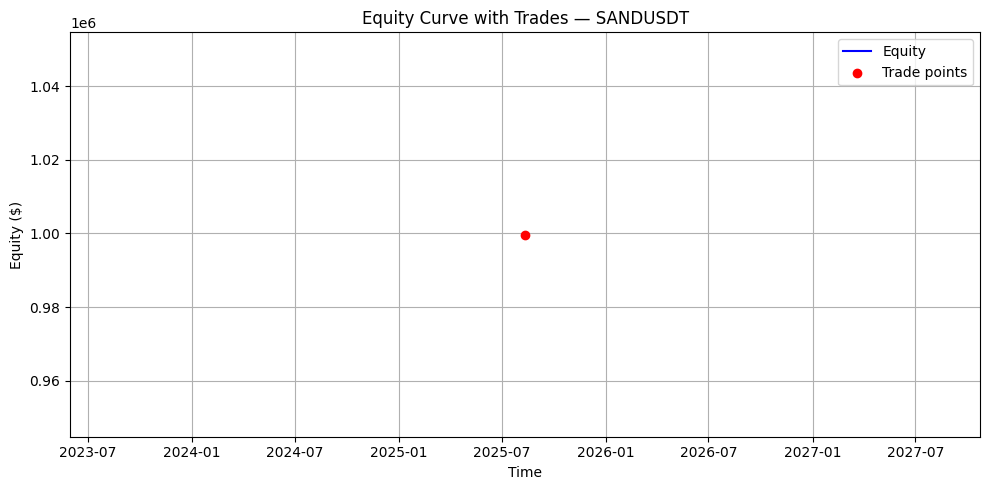

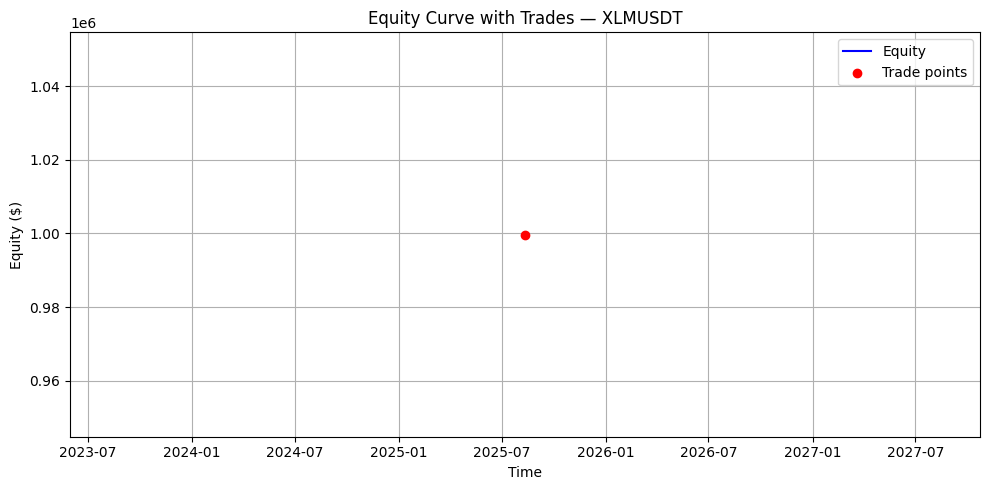

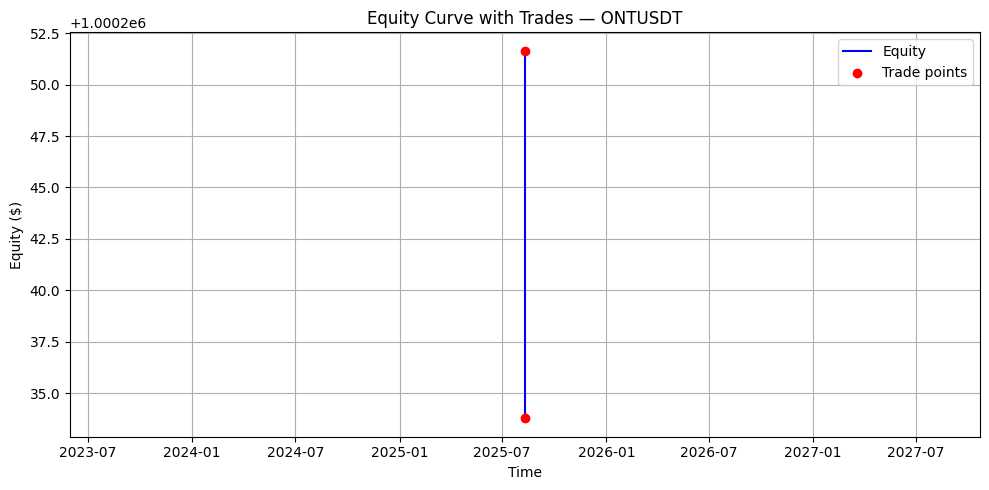

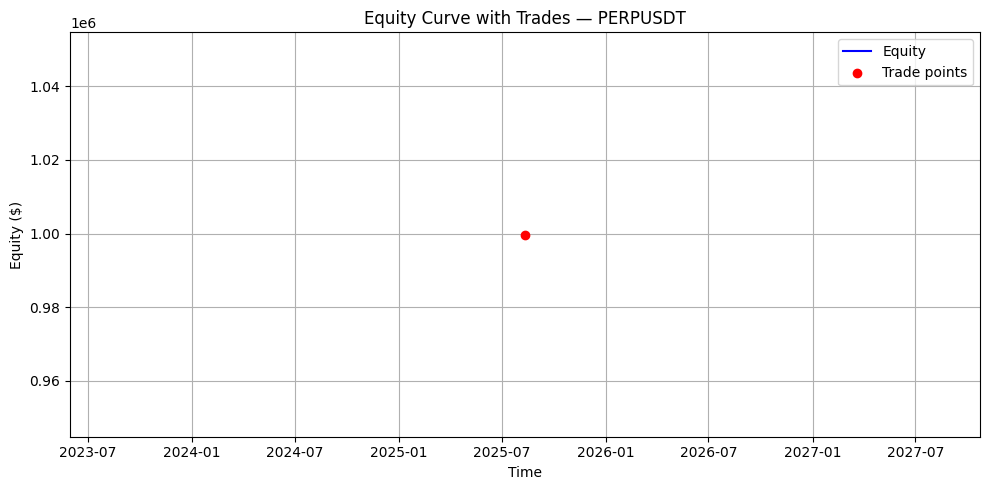

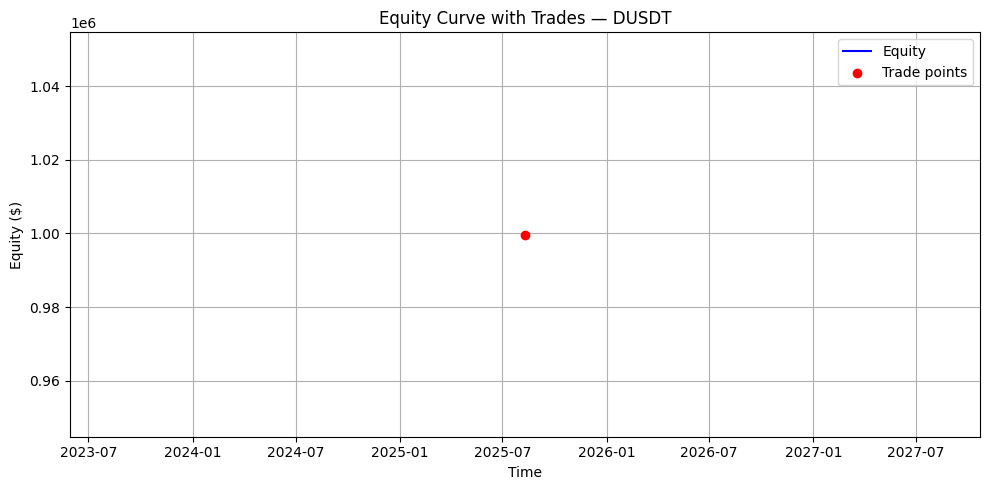

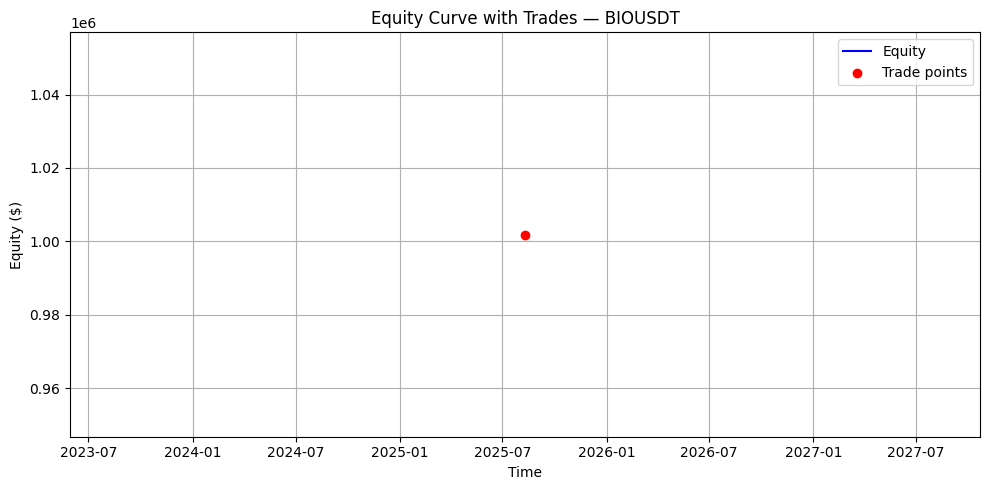

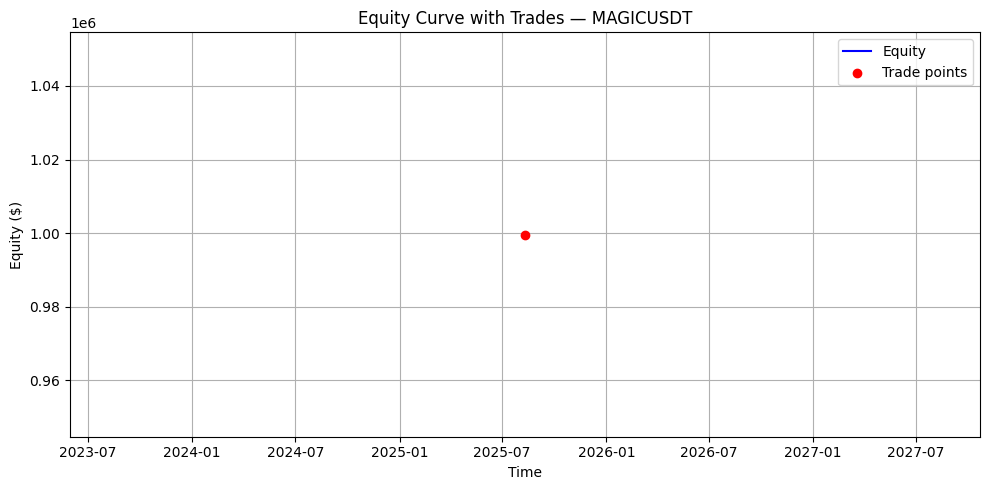

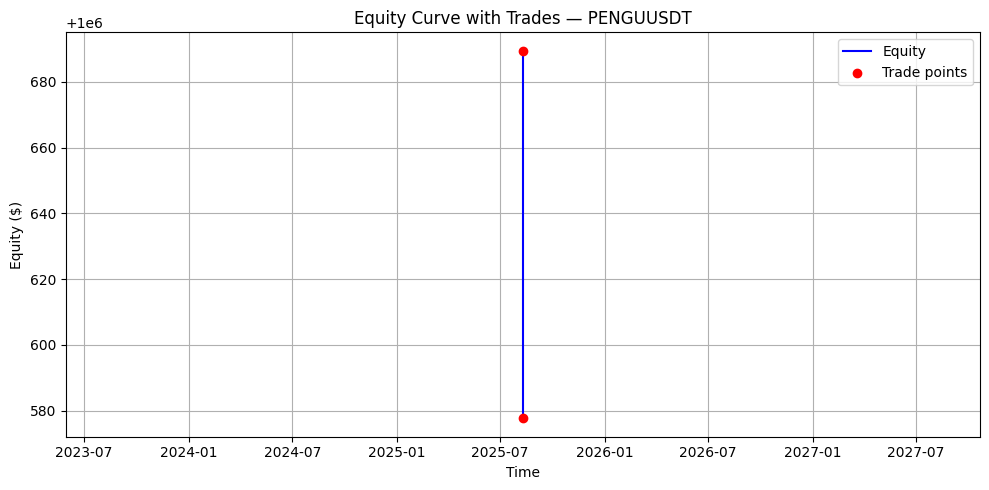

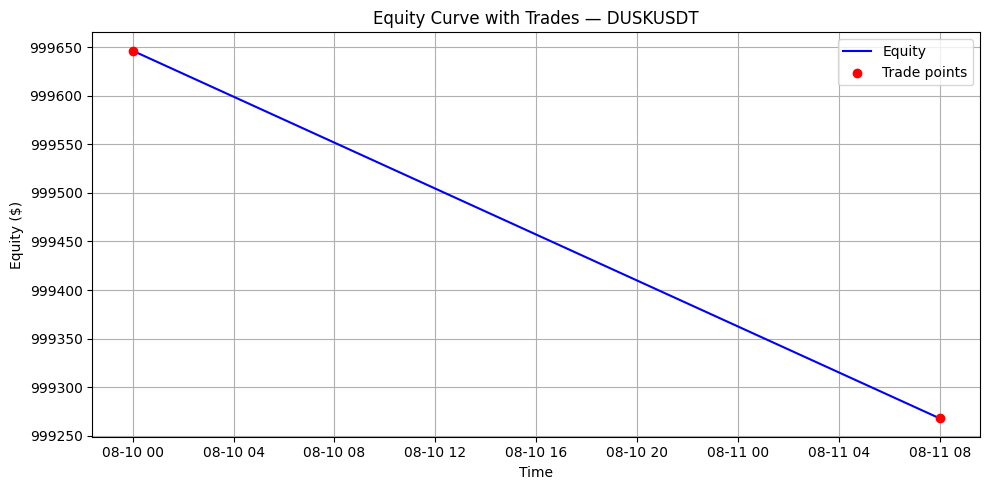

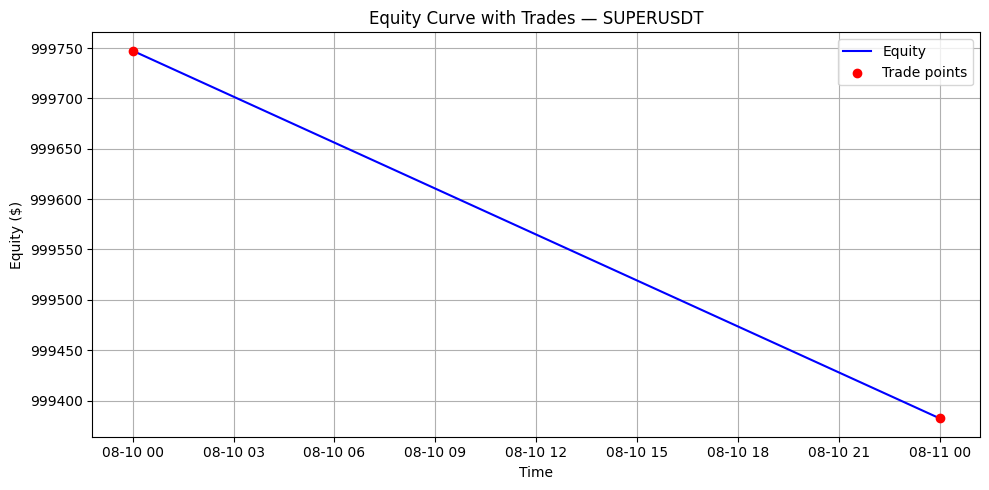

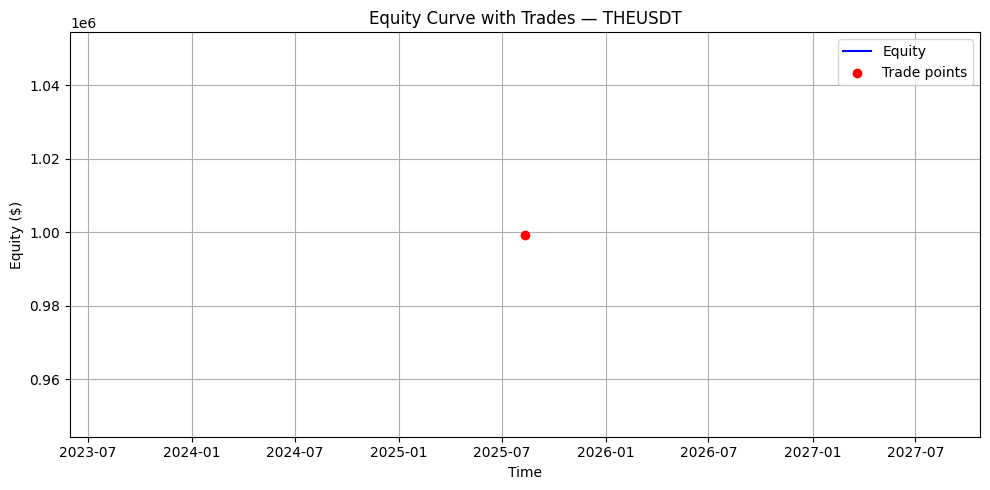

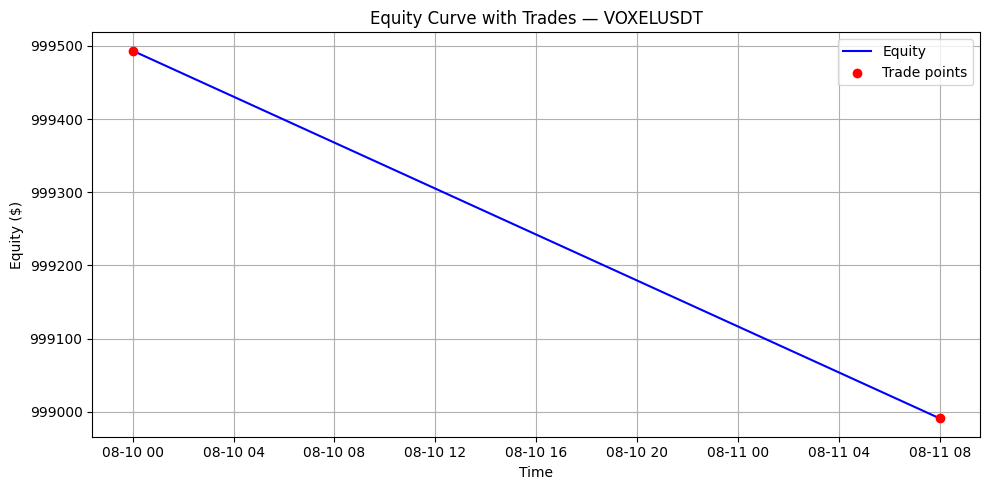

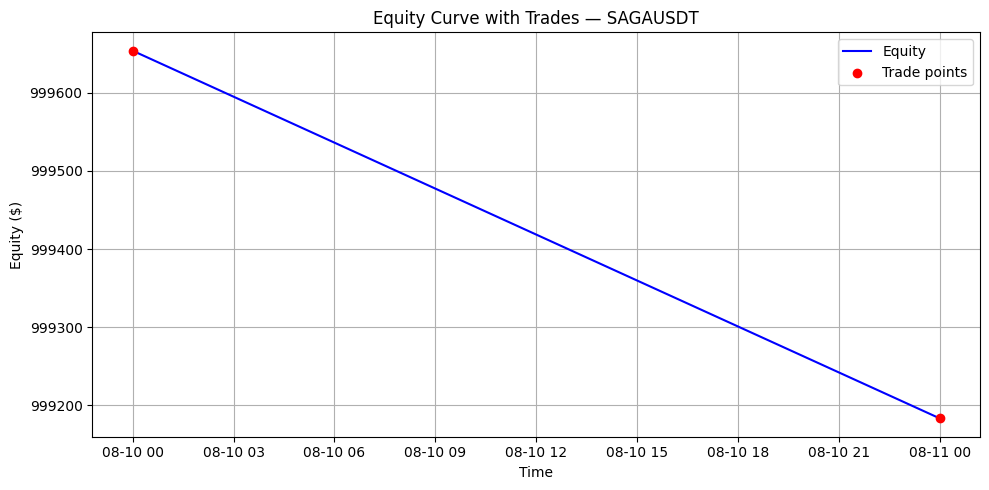

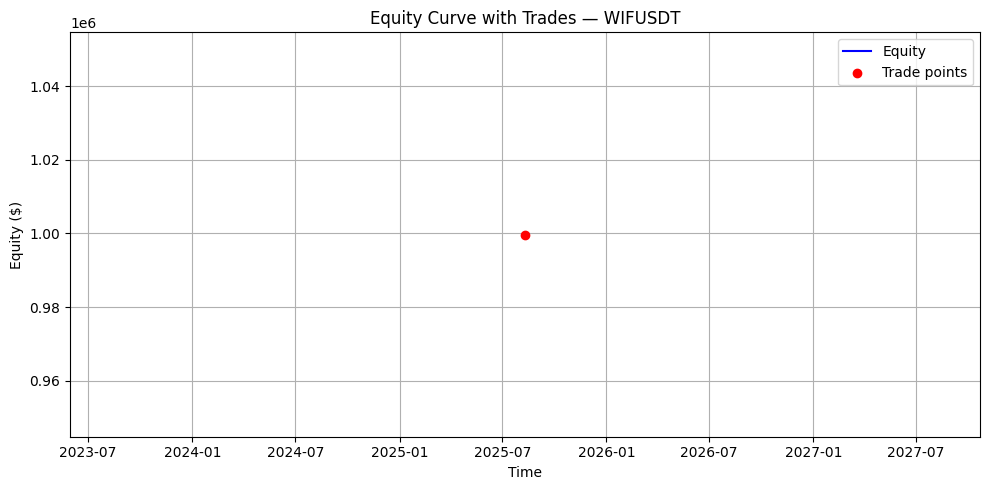

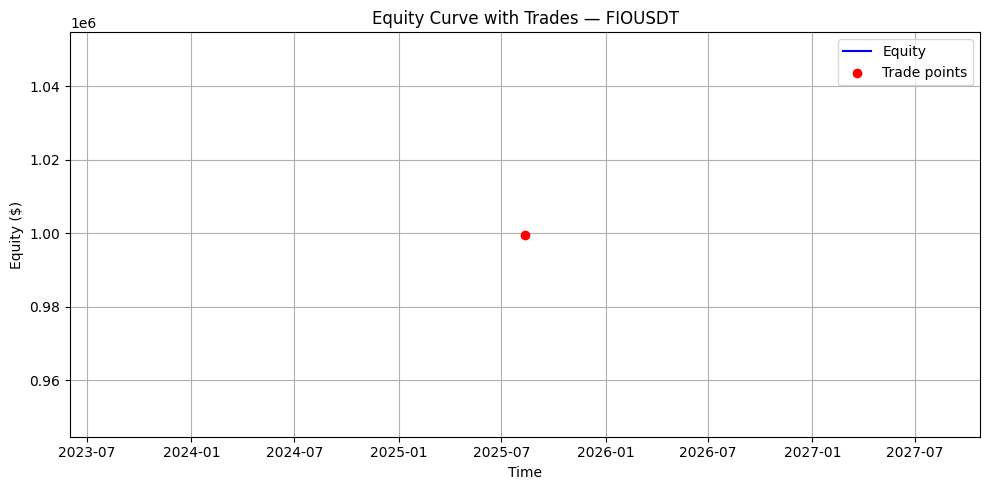

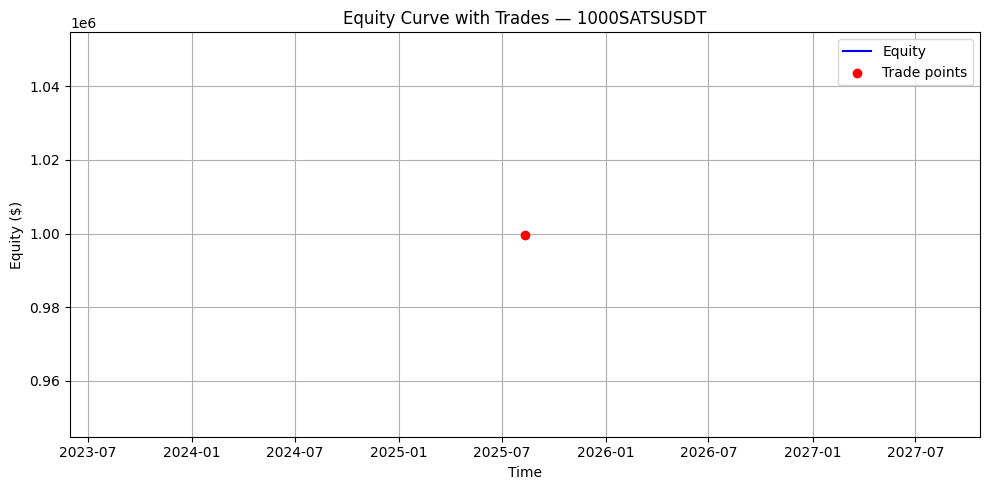

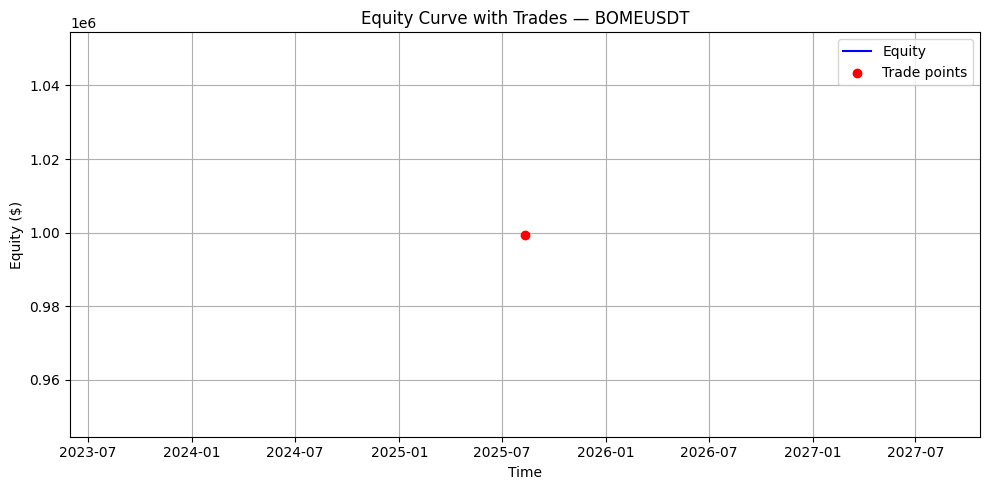

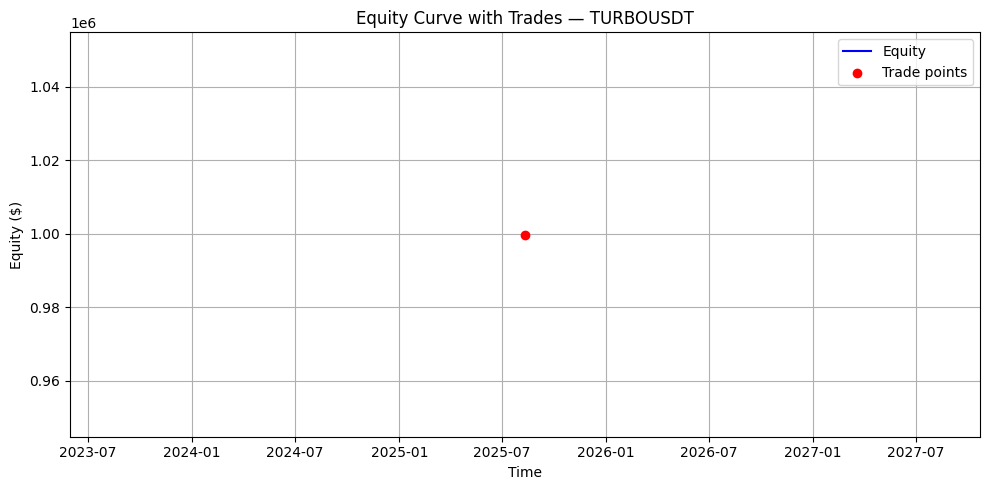

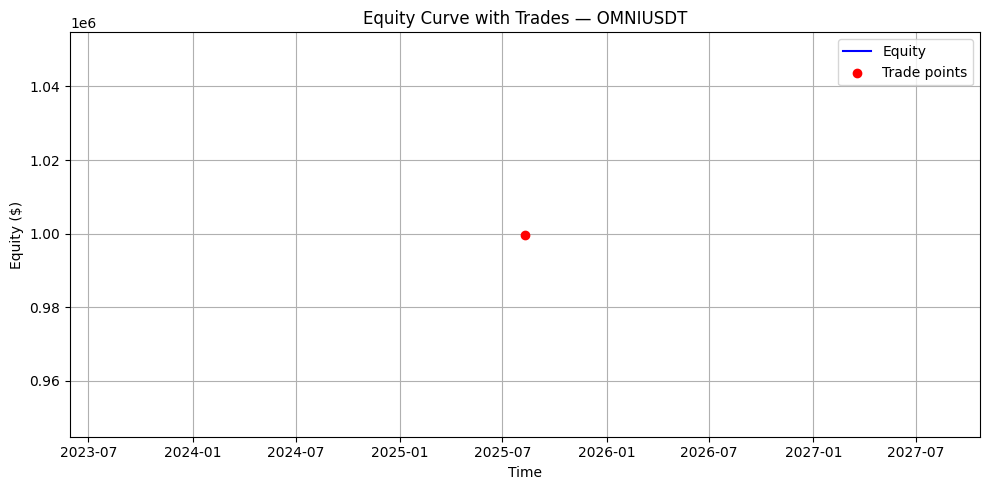

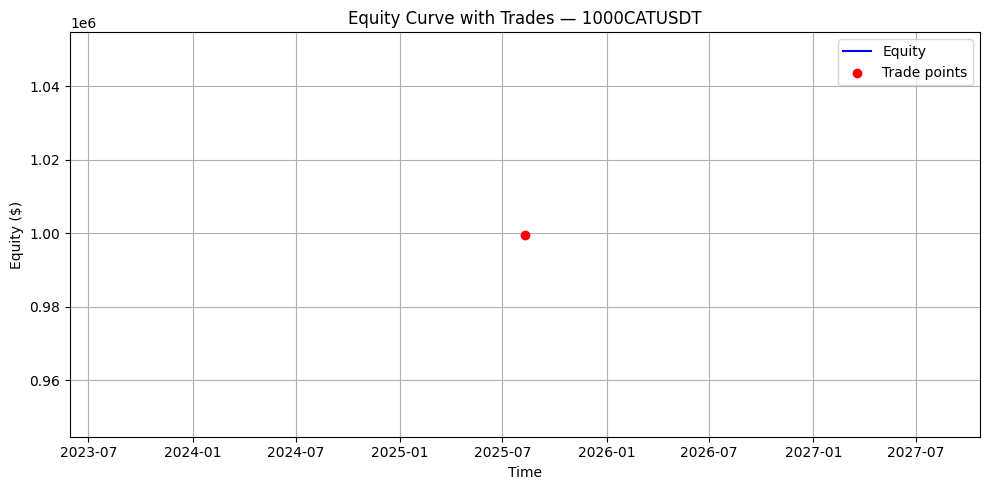

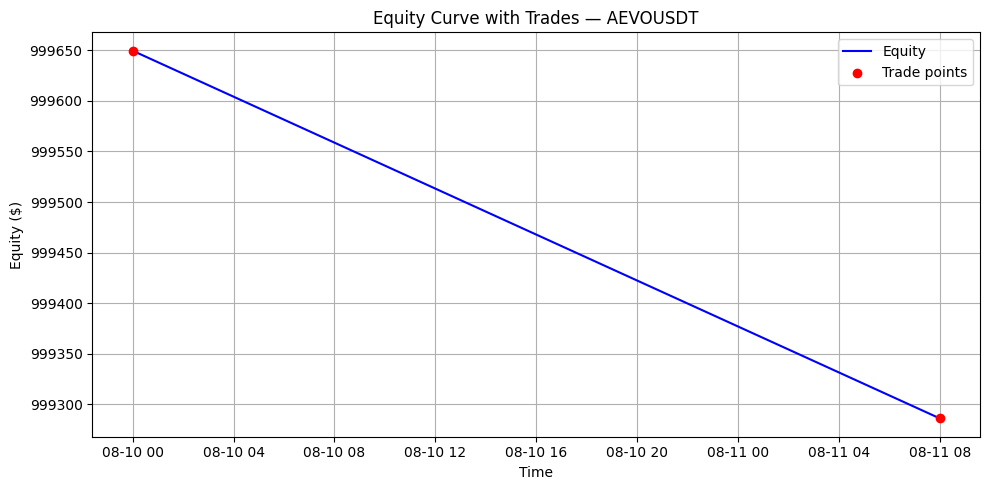

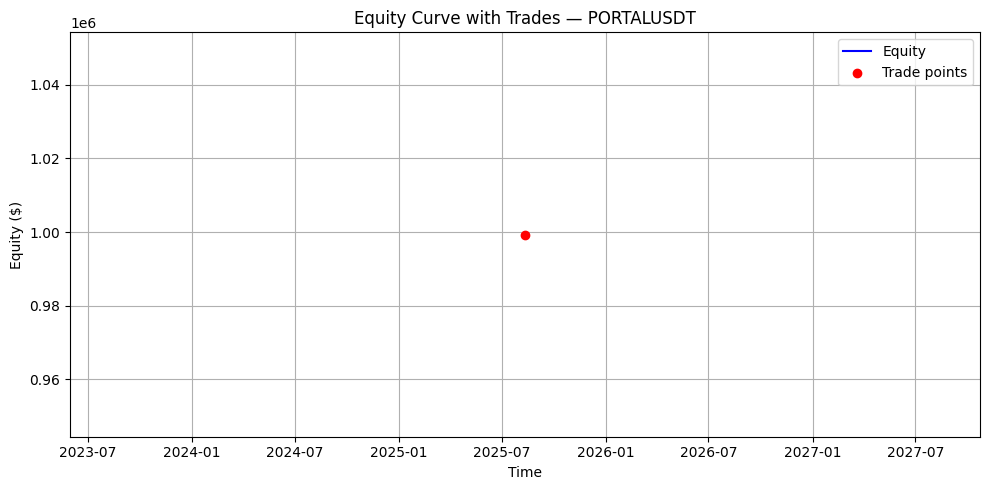

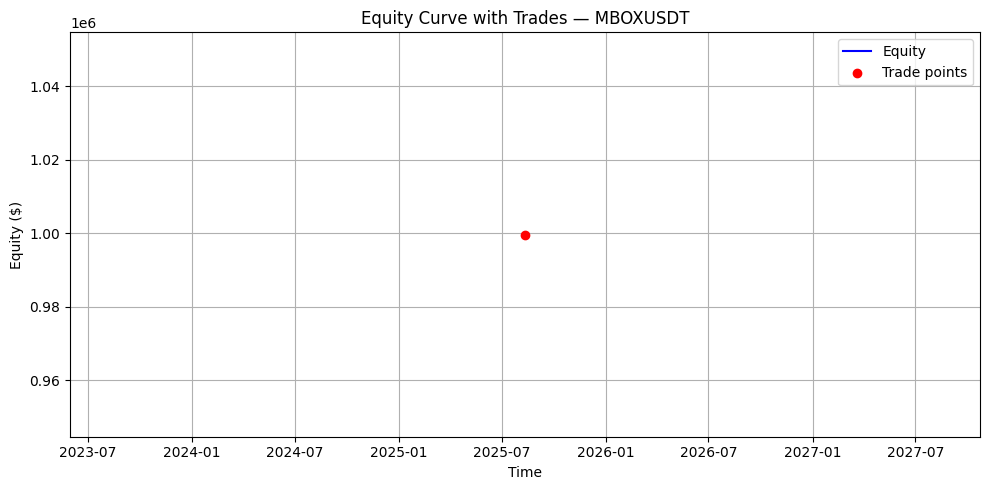

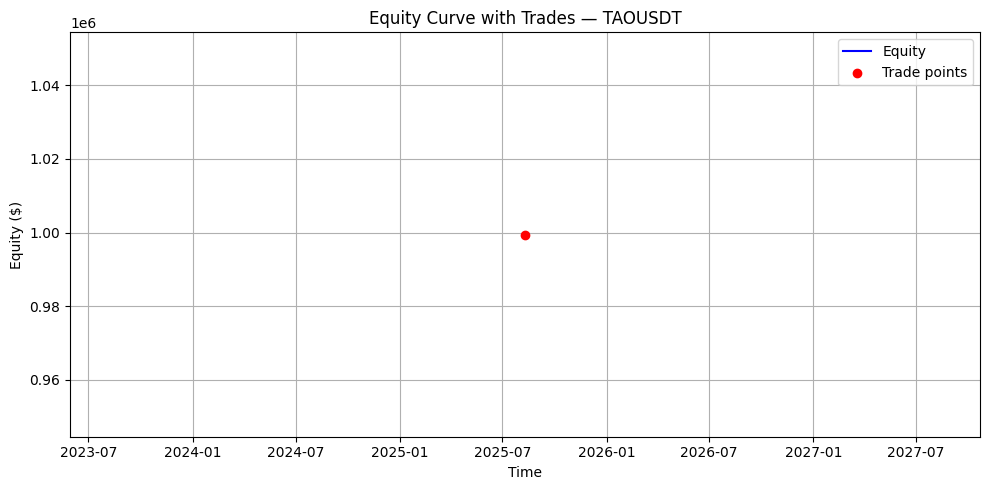

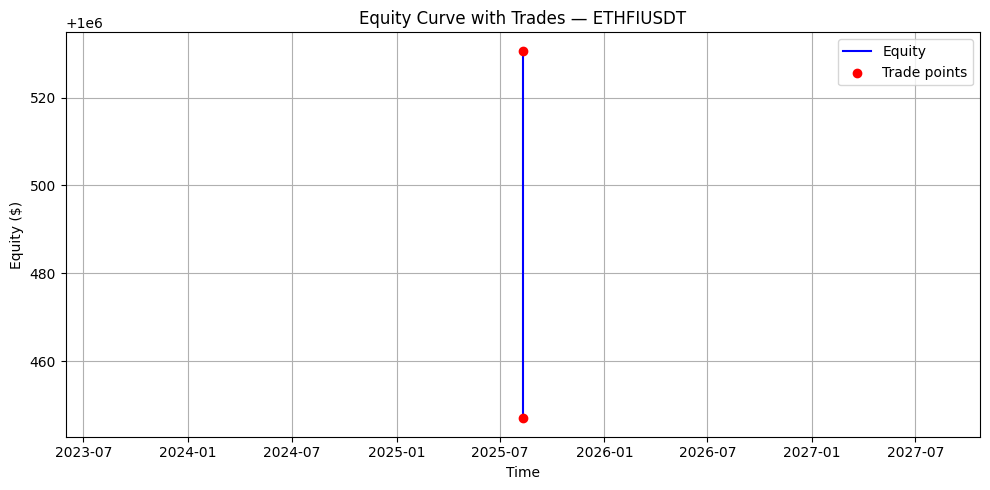

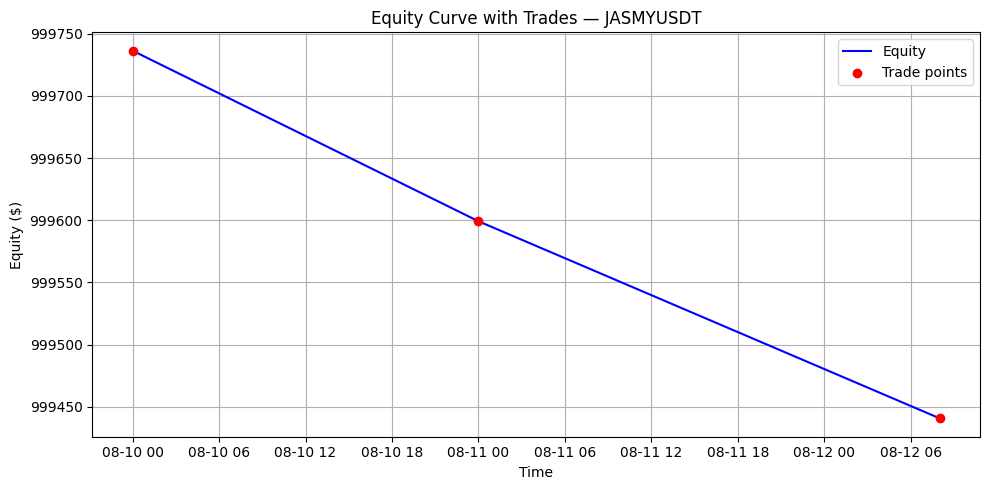

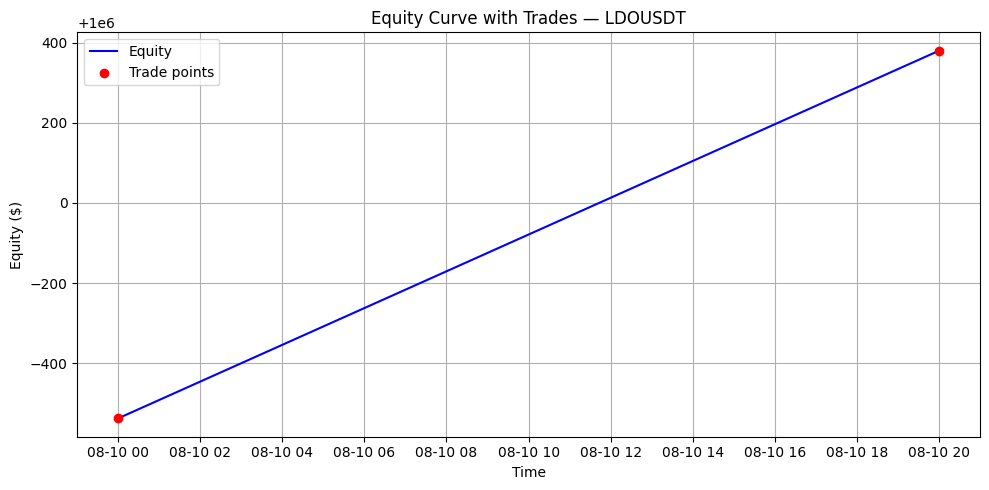

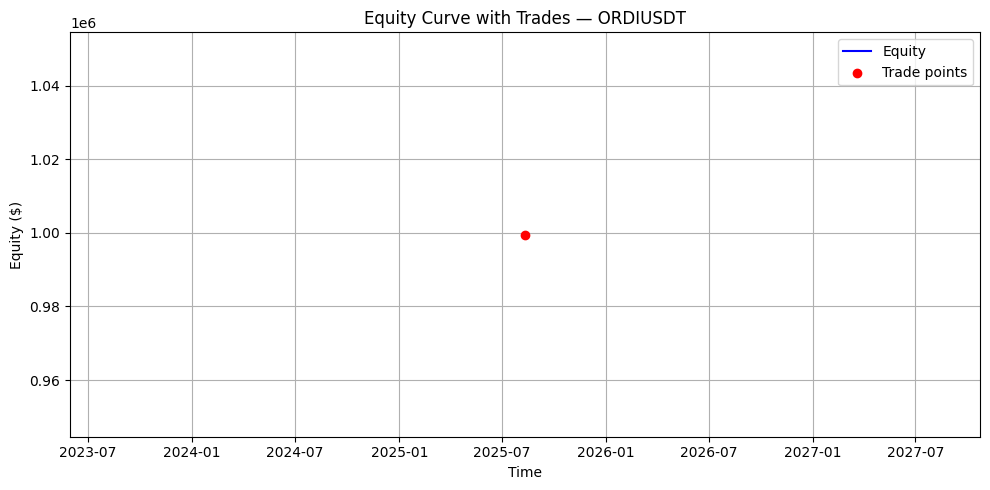

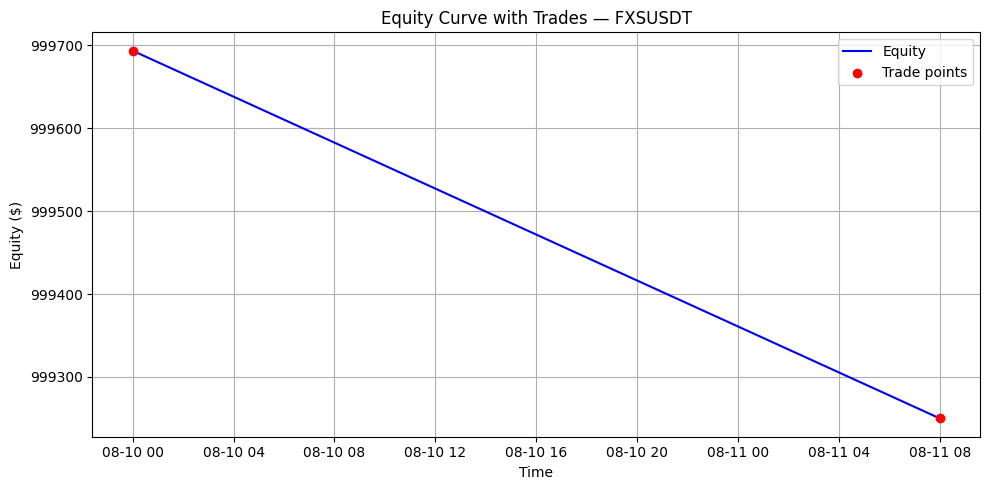

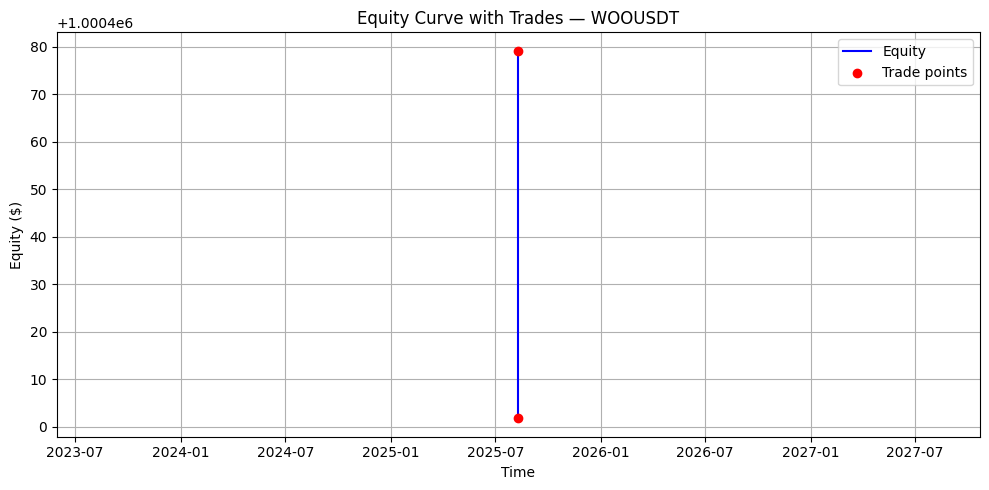

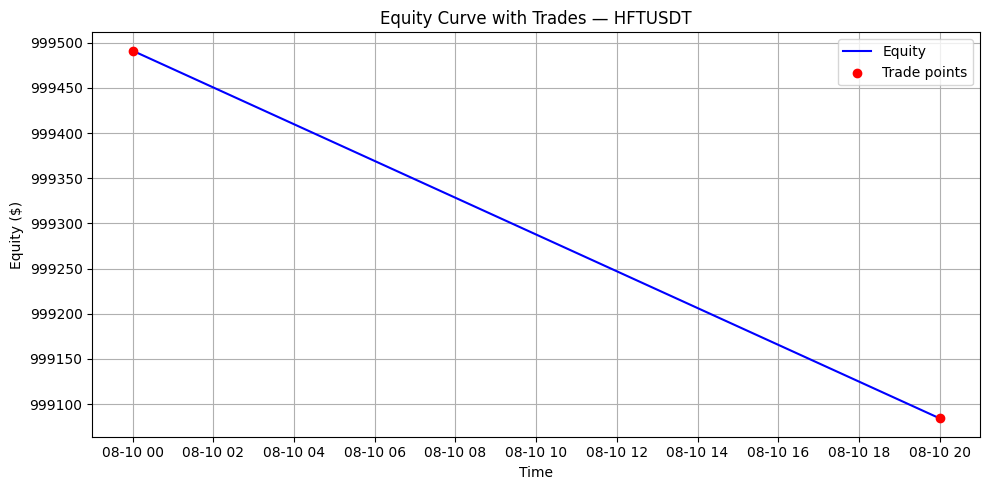

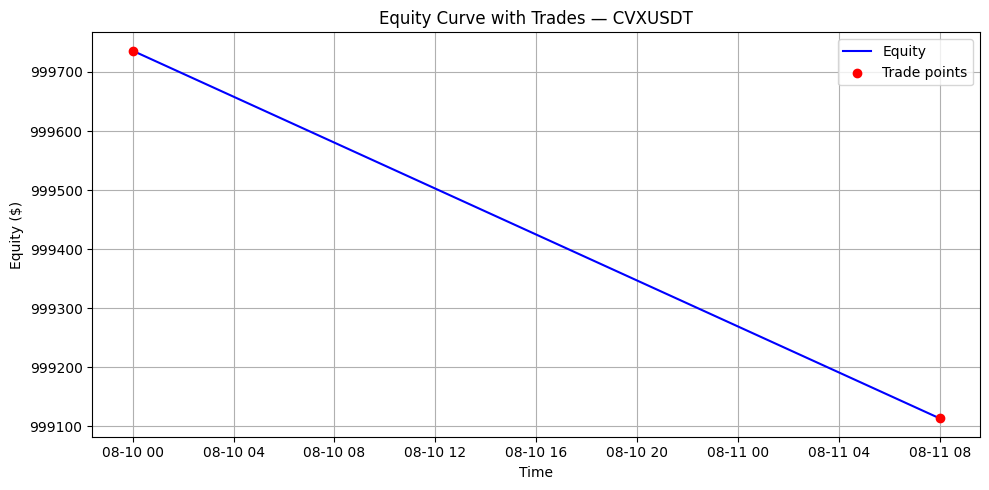

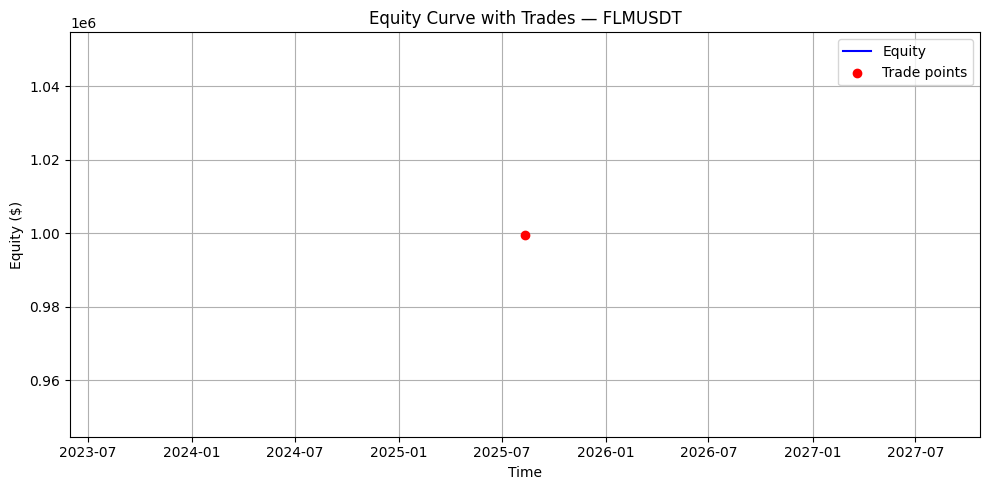

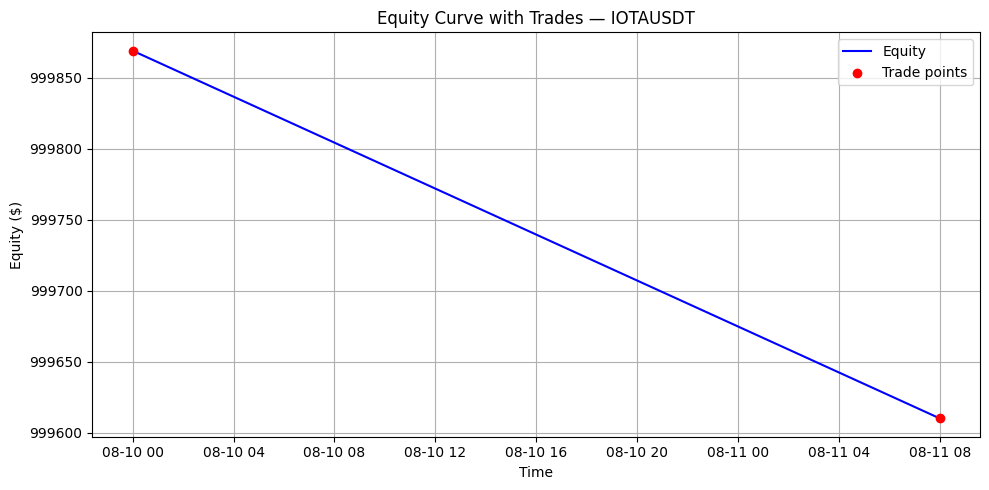

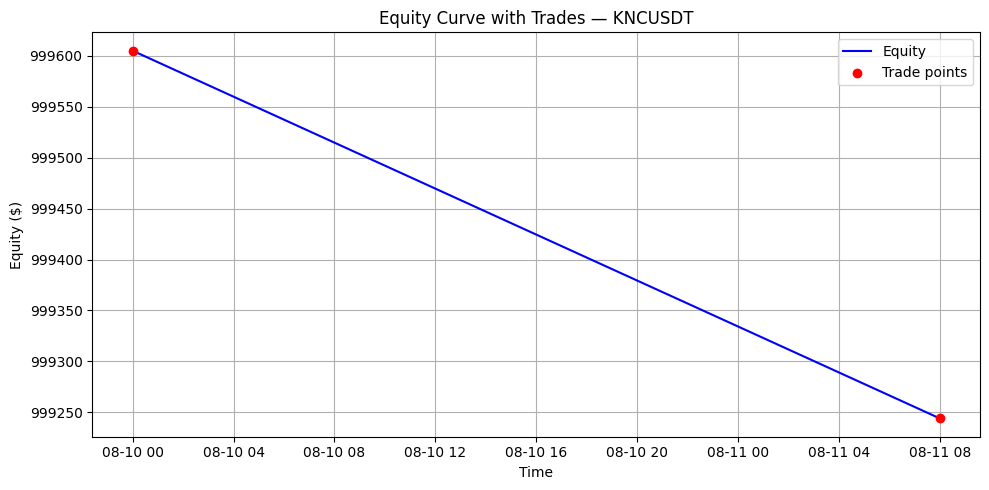

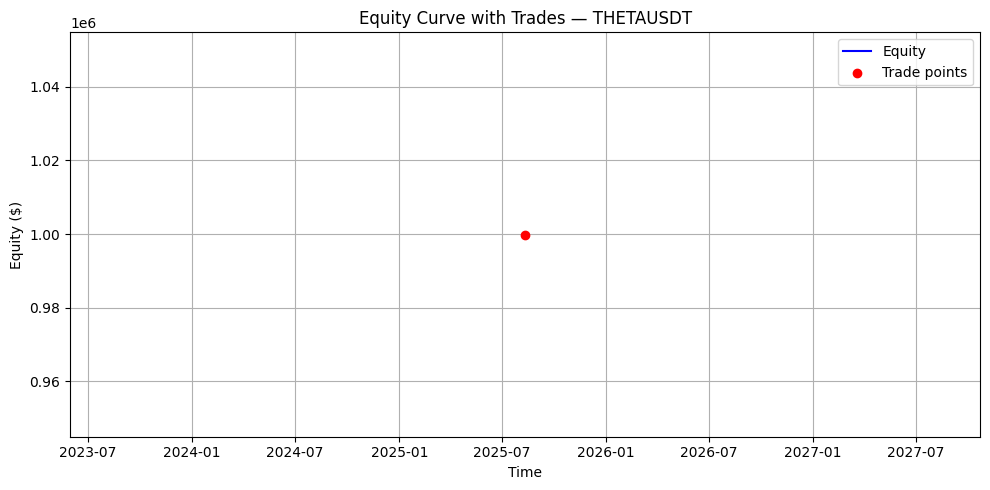

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Загрузка ===
file = f"all_trades_df_{interval}_2takes.csv"
trades_df = pd.read_csv(file, parse_dates=["EntryTime", "ExitTime"])

initial_cash = 1_000_000
symbols = trades_df["symbol"].unique()

for symbol in symbols:
    df = trades_df[trades_df["symbol"] == symbol].copy()
    df.sort_values("EntryTime", inplace=True)
    if df.empty:
        continue

    # === Расчёт equity ===
    equity = [initial_cash]
    for ret in df["ReturnPct"]:
        equity.append(equity[-1] * (1 + ret / 100))
    df["Equity"] = equity[1:]
    df["EntryTime"] = pd.to_datetime(df["EntryTime"])

    # === Построение ===
    plt.figure(figsize=(10, 5))
    plt.plot(df["EntryTime"], df["Equity"], label="Equity", color="blue")

    # Добавим точки
    plt.scatter(df["EntryTime"], df["Equity"],
                color="red", label="Trade points", zorder=5)

    plt.title(f"Equity Curve with Trades — {symbol}")
    plt.xlabel("Time")
    plt.ylabel("Equity ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
# symbols = ['BNBUSDT', 'ETHUSDT', 'TNSRUSDT', '1000CHEEMSUSDT', 'KNCUSDT',
#        'IOTAUSDT', 'TURBOUSDT', 'BIOUSDT', 'NOTUSDT', 'CGPTUSDT', 'DUSDT',
#        'WLDUSDT', 'UMAUSDT', 'LISTAUSDT', 'EIGENUSDT', 'LINAUSDT',
#        'MOVRUSDT', 'DIAUSDT', 'ARPAUSDT']
symbols = all_trade_logs['symbol'].unique()

## Compare real and backtest tradings

In [ ]:
real_df = pd.read_csv("trades_before_crash.csv")
back_df = pd.DataFrame(trades)

In [ ]:
import pandas as pd
import numpy as np
import pytz

# ==== Настройки периода ====
start_utc = pd.Timestamp("2025-08-09 20:00:00", tz="UTC")
end_utc   = pd.Timestamp("2025-08-13 16:00:00", tz="UTC")

# ==== Подготовка данных бэктеста ====
back_df = pd.DataFrame(trades).copy()

# Переименование в единый формат
back_df.rename(columns={
    "entry_time": "EntryTime_bt",
    "pnl_usd": "ReturnPct_bt"   # пока в $ (ниже решим про %)
}, inplace=True)

# Приведение времени
back_df["EntryTime_bt"] = pd.to_datetime(back_df["EntryTime_bt"], utc=True)

# === Преобразование pnl_usd в % ===
back_df["ReturnPct_bt"] = (
    back_df["ReturnPct_bt"] / (back_df["entry_price"] * back_df["qty"])
) * 100

# ==== Подготовка реальных сделок ====
if "EntryTime_real" not in real_df.columns:
    if "open_time" in real_df.columns:
        real_df["EntryTime_real"] = pd.to_datetime(real_df["open_time"], unit="ms", utc=True)
    else:
        raise ValueError("Не найдена колонка EntryTime_real или open_time в real_df")

# Проверим, в чём у тебя 'result'
if real_df["result"].abs().max() > 10:
    # скорее всего в $ → пересчитаем в %
    if "entry_price" in real_df.columns and "qty" in real_df.columns:
        real_df["ReturnPct_real"] = (real_df["result"] / (real_df["entry_price"] * real_df["qty"])) * 100
    else:
        print("⚠️ В real_df результат в $, но нет entry_price/qty для пересчёта. Сравнение будет в $")
        real_df["ReturnPct_real"] = real_df["result"]
else:
    # уже в %
    real_df["ReturnPct_real"] = real_df["result"]

# ==== Фильтрация по периоду ====
real_df_period = real_df[(real_df["EntryTime_real"] >= start_utc) &
                         (real_df["EntryTime_real"] <= end_utc)].copy()
back_df_period = back_df[(back_df["EntryTime_bt"] >= start_utc) &
                         (back_df["EntryTime_bt"] <= end_utc)].copy()

# ==== Сопоставление сделок ====
matched = []
for _, r in real_df_period.iterrows():
    symbol = r["symbol"]
    t_real = r["EntryTime_real"]
    candidates = back_df_period[back_df_period["symbol"] == symbol].copy()
    if candidates.empty:
        continue
    candidates["time_diff"] = (candidates["EntryTime_bt"] - t_real).abs()
    nearest = candidates.loc[candidates["time_diff"].idxmin()]
    if nearest["time_diff"] <= pd.Timedelta(minutes=5): # Минуты
        matched.append({
            "symbol": symbol,
            "EntryTime_real": t_real,
            "ReturnPct_real": r["ReturnPct_real"],
            "EntryTime_bt": nearest["EntryTime_bt"],
            "ReturnPct_bt": nearest["ReturnPct_bt"]
        })

matched_df = pd.DataFrame(matched)

# ==== Аналитика ====
total_real = len(real_df_period)
total_bt = len(back_df_period)

# 🟢 Исправление: учитываем symbol+время, а не только symbol
only_real = real_df_period.merge(
    matched_df[["symbol", "EntryTime_real"]],
    on=["symbol", "EntryTime_real"],
    how="left",
    indicator=True
)
only_real = only_real[only_real["_merge"] == "left_only"].drop(columns="_merge")

only_bt = back_df_period.merge(
    matched_df[["symbol", "EntryTime_bt"]],
    on=["symbol", "EntryTime_bt"],
    how="left",
    indicator=True
)
only_bt = only_bt[only_bt["_merge"] == "left_only"].drop(columns="_merge")

print(f"=== Итоги по периоду ===")
print(f"Период (UTC): {start_utc} .. {end_utc}")
print(f"Реальных сделок в периоде: {total_real}")
print(f"Сделок в бэктесте в периоде: {total_bt}")
print(f"Сопоставлено сделок (±5min): {len(matched_df)}")

if len(matched_df) > 0:
    matched_df["dir_real"] = np.sign(matched_df["ReturnPct_real"])
    matched_df["dir_bt"] = np.sign(matched_df["ReturnPct_bt"])
    matched_df["same_direction"] = matched_df["dir_real"] == matched_df["dir_bt"]
    matched_df["better"] = np.where(matched_df["ReturnPct_real"] > matched_df["ReturnPct_bt"], "real", "bt")

    print(f"Совпадение по направлению: {matched_df['same_direction'].mean()*100:.1f}%")
    print(f"Средняя |разница| ReturnPct: {np.mean(np.abs(matched_df['ReturnPct_real'] - matched_df['ReturnPct_bt'])):.4f}%")
    print("Кто лучше (counts):")
    print(matched_df["better"].value_counts())
else:
    print("Совпадений нет.")

print("\n🔹 Сделки только в реале:")
print(only_real[["symbol", "EntryTime_real"]])

print("\n🔹 Сделки только в бэктесте:")
print(only_bt[["symbol", "EntryTime_bt"]])

print("\nПримеры совпавших сделок:")
print(matched_df.head(20))

# Отладочная инфа
print("\nДиапазон дат в back_df:", back_df["EntryTime_bt"].min(), "->", back_df["EntryTime_bt"].max())
print("Диапазон дат в real_df:", real_df["EntryTime_real"].min(), "->", real_df["EntryTime_real"].max())



=== Итоги по периоду ===
Период (UTC): 2025-08-09 20:00:00+00:00 .. 2025-08-13 16:00:00+00:00
Реальных сделок в периоде: 88
Сделок в бэктесте в периоде: 151
Сопоставлено сделок (±5min): 88
Совпадение по направлению: 70.5%
Средняя |разница| ReturnPct: 1.4915%
Кто лучше (counts):
better
real    75
bt      13
Name: count, dtype: int64

🔹 Сделки только в реале:
Empty DataFrame
Columns: [symbol, EntryTime_real]
Index: []

🔹 Сделки только в бэктесте:
        symbol              EntryTime_bt
20   PENGUUSDT 2025-08-10 04:00:00+00:00
21     TAOUSDT 2025-08-10 04:00:00+00:00
23   VOXELUSDT 2025-08-10 04:00:00+00:00
27     BIOUSDT 2025-08-10 08:00:00+00:00
37   PENGUUSDT 2025-08-10 20:00:00+00:00
..         ...                       ...
146  MAGICUSDT 2025-08-13 12:00:00+00:00
147    WOOUSDT 2025-08-13 12:00:00+00:00
148    WIFUSDT 2025-08-13 12:00:00+00:00
149   DUSKUSDT 2025-08-13 12:00:00+00:00
150   SANDUSDT 2025-08-13 12:00:00+00:00

[63 rows x 2 columns]

Примеры совпавших сделок:
         

In [ ]:
print("Колонки в back_df:", back_df.columns.tolist())
back_df.head()

Колонки в back_df: ['symbol', 'EntryTime_bt', 'entry_price', 'side', 'atr', 'take1_price', 'take2_price', 'stop_price_initial', 'qty', 'exit_time', 'exit_price', 'exit_reason', 'partial_taken', 'ReturnPct_bt', 'cum_pnl_usd']


symbol              EntryTime_bt  entry_price side       atr  \
0   SAGAUSDT 2025-08-09 20:00:00+00:00      0.28240  BUY  0.006692   
1   AEVOUSDT 2025-08-09 20:00:00+00:00      0.10570  BUY  0.002031   
2  JASMYUSDT 2025-08-09 20:00:00+00:00      0.01655  BUY  0.000320   
3    BIOUSDT 2025-08-09 20:00:00+00:00      0.10260  BUY  0.008006   
4    LDOUSDT 2025-08-09 20:00:00+00:00      1.32600  BUY  0.039898   

   take1_price  take2_price  stop_price_initial          qty  \
0     0.290765     0.315860            0.279389   354.233085   
1     0.110269     0.115853            0.104786   946.969697   
2     0.017271     0.018152            0.016406  6042.296073   
3     0.112607     0.134624            0.102497   974.658869   
4     1.375872     1.525488            1.308046    75.471698   

                  exit_time  exit_price exit_reason  partial_taken  \
0 2025-08-10 00:00:00+00:00    0.279389        STOP          False   
1 2025-08-10 00:00:00+00:00    0.104786        STOP          False   
2 2025-08-10 04:00:00+00:00    0.016406        STOP          False   
3 2025-08-10 00:00:00+00:00    0.102497     STOP_BE           True   
4 2025-08-10 00:00:00+00:00    1.308046        STOP          False   

   ReturnPct_bt  cum_pnl_usd  
0     -1.066347    -1.066724  
1     -0.864491    -1.932034  
2     -0.870950    -2.802984  
3      0.392688    -2.410297  
4     -1.353994    -3.765312

In [ ]:
only_bt


symbol              EntryTime_bt  entry_price side       atr  \
20   PENGUUSDT 2025-08-10 04:00:00+00:00     0.038692  BUY  0.001617   
21     TAOUSDT 2025-08-10 04:00:00+00:00   385.200000  BUY  7.989965   
23   VOXELUSDT 2025-08-10 04:00:00+00:00     0.063100  BUY  0.002453   
27     BIOUSDT 2025-08-10 08:00:00+00:00     0.114400  BUY  0.009139   
37   PENGUUSDT 2025-08-10 20:00:00+00:00     0.040279  BUY  0.001580   
..         ...                       ...          ...  ...       ...   
146  MAGICUSDT 2025-08-13 12:00:00+00:00     0.270200  BUY  0.013445   
147    WOOUSDT 2025-08-13 12:00:00+00:00     0.084900  BUY  0.002233   
148    WIFUSDT 2025-08-13 12:00:00+00:00     1.035000  BUY  0.035656   
149   DUSKUSDT 2025-08-13 12:00:00+00:00     0.070600  BUY  0.002063   
150   SANDUSDT 2025-08-13 12:00:00+00:00     0.306600  BUY  0.007181   

     take1_price  take2_price  stop_price_initial          qty  \
20      0.040713     0.046775            0.038653  2584.580393   
21    395.187457   421.154844          384.814800     0.259673   
23      0.066167     0.075367            0.061996  1584.786054   
27      0.125823     0.150954            0.110288   874.125874   
37      0.042254     0.048178            0.039568  2482.683284   
..           ...          ...                 ...          ...   
146     0.303813     0.337426            0.264150   369.959304   
147     0.087691     0.096065            0.083895  1179.245283   
148     1.115226     1.213281            1.018955    96.711799   
149     0.073179     0.080917            0.069671  1416.430595   
150     0.315576     0.338913            0.301215   326.157860   

                    exit_time  exit_price exit_reason  partial_taken  \
20  2025-08-11 08:00:00+00:00    0.038653     STOP_BE           True   
21  2025-08-10 20:00:00+00:00  384.814800     STOP_BE           True   
23  2025-08-10 08:00:00+00:00    0.061996        STOP          False   
27  2025-08-10 12:00:00+00:00    0.110288        STOP          False   
37  2025-08-11 08:00:00+00:00    0.039568        STOP          False   
..                        ...         ...         ...            ...   
146 2025-08-13 16:00:00+00:00    0.264150        STOP          False   
147 2025-08-13 16:00:00+00:00    0.083895        STOP          False   
148 2025-08-13 16:00:00+00:00    1.018955        STOP          False   
149 2025-08-13 16:00:00+00:00    0.070800         EOD          False   
150 2025-08-13 16:00:00+00:00    0.309600         EOD          False   

     ReturnPct_bt  cum_pnl_usd  
20       0.166136   -18.833111  
21       0.573199   -18.259763  
23      -1.749613   -21.081819  
27      -3.594730   -30.291551  
37      -1.764926   -48.447260  
..            ...          ...  
146     -2.239206  -143.756557  
147     -1.183595  -144.941548  
148     -1.550267  -146.493315  
149      0.283286  -146.210029  
150      0.978474  -145.231555  

[63 rows x 15 columns]

In [ ]:
extra_stats = only_bt.groupby("symbol").size().reset_index(name="count") \
                     .sort_values("count", ascending=False)

print("\n=== Символы с наибольшим числом лишних сигналов (только в бэктесте) ===")
extra_stats


=== Символы с наибольшим числом лишних сигналов (только в бэктесте) ===


symbol  count
11       LDOUSDT      5
18       SSVUSDT      5
14     PENGUUSDT      4
22     THETAUSDT      4
7        FXSUSDT      3
3       BOMEUSDT      3
5       DUSKUSDT      3
26       WIFUSDT      3
24     TURBOUSDT      3
8       HIFIUSDT      3
1       AEVOUSDT      2
9       IOTAUSDT      2
23       THEUSDT      2
21       TAOUSDT      2
19     SUPERUSDT      2
15      PERPUSDT      2
6        FLMUSDT      2
17      SANDUSDT      2
16      SAGAUSDT      2
2        BIOUSDT      1
10     JASMYUSDT      1
4        CVXUSDT      1
0   1000SATSUSDT      1
12     MAGICUSDT      1
13      MBOXUSDT      1
20       SYNUSDT      1
25     VOXELUSDT      1
27       WOOUSDT      1